## Submodule-2.1 : Dynamical Systems

## Table of Contents
#### 1. [PINN for Burger's Equation](#PINN-for-Burger's-Equation)


## PINN-for-Burger's-Equation

In [1]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

/Users/raj/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x, t, w, b):
    u = DNN(tf.concat([x,t],1), w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,t,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u=net_u(x,t, W, b)
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_t + u*u_x - nu*u_xx
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf[:,0:1]
    t_u = X_u_train_tf[:,1:2]
    x_f = X_f_train_tf[:,0:1]
    t_f = X_f_train_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, t_u, W, b) 
        f_nn = net_f(x_f,t_f, W, b, nu)
        loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss


    
nu = 0.01/np.pi
noise = 0.0        
N_u = 100
N_f = 10000
Nmax=40000

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)

lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

    

Iteration is: 0 and loss is: 0.2566310167312622
Iteration is: 1 and loss is: 0.23526228964328766
Iteration is: 2 and loss is: 0.22125136852264404
Iteration is: 3 and loss is: 0.2152591347694397
Iteration is: 4 and loss is: 0.21643051505088806
Iteration is: 5 and loss is: 0.22051557898521423
Iteration is: 6 and loss is: 0.22254502773284912
Iteration is: 7 and loss is: 0.22123509645462036
Iteration is: 8 and loss is: 0.2179287075996399
Iteration is: 9 and loss is: 0.21430082619190216
Iteration is: 10 and loss is: 0.21143503487110138
Iteration is: 11 and loss is: 0.2097298800945282
Iteration is: 12 and loss is: 0.20907731354236603
Iteration is: 13 and loss is: 0.20907141268253326
Iteration is: 14 and loss is: 0.20919497311115265
Iteration is: 15 and loss is: 0.2089935839176178
Iteration is: 16 and loss is: 0.20821210741996765
Iteration is: 17 and loss is: 0.2068447321653366
Iteration is: 18 and loss is: 0.20509067177772522
Iteration is: 19 and loss is: 0.2032514214515686
Iteration is: 20 

Iteration is: 167 and loss is: 0.08854237198829651
Iteration is: 168 and loss is: 0.08885208517313004
Iteration is: 169 and loss is: 0.08965422213077545
Iteration is: 170 and loss is: 0.09042058140039444
Iteration is: 171 and loss is: 0.08939284086227417
Iteration is: 172 and loss is: 0.08793023228645325
Iteration is: 173 and loss is: 0.08872589468955994
Iteration is: 174 and loss is: 0.08907507359981537
Iteration is: 175 and loss is: 0.08781430125236511
Iteration is: 176 and loss is: 0.08811157941818237
Iteration is: 177 and loss is: 0.08850400894880295
Iteration is: 178 and loss is: 0.0875641256570816
Iteration is: 179 and loss is: 0.08781102299690247
Iteration is: 180 and loss is: 0.08800071477890015
Iteration is: 181 and loss is: 0.0873023122549057
Iteration is: 182 and loss is: 0.08757937699556351
Iteration is: 183 and loss is: 0.08755649626255035
Iteration is: 184 and loss is: 0.08707951754331589
Iteration is: 185 and loss is: 0.08734317868947983
Iteration is: 186 and loss is: 0.

Iteration is: 333 and loss is: 0.07353556156158447
Iteration is: 334 and loss is: 0.07327693700790405
Iteration is: 335 and loss is: 0.07300188392400742
Iteration is: 336 and loss is: 0.07288768887519836
Iteration is: 337 and loss is: 0.07283227145671844
Iteration is: 338 and loss is: 0.0726868212223053
Iteration is: 339 and loss is: 0.07248789817094803
Iteration is: 340 and loss is: 0.07235917448997498
Iteration is: 341 and loss is: 0.07228666543960571
Iteration is: 342 and loss is: 0.07217172533273697
Iteration is: 343 and loss is: 0.07198157161474228
Iteration is: 344 and loss is: 0.07178449630737305
Iteration is: 345 and loss is: 0.0716402605175972
Iteration is: 346 and loss is: 0.07153845578432083
Iteration is: 347 and loss is: 0.07142512500286102
Iteration is: 348 and loss is: 0.07129192352294922
Iteration is: 349 and loss is: 0.07115800678730011
Iteration is: 350 and loss is: 0.07109259068965912
Iteration is: 351 and loss is: 0.07114940136671066
Iteration is: 352 and loss is: 0.

Iteration is: 495 and loss is: 0.059030093252658844
Iteration is: 496 and loss is: 0.058396145701408386
Iteration is: 497 and loss is: 0.05826695263385773
Iteration is: 498 and loss is: 0.05858601629734039
Iteration is: 499 and loss is: 0.05856701731681824
Iteration is: 500 and loss is: 0.05808525159955025
Iteration is: 501 and loss is: 0.05785463750362396
Iteration is: 502 and loss is: 0.05802217870950699
Iteration is: 503 and loss is: 0.05799572914838791
Iteration is: 504 and loss is: 0.05766826122999191
Iteration is: 505 and loss is: 0.05749168619513512
Iteration is: 506 and loss is: 0.05757303535938263
Iteration is: 507 and loss is: 0.05754704028367996
Iteration is: 508 and loss is: 0.05728299170732498
Iteration is: 509 and loss is: 0.057105787098407745
Iteration is: 510 and loss is: 0.05711670219898224
Iteration is: 511 and loss is: 0.05708037316799164
Iteration is: 512 and loss is: 0.05689644068479538
Iteration is: 513 and loss is: 0.056727953255176544
Iteration is: 514 and loss 

Iteration is: 660 and loss is: 0.03992268443107605
Iteration is: 661 and loss is: 0.03756076097488403
Iteration is: 662 and loss is: 0.036982957273721695
Iteration is: 663 and loss is: 0.03801746293902397
Iteration is: 664 and loss is: 0.039404094219207764
Iteration is: 665 and loss is: 0.03982669115066528
Iteration is: 666 and loss is: 0.039337340742349625
Iteration is: 667 and loss is: 0.03772089630365372
Iteration is: 668 and loss is: 0.03650568053126335
Iteration is: 669 and loss is: 0.03612232208251953
Iteration is: 670 and loss is: 0.03659557178616524
Iteration is: 671 and loss is: 0.03752657398581505
Iteration is: 672 and loss is: 0.03834052383899689
Iteration is: 673 and loss is: 0.03908434137701988
Iteration is: 674 and loss is: 0.039297059178352356
Iteration is: 675 and loss is: 0.03931186720728874
Iteration is: 676 and loss is: 0.03836287185549736
Iteration is: 677 and loss is: 0.03710995987057686
Iteration is: 678 and loss is: 0.035751186311244965
Iteration is: 679 and loss

Iteration is: 822 and loss is: 0.036534134298563004
Iteration is: 823 and loss is: 0.05161583796143532
Iteration is: 824 and loss is: 0.05550350993871689
Iteration is: 825 and loss is: 0.043876126408576965
Iteration is: 826 and loss is: 0.027593208476901054
Iteration is: 827 and loss is: 0.041748255491256714
Iteration is: 828 and loss is: 0.03518024459481239
Iteration is: 829 and loss is: 0.03106030449271202
Iteration is: 830 and loss is: 0.04434199631214142
Iteration is: 831 and loss is: 0.028522856533527374
Iteration is: 832 and loss is: 0.03780278563499451
Iteration is: 833 and loss is: 0.0310650747269392
Iteration is: 834 and loss is: 0.03286650404334068
Iteration is: 835 and loss is: 0.033318378031253815
Iteration is: 836 and loss is: 0.02988486923277378
Iteration is: 837 and loss is: 0.03359883278608322
Iteration is: 838 and loss is: 0.028123287484049797
Iteration is: 839 and loss is: 0.032835815101861954
Iteration is: 840 and loss is: 0.02772882580757141
Iteration is: 841 and lo

Iteration is: 981 and loss is: 0.026551974937319756
Iteration is: 982 and loss is: 0.024273527786135674
Iteration is: 983 and loss is: 0.022918568924069405
Iteration is: 984 and loss is: 0.02532322332262993
Iteration is: 985 and loss is: 0.024171417579054832
Iteration is: 986 and loss is: 0.02252628654241562
Iteration is: 987 and loss is: 0.023946400731801987
Iteration is: 988 and loss is: 0.02374759316444397
Iteration is: 989 and loss is: 0.0222806204110384
Iteration is: 990 and loss is: 0.022926412522792816
Iteration is: 991 and loss is: 0.023348184302449226
Iteration is: 992 and loss is: 0.02209397777915001
Iteration is: 993 and loss is: 0.02203996479511261
Iteration is: 994 and loss is: 0.022742226719856262
Iteration is: 995 and loss is: 0.022214971482753754
Iteration is: 996 and loss is: 0.021595831960439682
Iteration is: 997 and loss is: 0.022065164521336555
Iteration is: 998 and loss is: 0.022136345505714417
Iteration is: 999 and loss is: 0.021501289680600166
Iteration is: 1000 

Iteration is: 1141 and loss is: 0.02948322519659996
Iteration is: 1142 and loss is: 0.030694911256432533
Iteration is: 1143 and loss is: 0.020189471542835236
Iteration is: 1144 and loss is: 0.03074513003230095
Iteration is: 1145 and loss is: 0.0186585932970047
Iteration is: 1146 and loss is: 0.028187964111566544
Iteration is: 1147 and loss is: 0.018565818667411804
Iteration is: 1148 and loss is: 0.025979310274124146
Iteration is: 1149 and loss is: 0.019147049635648727
Iteration is: 1150 and loss is: 0.02328328788280487
Iteration is: 1151 and loss is: 0.018782468512654305
Iteration is: 1152 and loss is: 0.022121354937553406
Iteration is: 1153 and loss is: 0.019085410982370377
Iteration is: 1154 and loss is: 0.020870165899395943
Iteration is: 1155 and loss is: 0.019241273403167725
Iteration is: 1156 and loss is: 0.019502690061926842
Iteration is: 1157 and loss is: 0.018955053761601448
Iteration is: 1158 and loss is: 0.018868958577513695
Iteration is: 1159 and loss is: 0.01866582036018371

Iteration is: 1297 and loss is: 0.013036017306149006
Iteration is: 1298 and loss is: 0.013016071170568466
Iteration is: 1299 and loss is: 0.012996193021535873
Iteration is: 1300 and loss is: 0.012976380065083504
Iteration is: 1301 and loss is: 0.012956605292856693
Iteration is: 1302 and loss is: 0.012936904095113277
Iteration is: 1303 and loss is: 0.012917248532176018
Iteration is: 1304 and loss is: 0.012897659093141556
Iteration is: 1305 and loss is: 0.012878114357590675
Iteration is: 1306 and loss is: 0.01285862922668457
Iteration is: 1307 and loss is: 0.012839196249842644
Iteration is: 1308 and loss is: 0.01281982846558094
Iteration is: 1309 and loss is: 0.012800516560673714
Iteration is: 1310 and loss is: 0.012781249359250069
Iteration is: 1311 and loss is: 0.012762049213051796
Iteration is: 1312 and loss is: 0.012742887251079082
Iteration is: 1313 and loss is: 0.012723797932267189
Iteration is: 1314 and loss is: 0.012704752385616302
Iteration is: 1315 and loss is: 0.01268577575683

Iteration is: 1453 and loss is: 0.01079223956912756
Iteration is: 1454 and loss is: 0.010778398253023624
Iteration is: 1455 and loss is: 0.010764604434370995
Iteration is: 1456 and loss is: 0.010750909335911274
Iteration is: 1457 and loss is: 0.010737340897321701
Iteration is: 1458 and loss is: 0.010723792016506195
Iteration is: 1459 and loss is: 0.010710208676755428
Iteration is: 1460 and loss is: 0.010696617886424065
Iteration is: 1461 and loss is: 0.010683063417673111
Iteration is: 1462 and loss is: 0.010669589042663574
Iteration is: 1463 and loss is: 0.010656170547008514
Iteration is: 1464 and loss is: 0.010642796754837036
Iteration is: 1465 and loss is: 0.010629428550601006
Iteration is: 1466 and loss is: 0.010616086423397064
Iteration is: 1467 and loss is: 0.010602733120322227
Iteration is: 1468 and loss is: 0.010589445941150188
Iteration is: 1469 and loss is: 0.010576187632977962
Iteration is: 1470 and loss is: 0.010562987998127937
Iteration is: 1471 and loss is: 0.0105498097836

Iteration is: 1609 and loss is: 0.009330794215202332
Iteration is: 1610 and loss is: 0.009323183447122574
Iteration is: 1611 and loss is: 0.009313142858445644
Iteration is: 1612 and loss is: 0.00930003635585308
Iteration is: 1613 and loss is: 0.009290404617786407
Iteration is: 1614 and loss is: 0.009281930513679981
Iteration is: 1615 and loss is: 0.009270312264561653
Iteration is: 1616 and loss is: 0.009259135462343693
Iteration is: 1617 and loss is: 0.009250389412045479
Iteration is: 1618 and loss is: 0.00924051832407713
Iteration is: 1619 and loss is: 0.00922921672463417
Iteration is: 1620 and loss is: 0.009219340980052948
Iteration is: 1621 and loss is: 0.009210318326950073
Iteration is: 1622 and loss is: 0.009199971333146095
Iteration is: 1623 and loss is: 0.009189346805214882
Iteration is: 1624 and loss is: 0.009179973974823952
Iteration is: 1625 and loss is: 0.00917057879269123
Iteration is: 1626 and loss is: 0.009160250425338745
Iteration is: 1627 and loss is: 0.0091501921415328

Iteration is: 1770 and loss is: 0.05781835317611694
Iteration is: 1771 and loss is: 0.06483345478773117
Iteration is: 1772 and loss is: 0.03626515343785286
Iteration is: 1773 and loss is: 0.009862768463790417
Iteration is: 1774 and loss is: 0.021276148036122322
Iteration is: 1775 and loss is: 0.02931167557835579
Iteration is: 1776 and loss is: 0.012456409633159637
Iteration is: 1777 and loss is: 0.015683669596910477
Iteration is: 1778 and loss is: 0.023490427061915398
Iteration is: 1779 and loss is: 0.01151550654321909
Iteration is: 1780 and loss is: 0.013933592475950718
Iteration is: 1781 and loss is: 0.01420450396835804
Iteration is: 1782 and loss is: 0.010506853461265564
Iteration is: 1783 and loss is: 0.014135883189737797
Iteration is: 1784 and loss is: 0.009764001704752445
Iteration is: 1785 and loss is: 0.01269582286477089
Iteration is: 1786 and loss is: 0.010284125804901123
Iteration is: 1787 and loss is: 0.010455261915922165
Iteration is: 1788 and loss is: 0.01154722087085247
I

Iteration is: 1926 and loss is: 0.007152884267270565
Iteration is: 1927 and loss is: 0.00714541133493185
Iteration is: 1928 and loss is: 0.00713795330375433
Iteration is: 1929 and loss is: 0.0071305036544799805
Iteration is: 1930 and loss is: 0.007123067043721676
Iteration is: 1931 and loss is: 0.007115636952221394
Iteration is: 1932 and loss is: 0.007108217105269432
Iteration is: 1933 and loss is: 0.007100808434188366
Iteration is: 1934 and loss is: 0.007093420252203941
Iteration is: 1935 and loss is: 0.007086025085300207
Iteration is: 1936 and loss is: 0.007078651338815689
Iteration is: 1937 and loss is: 0.0070712873712182045
Iteration is: 1938 and loss is: 0.007063941098749638
Iteration is: 1939 and loss is: 0.007056581787765026
Iteration is: 1940 and loss is: 0.007049251347780228
Iteration is: 1941 and loss is: 0.007041924633085728
Iteration is: 1942 and loss is: 0.007034604903310537
Iteration is: 1943 and loss is: 0.007027290295809507
Iteration is: 1944 and loss is: 0.007020008750

Iteration is: 2082 and loss is: 0.0061013298109173775
Iteration is: 2083 and loss is: 0.006095312535762787
Iteration is: 2084 and loss is: 0.006089300848543644
Iteration is: 2085 and loss is: 0.0060833049938082695
Iteration is: 2086 and loss is: 0.006077321711927652
Iteration is: 2087 and loss is: 0.006071347743272781
Iteration is: 2088 and loss is: 0.006065388210117817
Iteration is: 2089 and loss is: 0.006059444509446621
Iteration is: 2090 and loss is: 0.006053511518985033
Iteration is: 2091 and loss is: 0.006047625560313463
Iteration is: 2092 and loss is: 0.0060417791828513145
Iteration is: 2093 and loss is: 0.006036014296114445
Iteration is: 2094 and loss is: 0.006030404008924961
Iteration is: 2095 and loss is: 0.006025085225701332
Iteration is: 2096 and loss is: 0.00602031871676445
Iteration is: 2097 and loss is: 0.0060166665352880955
Iteration is: 2098 and loss is: 0.0060151973739266396
Iteration is: 2099 and loss is: 0.006018319632858038
Iteration is: 2100 and loss is: 0.00603053

Iteration is: 2238 and loss is: 0.0053709219209849834
Iteration is: 2239 and loss is: 0.005369380582123995
Iteration is: 2240 and loss is: 0.005369381047785282
Iteration is: 2241 and loss is: 0.0053711943328380585
Iteration is: 2242 and loss is: 0.005375044420361519
Iteration is: 2243 and loss is: 0.005381456576287746
Iteration is: 2244 and loss is: 0.005390167236328125
Iteration is: 2245 and loss is: 0.005403799470514059
Iteration is: 2246 and loss is: 0.005423687398433685
Iteration is: 2247 and loss is: 0.005458025727421045
Iteration is: 2248 and loss is: 0.005509282927960157
Iteration is: 2249 and loss is: 0.005596125032752752
Iteration is: 2250 and loss is: 0.005717472638934851
Iteration is: 2251 and loss is: 0.005913028959184885
Iteration is: 2252 and loss is: 0.006147860549390316
Iteration is: 2253 and loss is: 0.0064810034818947315
Iteration is: 2254 and loss is: 0.006752222776412964
Iteration is: 2255 and loss is: 0.0070051997900009155
Iteration is: 2256 and loss is: 0.00694838

Iteration is: 2394 and loss is: 0.00733236875385046
Iteration is: 2395 and loss is: 0.006057002115994692
Iteration is: 2396 and loss is: 0.005266966298222542
Iteration is: 2397 and loss is: 0.005270342342555523
Iteration is: 2398 and loss is: 0.005717664025723934
Iteration is: 2399 and loss is: 0.006236501038074493
Iteration is: 2400 and loss is: 0.006489149294793606
Iteration is: 2401 and loss is: 0.006477175280451775
Iteration is: 2402 and loss is: 0.005984190851449966
Iteration is: 2403 and loss is: 0.005337595008313656
Iteration is: 2404 and loss is: 0.0048843733966350555
Iteration is: 2405 and loss is: 0.004878103733062744
Iteration is: 2406 and loss is: 0.005192268639802933
Iteration is: 2407 and loss is: 0.005478973500430584
Iteration is: 2408 and loss is: 0.005514242686331272
Iteration is: 2409 and loss is: 0.005296303424984217
Iteration is: 2410 and loss is: 0.005032727960497141
Iteration is: 2411 and loss is: 0.004862140864133835
Iteration is: 2412 and loss is: 0.004832080565

Iteration is: 2552 and loss is: 0.005607446655631065
Iteration is: 2553 and loss is: 0.006265588104724884
Iteration is: 2554 and loss is: 0.006114101968705654
Iteration is: 2555 and loss is: 0.005219817161560059
Iteration is: 2556 and loss is: 0.004522986710071564
Iteration is: 2557 and loss is: 0.004627893678843975
Iteration is: 2558 and loss is: 0.005202042870223522
Iteration is: 2559 and loss is: 0.00551803782582283
Iteration is: 2560 and loss is: 0.005250077694654465
Iteration is: 2561 and loss is: 0.004795405548065901
Iteration is: 2562 and loss is: 0.00459181796759367
Iteration is: 2563 and loss is: 0.0047141630202531815
Iteration is: 2564 and loss is: 0.0048747314140200615
Iteration is: 2565 and loss is: 0.004869965836405754
Iteration is: 2566 and loss is: 0.004784977063536644
Iteration is: 2567 and loss is: 0.0047078561037778854
Iteration is: 2568 and loss is: 0.004624510183930397
Iteration is: 2569 and loss is: 0.004484315402805805
Iteration is: 2570 and loss is: 0.00441350648

Iteration is: 2707 and loss is: 0.004298723302781582
Iteration is: 2708 and loss is: 0.004452145658433437
Iteration is: 2709 and loss is: 0.004625062458217144
Iteration is: 2710 and loss is: 0.004829733166843653
Iteration is: 2711 and loss is: 0.004971977323293686
Iteration is: 2712 and loss is: 0.005075796972960234
Iteration is: 2713 and loss is: 0.005026784725487232
Iteration is: 2714 and loss is: 0.004906231537461281
Iteration is: 2715 and loss is: 0.004680754616856575
Iteration is: 2716 and loss is: 0.004458234645426273
Iteration is: 2717 and loss is: 0.004259956069290638
Iteration is: 2718 and loss is: 0.004127786494791508
Iteration is: 2719 and loss is: 0.00405875314027071
Iteration is: 2720 and loss is: 0.004042265936732292
Iteration is: 2721 and loss is: 0.004066172521561384
Iteration is: 2722 and loss is: 0.004123700316995382
Iteration is: 2723 and loss is: 0.004217530135065317
Iteration is: 2724 and loss is: 0.004343447275459766
Iteration is: 2725 and loss is: 0.0045165163464

Iteration is: 2864 and loss is: 0.004285390023142099
Iteration is: 2865 and loss is: 0.0042338441126048565
Iteration is: 2866 and loss is: 0.004172788001596928
Iteration is: 2867 and loss is: 0.004085594788193703
Iteration is: 2868 and loss is: 0.004006149247288704
Iteration is: 2869 and loss is: 0.003930442035198212
Iteration is: 2870 and loss is: 0.003872523084282875
Iteration is: 2871 and loss is: 0.0038278321735560894
Iteration is: 2872 and loss is: 0.003796965815126896
Iteration is: 2873 and loss is: 0.0037757025565952063
Iteration is: 2874 and loss is: 0.003762112697586417
Iteration is: 2875 and loss is: 0.0037536732852458954
Iteration is: 2876 and loss is: 0.0037486357614398003
Iteration is: 2877 and loss is: 0.003745295573025942
Iteration is: 2878 and loss is: 0.003742517437785864
Iteration is: 2879 and loss is: 0.0037396815605461597
Iteration is: 2880 and loss is: 0.0037366803735494614
Iteration is: 2881 and loss is: 0.003733731573447585
Iteration is: 2882 and loss is: 0.00373

Iteration is: 3022 and loss is: 0.007012238260358572
Iteration is: 3023 and loss is: 0.006084741093218327
Iteration is: 3024 and loss is: 0.004992798436433077
Iteration is: 3025 and loss is: 0.004119149874895811
Iteration is: 3026 and loss is: 0.003745156340301037
Iteration is: 3027 and loss is: 0.003988170996308327
Iteration is: 3028 and loss is: 0.0047617340460419655
Iteration is: 3029 and loss is: 0.005801530554890633
Iteration is: 3030 and loss is: 0.006296950858086348
Iteration is: 3031 and loss is: 0.006090833805501461
Iteration is: 3032 and loss is: 0.005029876716434956
Iteration is: 3033 and loss is: 0.003939650021493435
Iteration is: 3034 and loss is: 0.0035841474309563637
Iteration is: 3035 and loss is: 0.004031605087220669
Iteration is: 3036 and loss is: 0.004702639766037464
Iteration is: 3037 and loss is: 0.00495231943204999
Iteration is: 3038 and loss is: 0.0047264788299798965
Iteration is: 3039 and loss is: 0.004135253839194775
Iteration is: 3040 and loss is: 0.0036576332

Iteration is: 3178 and loss is: 0.003781489096581936
Iteration is: 3179 and loss is: 0.003737875958904624
Iteration is: 3180 and loss is: 0.0036226268857717514
Iteration is: 3181 and loss is: 0.0034821052104234695
Iteration is: 3182 and loss is: 0.003355355467647314
Iteration is: 3183 and loss is: 0.003288386855274439
Iteration is: 3184 and loss is: 0.003292909823358059
Iteration is: 3185 and loss is: 0.0033499698620289564
Iteration is: 3186 and loss is: 0.003428533673286438
Iteration is: 3187 and loss is: 0.003501919098198414
Iteration is: 3188 and loss is: 0.003569282591342926
Iteration is: 3189 and loss is: 0.003611921798437834
Iteration is: 3190 and loss is: 0.0036459160037338734
Iteration is: 3191 and loss is: 0.003632213920354843
Iteration is: 3192 and loss is: 0.0035813061986118555
Iteration is: 3193 and loss is: 0.003480072133243084
Iteration is: 3194 and loss is: 0.003372643142938614
Iteration is: 3195 and loss is: 0.0032904886174947023
Iteration is: 3196 and loss is: 0.003257

Iteration is: 3332 and loss is: 0.0033346456475555897
Iteration is: 3333 and loss is: 0.0034150597639381886
Iteration is: 3334 and loss is: 0.0035170321352779865
Iteration is: 3335 and loss is: 0.0035922997631132603
Iteration is: 3336 and loss is: 0.0036622758489102125
Iteration is: 3337 and loss is: 0.0036593882832676172
Iteration is: 3338 and loss is: 0.003622001502662897
Iteration is: 3339 and loss is: 0.003529318142682314
Iteration is: 3340 and loss is: 0.0034324522130191326
Iteration is: 3341 and loss is: 0.00333552248775959
Iteration is: 3342 and loss is: 0.0032547065056860447
Iteration is: 3343 and loss is: 0.0031828992068767548
Iteration is: 3344 and loss is: 0.003123179078102112
Iteration is: 3345 and loss is: 0.0030795910861343145
Iteration is: 3346 and loss is: 0.0030603278428316116
Iteration is: 3347 and loss is: 0.0030686515383422375
Iteration is: 3348 and loss is: 0.003100304864346981
Iteration is: 3349 and loss is: 0.00314676808193326
Iteration is: 3350 and loss is: 0.00

Iteration is: 3485 and loss is: 0.0028988756239414215
Iteration is: 3486 and loss is: 0.002880220767110586
Iteration is: 3487 and loss is: 0.0028854738920927048
Iteration is: 3488 and loss is: 0.002911340445280075
Iteration is: 3489 and loss is: 0.0029474939219653606
Iteration is: 3490 and loss is: 0.0029837852343916893
Iteration is: 3491 and loss is: 0.003011654131114483
Iteration is: 3492 and loss is: 0.0030328796710819006
Iteration is: 3493 and loss is: 0.0030491759534925222
Iteration is: 3494 and loss is: 0.0030746974516659975
Iteration is: 3495 and loss is: 0.003111906349658966
Iteration is: 3496 and loss is: 0.003182332729920745
Iteration is: 3497 and loss is: 0.0032721045427024364
Iteration is: 3498 and loss is: 0.003408296499401331
Iteration is: 3499 and loss is: 0.0035308287478983402
Iteration is: 3500 and loss is: 0.00366064696572721
Iteration is: 3501 and loss is: 0.0036949184723198414
Iteration is: 3502 and loss is: 0.0036779295187443495
Iteration is: 3503 and loss is: 0.00

Iteration is: 3642 and loss is: 0.002742587123066187
Iteration is: 3643 and loss is: 0.002763585653156042
Iteration is: 3644 and loss is: 0.0027966941706836224
Iteration is: 3645 and loss is: 0.0028415806591510773
Iteration is: 3646 and loss is: 0.0029092971235513687
Iteration is: 3647 and loss is: 0.0029910013545304537
Iteration is: 3648 and loss is: 0.0031042112968862057
Iteration is: 3649 and loss is: 0.003217788878828287
Iteration is: 3650 and loss is: 0.0033570746891200542
Iteration is: 3651 and loss is: 0.0034647793509066105
Iteration is: 3652 and loss is: 0.0035781031474471092
Iteration is: 3653 and loss is: 0.003638552501797676
Iteration is: 3654 and loss is: 0.003691457211971283
Iteration is: 3655 and loss is: 0.003697681240737438
Iteration is: 3656 and loss is: 0.0036893822252750397
Iteration is: 3657 and loss is: 0.003627186641097069
Iteration is: 3658 and loss is: 0.0035302345640957355
Iteration is: 3659 and loss is: 0.0033679455518722534
Iteration is: 3660 and loss is: 0.0

Iteration is: 3799 and loss is: 0.002892537275329232
Iteration is: 3800 and loss is: 0.0027216030284762383
Iteration is: 3801 and loss is: 0.002573505975306034
Iteration is: 3802 and loss is: 0.002579348161816597
Iteration is: 3803 and loss is: 0.002701279241591692
Iteration is: 3804 and loss is: 0.0027929237112402916
Iteration is: 3805 and loss is: 0.0027533266693353653
Iteration is: 3806 and loss is: 0.00262448750436306
Iteration is: 3807 and loss is: 0.0025269105099141598
Iteration is: 3808 and loss is: 0.002528982236981392
Iteration is: 3809 and loss is: 0.0025939950719475746
Iteration is: 3810 and loss is: 0.002639384474605322
Iteration is: 3811 and loss is: 0.0026209417264908552
Iteration is: 3812 and loss is: 0.002566725481301546
Iteration is: 3813 and loss is: 0.002532115438953042
Iteration is: 3814 and loss is: 0.002539583947509527
Iteration is: 3815 and loss is: 0.0025649764575064182
Iteration is: 3816 and loss is: 0.002569496165961027
Iteration is: 3817 and loss is: 0.002544

Iteration is: 3956 and loss is: 0.0031834300607442856
Iteration is: 3957 and loss is: 0.0027567208744585514
Iteration is: 3958 and loss is: 0.00244120298884809
Iteration is: 3959 and loss is: 0.0023799939081072807
Iteration is: 3960 and loss is: 0.002536305459216237
Iteration is: 3961 and loss is: 0.002739986404776573
Iteration is: 3962 and loss is: 0.002820519730448723
Iteration is: 3963 and loss is: 0.0027361558750271797
Iteration is: 3964 and loss is: 0.0025540252681821585
Iteration is: 3965 and loss is: 0.002411074936389923
Iteration is: 3966 and loss is: 0.002379856538027525
Iteration is: 3967 and loss is: 0.0024451788049191236
Iteration is: 3968 and loss is: 0.002528248354792595
Iteration is: 3969 and loss is: 0.002553537953644991
Iteration is: 3970 and loss is: 0.0025064428336918354
Iteration is: 3971 and loss is: 0.002424485282972455
Iteration is: 3972 and loss is: 0.0023659714497625828
Iteration is: 3973 and loss is: 0.0023597748950123787
Iteration is: 3974 and loss is: 0.0023

Iteration is: 4110 and loss is: 0.002216834109276533
Iteration is: 4111 and loss is: 0.0022141491062939167
Iteration is: 4112 and loss is: 0.002207105280831456
Iteration is: 4113 and loss is: 0.002202370436862111
Iteration is: 4114 and loss is: 0.0022030812688171864
Iteration is: 4115 and loss is: 0.0022051602136343718
Iteration is: 4116 and loss is: 0.0022037888411432505
Iteration is: 4117 and loss is: 0.002199323382228613
Iteration is: 4118 and loss is: 0.002195125911384821
Iteration is: 4119 and loss is: 0.0021940898150205612
Iteration is: 4120 and loss is: 0.0021945436019450426
Iteration is: 4121 and loss is: 0.0021941654849797487
Iteration is: 4122 and loss is: 0.0021914001554250717
Iteration is: 4123 and loss is: 0.002188042737543583
Iteration is: 4124 and loss is: 0.0021855966188013554
Iteration is: 4125 and loss is: 0.0021848129108548164
Iteration is: 4126 and loss is: 0.0021842613350600004
Iteration is: 4127 and loss is: 0.0021829530596733093
Iteration is: 4128 and loss is: 0.

Iteration is: 4269 and loss is: 0.0020885169506073
Iteration is: 4270 and loss is: 0.002057583536952734
Iteration is: 4271 and loss is: 0.0020431019365787506
Iteration is: 4272 and loss is: 0.002053767442703247
Iteration is: 4273 and loss is: 0.0020710607059299946
Iteration is: 4274 and loss is: 0.002072087721899152
Iteration is: 4275 and loss is: 0.00205554673448205
Iteration is: 4276 and loss is: 0.0020377179607748985
Iteration is: 4277 and loss is: 0.002033933764323592
Iteration is: 4278 and loss is: 0.002042352920398116
Iteration is: 4279 and loss is: 0.0020501911640167236
Iteration is: 4280 and loss is: 0.002048058435320854
Iteration is: 4281 and loss is: 0.002037833444774151
Iteration is: 4282 and loss is: 0.002028619172051549
Iteration is: 4283 and loss is: 0.0020267919171601534
Iteration is: 4284 and loss is: 0.0020306336227804422
Iteration is: 4285 and loss is: 0.0020338031463325024
Iteration is: 4286 and loss is: 0.0020319647155702114
Iteration is: 4287 and loss is: 0.0020264

Iteration is: 4427 and loss is: 0.0019760727882385254
Iteration is: 4428 and loss is: 0.0019503145013004541
Iteration is: 4429 and loss is: 0.0019227697048336267
Iteration is: 4430 and loss is: 0.0019142527598887682
Iteration is: 4431 and loss is: 0.0019180008675903082
Iteration is: 4432 and loss is: 0.0019186334684491158
Iteration is: 4433 and loss is: 0.0019134895410388708
Iteration is: 4434 and loss is: 0.0019116781186312437
Iteration is: 4435 and loss is: 0.0019182339310646057
Iteration is: 4436 and loss is: 0.001925719203427434
Iteration is: 4437 and loss is: 0.001922967960126698
Iteration is: 4438 and loss is: 0.0019094517920166254
Iteration is: 4439 and loss is: 0.0018953795079141855
Iteration is: 4440 and loss is: 0.0018899907590821385
Iteration is: 4441 and loss is: 0.001892841188237071
Iteration is: 4442 and loss is: 0.0018968357471749187
Iteration is: 4443 and loss is: 0.0018970307428389788
Iteration is: 4444 and loss is: 0.001894848421216011
Iteration is: 4445 and loss is: 

Iteration is: 4581 and loss is: 0.0017809029668569565
Iteration is: 4582 and loss is: 0.0017793625593185425
Iteration is: 4583 and loss is: 0.0017780730267986655
Iteration is: 4584 and loss is: 0.0017770032864063978
Iteration is: 4585 and loss is: 0.0017760619521141052
Iteration is: 4586 and loss is: 0.0017751624109223485
Iteration is: 4587 and loss is: 0.0017742789350450039
Iteration is: 4588 and loss is: 0.0017734644934535027
Iteration is: 4589 and loss is: 0.0017727655358612537
Iteration is: 4590 and loss is: 0.0017721509793773293
Iteration is: 4591 and loss is: 0.001771552488207817
Iteration is: 4592 and loss is: 0.0017708921805024147
Iteration is: 4593 and loss is: 0.0017701321048662066
Iteration is: 4594 and loss is: 0.0017692798282951117
Iteration is: 4595 and loss is: 0.001768380869179964
Iteration is: 4596 and loss is: 0.0017674848204478621
Iteration is: 4597 and loss is: 0.001766617875546217
Iteration is: 4598 and loss is: 0.0017657686257734895
Iteration is: 4599 and loss is:

Iteration is: 4736 and loss is: 0.0017017845530062914
Iteration is: 4737 and loss is: 0.001719354884698987
Iteration is: 4738 and loss is: 0.0017477949149906635
Iteration is: 4739 and loss is: 0.0017923940904438496
Iteration is: 4740 and loss is: 0.0018646300304681063
Iteration is: 4741 and loss is: 0.0019755433313548565
Iteration is: 4742 and loss is: 0.0021534168627113104
Iteration is: 4743 and loss is: 0.0024118332657963037
Iteration is: 4744 and loss is: 0.0028038553427904844
Iteration is: 4745 and loss is: 0.0032952730543911457
Iteration is: 4746 and loss is: 0.003904925659298897
Iteration is: 4747 and loss is: 0.004419752396643162
Iteration is: 4748 and loss is: 0.004699560347944498
Iteration is: 4749 and loss is: 0.004551894962787628
Iteration is: 4750 and loss is: 0.00400702515617013
Iteration is: 4751 and loss is: 0.003261981066316366
Iteration is: 4752 and loss is: 0.002625667955726385
Iteration is: 4753 and loss is: 0.0022059318143874407
Iteration is: 4754 and loss is: 0.002

Iteration is: 4892 and loss is: 0.0017494068015366793
Iteration is: 4893 and loss is: 0.0016004799399524927
Iteration is: 4894 and loss is: 0.0015827654860913754
Iteration is: 4895 and loss is: 0.0016748594352975488
Iteration is: 4896 and loss is: 0.0018261224031448364
Iteration is: 4897 and loss is: 0.0019825466442853212
Iteration is: 4898 and loss is: 0.0021236382890492678
Iteration is: 4899 and loss is: 0.002166101709008217
Iteration is: 4900 and loss is: 0.0020839867647737265
Iteration is: 4901 and loss is: 0.0018924556206911802
Iteration is: 4902 and loss is: 0.0016963672824203968
Iteration is: 4903 and loss is: 0.0015967232175171375
Iteration is: 4904 and loss is: 0.0016186618013307452
Iteration is: 4905 and loss is: 0.0017224731855094433
Iteration is: 4906 and loss is: 0.0018566057551652193
Iteration is: 4907 and loss is: 0.0020067233126610518
Iteration is: 4908 and loss is: 0.0021188389509916306
Iteration is: 4909 and loss is: 0.0021696118637919426
Iteration is: 4910 and loss i

Iteration is: 5049 and loss is: 0.0016394936246797442
Iteration is: 5050 and loss is: 0.002539797220379114
Iteration is: 5051 and loss is: 0.0033820420503616333
Iteration is: 5052 and loss is: 0.0033317480701953173
Iteration is: 5053 and loss is: 0.0024146074429154396
Iteration is: 5054 and loss is: 0.0016077226027846336
Iteration is: 5055 and loss is: 0.0016402985202148557
Iteration is: 5056 and loss is: 0.002236141823232174
Iteration is: 5057 and loss is: 0.0025561493821442127
Iteration is: 5058 and loss is: 0.002242241520434618
Iteration is: 5059 and loss is: 0.0017354638548567891
Iteration is: 5060 and loss is: 0.0015742480754852295
Iteration is: 5061 and loss is: 0.0018272544257342815
Iteration is: 5062 and loss is: 0.002057203557342291
Iteration is: 5063 and loss is: 0.00195423630066216
Iteration is: 5064 and loss is: 0.0016385980416089296
Iteration is: 5065 and loss is: 0.0015076010022312403
Iteration is: 5066 and loss is: 0.0016537327319383621
Iteration is: 5067 and loss is: 0.

Iteration is: 5206 and loss is: 0.001905657583847642
Iteration is: 5207 and loss is: 0.0017474174965173006
Iteration is: 5208 and loss is: 0.001536511816084385
Iteration is: 5209 and loss is: 0.001590609084814787
Iteration is: 5210 and loss is: 0.0017223521135747433
Iteration is: 5211 and loss is: 0.0016585927223786712
Iteration is: 5212 and loss is: 0.0015554344281554222
Iteration is: 5213 and loss is: 0.0015341721009463072
Iteration is: 5214 and loss is: 0.0015806565061211586
Iteration is: 5215 and loss is: 0.00155540625564754
Iteration is: 5216 and loss is: 0.001509023830294609
Iteration is: 5217 and loss is: 0.0015225228853523731
Iteration is: 5218 and loss is: 0.0015069206710904837
Iteration is: 5219 and loss is: 0.0014860488008707762
Iteration is: 5220 and loss is: 0.00146972993388772
Iteration is: 5221 and loss is: 0.0015104184858500957
Iteration is: 5222 and loss is: 0.001489795045927167
Iteration is: 5223 and loss is: 0.0014428694266825914
Iteration is: 5224 and loss is: 0.001

Iteration is: 5360 and loss is: 0.0013230914482846856
Iteration is: 5361 and loss is: 0.0013225796865299344
Iteration is: 5362 and loss is: 0.001322070136666298
Iteration is: 5363 and loss is: 0.0013215576764196157
Iteration is: 5364 and loss is: 0.0013210487086325884
Iteration is: 5365 and loss is: 0.0013205402065068483
Iteration is: 5366 and loss is: 0.0013200279790908098
Iteration is: 5367 and loss is: 0.0013195181963965297
Iteration is: 5368 and loss is: 0.0013190116733312607
Iteration is: 5369 and loss is: 0.0013185010757297277
Iteration is: 5370 and loss is: 0.0013179901288822293
Iteration is: 5371 and loss is: 0.0013174836058169603
Iteration is: 5372 and loss is: 0.0013169758021831512
Iteration is: 5373 and loss is: 0.0013164686970412731
Iteration is: 5374 and loss is: 0.001315960194915533
Iteration is: 5375 and loss is: 0.0013154505286365747
Iteration is: 5376 and loss is: 0.0013149452861398458
Iteration is: 5377 and loss is: 0.0013144357362762094
Iteration is: 5378 and loss is

Iteration is: 5515 and loss is: 0.0015476341359317303
Iteration is: 5516 and loss is: 0.001538625918328762
Iteration is: 5517 and loss is: 0.0015203515067696571
Iteration is: 5518 and loss is: 0.0015119051095098257
Iteration is: 5519 and loss is: 0.0014972416684031487
Iteration is: 5520 and loss is: 0.0014973600627854466
Iteration is: 5521 and loss is: 0.0014853713801130652
Iteration is: 5522 and loss is: 0.001488230424001813
Iteration is: 5523 and loss is: 0.0014757746830582619
Iteration is: 5524 and loss is: 0.0014725348446518183
Iteration is: 5525 and loss is: 0.0014594623353332281
Iteration is: 5526 and loss is: 0.001457597827538848
Iteration is: 5527 and loss is: 0.0014471074100583792
Iteration is: 5528 and loss is: 0.001447067828848958
Iteration is: 5529 and loss is: 0.0014402607921510935
Iteration is: 5530 and loss is: 0.0014347496908158064
Iteration is: 5531 and loss is: 0.0014286022633314133
Iteration is: 5532 and loss is: 0.0014218164142221212
Iteration is: 5533 and loss is: 

Iteration is: 5671 and loss is: 0.0012554943095892668
Iteration is: 5672 and loss is: 0.0012550106039270759
Iteration is: 5673 and loss is: 0.0012545327190309763
Iteration is: 5674 and loss is: 0.001254052622243762
Iteration is: 5675 and loss is: 0.001253575086593628
Iteration is: 5676 and loss is: 0.0012530999956652522
Iteration is: 5677 and loss is: 0.001252627931535244
Iteration is: 5678 and loss is: 0.001252155052497983
Iteration is: 5679 and loss is: 0.0012516891583800316
Iteration is: 5680 and loss is: 0.0012512183748185635
Iteration is: 5681 and loss is: 0.0012507550418376923
Iteration is: 5682 and loss is: 0.0012502891477197409
Iteration is: 5683 and loss is: 0.0012498260475695133
Iteration is: 5684 and loss is: 0.0012493657413870096
Iteration is: 5685 and loss is: 0.001248905435204506
Iteration is: 5686 and loss is: 0.0012484490871429443
Iteration is: 5687 and loss is: 0.0012479929719120264
Iteration is: 5688 and loss is: 0.0012475396506488323
Iteration is: 5689 and loss is: 0

Iteration is: 5825 and loss is: 0.0011923935962840915
Iteration is: 5826 and loss is: 0.0011920166434720159
Iteration is: 5827 and loss is: 0.0011916406219825149
Iteration is: 5828 and loss is: 0.0011912633199244738
Iteration is: 5829 and loss is: 0.0011908914893865585
Iteration is: 5830 and loss is: 0.0011905166320502758
Iteration is: 5831 and loss is: 0.001190139795653522
Iteration is: 5832 and loss is: 0.0011897663353011012
Iteration is: 5833 and loss is: 0.0011893890332430601
Iteration is: 5834 and loss is: 0.0011890148743987083
Iteration is: 5835 and loss is: 0.0011886407155543566
Iteration is: 5836 and loss is: 0.0011882674880325794
Iteration is: 5837 and loss is: 0.0011878965888172388
Iteration is: 5838 and loss is: 0.001187520450912416
Iteration is: 5839 and loss is: 0.0011871455935761333
Iteration is: 5840 and loss is: 0.0011867702705785632
Iteration is: 5841 and loss is: 0.0011864005355164409
Iteration is: 5842 and loss is: 0.001186028472147882
Iteration is: 5843 and loss is:

Iteration is: 5979 and loss is: 0.0011360063217580318
Iteration is: 5980 and loss is: 0.001135644968599081
Iteration is: 5981 and loss is: 0.0011352838482707739
Iteration is: 5982 and loss is: 0.0011349234264343977
Iteration is: 5983 and loss is: 0.0011345668463036418
Iteration is: 5984 and loss is: 0.0011342029320076108
Iteration is: 5985 and loss is: 0.0011338472831994295
Iteration is: 5986 and loss is: 0.0011334866285324097
Iteration is: 5987 and loss is: 0.0011331287678331137
Iteration is: 5988 and loss is: 0.001132768695242703
Iteration is: 5989 and loss is: 0.001132409437559545
Iteration is: 5990 and loss is: 0.0011320523917675018
Iteration is: 5991 and loss is: 0.0011316912714391947
Iteration is: 5992 and loss is: 0.001131330500356853
Iteration is: 5993 and loss is: 0.0011309749679639935
Iteration is: 5994 and loss is: 0.0011306137312203646
Iteration is: 5995 and loss is: 0.0011302538914605975
Iteration is: 5996 and loss is: 0.0011298973113298416
Iteration is: 5997 and loss is: 

Iteration is: 6136 and loss is: 0.0010800885502249002
Iteration is: 6137 and loss is: 0.0010797413997352123
Iteration is: 6138 and loss is: 0.0010794011177495122
Iteration is: 6139 and loss is: 0.001079061534255743
Iteration is: 6140 and loss is: 0.0010787388309836388
Iteration is: 6141 and loss is: 0.0010784289333969355
Iteration is: 6142 and loss is: 0.001078154775314033
Iteration is: 6143 and loss is: 0.0010779335862025619
Iteration is: 6144 and loss is: 0.0010778103023767471
Iteration is: 6145 and loss is: 0.0010778524447232485
Iteration is: 6146 and loss is: 0.001078178989700973
Iteration is: 6147 and loss is: 0.0010790113592520356
Iteration is: 6148 and loss is: 0.0010807424550876021
Iteration is: 6149 and loss is: 0.0010840508621186018
Iteration is: 6150 and loss is: 0.00109022855758667
Iteration is: 6151 and loss is: 0.0011014530900865793
Iteration is: 6152 and loss is: 0.0011220485903322697
Iteration is: 6153 and loss is: 0.0011589122004806995
Iteration is: 6154 and loss is: 0

Iteration is: 6293 and loss is: 0.0010285836178809404
Iteration is: 6294 and loss is: 0.0010282470611855388
Iteration is: 6295 and loss is: 0.001027909223921597
Iteration is: 6296 and loss is: 0.0010275759268552065
Iteration is: 6297 and loss is: 0.0010272415820509195
Iteration is: 6298 and loss is: 0.0010269024642184377
Iteration is: 6299 and loss is: 0.0010265656746923923
Iteration is: 6300 and loss is: 0.0010262280702590942
Iteration is: 6301 and loss is: 0.0010258908150717616
Iteration is: 6302 and loss is: 0.001025551464408636
Iteration is: 6303 and loss is: 0.0010252187494188547
Iteration is: 6304 and loss is: 0.001024880213662982
Iteration is: 6305 and loss is: 0.0010245477315038443
Iteration is: 6306 and loss is: 0.0010242123389616609
Iteration is: 6307 and loss is: 0.0010238734539598227
Iteration is: 6308 and loss is: 0.0010235360823571682
Iteration is: 6309 and loss is: 0.001023200573399663
Iteration is: 6310 and loss is: 0.0010228666942566633
Iteration is: 6311 and loss is: 

Iteration is: 6446 and loss is: 0.0011264695785939693
Iteration is: 6447 and loss is: 0.0012472285889089108
Iteration is: 6448 and loss is: 0.0013447421370074153
Iteration is: 6449 and loss is: 0.0013200081884860992
Iteration is: 6450 and loss is: 0.0011839964427053928
Iteration is: 6451 and loss is: 0.0010465104132890701
Iteration is: 6452 and loss is: 0.0009966323850676417
Iteration is: 6453 and loss is: 0.0010335028637200594
Iteration is: 6454 and loss is: 0.0010957173071801662
Iteration is: 6455 and loss is: 0.0011227407958358526
Iteration is: 6456 and loss is: 0.0011069657048210502
Iteration is: 6457 and loss is: 0.0010757455602288246
Iteration is: 6458 and loss is: 0.0010578206274658442
Iteration is: 6459 and loss is: 0.0010520359501242638
Iteration is: 6460 and loss is: 0.0010393294505774975
Iteration is: 6461 and loss is: 0.0010143903782591224
Iteration is: 6462 and loss is: 0.0009921867167577147
Iteration is: 6463 and loss is: 0.0009899811120703816
Iteration is: 6464 and loss 

Iteration is: 6602 and loss is: 0.0012550150277093053
Iteration is: 6603 and loss is: 0.001113763079047203
Iteration is: 6604 and loss is: 0.0009927530772984028
Iteration is: 6605 and loss is: 0.0009428102057427168
Iteration is: 6606 and loss is: 0.0009684637188911438
Iteration is: 6607 and loss is: 0.0010433667339384556
Iteration is: 6608 and loss is: 0.0011438574874773622
Iteration is: 6609 and loss is: 0.0012518910225480795
Iteration is: 6610 and loss is: 0.001368977827951312
Iteration is: 6611 and loss is: 0.0014448098372668028
Iteration is: 6612 and loss is: 0.0014766142703592777
Iteration is: 6613 and loss is: 0.001400180859491229
Iteration is: 6614 and loss is: 0.0012353920610621572
Iteration is: 6615 and loss is: 0.0010578678920865059
Iteration is: 6616 and loss is: 0.000951579655520618
Iteration is: 6617 and loss is: 0.0009506852366030216
Iteration is: 6618 and loss is: 0.0010295106330886483
Iteration is: 6619 and loss is: 0.001152710639871657
Iteration is: 6620 and loss is: 0

Iteration is: 6758 and loss is: 0.0009859860874712467
Iteration is: 6759 and loss is: 0.0009946830105036497
Iteration is: 6760 and loss is: 0.00100324850063771
Iteration is: 6761 and loss is: 0.0010140349622815847
Iteration is: 6762 and loss is: 0.001022492884658277
Iteration is: 6763 and loss is: 0.0010340465232729912
Iteration is: 6764 and loss is: 0.0010451548732817173
Iteration is: 6765 and loss is: 0.0010633011115714908
Iteration is: 6766 and loss is: 0.0010841934708878398
Iteration is: 6767 and loss is: 0.0011161735747009516
Iteration is: 6768 and loss is: 0.0011524164583534002
Iteration is: 6769 and loss is: 0.001200736267492175
Iteration is: 6770 and loss is: 0.0012502175522968173
Iteration is: 6771 and loss is: 0.0013064004015177488
Iteration is: 6772 and loss is: 0.0013526688562706113
Iteration is: 6773 and loss is: 0.0013927662512287498
Iteration is: 6774 and loss is: 0.001406642491929233
Iteration is: 6775 and loss is: 0.001402510330080986
Iteration is: 6776 and loss is: 0.

Iteration is: 6913 and loss is: 0.003854508977383375
Iteration is: 6914 and loss is: 0.00334886834025383
Iteration is: 6915 and loss is: 0.003436970990151167
Iteration is: 6916 and loss is: 0.0033349446021020412
Iteration is: 6917 and loss is: 0.003179781138896942
Iteration is: 6918 and loss is: 0.003034194465726614
Iteration is: 6919 and loss is: 0.002929799258708954
Iteration is: 6920 and loss is: 0.002837624866515398
Iteration is: 6921 and loss is: 0.0026971253100782633
Iteration is: 6922 and loss is: 0.0026327031664550304
Iteration is: 6923 and loss is: 0.002466360805556178
Iteration is: 6924 and loss is: 0.002398543292656541
Iteration is: 6925 and loss is: 0.0022893694695085287
Iteration is: 6926 and loss is: 0.0022156292106956244
Iteration is: 6927 and loss is: 0.0021477569825947285
Iteration is: 6928 and loss is: 0.002060561440885067
Iteration is: 6929 and loss is: 0.001985540147870779
Iteration is: 6930 and loss is: 0.001970053883269429
Iteration is: 6931 and loss is: 0.0019430

Iteration is: 7068 and loss is: 0.0009267491404898465
Iteration is: 7069 and loss is: 0.000925810425542295
Iteration is: 7070 and loss is: 0.0009248900460079312
Iteration is: 7071 and loss is: 0.000923974032048136
Iteration is: 7072 and loss is: 0.0009230745490640402
Iteration is: 7073 and loss is: 0.0009221805958077312
Iteration is: 7074 and loss is: 0.0009212943259626627
Iteration is: 7075 and loss is: 0.000920423655770719
Iteration is: 7076 and loss is: 0.0009195569436997175
Iteration is: 7077 and loss is: 0.0009187044342979789
Iteration is: 7078 and loss is: 0.0009178570471704006
Iteration is: 7079 and loss is: 0.000917015306185931
Iteration is: 7080 and loss is: 0.0009161884663626552
Iteration is: 7081 and loss is: 0.000915366574190557
Iteration is: 7082 and loss is: 0.0009145590593107045
Iteration is: 7083 and loss is: 0.0009137537563219666
Iteration is: 7084 and loss is: 0.0009129565441980958
Iteration is: 7085 and loss is: 0.0009121671901084483
Iteration is: 7086 and loss is: 0

Iteration is: 7225 and loss is: 0.0008413924369961023
Iteration is: 7226 and loss is: 0.0008410298032686114
Iteration is: 7227 and loss is: 0.0008406683919019997
Iteration is: 7228 and loss is: 0.0008403061656281352
Iteration is: 7229 and loss is: 0.0008399439975619316
Iteration is: 7230 and loss is: 0.0008395871846005321
Iteration is: 7231 and loss is: 0.0008392268791794777
Iteration is: 7232 and loss is: 0.0008388706482946873
Iteration is: 7233 and loss is: 0.0008385126711800694
Iteration is: 7234 and loss is: 0.0008381551597267389
Iteration is: 7235 and loss is: 0.0008378021302632987
Iteration is: 7236 and loss is: 0.0008374480530619621
Iteration is: 7237 and loss is: 0.0008370941504836082
Iteration is: 7238 and loss is: 0.0008367422269657254
Iteration is: 7239 and loss is: 0.0008363882079720497
Iteration is: 7240 and loss is: 0.000836039602290839
Iteration is: 7241 and loss is: 0.0008356897160410881
Iteration is: 7242 and loss is: 0.0008353387238457799
Iteration is: 7243 and loss i

Iteration is: 7377 and loss is: 0.0007933910237625241
Iteration is: 7378 and loss is: 0.0007931062136776745
Iteration is: 7379 and loss is: 0.0007928221602924168
Iteration is: 7380 and loss is: 0.0007925395620986819
Iteration is: 7381 and loss is: 0.0007922546355985105
Iteration is: 7382 and loss is: 0.0007919692434370518
Iteration is: 7383 and loss is: 0.0007916863542050123
Iteration is: 7384 and loss is: 0.0007914023008197546
Iteration is: 7385 and loss is: 0.0007911223219707608
Iteration is: 7386 and loss is: 0.0007908328552730381
Iteration is: 7387 and loss is: 0.000790556485299021
Iteration is: 7388 and loss is: 0.0007902749348431826
Iteration is: 7389 and loss is: 0.0007899912307038903
Iteration is: 7390 and loss is: 0.0007897099712863564
Iteration is: 7391 and loss is: 0.0007894300506450236
Iteration is: 7392 and loss is: 0.0007891493150964379
Iteration is: 7393 and loss is: 0.000788866076618433
Iteration is: 7394 and loss is: 0.0007885830709710717
Iteration is: 7395 and loss is

Iteration is: 7532 and loss is: 0.0007515795296058059
Iteration is: 7533 and loss is: 0.000751321786083281
Iteration is: 7534 and loss is: 0.0007510615396313369
Iteration is: 7535 and loss is: 0.0007508022245019674
Iteration is: 7536 and loss is: 0.0007505454705096781
Iteration is: 7537 and loss is: 0.0007502913940697908
Iteration is: 7538 and loss is: 0.0007500273641198874
Iteration is: 7539 and loss is: 0.0007497709011659026
Iteration is: 7540 and loss is: 0.0007495104800909758
Iteration is: 7541 and loss is: 0.0007492511067539454
Iteration is: 7542 and loss is: 0.0007489956915378571
Iteration is: 7543 and loss is: 0.0007487377151846886
Iteration is: 7544 and loss is: 0.000748481834307313
Iteration is: 7545 and loss is: 0.0007482219953089952
Iteration is: 7546 and loss is: 0.0007479699561372399
Iteration is: 7547 and loss is: 0.000747711630538106
Iteration is: 7548 and loss is: 0.0007474494050256908
Iteration is: 7549 and loss is: 0.0007471964345313609
Iteration is: 7550 and loss is:

Iteration is: 7688 and loss is: 0.0034781056456267834
Iteration is: 7689 and loss is: 0.005544171668589115
Iteration is: 7690 and loss is: 0.00743460888043046
Iteration is: 7691 and loss is: 0.01005876250565052
Iteration is: 7692 and loss is: 0.009390119463205338
Iteration is: 7693 and loss is: 0.00721227191388607
Iteration is: 7694 and loss is: 0.0030987621285021305
Iteration is: 7695 and loss is: 0.0008182157762348652
Iteration is: 7696 and loss is: 0.0017936999211087823
Iteration is: 7697 and loss is: 0.003965807147324085
Iteration is: 7698 and loss is: 0.004342535976320505
Iteration is: 7699 and loss is: 0.002279733307659626
Iteration is: 7700 and loss is: 0.0009110178798437119
Iteration is: 7701 and loss is: 0.001561818178743124
Iteration is: 7702 and loss is: 0.002629233291372657
Iteration is: 7703 and loss is: 0.0025000479072332382
Iteration is: 7704 and loss is: 0.0012613015715032816
Iteration is: 7705 and loss is: 0.0008770375861786306
Iteration is: 7706 and loss is: 0.0016258

Iteration is: 7842 and loss is: 0.0006804961012676358
Iteration is: 7843 and loss is: 0.0006802594871260226
Iteration is: 7844 and loss is: 0.0006800235132686794
Iteration is: 7845 and loss is: 0.0006797880050726235
Iteration is: 7846 and loss is: 0.0006795543013140559
Iteration is: 7847 and loss is: 0.0006793151842430234
Iteration is: 7848 and loss is: 0.0006790815386921167
Iteration is: 7849 and loss is: 0.0006788412574678659
Iteration is: 7850 and loss is: 0.0006786094745621085
Iteration is: 7851 and loss is: 0.0006783773424103856
Iteration is: 7852 and loss is: 0.0006781392730772495
Iteration is: 7853 and loss is: 0.0006779043469578028
Iteration is: 7854 and loss is: 0.0006776684895157814
Iteration is: 7855 and loss is: 0.0006774347857572138
Iteration is: 7856 and loss is: 0.0006772039923816919
Iteration is: 7857 and loss is: 0.0006769702304154634
Iteration is: 7858 and loss is: 0.000676737108733505
Iteration is: 7859 and loss is: 0.0006765036378055811
Iteration is: 7860 and loss i

Iteration is: 7998 and loss is: 0.0006672190502285957
Iteration is: 7999 and loss is: 0.0006669374415650964
Iteration is: 8000 and loss is: 0.000666684762109071
Iteration is: 8001 and loss is: 0.0006664562970399857
Iteration is: 8002 and loss is: 0.0006662232335656881
Iteration is: 8003 and loss is: 0.0006659767823293805
Iteration is: 8004 and loss is: 0.0006657065823674202
Iteration is: 8005 and loss is: 0.0006654405733570457
Iteration is: 8006 and loss is: 0.000665188068524003
Iteration is: 8007 and loss is: 0.0006649513961747289
Iteration is: 8008 and loss is: 0.0006647170521318913
Iteration is: 8009 and loss is: 0.0006644770037382841
Iteration is: 8010 and loss is: 0.0006642297375947237
Iteration is: 8011 and loss is: 0.000663973274640739
Iteration is: 8012 and loss is: 0.0006637239130213857
Iteration is: 8013 and loss is: 0.0006634824676439166
Iteration is: 8014 and loss is: 0.0006632483564317226
Iteration is: 8015 and loss is: 0.0006630127318203449
Iteration is: 8016 and loss is:

Iteration is: 8152 and loss is: 0.0006333062774501741
Iteration is: 8153 and loss is: 0.0006333307246677577
Iteration is: 8154 and loss is: 0.0006335240323096514
Iteration is: 8155 and loss is: 0.0006340107065625489
Iteration is: 8156 and loss is: 0.0006350149633362889
Iteration is: 8157 and loss is: 0.0006369564216583967
Iteration is: 8158 and loss is: 0.0006405219901353121
Iteration is: 8159 and loss is: 0.0006471268134191632
Iteration is: 8160 and loss is: 0.0006589573458768427
Iteration is: 8161 and loss is: 0.0006809361511841416
Iteration is: 8162 and loss is: 0.000719832198228687
Iteration is: 8163 and loss is: 0.0007932204171083868
Iteration is: 8164 and loss is: 0.0009198958287015557
Iteration is: 8165 and loss is: 0.0011625828919932246
Iteration is: 8166 and loss is: 0.0015509662916883826
Iteration is: 8167 and loss is: 0.002284260466694832
Iteration is: 8168 and loss is: 0.003204141277819872
Iteration is: 8169 and loss is: 0.004684929270297289
Iteration is: 8170 and loss is: 

Iteration is: 8308 and loss is: 0.0015803864225745201
Iteration is: 8309 and loss is: 0.00139111396856606
Iteration is: 8310 and loss is: 0.0010468014515936375
Iteration is: 8311 and loss is: 0.0007509096758440137
Iteration is: 8312 and loss is: 0.0006391412462107837
Iteration is: 8313 and loss is: 0.0007318987045437098
Iteration is: 8314 and loss is: 0.0008976860553957522
Iteration is: 8315 and loss is: 0.0009477109415456653
Iteration is: 8316 and loss is: 0.0008610209915786982
Iteration is: 8317 and loss is: 0.0006901157903485
Iteration is: 8318 and loss is: 0.0006259260699152946
Iteration is: 8319 and loss is: 0.000690265791490674
Iteration is: 8320 and loss is: 0.0007746038027107716
Iteration is: 8321 and loss is: 0.0008056173101067543
Iteration is: 8322 and loss is: 0.000755688757635653
Iteration is: 8323 and loss is: 0.0006782773416489363
Iteration is: 8324 and loss is: 0.0006247570272535086
Iteration is: 8325 and loss is: 0.0006289026932790875
Iteration is: 8326 and loss is: 0.0

Iteration is: 8464 and loss is: 0.0005887736333534122
Iteration is: 8465 and loss is: 0.0005884724669158459
Iteration is: 8466 and loss is: 0.0005882066325284541
Iteration is: 8467 and loss is: 0.0005879787495359778
Iteration is: 8468 and loss is: 0.0005877816583961248
Iteration is: 8469 and loss is: 0.0005876083741895854
Iteration is: 8470 and loss is: 0.0005874458001926541
Iteration is: 8471 and loss is: 0.0005872867768630385
Iteration is: 8472 and loss is: 0.0005871179164387286
Iteration is: 8473 and loss is: 0.0005869463202543557
Iteration is: 8474 and loss is: 0.0005867625586688519
Iteration is: 8475 and loss is: 0.0005865677958354354
Iteration is: 8476 and loss is: 0.0005863599944859743
Iteration is: 8477 and loss is: 0.000586150970775634
Iteration is: 8478 and loss is: 0.0005859354278072715
Iteration is: 8479 and loss is: 0.0005857161013409495
Iteration is: 8480 and loss is: 0.0005854950286448002
Iteration is: 8481 and loss is: 0.0005852769245393574
Iteration is: 8482 and loss i

Iteration is: 8622 and loss is: 0.0012208650587126613
Iteration is: 8623 and loss is: 0.0012939535081386566
Iteration is: 8624 and loss is: 0.0013345690676942468
Iteration is: 8625 and loss is: 0.0012713694013655186
Iteration is: 8626 and loss is: 0.0011646938510239124
Iteration is: 8627 and loss is: 0.0009775893995538354
Iteration is: 8628 and loss is: 0.0008059610263444483
Iteration is: 8629 and loss is: 0.0006623064400628209
Iteration is: 8630 and loss is: 0.0005847045686095953
Iteration is: 8631 and loss is: 0.0005701366462744772
Iteration is: 8632 and loss is: 0.0006044398178346455
Iteration is: 8633 and loss is: 0.0006731398170813918
Iteration is: 8634 and loss is: 0.0007674149819649756
Iteration is: 8635 and loss is: 0.0008941917913034558
Iteration is: 8636 and loss is: 0.0010637067025527358
Iteration is: 8637 and loss is: 0.0012652098666876554
Iteration is: 8638 and loss is: 0.0015021393774077296
Iteration is: 8639 and loss is: 0.0016619242960587144
Iteration is: 8640 and loss 

Iteration is: 8778 and loss is: 0.07272066175937653
Iteration is: 8779 and loss is: 0.016544712707400322
Iteration is: 8780 and loss is: 0.024165287613868713
Iteration is: 8781 and loss is: 0.07332051545381546
Iteration is: 8782 and loss is: 0.014295272529125214
Iteration is: 8783 and loss is: 0.0493130087852478
Iteration is: 8784 and loss is: 0.023563358932733536
Iteration is: 8785 and loss is: 0.04611840844154358
Iteration is: 8786 and loss is: 0.02127678692340851
Iteration is: 8787 and loss is: 0.043480806052684784
Iteration is: 8788 and loss is: 0.02554922364652157
Iteration is: 8789 and loss is: 0.0371464341878891
Iteration is: 8790 and loss is: 0.03151969239115715
Iteration is: 8791 and loss is: 0.02803170308470726
Iteration is: 8792 and loss is: 0.02936747670173645
Iteration is: 8793 and loss is: 0.02459052950143814
Iteration is: 8794 and loss is: 0.023141108453273773
Iteration is: 8795 and loss is: 0.020894166082143784
Iteration is: 8796 and loss is: 0.018669677898287773
Iterat

Iteration is: 8935 and loss is: 0.000595384044572711
Iteration is: 8936 and loss is: 0.0005946088349446654
Iteration is: 8937 and loss is: 0.0005938226240687072
Iteration is: 8938 and loss is: 0.00059303711168468
Iteration is: 8939 and loss is: 0.0005923081771470606
Iteration is: 8940 and loss is: 0.000591545831412077
Iteration is: 8941 and loss is: 0.0005908275488764048
Iteration is: 8942 and loss is: 0.0005901141557842493
Iteration is: 8943 and loss is: 0.0005893965717405081
Iteration is: 8944 and loss is: 0.0005887197330594063
Iteration is: 8945 and loss is: 0.000588029739446938
Iteration is: 8946 and loss is: 0.0005873634363524616
Iteration is: 8947 and loss is: 0.0005867069121450186
Iteration is: 8948 and loss is: 0.0005860513774678111
Iteration is: 8949 and loss is: 0.0005854206974618137
Iteration is: 8950 and loss is: 0.0005847889697179198
Iteration is: 8951 and loss is: 0.0005841676611453295
Iteration is: 8952 and loss is: 0.0005835647461935878
Iteration is: 8953 and loss is: 0

Iteration is: 9092 and loss is: 0.0005375129985623062
Iteration is: 9093 and loss is: 0.0005373036256060004
Iteration is: 9094 and loss is: 0.000537096755579114
Iteration is: 9095 and loss is: 0.0005368892452679574
Iteration is: 9096 and loss is: 0.0005366806290112436
Iteration is: 9097 and loss is: 0.0005364759126678109
Iteration is: 9098 and loss is: 0.0005362704396247864
Iteration is: 9099 and loss is: 0.0005360660725273192
Iteration is: 9100 and loss is: 0.0005358616472221911
Iteration is: 9101 and loss is: 0.0005356587935239077
Iteration is: 9102 and loss is: 0.0005354559398256242
Iteration is: 9103 and loss is: 0.0005352544831112027
Iteration is: 9104 and loss is: 0.0005350529681891203
Iteration is: 9105 and loss is: 0.0005348522681742907
Iteration is: 9106 and loss is: 0.0005346531979739666
Iteration is: 9107 and loss is: 0.0005344528472051024
Iteration is: 9108 and loss is: 0.0005342524964362383
Iteration is: 9109 and loss is: 0.0005340576171875
Iteration is: 9110 and loss is: 

Iteration is: 9248 and loss is: 0.0005106257740408182
Iteration is: 9249 and loss is: 0.0005104778101667762
Iteration is: 9250 and loss is: 0.0005103298462927341
Iteration is: 9251 and loss is: 0.0005101808346807957
Iteration is: 9252 and loss is: 0.000510034675244242
Iteration is: 9253 and loss is: 0.0005098850233480334
Iteration is: 9254 and loss is: 0.0005097389803268015
Iteration is: 9255 and loss is: 0.0005095907836221159
Iteration is: 9256 and loss is: 0.0005094438674859703
Iteration is: 9257 and loss is: 0.0005092953215353191
Iteration is: 9258 and loss is: 0.0005091503844596446
Iteration is: 9259 and loss is: 0.0005090021877549589
Iteration is: 9260 and loss is: 0.0005088556790724397
Iteration is: 9261 and loss is: 0.0005087078898213804
Iteration is: 9262 and loss is: 0.0005085619050078094
Iteration is: 9263 and loss is: 0.0005084165604785085
Iteration is: 9264 and loss is: 0.000508268887642771
Iteration is: 9265 and loss is: 0.0005081252311356366
Iteration is: 9266 and loss is

Iteration is: 9405 and loss is: 0.0004889657720923424
Iteration is: 9406 and loss is: 0.0004888344556093216
Iteration is: 9407 and loss is: 0.00048870372120291
Iteration is: 9408 and loss is: 0.0004885731032118201
Iteration is: 9409 and loss is: 0.0004884438822045922
Iteration is: 9410 and loss is: 0.000488314195536077
Iteration is: 9411 and loss is: 0.00048818273353390396
Iteration is: 9412 and loss is: 0.00048805464757606387
Iteration is: 9413 and loss is: 0.00048792260349728167
Iteration is: 9414 and loss is: 0.0004877914907410741
Iteration is: 9415 and loss is: 0.0004876640159636736
Iteration is: 9416 and loss is: 0.0004875333106610924
Iteration is: 9417 and loss is: 0.0004874038859270513
Iteration is: 9418 and loss is: 0.00048727437388151884
Iteration is: 9419 and loss is: 0.00048714448348619044
Iteration is: 9420 and loss is: 0.00048701625200919807
Iteration is: 9421 and loss is: 0.00048688348033465445
Iteration is: 9422 and loss is: 0.00048675452126190066
Iteration is: 9423 and 

Iteration is: 9558 and loss is: 0.0004675578966271132
Iteration is: 9559 and loss is: 0.0004673610383179039
Iteration is: 9560 and loss is: 0.0004671643837355077
Iteration is: 9561 and loss is: 0.00046697008656337857
Iteration is: 9562 and loss is: 0.00046677872887812555
Iteration is: 9563 and loss is: 0.00046658830251544714
Iteration is: 9564 and loss is: 0.0004663997679017484
Iteration is: 9565 and loss is: 0.00046621597721241415
Iteration is: 9566 and loss is: 0.00046602761722169816
Iteration is: 9567 and loss is: 0.00046584586380049586
Iteration is: 9568 and loss is: 0.0004656636156141758
Iteration is: 9569 and loss is: 0.0004654847434721887
Iteration is: 9570 and loss is: 0.0004653091309592128
Iteration is: 9571 and loss is: 0.00046513904817402363
Iteration is: 9572 and loss is: 0.0004649764159694314
Iteration is: 9573 and loss is: 0.00046482880134135485
Iteration is: 9574 and loss is: 0.0004647037712857127
Iteration is: 9575 and loss is: 0.0004646278393920511
Iteration is: 9576 a

Iteration is: 9710 and loss is: 0.0004518320201896131
Iteration is: 9711 and loss is: 0.0004516866756603122
Iteration is: 9712 and loss is: 0.00045153143582865596
Iteration is: 9713 and loss is: 0.00045137066626921296
Iteration is: 9714 and loss is: 0.00045119825517758727
Iteration is: 9715 and loss is: 0.00045102860894985497
Iteration is: 9716 and loss is: 0.00045085063902661204
Iteration is: 9717 and loss is: 0.00045067135943099856
Iteration is: 9718 and loss is: 0.0004504826501943171
Iteration is: 9719 and loss is: 0.000450292369350791
Iteration is: 9720 and loss is: 0.00045009588939137757
Iteration is: 9721 and loss is: 0.000449896149802953
Iteration is: 9722 and loss is: 0.0004496909386944026
Iteration is: 9723 and loss is: 0.0004494778986554593
Iteration is: 9724 and loss is: 0.00044925883412361145
Iteration is: 9725 and loss is: 0.0004490309511311352
Iteration is: 9726 and loss is: 0.00044880027417093515
Iteration is: 9727 and loss is: 0.000448561564553529
Iteration is: 9728 and

Iteration is: 9865 and loss is: 0.0005416416097432375
Iteration is: 9866 and loss is: 0.0005391797749325633
Iteration is: 9867 and loss is: 0.0005353911546990275
Iteration is: 9868 and loss is: 0.0005332015571184456
Iteration is: 9869 and loss is: 0.0005299634649418294
Iteration is: 9870 and loss is: 0.000527696858625859
Iteration is: 9871 and loss is: 0.0005246393266133964
Iteration is: 9872 and loss is: 0.0005226500215940177
Iteration is: 9873 and loss is: 0.0005201437743380666
Iteration is: 9874 and loss is: 0.0005179313011467457
Iteration is: 9875 and loss is: 0.0005156153929419816
Iteration is: 9876 and loss is: 0.0005138120613992214
Iteration is: 9877 and loss is: 0.0005115300882607698
Iteration is: 9878 and loss is: 0.0005096830427646637
Iteration is: 9879 and loss is: 0.0005080935079604387
Iteration is: 9880 and loss is: 0.0005057356902398169
Iteration is: 9881 and loss is: 0.000504489813465625
Iteration is: 9882 and loss is: 0.0005026678554713726
Iteration is: 9883 and loss is

Iteration is: 10019 and loss is: 0.0004278331180103123
Iteration is: 10020 and loss is: 0.0004276090767234564
Iteration is: 10021 and loss is: 0.00042739714263007045
Iteration is: 10022 and loss is: 0.0004271774960216135
Iteration is: 10023 and loss is: 0.000426962913479656
Iteration is: 10024 and loss is: 0.0004267486510798335
Iteration is: 10025 and loss is: 0.00042653927812352777
Iteration is: 10026 and loss is: 0.00042632699478417635
Iteration is: 10027 and loss is: 0.00042611476965248585
Iteration is: 10028 and loss is: 0.0004259073466528207
Iteration is: 10029 and loss is: 0.00042569811921566725
Iteration is: 10030 and loss is: 0.0004254917148500681
Iteration is: 10031 and loss is: 0.0004252864746376872
Iteration is: 10032 and loss is: 0.0004250840866006911
Iteration is: 10033 and loss is: 0.00042487445170991123
Iteration is: 10034 and loss is: 0.0004246749740559608
Iteration is: 10035 and loss is: 0.0004244761948939413
Iteration is: 10036 and loss is: 0.00042427328298799694
Iter

Iteration is: 10170 and loss is: 0.0004028455005027354
Iteration is: 10171 and loss is: 0.0004027095274068415
Iteration is: 10172 and loss is: 0.00040257605724036694
Iteration is: 10173 and loss is: 0.00040243961848318577
Iteration is: 10174 and loss is: 0.0004023039946332574
Iteration is: 10175 and loss is: 0.0004021689237561077
Iteration is: 10176 and loss is: 0.00040203501703217626
Iteration is: 10177 and loss is: 0.0004019000334665179
Iteration is: 10178 and loss is: 0.0004017661849502474
Iteration is: 10179 and loss is: 0.00040163181256502867
Iteration is: 10180 and loss is: 0.0004014970036223531
Iteration is: 10181 and loss is: 0.0004013647558167577
Iteration is: 10182 and loss is: 0.0004012325662188232
Iteration is: 10183 and loss is: 0.0004011007258668542
Iteration is: 10184 and loss is: 0.0004009678668808192
Iteration is: 10185 and loss is: 0.0004008340765722096
Iteration is: 10186 and loss is: 0.00040070360410027206
Iteration is: 10187 and loss is: 0.0004005702503491193
Itera

Iteration is: 10320 and loss is: 0.0003843730373773724
Iteration is: 10321 and loss is: 0.0003842609585262835
Iteration is: 10322 and loss is: 0.00038414739537984133
Iteration is: 10323 and loss is: 0.0003840315039269626
Iteration is: 10324 and loss is: 0.00038391846464946866
Iteration is: 10325 and loss is: 0.0003838060365524143
Iteration is: 10326 and loss is: 0.00038369273534044623
Iteration is: 10327 and loss is: 0.00038357952143996954
Iteration is: 10328 and loss is: 0.0003834661329165101
Iteration is: 10329 and loss is: 0.00038335309363901615
Iteration is: 10330 and loss is: 0.0003832421498373151
Iteration is: 10331 and loss is: 0.0003831288777291775
Iteration is: 10332 and loss is: 0.0003830165369436145
Iteration is: 10333 and loss is: 0.0003829069319181144
Iteration is: 10334 and loss is: 0.00038279625005088747
Iteration is: 10335 and loss is: 0.00038268661592155695
Iteration is: 10336 and loss is: 0.0003825783496722579
Iteration is: 10337 and loss is: 0.00038247439078986645
It

Iteration is: 10472 and loss is: 0.0003957847657147795
Iteration is: 10473 and loss is: 0.0003956556611228734
Iteration is: 10474 and loss is: 0.0003955361316911876
Iteration is: 10475 and loss is: 0.0003954149433411658
Iteration is: 10476 and loss is: 0.0003952884580940008
Iteration is: 10477 and loss is: 0.00039516075048595667
Iteration is: 10478 and loss is: 0.00039503700099885464
Iteration is: 10479 and loss is: 0.0003949191013816744
Iteration is: 10480 and loss is: 0.0003948005323763937
Iteration is: 10481 and loss is: 0.00039467253373004496
Iteration is: 10482 and loss is: 0.0003945491916965693
Iteration is: 10483 and loss is: 0.00039443137939088047
Iteration is: 10484 and loss is: 0.00039431144250556827
Iteration is: 10485 and loss is: 0.0003941938339266926
Iteration is: 10486 and loss is: 0.00039406941505149007
Iteration is: 10487 and loss is: 0.00039394930354319513
Iteration is: 10488 and loss is: 0.0003938322770409286
Iteration is: 10489 and loss is: 0.00039371527964249253
It

Iteration is: 10622 and loss is: 0.00037957291351631284
Iteration is: 10623 and loss is: 0.00037947308737784624
Iteration is: 10624 and loss is: 0.0003793736104853451
Iteration is: 10625 and loss is: 0.0003792734642047435
Iteration is: 10626 and loss is: 0.0003791729686781764
Iteration is: 10627 and loss is: 0.00037907512160018086
Iteration is: 10628 and loss is: 0.0003789719194173813
Iteration is: 10629 and loss is: 0.0003788729663938284
Iteration is: 10630 and loss is: 0.0003787730820477009
Iteration is: 10631 and loss is: 0.00037867692299187183
Iteration is: 10632 and loss is: 0.00037857628194615245
Iteration is: 10633 and loss is: 0.00037847424391657114
Iteration is: 10634 and loss is: 0.00037837581476196647
Iteration is: 10635 and loss is: 0.00037827587220817804
Iteration is: 10636 and loss is: 0.00037817886914126575
Iteration is: 10637 and loss is: 0.0003780791303142905
Iteration is: 10638 and loss is: 0.0003779781691264361
Iteration is: 10639 and loss is: 0.00037788006011396646


Iteration is: 10772 and loss is: 0.0006983245257288218
Iteration is: 10773 and loss is: 0.0007243663421832025
Iteration is: 10774 and loss is: 0.0006718235672451556
Iteration is: 10775 and loss is: 0.0005864726263098419
Iteration is: 10776 and loss is: 0.0004814717685803771
Iteration is: 10777 and loss is: 0.0004036752216052264
Iteration is: 10778 and loss is: 0.00037496761069633067
Iteration is: 10779 and loss is: 0.0003960503963753581
Iteration is: 10780 and loss is: 0.0004401477053761482
Iteration is: 10781 and loss is: 0.00046804628800600767
Iteration is: 10782 and loss is: 0.00046263361582532525
Iteration is: 10783 and loss is: 0.0004285565228201449
Iteration is: 10784 and loss is: 0.00039159267907962203
Iteration is: 10785 and loss is: 0.00037246046122163534
Iteration is: 10786 and loss is: 0.0003775527002289891
Iteration is: 10787 and loss is: 0.0003971003752667457
Iteration is: 10788 and loss is: 0.00041835970478132367
Iteration is: 10789 and loss is: 0.00043392908992245793
Ite

Iteration is: 10922 and loss is: 0.0004104188992641866
Iteration is: 10923 and loss is: 0.00044851345592178404
Iteration is: 10924 and loss is: 0.00047853472642600536
Iteration is: 10925 and loss is: 0.0005062182899564505
Iteration is: 10926 and loss is: 0.0005298969335854053
Iteration is: 10927 and loss is: 0.0005627576028928161
Iteration is: 10928 and loss is: 0.0005960649577900767
Iteration is: 10929 and loss is: 0.0006387335597537458
Iteration is: 10930 and loss is: 0.000659313693176955
Iteration is: 10931 and loss is: 0.0006590645643882453
Iteration is: 10932 and loss is: 0.0005991413490846753
Iteration is: 10933 and loss is: 0.0005074483924545348
Iteration is: 10934 and loss is: 0.00041214912198483944
Iteration is: 10935 and loss is: 0.0003676902852021158
Iteration is: 10936 and loss is: 0.00038750606472603977
Iteration is: 10937 and loss is: 0.00043833954259753227
Iteration is: 10938 and loss is: 0.0004727219929918647
Iteration is: 10939 and loss is: 0.000461839692434296
Iterati

Iteration is: 11072 and loss is: 0.0005615716800093651
Iteration is: 11073 and loss is: 0.0003968093660660088
Iteration is: 11074 and loss is: 0.0003947168297600001
Iteration is: 11075 and loss is: 0.0005040100077167153
Iteration is: 11076 and loss is: 0.0005655169952660799
Iteration is: 11077 and loss is: 0.0005088192410767078
Iteration is: 11078 and loss is: 0.00040117703611031175
Iteration is: 11079 and loss is: 0.00036269164411351085
Iteration is: 11080 and loss is: 0.0004146010032854974
Iteration is: 11081 and loss is: 0.0004814726416952908
Iteration is: 11082 and loss is: 0.0005054349894635379
Iteration is: 11083 and loss is: 0.0004837412270717323
Iteration is: 11084 and loss is: 0.0004455698071978986
Iteration is: 11085 and loss is: 0.0004002662608399987
Iteration is: 11086 and loss is: 0.0003662852686829865
Iteration is: 11087 and loss is: 0.0003525775973685086
Iteration is: 11088 and loss is: 0.0003535975993145257
Iteration is: 11089 and loss is: 0.0003620046190917492
Iteratio

Iteration is: 11221 and loss is: 0.0008742013014853001
Iteration is: 11222 and loss is: 0.0009640575153753161
Iteration is: 11223 and loss is: 0.0009911389788612723
Iteration is: 11224 and loss is: 0.0009645420359447598
Iteration is: 11225 and loss is: 0.0008050656761042774
Iteration is: 11226 and loss is: 0.0006023382302373648
Iteration is: 11227 and loss is: 0.0004473357112146914
Iteration is: 11228 and loss is: 0.0004005312221124768
Iteration is: 11229 and loss is: 0.0004726026672869921
Iteration is: 11230 and loss is: 0.0005637279828079045
Iteration is: 11231 and loss is: 0.0005291893612593412
Iteration is: 11232 and loss is: 0.0004198212700430304
Iteration is: 11233 and loss is: 0.00036095044924877584
Iteration is: 11234 and loss is: 0.0004073522868566215
Iteration is: 11235 and loss is: 0.0004846386145800352
Iteration is: 11236 and loss is: 0.0004871294950135052
Iteration is: 11237 and loss is: 0.0004401375772431493
Iteration is: 11238 and loss is: 0.0004112006863579154
Iteration

Iteration is: 11370 and loss is: 0.0021640320774167776
Iteration is: 11371 and loss is: 0.004077507648617029
Iteration is: 11372 and loss is: 0.00474962592124939
Iteration is: 11373 and loss is: 0.004375948570668697
Iteration is: 11374 and loss is: 0.001363999443128705
Iteration is: 11375 and loss is: 0.0011687639635056257
Iteration is: 11376 and loss is: 0.005128282587975264
Iteration is: 11377 and loss is: 0.014089050702750683
Iteration is: 11378 and loss is: 0.018521182239055634
Iteration is: 11379 and loss is: 0.006580531131476164
Iteration is: 11380 and loss is: 0.007230869960039854
Iteration is: 11381 and loss is: 0.01889622211456299
Iteration is: 11382 and loss is: 0.04144672304391861
Iteration is: 11383 and loss is: 0.027890194207429886
Iteration is: 11384 and loss is: 0.008043221198022366
Iteration is: 11385 and loss is: 0.03156684711575508
Iteration is: 11386 and loss is: 0.021303843706846237
Iteration is: 11387 and loss is: 0.019566282629966736
Iteration is: 11388 and loss i

Iteration is: 11520 and loss is: 0.0003402017173357308
Iteration is: 11521 and loss is: 0.0003398266853764653
Iteration is: 11522 and loss is: 0.0003394608502276242
Iteration is: 11523 and loss is: 0.0003391108475625515
Iteration is: 11524 and loss is: 0.0003387517645023763
Iteration is: 11525 and loss is: 0.0003384053707122803
Iteration is: 11526 and loss is: 0.00033807108411565423
Iteration is: 11527 and loss is: 0.00033773790346458554
Iteration is: 11528 and loss is: 0.00033740565413609147
Iteration is: 11529 and loss is: 0.00033708184491842985
Iteration is: 11530 and loss is: 0.00033677241299301386
Iteration is: 11531 and loss is: 0.00033645378425717354
Iteration is: 11532 and loss is: 0.00033614938729442656
Iteration is: 11533 and loss is: 0.00033584877382963896
Iteration is: 11534 and loss is: 0.0003355533699505031
Iteration is: 11535 and loss is: 0.0003352567146066576
Iteration is: 11536 and loss is: 0.0003349699836689979
Iteration is: 11537 and loss is: 0.000334685028064996
Ite

Iteration is: 11672 and loss is: 0.00031366600887849927
Iteration is: 11673 and loss is: 0.0003135627193842083
Iteration is: 11674 and loss is: 0.00031346053583547473
Iteration is: 11675 and loss is: 0.00031335753737948835
Iteration is: 11676 and loss is: 0.0003132568672299385
Iteration is: 11677 and loss is: 0.0003131526173092425
Iteration is: 11678 and loss is: 0.00031305127777159214
Iteration is: 11679 and loss is: 0.0003129482502117753
Iteration is: 11680 and loss is: 0.00031284536817111075
Iteration is: 11681 and loss is: 0.00031274621142074466
Iteration is: 11682 and loss is: 0.0003126448718830943
Iteration is: 11683 and loss is: 0.0003125432413071394
Iteration is: 11684 and loss is: 0.00031244251294992864
Iteration is: 11685 and loss is: 0.00031234329799190164
Iteration is: 11686 and loss is: 0.0003122434136457741
Iteration is: 11687 and loss is: 0.0003121434710919857
Iteration is: 11688 and loss is: 0.0003120439941994846
Iteration is: 11689 and loss is: 0.0003119425382465124
It

Iteration is: 11824 and loss is: 0.0003001013246830553
Iteration is: 11825 and loss is: 0.000300021463772282
Iteration is: 11826 and loss is: 0.0002999411663040519
Iteration is: 11827 and loss is: 0.000299860694212839
Iteration is: 11828 and loss is: 0.00029978103702887893
Iteration is: 11829 and loss is: 0.00029970071045681834
Iteration is: 11830 and loss is: 0.0002996200928464532
Iteration is: 11831 and loss is: 0.00029954151250422
Iteration is: 11832 and loss is: 0.00029946150607429445
Iteration is: 11833 and loss is: 0.00029938307125121355
Iteration is: 11834 and loss is: 0.0002993029193021357
Iteration is: 11835 and loss is: 0.00029922372777946293
Iteration is: 11836 and loss is: 0.0002991432265844196
Iteration is: 11837 and loss is: 0.00029906287090852857
Iteration is: 11838 and loss is: 0.00029898423235863447
Iteration is: 11839 and loss is: 0.00029890425503253937
Iteration is: 11840 and loss is: 0.0002988255873788148
Iteration is: 11841 and loss is: 0.0002987467451021075
Iterat

Iteration is: 11975 and loss is: 0.0003151439595967531
Iteration is: 11976 and loss is: 0.0003064756456296891
Iteration is: 11977 and loss is: 0.00034922160557471216
Iteration is: 11978 and loss is: 0.0004053573065903038
Iteration is: 11979 and loss is: 0.00044026703108102083
Iteration is: 11980 and loss is: 0.0004533097380772233
Iteration is: 11981 and loss is: 0.0004442272474989295
Iteration is: 11982 and loss is: 0.00043240468949079514
Iteration is: 11983 and loss is: 0.00041729662916623056
Iteration is: 11984 and loss is: 0.0004083482490386814
Iteration is: 11985 and loss is: 0.00040000019362196326
Iteration is: 11986 and loss is: 0.00039591858512721956
Iteration is: 11987 and loss is: 0.00038918614154681563
Iteration is: 11988 and loss is: 0.00038217907422222197
Iteration is: 11989 and loss is: 0.00036947435000911355
Iteration is: 11990 and loss is: 0.0003547650121618062
Iteration is: 11991 and loss is: 0.0003371749189682305
Iteration is: 11992 and loss is: 0.000321116327540949
It

Iteration is: 12125 and loss is: 0.00034193863393738866
Iteration is: 12126 and loss is: 0.0003973531420342624
Iteration is: 12127 and loss is: 0.0004341108724474907
Iteration is: 12128 and loss is: 0.00044134745257906616
Iteration is: 12129 and loss is: 0.00043949703103862703
Iteration is: 12130 and loss is: 0.00043252704199403524
Iteration is: 12131 and loss is: 0.0004374232667032629
Iteration is: 12132 and loss is: 0.0004515462787821889
Iteration is: 12133 and loss is: 0.00048558914568275213
Iteration is: 12134 and loss is: 0.0005282219499349594
Iteration is: 12135 and loss is: 0.0005872930632904172
Iteration is: 12136 and loss is: 0.0006224954267963767
Iteration is: 12137 and loss is: 0.0006301497342064977
Iteration is: 12138 and loss is: 0.0005608053179457784
Iteration is: 12139 and loss is: 0.00045306998072192073
Iteration is: 12140 and loss is: 0.00034411795786581933
Iteration is: 12141 and loss is: 0.00029910128796473145
Iteration is: 12142 and loss is: 0.0003290523309260607
It

Iteration is: 12275 and loss is: 0.00044555560452863574
Iteration is: 12276 and loss is: 0.0003206706023775041
Iteration is: 12277 and loss is: 0.00045205032802186906
Iteration is: 12278 and loss is: 0.0005960942944511771
Iteration is: 12279 and loss is: 0.000535801867954433
Iteration is: 12280 and loss is: 0.00038281542947515845
Iteration is: 12281 and loss is: 0.0003100568428635597
Iteration is: 12282 and loss is: 0.00036214382271282375
Iteration is: 12283 and loss is: 0.00047301437007263303
Iteration is: 12284 and loss is: 0.0005430968012660742
Iteration is: 12285 and loss is: 0.0005441148532554507
Iteration is: 12286 and loss is: 0.0005031049367971718
Iteration is: 12287 and loss is: 0.0004766342754010111
Iteration is: 12288 and loss is: 0.0004548300348687917
Iteration is: 12289 and loss is: 0.00043612337321974337
Iteration is: 12290 and loss is: 0.00041385143413208425
Iteration is: 12291 and loss is: 0.0004056243342347443
Iteration is: 12292 and loss is: 0.00039785238914191723
Ite

Iteration is: 12425 and loss is: 0.0006664711399935186
Iteration is: 12426 and loss is: 0.0007170652970671654
Iteration is: 12427 and loss is: 0.0005040263058617711
Iteration is: 12428 and loss is: 0.00034313672222197056
Iteration is: 12429 and loss is: 0.00038432920700870454
Iteration is: 12430 and loss is: 0.0005339380586519837
Iteration is: 12431 and loss is: 0.0006589427357539535
Iteration is: 12432 and loss is: 0.0007097837515175343
Iteration is: 12433 and loss is: 0.0006680718506686389
Iteration is: 12434 and loss is: 0.0006400658749043941
Iteration is: 12435 and loss is: 0.00065285072196275
Iteration is: 12436 and loss is: 0.0006809592014178634
Iteration is: 12437 and loss is: 0.0006306344293989241
Iteration is: 12438 and loss is: 0.0005157527048140764
Iteration is: 12439 and loss is: 0.000391499197576195
Iteration is: 12440 and loss is: 0.00033355288906022906
Iteration is: 12441 and loss is: 0.0003322986885905266
Iteration is: 12442 and loss is: 0.0003511761606205255
Iteration 

Iteration is: 12575 and loss is: 0.00031926186056807637
Iteration is: 12576 and loss is: 0.0003643759700935334
Iteration is: 12577 and loss is: 0.00044103909749537706
Iteration is: 12578 and loss is: 0.000593427219428122
Iteration is: 12579 and loss is: 0.0008570011705160141
Iteration is: 12580 and loss is: 0.001376965781673789
Iteration is: 12581 and loss is: 0.002026206348091364
Iteration is: 12582 and loss is: 0.0027570228558033705
Iteration is: 12583 and loss is: 0.0022430564276874065
Iteration is: 12584 and loss is: 0.0010489656124264002
Iteration is: 12585 and loss is: 0.0006488013314083219
Iteration is: 12586 and loss is: 0.0013236186932772398
Iteration is: 12587 and loss is: 0.0021911663934588432
Iteration is: 12588 and loss is: 0.002464026678353548
Iteration is: 12589 and loss is: 0.0011920821852982044
Iteration is: 12590 and loss is: 0.0003832185175269842
Iteration is: 12591 and loss is: 0.0010297740809619427
Iteration is: 12592 and loss is: 0.002093244343996048
Iteration is:

Iteration is: 12725 and loss is: 0.0002448633313179016
Iteration is: 12726 and loss is: 0.00024456059327349067
Iteration is: 12727 and loss is: 0.00024406651209574193
Iteration is: 12728 and loss is: 0.0002438075898680836
Iteration is: 12729 and loss is: 0.0002434487541904673
Iteration is: 12730 and loss is: 0.00024299151846207678
Iteration is: 12731 and loss is: 0.0002427232830086723
Iteration is: 12732 and loss is: 0.00024246292014140636
Iteration is: 12733 and loss is: 0.00024208718969020993
Iteration is: 12734 and loss is: 0.0002417810173938051
Iteration is: 12735 and loss is: 0.0002415160124655813
Iteration is: 12736 and loss is: 0.00024118155124597251
Iteration is: 12737 and loss is: 0.0002408985747024417
Iteration is: 12738 and loss is: 0.00024067916092462838
Iteration is: 12739 and loss is: 0.0002403892285656184
Iteration is: 12740 and loss is: 0.00024010104243643582
Iteration is: 12741 and loss is: 0.0002398602373432368
Iteration is: 12742 and loss is: 0.00023961263650562614
I

Iteration is: 12874 and loss is: 0.0002235180581919849
Iteration is: 12875 and loss is: 0.00022343985619954765
Iteration is: 12876 and loss is: 0.00022336264373734593
Iteration is: 12877 and loss is: 0.00022328237537294626
Iteration is: 12878 and loss is: 0.00022320417338050902
Iteration is: 12879 and loss is: 0.0002231258840765804
Iteration is: 12880 and loss is: 0.00022304798767436296
Iteration is: 12881 and loss is: 0.0002229708043159917
Iteration is: 12882 and loss is: 0.0002228926750831306
Iteration is: 12883 and loss is: 0.00022281687415670604
Iteration is: 12884 and loss is: 0.0002227399090770632
Iteration is: 12885 and loss is: 0.00022266281303018332
Iteration is: 12886 and loss is: 0.00022258675016928464
Iteration is: 12887 and loss is: 0.00022250990150496364
Iteration is: 12888 and loss is: 0.00022243481362238526
Iteration is: 12889 and loss is: 0.00022235990036278963
Iteration is: 12890 and loss is: 0.0002222888870164752
Iteration is: 12891 and loss is: 0.0002222177863586694

Iteration is: 13024 and loss is: 0.00023878001957200468
Iteration is: 13025 and loss is: 0.00023869991127867252
Iteration is: 13026 and loss is: 0.0002386197738815099
Iteration is: 13027 and loss is: 0.0002385443076491356
Iteration is: 13028 and loss is: 0.00023847197007853538
Iteration is: 13029 and loss is: 0.00023840280482545495
Iteration is: 13030 and loss is: 0.0002383344544796273
Iteration is: 13031 and loss is: 0.00023826726828701794
Iteration is: 13032 and loss is: 0.00023820000933483243
Iteration is: 13033 and loss is: 0.00023813215375412256
Iteration is: 13034 and loss is: 0.00023806135868653655
Iteration is: 13035 and loss is: 0.0002379908983130008
Iteration is: 13036 and loss is: 0.00023792099091224372
Iteration is: 13037 and loss is: 0.000237850850680843
Iteration is: 13038 and loss is: 0.00023778260219842196
Iteration is: 13039 and loss is: 0.00023771589621901512
Iteration is: 13040 and loss is: 0.00023765169316902757
Iteration is: 13041 and loss is: 0.0002375841722823679

Iteration is: 13174 and loss is: 0.00023916608188301325
Iteration is: 13175 and loss is: 0.00023940848768688738
Iteration is: 13176 and loss is: 0.00024388296878896654
Iteration is: 13177 and loss is: 0.00023976282682269812
Iteration is: 13178 and loss is: 0.00023404840612784028
Iteration is: 13179 and loss is: 0.00023654465621802956
Iteration is: 13180 and loss is: 0.00024060215218923986
Iteration is: 13181 and loss is: 0.00023810735729057342
Iteration is: 13182 and loss is: 0.00023451782180927694
Iteration is: 13183 and loss is: 0.000235855724895373
Iteration is: 13184 and loss is: 0.00023731404507998377
Iteration is: 13185 and loss is: 0.0002345009706914425
Iteration is: 13186 and loss is: 0.0002321629144717008
Iteration is: 13187 and loss is: 0.00023357407189905643
Iteration is: 13188 and loss is: 0.00023478377261199057
Iteration is: 13189 and loss is: 0.0002333502343390137
Iteration is: 13190 and loss is: 0.00023231089289765805
Iteration is: 13191 and loss is: 0.000233384242164902

Iteration is: 13324 and loss is: 0.00028227269649505615
Iteration is: 13325 and loss is: 0.000276519131148234
Iteration is: 13326 and loss is: 0.0002714319562073797
Iteration is: 13327 and loss is: 0.00026247603818774223
Iteration is: 13328 and loss is: 0.00024757266510277987
Iteration is: 13329 and loss is: 0.0002360495418542996
Iteration is: 13330 and loss is: 0.00023190845968201756
Iteration is: 13331 and loss is: 0.00023063950357027352
Iteration is: 13332 and loss is: 0.00022973259910941124
Iteration is: 13333 and loss is: 0.00023192849766928703
Iteration is: 13334 and loss is: 0.00023814909218344837
Iteration is: 13335 and loss is: 0.000245009723585099
Iteration is: 13336 and loss is: 0.0002500787959434092
Iteration is: 13337 and loss is: 0.00025578989880159497
Iteration is: 13338 and loss is: 0.00026473746402189136
Iteration is: 13339 and loss is: 0.0002751261636149138
Iteration is: 13340 and loss is: 0.00028594114701263607
Iteration is: 13341 and loss is: 0.00029548932798206806


Iteration is: 13474 and loss is: 0.0005666542565450072
Iteration is: 13475 and loss is: 0.0008699578465893865
Iteration is: 13476 and loss is: 0.0008619807194918394
Iteration is: 13477 and loss is: 0.0003713988116942346
Iteration is: 13478 and loss is: 0.0006934538250789046
Iteration is: 13479 and loss is: 0.0008309982949867845
Iteration is: 13480 and loss is: 0.001049934420734644
Iteration is: 13481 and loss is: 0.002150261076167226
Iteration is: 13482 and loss is: 0.0038025386165827513
Iteration is: 13483 and loss is: 0.00592705886811018
Iteration is: 13484 and loss is: 0.0051236581057310104
Iteration is: 13485 and loss is: 0.0011479309760034084
Iteration is: 13486 and loss is: 0.004164387937635183
Iteration is: 13487 and loss is: 0.006888282485306263
Iteration is: 13488 and loss is: 0.003898420138284564
Iteration is: 13489 and loss is: 0.0009336700895801187
Iteration is: 13490 and loss is: 0.0033234937582165003
Iteration is: 13491 and loss is: 0.005064669996500015
Iteration is: 1349

Iteration is: 13627 and loss is: 0.0002159416617359966
Iteration is: 13628 and loss is: 0.0002158796414732933
Iteration is: 13629 and loss is: 0.00021581625333055854
Iteration is: 13630 and loss is: 0.00021575199207291007
Iteration is: 13631 and loss is: 0.00021568778902292252
Iteration is: 13632 and loss is: 0.00021562469191849232
Iteration is: 13633 and loss is: 0.00021556144929490983
Iteration is: 13634 and loss is: 0.00021549902157858014
Iteration is: 13635 and loss is: 0.00021543737966567278
Iteration is: 13636 and loss is: 0.0002153769601136446
Iteration is: 13637 and loss is: 0.0002153141249436885
Iteration is: 13638 and loss is: 0.00021525457850657403
Iteration is: 13639 and loss is: 0.00021519292204175144
Iteration is: 13640 and loss is: 0.00021513302635867149
Iteration is: 13641 and loss is: 0.00021507262135855854
Iteration is: 13642 and loss is: 0.00021501228911802173
Iteration is: 13643 and loss is: 0.00021495566761586815
Iteration is: 13644 and loss is: 0.00021489348728209

Iteration is: 13775 and loss is: 0.00020859987125732005
Iteration is: 13776 and loss is: 0.00020890511223115027
Iteration is: 13777 and loss is: 0.00020946191216353327
Iteration is: 13778 and loss is: 0.00021046356414444745
Iteration is: 13779 and loss is: 0.00021222805662546307
Iteration is: 13780 and loss is: 0.00021536790882237256
Iteration is: 13781 and loss is: 0.0002208807854913175
Iteration is: 13782 and loss is: 0.00023075516219250858
Iteration is: 13783 and loss is: 0.00024808786110952497
Iteration is: 13784 and loss is: 0.00027944735484197736
Iteration is: 13785 and loss is: 0.00033382352557964623
Iteration is: 13786 and loss is: 0.00043222022941336036
Iteration is: 13787 and loss is: 0.0005941891577094793
Iteration is: 13788 and loss is: 0.000875158584676683
Iteration is: 13789 and loss is: 0.001260044053196907
Iteration is: 13790 and loss is: 0.0017992113716900349
Iteration is: 13791 and loss is: 0.0021148091182112694
Iteration is: 13792 and loss is: 0.002034128177911043
It

Iteration is: 13926 and loss is: 0.0003547167289070785
Iteration is: 13927 and loss is: 0.00034996651811525226
Iteration is: 13928 and loss is: 0.00034578790655359626
Iteration is: 13929 and loss is: 0.00034169561695307493
Iteration is: 13930 and loss is: 0.0003379469853825867
Iteration is: 13931 and loss is: 0.0003341083647683263
Iteration is: 13932 and loss is: 0.0003308047307655215
Iteration is: 13933 and loss is: 0.00032718159491196275
Iteration is: 13934 and loss is: 0.0003242243838030845
Iteration is: 13935 and loss is: 0.00032067589927464724
Iteration is: 13936 and loss is: 0.00031798132113181055
Iteration is: 13937 and loss is: 0.0003147886600345373
Iteration is: 13938 and loss is: 0.0003122230409644544
Iteration is: 13939 and loss is: 0.00030932718073017895
Iteration is: 13940 and loss is: 0.00030671790591441095
Iteration is: 13941 and loss is: 0.0003040814190171659
Iteration is: 13942 and loss is: 0.0003015950496774167
Iteration is: 13943 and loss is: 0.00029919337248429656
I

Iteration is: 14079 and loss is: 0.00021605254733003676
Iteration is: 14080 and loss is: 0.00021593864948954433
Iteration is: 14081 and loss is: 0.0002158227434847504
Iteration is: 14082 and loss is: 0.00021570829267147928
Iteration is: 14083 and loss is: 0.00021559643209911883
Iteration is: 14084 and loss is: 0.00021548510994762182
Iteration is: 14085 and loss is: 0.00021537358406931162
Iteration is: 14086 and loss is: 0.00021526566706597805
Iteration is: 14087 and loss is: 0.0002151554508600384
Iteration is: 14088 and loss is: 0.0002150481886928901
Iteration is: 14089 and loss is: 0.00021493950043804944
Iteration is: 14090 and loss is: 0.00021483487216755748
Iteration is: 14091 and loss is: 0.00021472881780937314
Iteration is: 14092 and loss is: 0.00021462520817294717
Iteration is: 14093 and loss is: 0.00021452069631777704
Iteration is: 14094 and loss is: 0.0002144191530533135
Iteration is: 14095 and loss is: 0.00021431755158118904
Iteration is: 14096 and loss is: 0.00021421595010906

Iteration is: 14229 and loss is: 0.00020465691341087222
Iteration is: 14230 and loss is: 0.00020460138330236077
Iteration is: 14231 and loss is: 0.00020454688637983054
Iteration is: 14232 and loss is: 0.00020449020667001605
Iteration is: 14233 and loss is: 0.00020443678658921272
Iteration is: 14234 and loss is: 0.00020438354113139212
Iteration is: 14235 and loss is: 0.00020432578457985073
Iteration is: 14236 and loss is: 0.0002042707201326266
Iteration is: 14237 and loss is: 0.00020421569934114814
Iteration is: 14238 and loss is: 0.0002041624247794971
Iteration is: 14239 and loss is: 0.00020410664728842676
Iteration is: 14240 and loss is: 0.00020405212126206607
Iteration is: 14241 and loss is: 0.00020399747882038355
Iteration is: 14242 and loss is: 0.00020394488819874823
Iteration is: 14243 and loss is: 0.00020389130804687738
Iteration is: 14244 and loss is: 0.0002038362144958228
Iteration is: 14245 and loss is: 0.00020378269255161285
Iteration is: 14246 and loss is: 0.0002037304511759

Iteration is: 14379 and loss is: 0.00019733492808882147
Iteration is: 14380 and loss is: 0.0001972915924852714
Iteration is: 14381 and loss is: 0.00019724600133486092
Iteration is: 14382 and loss is: 0.00019720286945812404
Iteration is: 14383 and loss is: 0.00019715758389793336
Iteration is: 14384 and loss is: 0.00019711221102625132
Iteration is: 14385 and loss is: 0.00019706771126948297
Iteration is: 14386 and loss is: 0.00019702303688973188
Iteration is: 14387 and loss is: 0.00019697804236784577
Iteration is: 14388 and loss is: 0.00019693498325068504
Iteration is: 14389 and loss is: 0.00019689067266881466
Iteration is: 14390 and loss is: 0.00019684561993926764
Iteration is: 14391 and loss is: 0.00019680242985486984
Iteration is: 14392 and loss is: 0.0001967595744645223
Iteration is: 14393 and loss is: 0.00019671233894769102
Iteration is: 14394 and loss is: 0.00019666840671561658
Iteration is: 14395 and loss is: 0.00019662323757074773
Iteration is: 14396 and loss is: 0.000196579290786

Iteration is: 14529 and loss is: 0.0001798723969841376
Iteration is: 14530 and loss is: 0.00017917409422807395
Iteration is: 14531 and loss is: 0.00017883311375044286
Iteration is: 14532 and loss is: 0.0001793261617422104
Iteration is: 14533 and loss is: 0.00018166558584198356
Iteration is: 14534 and loss is: 0.00018877160619013011
Iteration is: 14535 and loss is: 0.00020910633611492813
Iteration is: 14536 and loss is: 0.00026570900809019804
Iteration is: 14537 and loss is: 0.00042675939039327204
Iteration is: 14538 and loss is: 0.0008607762865722179
Iteration is: 14539 and loss is: 0.0020450230222195387
Iteration is: 14540 and loss is: 0.004500523675233126
Iteration is: 14541 and loss is: 0.008130929432809353
Iteration is: 14542 and loss is: 0.008541948162019253
Iteration is: 14543 and loss is: 0.004111229907721281
Iteration is: 14544 and loss is: 0.0024122390896081924
Iteration is: 14545 and loss is: 0.006740855053067207
Iteration is: 14546 and loss is: 0.008539054542779922
Iteration

Iteration is: 14679 and loss is: 0.00021500789443962276
Iteration is: 14680 and loss is: 0.00021266558906063437
Iteration is: 14681 and loss is: 0.0002121785655617714
Iteration is: 14682 and loss is: 0.0002116246469086036
Iteration is: 14683 and loss is: 0.00021214773005340248
Iteration is: 14684 and loss is: 0.00021256072795949876
Iteration is: 14685 and loss is: 0.0002144966128980741
Iteration is: 14686 and loss is: 0.00021733906760346144
Iteration is: 14687 and loss is: 0.00022366837947629392
Iteration is: 14688 and loss is: 0.00023314780264627188
Iteration is: 14689 and loss is: 0.00025013211416080594
Iteration is: 14690 and loss is: 0.00027447755564935505
Iteration is: 14691 and loss is: 0.00031460291938856244
Iteration is: 14692 and loss is: 0.0003669864381663501
Iteration is: 14693 and loss is: 0.00044378850725479424
Iteration is: 14694 and loss is: 0.0005191730451770127
Iteration is: 14695 and loss is: 0.0005914150387980044
Iteration is: 14696 and loss is: 0.0005886146682314575

Iteration is: 14828 and loss is: 0.0002401372039457783
Iteration is: 14829 and loss is: 0.0002546255709603429
Iteration is: 14830 and loss is: 0.0002873785560950637
Iteration is: 14831 and loss is: 0.0003591955464798957
Iteration is: 14832 and loss is: 0.00048012309707701206
Iteration is: 14833 and loss is: 0.0006929794326424599
Iteration is: 14834 and loss is: 0.0009341757977381349
Iteration is: 14835 and loss is: 0.0011435096384957433
Iteration is: 14836 and loss is: 0.0010462866630405188
Iteration is: 14837 and loss is: 0.0006298348889686167
Iteration is: 14838 and loss is: 0.0002451771288178861
Iteration is: 14839 and loss is: 0.000295498437481001
Iteration is: 14840 and loss is: 0.0005503874854184687
Iteration is: 14841 and loss is: 0.0005080717382952571
Iteration is: 14842 and loss is: 0.000273885321803391
Iteration is: 14843 and loss is: 0.00026699621230363846
Iteration is: 14844 and loss is: 0.00042674358701333404
Iteration is: 14845 and loss is: 0.00039921706775203347
Iteratio

Iteration is: 14981 and loss is: 0.0016581303207203746
Iteration is: 14982 and loss is: 0.0026206837501376867
Iteration is: 14983 and loss is: 0.0023527208250015974
Iteration is: 14984 and loss is: 0.0009192582219839096
Iteration is: 14985 and loss is: 0.0007119076326489449
Iteration is: 14986 and loss is: 0.0011320625199005008
Iteration is: 14987 and loss is: 0.0010443513747304678
Iteration is: 14988 and loss is: 0.000813374063000083
Iteration is: 14989 and loss is: 0.0009614081354811788
Iteration is: 14990 and loss is: 0.0011173372622579336
Iteration is: 14991 and loss is: 0.0006228009006008506
Iteration is: 14992 and loss is: 0.00064936961280182
Iteration is: 14993 and loss is: 0.000823166745249182
Iteration is: 14994 and loss is: 0.0005080963019281626
Iteration is: 14995 and loss is: 0.00048226999933831394
Iteration is: 14996 and loss is: 0.0004917140468023717
Iteration is: 14997 and loss is: 0.0005642378819175065
Iteration is: 14998 and loss is: 0.00035626254975795746
Iteration is

Iteration is: 15134 and loss is: 0.0002038225211435929
Iteration is: 15135 and loss is: 0.0002365543768974021
Iteration is: 15136 and loss is: 0.00031346286414191127
Iteration is: 15137 and loss is: 0.0004978039069101214
Iteration is: 15138 and loss is: 0.0008472460322082043
Iteration is: 15139 and loss is: 0.0015154159627854824
Iteration is: 15140 and loss is: 0.00210072030313313
Iteration is: 15141 and loss is: 0.0018912861123681068
Iteration is: 15142 and loss is: 0.000732570537365973
Iteration is: 15143 and loss is: 0.00033188454108312726
Iteration is: 15144 and loss is: 0.0008685016073286533
Iteration is: 15145 and loss is: 0.0008203682955354452
Iteration is: 15146 and loss is: 0.00046522615593858063
Iteration is: 15147 and loss is: 0.000619405007455498
Iteration is: 15148 and loss is: 0.0006821525748819113
Iteration is: 15149 and loss is: 0.0004353821277618408
Iteration is: 15150 and loss is: 0.0004312167293392122
Iteration is: 15151 and loss is: 0.0004929769784212112
Iteration i

Iteration is: 15283 and loss is: 0.0010125197004526854
Iteration is: 15284 and loss is: 0.0012719458900392056
Iteration is: 15285 and loss is: 0.0010979619110003114
Iteration is: 15286 and loss is: 0.0006121468031778932
Iteration is: 15287 and loss is: 0.0004322896129451692
Iteration is: 15288 and loss is: 0.00045331422006711364
Iteration is: 15289 and loss is: 0.0006582103669643402
Iteration is: 15290 and loss is: 0.0005966172320768237
Iteration is: 15291 and loss is: 0.00034142870572395623
Iteration is: 15292 and loss is: 0.000505759846419096
Iteration is: 15293 and loss is: 0.0006170031847432256
Iteration is: 15294 and loss is: 0.0003189426497556269
Iteration is: 15295 and loss is: 0.0003485397610347718
Iteration is: 15296 and loss is: 0.0004929045680910349
Iteration is: 15297 and loss is: 0.0003719761734828353
Iteration is: 15298 and loss is: 0.00022491763229481876
Iteration is: 15299 and loss is: 0.0003384549345355481
Iteration is: 15300 and loss is: 0.00035425295936875045
Iterati

Iteration is: 15433 and loss is: 0.0005261271726340055
Iteration is: 15434 and loss is: 0.0007718809647485614
Iteration is: 15435 and loss is: 0.00048514886293560266
Iteration is: 15436 and loss is: 0.0003698255750350654
Iteration is: 15437 and loss is: 0.0005732554709538817
Iteration is: 15438 and loss is: 0.00037753250217065215
Iteration is: 15439 and loss is: 0.00024864455917850137
Iteration is: 15440 and loss is: 0.00042064074659720063
Iteration is: 15441 and loss is: 0.00047741722664795816
Iteration is: 15442 and loss is: 0.0003537096781656146
Iteration is: 15443 and loss is: 0.00023722379410173744
Iteration is: 15444 and loss is: 0.00022336751862894744
Iteration is: 15445 and loss is: 0.00032333313720300794
Iteration is: 15446 and loss is: 0.0004916767938993871
Iteration is: 15447 and loss is: 0.0008348986157216132
Iteration is: 15448 and loss is: 0.0014342982321977615
Iteration is: 15449 and loss is: 0.0019121732329949737
Iteration is: 15450 and loss is: 0.0017201920272782445
It

Iteration is: 15587 and loss is: 0.0002876406069844961
Iteration is: 15588 and loss is: 0.0003322429838590324
Iteration is: 15589 and loss is: 0.0005483751301653683
Iteration is: 15590 and loss is: 0.0008829854778014123
Iteration is: 15591 and loss is: 0.0014139980776235461
Iteration is: 15592 and loss is: 0.0022110857535153627
Iteration is: 15593 and loss is: 0.0019221565453335643
Iteration is: 15594 and loss is: 0.000650244124699384
Iteration is: 15595 and loss is: 0.0006214817985892296
Iteration is: 15596 and loss is: 0.0010528645943850279
Iteration is: 15597 and loss is: 0.0006970748072490096
Iteration is: 15598 and loss is: 0.0007404440548270941
Iteration is: 15599 and loss is: 0.0007536234334111214
Iteration is: 15600 and loss is: 0.0008048145100474358
Iteration is: 15601 and loss is: 0.0004886622191406786
Iteration is: 15602 and loss is: 0.0005034104106016457
Iteration is: 15603 and loss is: 0.0005517631652764976
Iteration is: 15604 and loss is: 0.00033745606197044253
Iteration 

Iteration is: 15736 and loss is: 0.00024292254238389432
Iteration is: 15737 and loss is: 0.0003732172481250018
Iteration is: 15738 and loss is: 0.0006082885665819049
Iteration is: 15739 and loss is: 0.0010564271360635757
Iteration is: 15740 and loss is: 0.0014943404821678996
Iteration is: 15741 and loss is: 0.0014952939236536622
Iteration is: 15742 and loss is: 0.0007555776974186301
Iteration is: 15743 and loss is: 0.0002949531772173941
Iteration is: 15744 and loss is: 0.0005513489595614374
Iteration is: 15745 and loss is: 0.0006137753953225911
Iteration is: 15746 and loss is: 0.0004505047691054642
Iteration is: 15747 and loss is: 0.0004823551280423999
Iteration is: 15748 and loss is: 0.00042994707473553717
Iteration is: 15749 and loss is: 0.0004139712546020746
Iteration is: 15750 and loss is: 0.0003920343588106334
Iteration is: 15751 and loss is: 0.0003034283290617168
Iteration is: 15752 and loss is: 0.00029567224555648863
Iteration is: 15753 and loss is: 0.0003569076070562005
Iterati

Iteration is: 15888 and loss is: 0.00044194969814270735
Iteration is: 15889 and loss is: 0.0004197423695586622
Iteration is: 15890 and loss is: 0.0003826989559456706
Iteration is: 15891 and loss is: 0.0004262510919943452
Iteration is: 15892 and loss is: 0.0003908530925400555
Iteration is: 15893 and loss is: 0.00027402525302022696
Iteration is: 15894 and loss is: 0.00028162827948108315
Iteration is: 15895 and loss is: 0.0003625283425208181
Iteration is: 15896 and loss is: 0.00027527642669156194
Iteration is: 15897 and loss is: 0.0001838856260292232
Iteration is: 15898 and loss is: 0.0002930684422608465
Iteration is: 15899 and loss is: 0.0002923054271377623
Iteration is: 15900 and loss is: 0.0001811851980164647
Iteration is: 15901 and loss is: 0.00021038297563791275
Iteration is: 15902 and loss is: 0.00028111081337556243
Iteration is: 15903 and loss is: 0.000258584797848016
Iteration is: 15904 and loss is: 0.0002988397900480777
Iteration is: 15905 and loss is: 0.0004944503889419138
Itera

Iteration is: 16038 and loss is: 0.010445849969983101
Iteration is: 16039 and loss is: 0.019730983301997185
Iteration is: 16040 and loss is: 0.019403064623475075
Iteration is: 16041 and loss is: 0.008047067560255527
Iteration is: 16042 and loss is: 0.004635182674974203
Iteration is: 16043 and loss is: 0.01496681198477745
Iteration is: 16044 and loss is: 0.007509995251893997
Iteration is: 16045 and loss is: 0.003429824486374855
Iteration is: 16046 and loss is: 0.008990742266178131
Iteration is: 16047 and loss is: 0.0010610343888401985
Iteration is: 16048 and loss is: 0.007296451833099127
Iteration is: 16049 and loss is: 0.011105994693934917
Iteration is: 16050 and loss is: 0.0035227476619184017
Iteration is: 16051 and loss is: 0.002909304341301322
Iteration is: 16052 and loss is: 0.006557516288012266
Iteration is: 16053 and loss is: 0.0009889760985970497
Iteration is: 16054 and loss is: 0.004850066266953945
Iteration is: 16055 and loss is: 0.001155856647528708
Iteration is: 16056 and lo

Iteration is: 16188 and loss is: 0.00014495123468805104
Iteration is: 16189 and loss is: 0.00014472479233518243
Iteration is: 16190 and loss is: 0.00014450534945353866
Iteration is: 16191 and loss is: 0.00014431725139729679
Iteration is: 16192 and loss is: 0.00014415454643312842
Iteration is: 16193 and loss is: 0.00014401850057765841
Iteration is: 16194 and loss is: 0.00014389447460416704
Iteration is: 16195 and loss is: 0.00014377418847288936
Iteration is: 16196 and loss is: 0.0001436443708371371
Iteration is: 16197 and loss is: 0.00014350321725942194
Iteration is: 16198 and loss is: 0.00014336753520183265
Iteration is: 16199 and loss is: 0.00014324451331049204
Iteration is: 16200 and loss is: 0.0001431280397810042
Iteration is: 16201 and loss is: 0.0001430255506420508
Iteration is: 16202 and loss is: 0.0001429232652299106
Iteration is: 16203 and loss is: 0.00014281441690400243
Iteration is: 16204 and loss is: 0.00014269936946220696
Iteration is: 16205 and loss is: 0.00014258318697102

Iteration is: 16338 and loss is: 0.00013535760808736086
Iteration is: 16339 and loss is: 0.00013532163575291634
Iteration is: 16340 and loss is: 0.00013528583804145455
Iteration is: 16341 and loss is: 0.00013524663518182933
Iteration is: 16342 and loss is: 0.00013521357323043048
Iteration is: 16343 and loss is: 0.00013517610204871744
Iteration is: 16344 and loss is: 0.00013513979502022266
Iteration is: 16345 and loss is: 0.00013510439021047205
Iteration is: 16346 and loss is: 0.00013506910181604326
Iteration is: 16347 and loss is: 0.0001350322854705155
Iteration is: 16348 and loss is: 0.00013499445049092174
Iteration is: 16349 and loss is: 0.00013496025349013507
Iteration is: 16350 and loss is: 0.0001349233789369464
Iteration is: 16351 and loss is: 0.00013488851254805923
Iteration is: 16352 and loss is: 0.0001348536607110873
Iteration is: 16353 and loss is: 0.00013481872156262398
Iteration is: 16354 and loss is: 0.00013478413166012615
Iteration is: 16355 and loss is: 0.0001347477664239

Iteration is: 16489 and loss is: 0.0006450850050896406
Iteration is: 16490 and loss is: 0.0004493207379709929
Iteration is: 16491 and loss is: 0.0005131990765221417
Iteration is: 16492 and loss is: 0.000414303969591856
Iteration is: 16493 and loss is: 0.00042756303446367383
Iteration is: 16494 and loss is: 0.0004389630048535764
Iteration is: 16495 and loss is: 0.00029167914181016386
Iteration is: 16496 and loss is: 0.0002970497589558363
Iteration is: 16497 and loss is: 0.0003690466983243823
Iteration is: 16498 and loss is: 0.0002533776278141886
Iteration is: 16499 and loss is: 0.00020525035506580025
Iteration is: 16500 and loss is: 0.00033276344765909016
Iteration is: 16501 and loss is: 0.00022828078363090754
Iteration is: 16502 and loss is: 0.00017567072063684464
Iteration is: 16503 and loss is: 0.00026652426458895206
Iteration is: 16504 and loss is: 0.0002451990148983896
Iteration is: 16505 and loss is: 0.0002476273220963776
Iteration is: 16506 and loss is: 0.00033763929968699813
Ite

Iteration is: 16639 and loss is: 0.00022765263565815985
Iteration is: 16640 and loss is: 0.0005416812491603196
Iteration is: 16641 and loss is: 0.0005157320993021131
Iteration is: 16642 and loss is: 0.0003618622140493244
Iteration is: 16643 and loss is: 0.0003745199355762452
Iteration is: 16644 and loss is: 0.0003869769861921668
Iteration is: 16645 and loss is: 0.00040559234912507236
Iteration is: 16646 and loss is: 0.0003400240675546229
Iteration is: 16647 and loss is: 0.00026751053519546986
Iteration is: 16648 and loss is: 0.00031484710052609444
Iteration is: 16649 and loss is: 0.0003325632424093783
Iteration is: 16650 and loss is: 0.00020394910825416446
Iteration is: 16651 and loss is: 0.00020936100918333977
Iteration is: 16652 and loss is: 0.0003109288227278739
Iteration is: 16653 and loss is: 0.00022090398124419153
Iteration is: 16654 and loss is: 0.00018451575306244195
Iteration is: 16655 and loss is: 0.0002462148549966514
Iteration is: 16656 and loss is: 0.00021209688566159457
I

Iteration is: 16793 and loss is: 0.0001902304938994348
Iteration is: 16794 and loss is: 0.00023062783293426037
Iteration is: 16795 and loss is: 0.00020947237499058247
Iteration is: 16796 and loss is: 0.00022820806771051139
Iteration is: 16797 and loss is: 0.0002942332939710468
Iteration is: 16798 and loss is: 0.00033135322155430913
Iteration is: 16799 and loss is: 0.00038631746429018676
Iteration is: 16800 and loss is: 0.0005475169746205211
Iteration is: 16801 and loss is: 0.0007294358219951391
Iteration is: 16802 and loss is: 0.0009334783535450697
Iteration is: 16803 and loss is: 0.0009206925169564784
Iteration is: 16804 and loss is: 0.00059436698211357
Iteration is: 16805 and loss is: 0.0002223076589871198
Iteration is: 16806 and loss is: 0.00024812703486531973
Iteration is: 16807 and loss is: 0.00043610387365333736
Iteration is: 16808 and loss is: 0.0003797571989707649
Iteration is: 16809 and loss is: 0.00025549798738211393
Iteration is: 16810 and loss is: 0.0002534481172915548
Iter

Iteration is: 16943 and loss is: 0.00017108733300119638
Iteration is: 16944 and loss is: 0.00024933204986155033
Iteration is: 16945 and loss is: 0.000269063632003963
Iteration is: 16946 and loss is: 0.00019571298616938293
Iteration is: 16947 and loss is: 0.00018311079475097358
Iteration is: 16948 and loss is: 0.0001891670690383762
Iteration is: 16949 and loss is: 0.00015597455785609782
Iteration is: 16950 and loss is: 0.00014716423174832016
Iteration is: 16951 and loss is: 0.0002020488027483225
Iteration is: 16952 and loss is: 0.0002744730736594647
Iteration is: 16953 and loss is: 0.0004302759189158678
Iteration is: 16954 and loss is: 0.0008057305822148919
Iteration is: 16955 and loss is: 0.0015910824295133352
Iteration is: 16956 and loss is: 0.002341778948903084
Iteration is: 16957 and loss is: 0.002117778407409787
Iteration is: 16958 and loss is: 0.0007297159754671156
Iteration is: 16959 and loss is: 0.00045534269884228706
Iteration is: 16960 and loss is: 0.000918446690775454
Iterati

Iteration is: 17092 and loss is: 0.0004018467734567821
Iteration is: 17093 and loss is: 0.00023382662038784474
Iteration is: 17094 and loss is: 0.0005697907181456685
Iteration is: 17095 and loss is: 0.0008486831793561578
Iteration is: 17096 and loss is: 0.0011479699751362205
Iteration is: 17097 and loss is: 0.0015317591605708003
Iteration is: 17098 and loss is: 0.0017948822351172566
Iteration is: 17099 and loss is: 0.0010546788107603788
Iteration is: 17100 and loss is: 0.00034920338657684624
Iteration is: 17101 and loss is: 0.0008114536176435649
Iteration is: 17102 and loss is: 0.0005727612297050655
Iteration is: 17103 and loss is: 0.0005492921336553991
Iteration is: 17104 and loss is: 0.0007836745353415608
Iteration is: 17105 and loss is: 0.00040741951670497656
Iteration is: 17106 and loss is: 0.0005821683444082737
Iteration is: 17107 and loss is: 0.000503916060552001
Iteration is: 17108 and loss is: 0.00044218366383574903
Iteration is: 17109 and loss is: 0.0003662448434624821
Iterati

Iteration is: 17244 and loss is: 0.0004732699890155345
Iteration is: 17245 and loss is: 0.0006893554236739874
Iteration is: 17246 and loss is: 0.0008549498161301017
Iteration is: 17247 and loss is: 0.0006733910413458943
Iteration is: 17248 and loss is: 0.0003310318570584059
Iteration is: 17249 and loss is: 0.0002185517078032717
Iteration is: 17250 and loss is: 0.0003625025856308639
Iteration is: 17251 and loss is: 0.0003892499953508377
Iteration is: 17252 and loss is: 0.0002702860510908067
Iteration is: 17253 and loss is: 0.0002457575756125152
Iteration is: 17254 and loss is: 0.0002941525890491903
Iteration is: 17255 and loss is: 0.0002958769036922604
Iteration is: 17256 and loss is: 0.0002389030414633453
Iteration is: 17257 and loss is: 0.00021121783356647938
Iteration is: 17258 and loss is: 0.000261822366155684
Iteration is: 17259 and loss is: 0.00024309934815391898
Iteration is: 17260 and loss is: 0.00016776303527876735
Iteration is: 17261 and loss is: 0.00019613679614849389
Iterati

Iteration is: 17397 and loss is: 0.0001606685691513121
Iteration is: 17398 and loss is: 0.00016347444034181535
Iteration is: 17399 and loss is: 0.00019997236086055636
Iteration is: 17400 and loss is: 0.0002714183065108955
Iteration is: 17401 and loss is: 0.00038934964686632156
Iteration is: 17402 and loss is: 0.0006699537043459713
Iteration is: 17403 and loss is: 0.0011349847773090005
Iteration is: 17404 and loss is: 0.0017454505432397127
Iteration is: 17405 and loss is: 0.001671002828516066
Iteration is: 17406 and loss is: 0.0007789715309627354
Iteration is: 17407 and loss is: 0.0003893073298968375
Iteration is: 17408 and loss is: 0.000827567302621901
Iteration is: 17409 and loss is: 0.00073294120375067
Iteration is: 17410 and loss is: 0.0006168548716232181
Iteration is: 17411 and loss is: 0.0005747484974563122
Iteration is: 17412 and loss is: 0.0006322151748463511
Iteration is: 17413 and loss is: 0.0005034514470025897
Iteration is: 17414 and loss is: 0.0004223763826303184
Iteration i

Iteration is: 17546 and loss is: 0.00033369328593835235
Iteration is: 17547 and loss is: 0.0006069189985282719
Iteration is: 17548 and loss is: 0.00036028260365128517
Iteration is: 17549 and loss is: 0.0003000044380314648
Iteration is: 17550 and loss is: 0.0004885070957243443
Iteration is: 17551 and loss is: 0.00039669708348810673
Iteration is: 17552 and loss is: 0.00024412291531916708
Iteration is: 17553 and loss is: 0.00032852977165021
Iteration is: 17554 and loss is: 0.00042710802517831326
Iteration is: 17555 and loss is: 0.00024476993712596595
Iteration is: 17556 and loss is: 0.00022375822300091386
Iteration is: 17557 and loss is: 0.0003356300003360957
Iteration is: 17558 and loss is: 0.00030481902649626136
Iteration is: 17559 and loss is: 0.00021796944201923907
Iteration is: 17560 and loss is: 0.00020420228247530758
Iteration is: 17561 and loss is: 0.0002913282660301775
Iteration is: 17562 and loss is: 0.00025291185011155903
Iteration is: 17563 and loss is: 0.00017005373956635594


Iteration is: 17694 and loss is: 0.00014950725017115474
Iteration is: 17695 and loss is: 0.0002226779906777665
Iteration is: 17696 and loss is: 0.00032226915936917067
Iteration is: 17697 and loss is: 0.00032478454522788525
Iteration is: 17698 and loss is: 0.00022322378936223686
Iteration is: 17699 and loss is: 0.00014074398495722562
Iteration is: 17700 and loss is: 0.00014749642286915332
Iteration is: 17701 and loss is: 0.00020263472106307745
Iteration is: 17702 and loss is: 0.0002599171129986644
Iteration is: 17703 and loss is: 0.0003135128354188055
Iteration is: 17704 and loss is: 0.00037185358814895153
Iteration is: 17705 and loss is: 0.00045636467984877527
Iteration is: 17706 and loss is: 0.0005055010551586747
Iteration is: 17707 and loss is: 0.0005275504663586617
Iteration is: 17708 and loss is: 0.0004491718136705458
Iteration is: 17709 and loss is: 0.0002885015564970672
Iteration is: 17710 and loss is: 0.00016222088015638292
Iteration is: 17711 and loss is: 0.00016041746130213141

Iteration is: 17844 and loss is: 0.00017283909255638719
Iteration is: 17845 and loss is: 0.0001483459200244397
Iteration is: 17846 and loss is: 0.00022858372540213168
Iteration is: 17847 and loss is: 0.00029544634162448347
Iteration is: 17848 and loss is: 0.00026614771923050284
Iteration is: 17849 and loss is: 0.00018389888282399625
Iteration is: 17850 and loss is: 0.00013483708607964218
Iteration is: 17851 and loss is: 0.00015115682617761195
Iteration is: 17852 and loss is: 0.00020017425413243473
Iteration is: 17853 and loss is: 0.00023780064657330513
Iteration is: 17854 and loss is: 0.0002513569488655776
Iteration is: 17855 and loss is: 0.00025462114717811346
Iteration is: 17856 and loss is: 0.0002643441839609295
Iteration is: 17857 and loss is: 0.0002677009324543178
Iteration is: 17858 and loss is: 0.00027703793602995574
Iteration is: 17859 and loss is: 0.0002760792849585414
Iteration is: 17860 and loss is: 0.0002706685627344996
Iteration is: 17861 and loss is: 0.0002474096836522221

Iteration is: 17994 and loss is: 0.00044579501263797283
Iteration is: 17995 and loss is: 0.00021236081374809146
Iteration is: 17996 and loss is: 0.00020206997578497976
Iteration is: 17997 and loss is: 0.0003466206544544548
Iteration is: 17998 and loss is: 0.00043527514208108187
Iteration is: 17999 and loss is: 0.0003387646866030991
Iteration is: 18000 and loss is: 0.00019351494847796857
Iteration is: 18001 and loss is: 0.0001628937607165426
Iteration is: 18002 and loss is: 0.0002550236531533301
Iteration is: 18003 and loss is: 0.0003302490513306111
Iteration is: 18004 and loss is: 0.0002782308147288859
Iteration is: 18005 and loss is: 0.00018953454855363816
Iteration is: 18006 and loss is: 0.00015386650920845568
Iteration is: 18007 and loss is: 0.0001554526388645172
Iteration is: 18008 and loss is: 0.00016578026406932622
Iteration is: 18009 and loss is: 0.00021254875173326582
Iteration is: 18010 and loss is: 0.00034511066041886806
Iteration is: 18011 and loss is: 0.0006404264131560922


Iteration is: 18145 and loss is: 0.00024327344726771116
Iteration is: 18146 and loss is: 0.00021895591635257006
Iteration is: 18147 and loss is: 0.00017098819080274552
Iteration is: 18148 and loss is: 0.00013982231030240655
Iteration is: 18149 and loss is: 0.0001293093664571643
Iteration is: 18150 and loss is: 0.00015024287858977914
Iteration is: 18151 and loss is: 0.00020831577421631664
Iteration is: 18152 and loss is: 0.000307524052914232
Iteration is: 18153 and loss is: 0.0005015217466279864
Iteration is: 18154 and loss is: 0.0008160399738699198
Iteration is: 18155 and loss is: 0.0013101693475618958
Iteration is: 18156 and loss is: 0.0014792407164350152
Iteration is: 18157 and loss is: 0.0009395134402438998
Iteration is: 18158 and loss is: 0.00030682486249133945
Iteration is: 18159 and loss is: 0.00042315933387726545
Iteration is: 18160 and loss is: 0.0007084257085807621
Iteration is: 18161 and loss is: 0.0005583933088928461
Iteration is: 18162 and loss is: 0.0003633963642641902
Ite

Iteration is: 18296 and loss is: 0.00019605847774073482
Iteration is: 18297 and loss is: 0.00039981200825423
Iteration is: 18298 and loss is: 0.0004323098692111671
Iteration is: 18299 and loss is: 0.00023546887678094208
Iteration is: 18300 and loss is: 0.00019285790040157735
Iteration is: 18301 and loss is: 0.0003215311444364488
Iteration is: 18302 and loss is: 0.0003282350953668356
Iteration is: 18303 and loss is: 0.00018925238691736013
Iteration is: 18304 and loss is: 0.00015767385775689036
Iteration is: 18305 and loss is: 0.0002449117600917816
Iteration is: 18306 and loss is: 0.00028656094218604267
Iteration is: 18307 and loss is: 0.0002209920930908993
Iteration is: 18308 and loss is: 0.0001609760947758332
Iteration is: 18309 and loss is: 0.00015096882998477668
Iteration is: 18310 and loss is: 0.00016112685261759907
Iteration is: 18311 and loss is: 0.00020967049931641668
Iteration is: 18312 and loss is: 0.0003087044751737267
Iteration is: 18313 and loss is: 0.0004517274210229516
Ite

Iteration is: 18446 and loss is: 0.00013600212696474046
Iteration is: 18447 and loss is: 0.00017617078265175223
Iteration is: 18448 and loss is: 0.0002227249788120389
Iteration is: 18449 and loss is: 0.00032222026493400335
Iteration is: 18450 and loss is: 0.00048594409599900246
Iteration is: 18451 and loss is: 0.0007310553919523954
Iteration is: 18452 and loss is: 0.0008486704318784177
Iteration is: 18453 and loss is: 0.0006684524705633521
Iteration is: 18454 and loss is: 0.0002879435196518898
Iteration is: 18455 and loss is: 0.00016318853886332363
Iteration is: 18456 and loss is: 0.0003608377301134169
Iteration is: 18457 and loss is: 0.0004144866543356329
Iteration is: 18458 and loss is: 0.000236125459196046
Iteration is: 18459 and loss is: 0.0001950010482687503
Iteration is: 18460 and loss is: 0.0003103325725533068
Iteration is: 18461 and loss is: 0.0002978513075504452
Iteration is: 18462 and loss is: 0.0001877275644801557
Iteration is: 18463 and loss is: 0.0001671816862653941
Iterat

Iteration is: 18597 and loss is: 0.0005497283418662846
Iteration is: 18598 and loss is: 0.0003350874176248908
Iteration is: 18599 and loss is: 0.000373100396245718
Iteration is: 18600 and loss is: 0.0003102205810137093
Iteration is: 18601 and loss is: 0.00019967136904597282
Iteration is: 18602 and loss is: 0.0004999116063117981
Iteration is: 18603 and loss is: 0.0005628942744806409
Iteration is: 18604 and loss is: 0.0010208828607574105
Iteration is: 18605 and loss is: 0.0019943728111684322
Iteration is: 18606 and loss is: 0.0034771475475281477
Iteration is: 18607 and loss is: 0.002957633463665843
Iteration is: 18608 and loss is: 0.0006384272710420191
Iteration is: 18609 and loss is: 0.002424676436930895
Iteration is: 18610 and loss is: 0.0029962172266095877
Iteration is: 18611 and loss is: 0.0018507830100134015
Iteration is: 18612 and loss is: 0.0007509596180170774
Iteration is: 18613 and loss is: 0.001384470029734075
Iteration is: 18614 and loss is: 0.0016269651241600513
Iteration is:

Iteration is: 18748 and loss is: 0.00021871413628105074
Iteration is: 18749 and loss is: 0.00019077032629866153
Iteration is: 18750 and loss is: 0.00016742644947953522
Iteration is: 18751 and loss is: 0.00014680212188977748
Iteration is: 18752 and loss is: 0.00013064367522019893
Iteration is: 18753 and loss is: 0.00011783235095208511
Iteration is: 18754 and loss is: 0.00011016080679837614
Iteration is: 18755 and loss is: 0.00010759499855339527
Iteration is: 18756 and loss is: 0.0001079909925465472
Iteration is: 18757 and loss is: 0.00011054343485739082
Iteration is: 18758 and loss is: 0.00011678898590616882
Iteration is: 18759 and loss is: 0.00012875131506007165
Iteration is: 18760 and loss is: 0.0001504395913798362
Iteration is: 18761 and loss is: 0.0001948333519976586
Iteration is: 18762 and loss is: 0.00027705999673344195
Iteration is: 18763 and loss is: 0.00043589790584519506
Iteration is: 18764 and loss is: 0.0006509547820314765
Iteration is: 18765 and loss is: 0.00089589384151622

Iteration is: 18901 and loss is: 0.0014273810666054487
Iteration is: 18902 and loss is: 0.0006982077029533684
Iteration is: 18903 and loss is: 0.0006180947530083358
Iteration is: 18904 and loss is: 0.0006885991897433996
Iteration is: 18905 and loss is: 0.0008550052880309522
Iteration is: 18906 and loss is: 0.0005954927182756364
Iteration is: 18907 and loss is: 0.0006033056997694075
Iteration is: 18908 and loss is: 0.0006245474796742201
Iteration is: 18909 and loss is: 0.0004469925770536065
Iteration is: 18910 and loss is: 0.0004580134991556406
Iteration is: 18911 and loss is: 0.0003387838078197092
Iteration is: 18912 and loss is: 0.0004068752168677747
Iteration is: 18913 and loss is: 0.00034250254975631833
Iteration is: 18914 and loss is: 0.00019146029080729932
Iteration is: 18915 and loss is: 0.00034865306224673986
Iteration is: 18916 and loss is: 0.00039942492730915546
Iteration is: 18917 and loss is: 0.00033214862924069166
Iteration is: 18918 and loss is: 0.0005197604186832905
Itera

Iteration is: 19051 and loss is: 0.0001633909996598959
Iteration is: 19052 and loss is: 0.0001641901326365769
Iteration is: 19053 and loss is: 0.00023570058692712337
Iteration is: 19054 and loss is: 0.00019418603915255517
Iteration is: 19055 and loss is: 0.00015430049097631127
Iteration is: 19056 and loss is: 0.00015111718676052988
Iteration is: 19057 and loss is: 0.0001518754434073344
Iteration is: 19058 and loss is: 0.0001440499909222126
Iteration is: 19059 and loss is: 0.00015385085134766996
Iteration is: 19060 and loss is: 0.00020598959235940129
Iteration is: 19061 and loss is: 0.00023829683777876198
Iteration is: 19062 and loss is: 0.0002972848014906049
Iteration is: 19063 and loss is: 0.0004045580280944705
Iteration is: 19064 and loss is: 0.000496890745125711
Iteration is: 19065 and loss is: 0.0004963989485986531
Iteration is: 19066 and loss is: 0.0003786466259043664
Iteration is: 19067 and loss is: 0.00019756580877583474
Iteration is: 19068 and loss is: 0.00013870665861759335
It

Iteration is: 19201 and loss is: 0.0013971514999866486
Iteration is: 19202 and loss is: 0.0008308958495035768
Iteration is: 19203 and loss is: 0.0022240488324314356
Iteration is: 19204 and loss is: 0.0024014930240809917
Iteration is: 19205 and loss is: 0.0012220166390761733
Iteration is: 19206 and loss is: 0.0006701984093524516
Iteration is: 19207 and loss is: 0.0016402800101786852
Iteration is: 19208 and loss is: 0.0015208139084279537
Iteration is: 19209 and loss is: 0.0005766265094280243
Iteration is: 19210 and loss is: 0.0006527372170239687
Iteration is: 19211 and loss is: 0.0007715618121437728
Iteration is: 19212 and loss is: 0.0002666656509973109
Iteration is: 19213 and loss is: 0.0005440261447802186
Iteration is: 19214 and loss is: 0.0011732386192306876
Iteration is: 19215 and loss is: 0.0017844348913058639
Iteration is: 19216 and loss is: 0.002689154352992773
Iteration is: 19217 and loss is: 0.0033841009717434645
Iteration is: 19218 and loss is: 0.0027303423266857862
Iteration i

Iteration is: 19351 and loss is: 0.00010228480095975101
Iteration is: 19352 and loss is: 0.00010224410652881488
Iteration is: 19353 and loss is: 0.00010214878420811146
Iteration is: 19354 and loss is: 0.00010208948515355587
Iteration is: 19355 and loss is: 0.00010202986595686525
Iteration is: 19356 and loss is: 0.00010195464710704982
Iteration is: 19357 and loss is: 0.00010190297325607389
Iteration is: 19358 and loss is: 0.0001018312614178285
Iteration is: 19359 and loss is: 0.00010177505464525893
Iteration is: 19360 and loss is: 0.00010171395842917264
Iteration is: 19361 and loss is: 0.00010165059211431071
Iteration is: 19362 and loss is: 0.00010160329838981852
Iteration is: 19363 and loss is: 0.00010153934272238985
Iteration is: 19364 and loss is: 0.0001014907902572304
Iteration is: 19365 and loss is: 0.0001014383087749593
Iteration is: 19366 and loss is: 0.00010137847129954025
Iteration is: 19367 and loss is: 0.0001013337605400011
Iteration is: 19368 and loss is: 0.00010127564019057

Iteration is: 19504 and loss is: 0.00012587467790581286
Iteration is: 19505 and loss is: 0.0001469730632379651
Iteration is: 19506 and loss is: 0.0001816921285353601
Iteration is: 19507 and loss is: 0.000242721289396286
Iteration is: 19508 and loss is: 0.0003336268709972501
Iteration is: 19509 and loss is: 0.00047893397277221084
Iteration is: 19510 and loss is: 0.0006262502865865827
Iteration is: 19511 and loss is: 0.0007421503541991115
Iteration is: 19512 and loss is: 0.0006702175014652312
Iteration is: 19513 and loss is: 0.00040765153244137764
Iteration is: 19514 and loss is: 0.00018098113650921732
Iteration is: 19515 and loss is: 0.00015991437248885632
Iteration is: 19516 and loss is: 0.0003038504801224917
Iteration is: 19517 and loss is: 0.0004065374087076634
Iteration is: 19518 and loss is: 0.00033274799352511764
Iteration is: 19519 and loss is: 0.00018423277651891112
Iteration is: 19520 and loss is: 0.00013007411325816065
Iteration is: 19521 and loss is: 0.00020652200328186154
It

Iteration is: 19654 and loss is: 0.00012516639253590256
Iteration is: 19655 and loss is: 0.0001454593293601647
Iteration is: 19656 and loss is: 0.00017704942729324102
Iteration is: 19657 and loss is: 0.00022275444644037634
Iteration is: 19658 and loss is: 0.0002977682161144912
Iteration is: 19659 and loss is: 0.0003812649520114064
Iteration is: 19660 and loss is: 0.0004616905644070357
Iteration is: 19661 and loss is: 0.00047526886919513345
Iteration is: 19662 and loss is: 0.0004102990496903658
Iteration is: 19663 and loss is: 0.00027013951330445707
Iteration is: 19664 and loss is: 0.00014627428026869893
Iteration is: 19665 and loss is: 0.00012030052312184125
Iteration is: 19666 and loss is: 0.00018289605213794857
Iteration is: 19667 and loss is: 0.00025730193010531366
Iteration is: 19668 and loss is: 0.00028013275004923344
Iteration is: 19669 and loss is: 0.00024224509252235293
Iteration is: 19670 and loss is: 0.00017857558850664645
Iteration is: 19671 and loss is: 0.000128454441437497

Iteration is: 19804 and loss is: 0.00026913295732811093
Iteration is: 19805 and loss is: 0.00018753542099148035
Iteration is: 19806 and loss is: 0.00012127595255151391
Iteration is: 19807 and loss is: 0.00011238009756198153
Iteration is: 19808 and loss is: 0.00014782504877075553
Iteration is: 19809 and loss is: 0.00020451025920920074
Iteration is: 19810 and loss is: 0.00029084415291436017
Iteration is: 19811 and loss is: 0.0004504747921600938
Iteration is: 19812 and loss is: 0.0006569334072992206
Iteration is: 19813 and loss is: 0.0009252277668565512
Iteration is: 19814 and loss is: 0.000987617066130042
Iteration is: 19815 and loss is: 0.0006989687099121511
Iteration is: 19816 and loss is: 0.0003208157140761614
Iteration is: 19817 and loss is: 0.0002098183031193912
Iteration is: 19818 and loss is: 0.000358592311386019
Iteration is: 19819 and loss is: 0.00048224988859146833
Iteration is: 19820 and loss is: 0.0003902129246853292
Iteration is: 19821 and loss is: 0.0002173667016904801
Iter

Iteration is: 19956 and loss is: 0.00028517169994302094
Iteration is: 19957 and loss is: 0.00028174216276966035
Iteration is: 19958 and loss is: 0.0002762435469776392
Iteration is: 19959 and loss is: 0.00024804045096971095
Iteration is: 19960 and loss is: 0.00020923827833030373
Iteration is: 19961 and loss is: 0.00016030349070206285
Iteration is: 19962 and loss is: 0.00012037565466016531
Iteration is: 19963 and loss is: 0.0001007857354125008
Iteration is: 19964 and loss is: 0.00010443988867336884
Iteration is: 19965 and loss is: 0.00012528870138339698
Iteration is: 19966 and loss is: 0.0001552672329125926
Iteration is: 19967 and loss is: 0.0001943942770594731
Iteration is: 19968 and loss is: 0.0002464664285071194
Iteration is: 19969 and loss is: 0.00033517275005578995
Iteration is: 19970 and loss is: 0.0004400230827741325
Iteration is: 19971 and loss is: 0.0005668495432473719
Iteration is: 19972 and loss is: 0.0005880177486687899
Iteration is: 19973 and loss is: 0.0004461963544599712
I

Iteration is: 20105 and loss is: 0.00037727158633060753
Iteration is: 20106 and loss is: 0.0006735476781614125
Iteration is: 20107 and loss is: 0.0010305542964488268
Iteration is: 20108 and loss is: 0.001232727663591504
Iteration is: 20109 and loss is: 0.0009784360881894827
Iteration is: 20110 and loss is: 0.00047228921903297305
Iteration is: 20111 and loss is: 0.0002320883795619011
Iteration is: 20112 and loss is: 0.00041504946420900524
Iteration is: 20113 and loss is: 0.0005638442235067487
Iteration is: 20114 and loss is: 0.0004603886918630451
Iteration is: 20115 and loss is: 0.0002867229050025344
Iteration is: 20116 and loss is: 0.0002931441995315254
Iteration is: 20117 and loss is: 0.00037593618617393076
Iteration is: 20118 and loss is: 0.00035802123602479696
Iteration is: 20119 and loss is: 0.00025860994355753064
Iteration is: 20120 and loss is: 0.0001509424182586372
Iteration is: 20121 and loss is: 0.00018929984071291983
Iteration is: 20122 and loss is: 0.0003219373757019639
Iter

Iteration is: 20254 and loss is: 9.260235674446449e-05
Iteration is: 20255 and loss is: 9.25544009078294e-05
Iteration is: 20256 and loss is: 9.25212079891935e-05
Iteration is: 20257 and loss is: 9.247536945622414e-05
Iteration is: 20258 and loss is: 9.24229680094868e-05
Iteration is: 20259 and loss is: 9.239638893632218e-05
Iteration is: 20260 and loss is: 9.234438766725361e-05
Iteration is: 20261 and loss is: 9.23160623642616e-05
Iteration is: 20262 and loss is: 9.227672126144171e-05
Iteration is: 20263 and loss is: 9.224000677932054e-05
Iteration is: 20264 and loss is: 9.221212530974299e-05
Iteration is: 20265 and loss is: 9.216586477123201e-05
Iteration is: 20266 and loss is: 9.214298916049302e-05
Iteration is: 20267 and loss is: 9.210823191097006e-05
Iteration is: 20268 and loss is: 9.207503171637654e-05
Iteration is: 20269 and loss is: 9.205599781125784e-05
Iteration is: 20270 and loss is: 9.202599903801456e-05
Iteration is: 20271 and loss is: 9.200720523949713e-05
Iteration is: 

Iteration is: 20403 and loss is: 0.00046148704132065177
Iteration is: 20404 and loss is: 0.00022103697119746357
Iteration is: 20405 and loss is: 0.00038120156386867166
Iteration is: 20406 and loss is: 0.00031333096558228135
Iteration is: 20407 and loss is: 0.00015790329780429602
Iteration is: 20408 and loss is: 0.0002288874238729477
Iteration is: 20409 and loss is: 0.0002477026137057692
Iteration is: 20410 and loss is: 0.00022649737366009504
Iteration is: 20411 and loss is: 0.00020507414592429996
Iteration is: 20412 and loss is: 0.0003100332978647202
Iteration is: 20413 and loss is: 0.00035650140489451587
Iteration is: 20414 and loss is: 0.00033967389026656747
Iteration is: 20415 and loss is: 0.00035760097671300173
Iteration is: 20416 and loss is: 0.0002716768067330122
Iteration is: 20417 and loss is: 0.00015057477867230773
Iteration is: 20418 and loss is: 0.00014293610001914203
Iteration is: 20419 and loss is: 0.00019108675769530237
Iteration is: 20420 and loss is: 0.00019646137661766

Iteration is: 20552 and loss is: 0.0009705984266474843
Iteration is: 20553 and loss is: 0.0005798322963528335
Iteration is: 20554 and loss is: 0.000635123229585588
Iteration is: 20555 and loss is: 0.0006488217040896416
Iteration is: 20556 and loss is: 0.0005748020485043526
Iteration is: 20557 and loss is: 0.0004032647702842951
Iteration is: 20558 and loss is: 0.0003384712908882648
Iteration is: 20559 and loss is: 0.0005586949409916997
Iteration is: 20560 and loss is: 0.0005647851503454149
Iteration is: 20561 and loss is: 0.00032382289646193385
Iteration is: 20562 and loss is: 0.0006489804363809526
Iteration is: 20563 and loss is: 0.0008204936166293919
Iteration is: 20564 and loss is: 0.0008179264259524643
Iteration is: 20565 and loss is: 0.001003717421554029
Iteration is: 20566 and loss is: 0.0008680617902427912
Iteration is: 20567 and loss is: 0.0005727186799049377
Iteration is: 20568 and loss is: 0.0003589956322684884
Iteration is: 20569 and loss is: 0.0003127819509245455
Iteration i

Iteration is: 20703 and loss is: 0.0008828617283143103
Iteration is: 20704 and loss is: 0.0008380588842555881
Iteration is: 20705 and loss is: 0.00044431607238948345
Iteration is: 20706 and loss is: 0.00017820598441176116
Iteration is: 20707 and loss is: 0.00027010333724319935
Iteration is: 20708 and loss is: 0.0005017035873606801
Iteration is: 20709 and loss is: 0.00044627240276895463
Iteration is: 20710 and loss is: 0.00018588326929602772
Iteration is: 20711 and loss is: 0.0001946573902387172
Iteration is: 20712 and loss is: 0.0003525739593897015
Iteration is: 20713 and loss is: 0.0003800861013587564
Iteration is: 20714 and loss is: 0.00022984575480222702
Iteration is: 20715 and loss is: 0.00012917503772769123
Iteration is: 20716 and loss is: 0.00017835924518294632
Iteration is: 20717 and loss is: 0.0002754952001851052
Iteration is: 20718 and loss is: 0.000313354074023664
Iteration is: 20719 and loss is: 0.00029624326271004975
Iteration is: 20720 and loss is: 0.00027692242292687297
I

Iteration is: 20855 and loss is: 0.0001167650189017877
Iteration is: 20856 and loss is: 0.0001061490984284319
Iteration is: 20857 and loss is: 0.00010803810437209904
Iteration is: 20858 and loss is: 0.00012766009604092687
Iteration is: 20859 and loss is: 0.00018683544476516545
Iteration is: 20860 and loss is: 0.00032937381183728576
Iteration is: 20861 and loss is: 0.0005991924554109573
Iteration is: 20862 and loss is: 0.0011274648131802678
Iteration is: 20863 and loss is: 0.0015871271025389433
Iteration is: 20864 and loss is: 0.0013905379455536604
Iteration is: 20865 and loss is: 0.0006518929149024189
Iteration is: 20866 and loss is: 0.00031135266181081533
Iteration is: 20867 and loss is: 0.0005324354860931635
Iteration is: 20868 and loss is: 0.0006217045010998845
Iteration is: 20869 and loss is: 0.0004757497808896005
Iteration is: 20870 and loss is: 0.0003769668401218951
Iteration is: 20871 and loss is: 0.0003655962646007538
Iteration is: 20872 and loss is: 0.0003968891396652907
Itera

Iteration is: 21006 and loss is: 0.0003762109554372728
Iteration is: 21007 and loss is: 0.00038396965828724205
Iteration is: 21008 and loss is: 0.00025150837609544396
Iteration is: 21009 and loss is: 0.00022258797253016382
Iteration is: 21010 and loss is: 0.00027864763978868723
Iteration is: 21011 and loss is: 0.00029213179368525743
Iteration is: 21012 and loss is: 0.00024412432685494423
Iteration is: 21013 and loss is: 0.00015212442667689174
Iteration is: 21014 and loss is: 0.00013328441127669066
Iteration is: 21015 and loss is: 0.00022771551448386163
Iteration is: 21016 and loss is: 0.00028143738745711744
Iteration is: 21017 and loss is: 0.00038766703801229596
Iteration is: 21018 and loss is: 0.0007850831025280058
Iteration is: 21019 and loss is: 0.0017540345434099436
Iteration is: 21020 and loss is: 0.002768915379419923
Iteration is: 21021 and loss is: 0.002581333974376321
Iteration is: 21022 and loss is: 0.0008343465160578489
Iteration is: 21023 and loss is: 0.0013134593609720469
I

Iteration is: 21158 and loss is: 0.00014760669728275388
Iteration is: 21159 and loss is: 0.00021373255003709346
Iteration is: 21160 and loss is: 0.00029227102641016245
Iteration is: 21161 and loss is: 0.00041281923768110573
Iteration is: 21162 and loss is: 0.0005497376550920308
Iteration is: 21163 and loss is: 0.0006947513902559876
Iteration is: 21164 and loss is: 0.0006656319601461291
Iteration is: 21165 and loss is: 0.0004188411112409085
Iteration is: 21166 and loss is: 0.00017218510038219392
Iteration is: 21167 and loss is: 0.0001661590504227206
Iteration is: 21168 and loss is: 0.0003211521543562412
Iteration is: 21169 and loss is: 0.0003642990777734667
Iteration is: 21170 and loss is: 0.00024796303478069603
Iteration is: 21171 and loss is: 0.0001416624872945249
Iteration is: 21172 and loss is: 0.00016956559557002038
Iteration is: 21173 and loss is: 0.0002563149610068649
Iteration is: 21174 and loss is: 0.0002667844819370657
Iteration is: 21175 and loss is: 0.00018726781127043068
It

Iteration is: 21311 and loss is: 0.00016288550978060812
Iteration is: 21312 and loss is: 0.00018750419258140028
Iteration is: 21313 and loss is: 0.00015001722204033285
Iteration is: 21314 and loss is: 0.00013809168012812734
Iteration is: 21315 and loss is: 0.00014822689990978688
Iteration is: 21316 and loss is: 0.0001141754473792389
Iteration is: 21317 and loss is: 0.00010538482456468046
Iteration is: 21318 and loss is: 0.00013224707799963653
Iteration is: 21319 and loss is: 0.00013551890151575208
Iteration is: 21320 and loss is: 0.00013305885659065098
Iteration is: 21321 and loss is: 0.00014835871115792543
Iteration is: 21322 and loss is: 0.00015591811097692698
Iteration is: 21323 and loss is: 0.0001510841102572158
Iteration is: 21324 and loss is: 0.00015279681247193366
Iteration is: 21325 and loss is: 0.00015730576706118882
Iteration is: 21326 and loss is: 0.00014266534708440304
Iteration is: 21327 and loss is: 0.00012491962115745991
Iteration is: 21328 and loss is: 0.000117200732347

Iteration is: 21463 and loss is: 0.0002802943345159292
Iteration is: 21464 and loss is: 0.00029123242711648345
Iteration is: 21465 and loss is: 0.00024520099395886064
Iteration is: 21466 and loss is: 0.00018111510144080967
Iteration is: 21467 and loss is: 0.0001308553764829412
Iteration is: 21468 and loss is: 0.00010231709165964276
Iteration is: 21469 and loss is: 9.066124766832218e-05
Iteration is: 21470 and loss is: 9.095554560190067e-05
Iteration is: 21471 and loss is: 0.00010452164860907942
Iteration is: 21472 and loss is: 0.00013035442680120468
Iteration is: 21473 and loss is: 0.00016827265790197998
Iteration is: 21474 and loss is: 0.00022877639275975525
Iteration is: 21475 and loss is: 0.0003014865214936435
Iteration is: 21476 and loss is: 0.0003852778463624418
Iteration is: 21477 and loss is: 0.00042610621312633157
Iteration is: 21478 and loss is: 0.0003968312812503427
Iteration is: 21479 and loss is: 0.0002873860066756606
Iteration is: 21480 and loss is: 0.00016100746870506555


Iteration is: 21616 and loss is: 0.0017512775957584381
Iteration is: 21617 and loss is: 0.0007911722641438246
Iteration is: 21618 and loss is: 0.0013553083408623934
Iteration is: 21619 and loss is: 0.0013064149534329772
Iteration is: 21620 and loss is: 0.0008247837540693581
Iteration is: 21621 and loss is: 0.0016101411310955882
Iteration is: 21622 and loss is: 0.001352819730527699
Iteration is: 21623 and loss is: 0.000625204062089324
Iteration is: 21624 and loss is: 0.001116718165576458
Iteration is: 21625 and loss is: 0.0011433032341301441
Iteration is: 21626 and loss is: 0.0007507134578190744
Iteration is: 21627 and loss is: 0.000691178604029119
Iteration is: 21628 and loss is: 0.0005862129619345069
Iteration is: 21629 and loss is: 0.0005356119945645332
Iteration is: 21630 and loss is: 0.0005846822168678045
Iteration is: 21631 and loss is: 0.00039796537021175027
Iteration is: 21632 and loss is: 0.0003990664263255894
Iteration is: 21633 and loss is: 0.0004995341296307743
Iteration is:

Iteration is: 21766 and loss is: 8.352501026820391e-05
Iteration is: 21767 and loss is: 8.348958363058046e-05
Iteration is: 21768 and loss is: 8.345316746272147e-05
Iteration is: 21769 and loss is: 8.341837383341044e-05
Iteration is: 21770 and loss is: 8.338279440067708e-05
Iteration is: 21771 and loss is: 8.335054735653102e-05
Iteration is: 21772 and loss is: 8.331490971613675e-05
Iteration is: 21773 and loss is: 8.328088006237522e-05
Iteration is: 21774 and loss is: 8.324984082719311e-05
Iteration is: 21775 and loss is: 8.321592031279579e-05
Iteration is: 21776 and loss is: 8.318301843246445e-05
Iteration is: 21777 and loss is: 8.315032027894631e-05
Iteration is: 21778 and loss is: 8.312000136356801e-05
Iteration is: 21779 and loss is: 8.308699034387246e-05
Iteration is: 21780 and loss is: 8.305643132189289e-05
Iteration is: 21781 and loss is: 8.302520291181281e-05
Iteration is: 21782 and loss is: 8.299380715470761e-05
Iteration is: 21783 and loss is: 8.29651253297925e-05
Iteration i

Iteration is: 21916 and loss is: 0.00018297662609256804
Iteration is: 21917 and loss is: 0.00016056542517617345
Iteration is: 21918 and loss is: 0.00013763533206656575
Iteration is: 21919 and loss is: 0.00011830600851681083
Iteration is: 21920 and loss is: 0.00010517479677218944
Iteration is: 21921 and loss is: 9.574984142091125e-05
Iteration is: 21922 and loss is: 8.797452028375119e-05
Iteration is: 21923 and loss is: 8.516474190400913e-05
Iteration is: 21924 and loss is: 8.40843131300062e-05
Iteration is: 21925 and loss is: 8.372601587325335e-05
Iteration is: 21926 and loss is: 8.605711627751589e-05
Iteration is: 21927 and loss is: 9.044196485774592e-05
Iteration is: 21928 and loss is: 9.742080146679655e-05
Iteration is: 21929 and loss is: 0.00010800088057294488
Iteration is: 21930 and loss is: 0.00012637760664802045
Iteration is: 21931 and loss is: 0.00015715054178144783
Iteration is: 21932 and loss is: 0.00020827069238293916
Iteration is: 21933 and loss is: 0.00027818436501547694
I

Iteration is: 22066 and loss is: 0.00044528604485094547
Iteration is: 22067 and loss is: 0.00016760060680098832
Iteration is: 22068 and loss is: 0.00018537617870606482
Iteration is: 22069 and loss is: 0.0003986707888543606
Iteration is: 22070 and loss is: 0.0005014340858906507
Iteration is: 22071 and loss is: 0.0003982513153459877
Iteration is: 22072 and loss is: 0.0001942128874361515
Iteration is: 22073 and loss is: 0.00011633386020548642
Iteration is: 22074 and loss is: 0.0001902378280647099
Iteration is: 22075 and loss is: 0.0002989803615491837
Iteration is: 22076 and loss is: 0.00034722674172371626
Iteration is: 22077 and loss is: 0.0003242748789489269
Iteration is: 22078 and loss is: 0.0002926490851677954
Iteration is: 22079 and loss is: 0.00026167003670707345
Iteration is: 22080 and loss is: 0.0002087536995531991
Iteration is: 22081 and loss is: 0.0001719240244710818
Iteration is: 22082 and loss is: 0.00014491782349068671
Iteration is: 22083 and loss is: 0.00012007489567622542
It

Iteration is: 22218 and loss is: 0.00024532247334718704
Iteration is: 22219 and loss is: 0.0002195047418354079
Iteration is: 22220 and loss is: 0.00031846517231315374
Iteration is: 22221 and loss is: 0.00020526774460449815
Iteration is: 22222 and loss is: 0.0002610816736705601
Iteration is: 22223 and loss is: 0.0005964809679426253
Iteration is: 22224 and loss is: 0.0010192549088969827
Iteration is: 22225 and loss is: 0.0020339428447186947
Iteration is: 22226 and loss is: 0.00275535904802382
Iteration is: 22227 and loss is: 0.0019521060166880488
Iteration is: 22228 and loss is: 0.0014898506924510002
Iteration is: 22229 and loss is: 0.0010865767253562808
Iteration is: 22230 and loss is: 0.0011654917616397142
Iteration is: 22231 and loss is: 0.0017585622845217586
Iteration is: 22232 and loss is: 0.0006792257190681994
Iteration is: 22233 and loss is: 0.0013612739276140928
Iteration is: 22234 and loss is: 0.0011861167149618268
Iteration is: 22235 and loss is: 0.0007265401072800159
Iteration

Iteration is: 22366 and loss is: 0.00031659984961152077
Iteration is: 22367 and loss is: 0.0003992746933363378
Iteration is: 22368 and loss is: 0.00046658003702759743
Iteration is: 22369 and loss is: 0.0005228580557741225
Iteration is: 22370 and loss is: 0.00046768938773311675
Iteration is: 22371 and loss is: 0.00031357823172584176
Iteration is: 22372 and loss is: 0.00016447891539428383
Iteration is: 22373 and loss is: 0.00011603655730141327
Iteration is: 22374 and loss is: 0.0001824260107241571
Iteration is: 22375 and loss is: 0.0002706488885451108
Iteration is: 22376 and loss is: 0.0002835590858012438
Iteration is: 22377 and loss is: 0.0002187904028687626
Iteration is: 22378 and loss is: 0.00013129148283042014
Iteration is: 22379 and loss is: 8.993438677862287e-05
Iteration is: 22380 and loss is: 0.00010393666161689907
Iteration is: 22381 and loss is: 0.00014861048839520663
Iteration is: 22382 and loss is: 0.00022374442778527737
Iteration is: 22383 and loss is: 0.0003754168574232608


Iteration is: 22518 and loss is: 0.0005067673628218472
Iteration is: 22519 and loss is: 0.00039285453385673463
Iteration is: 22520 and loss is: 0.00019616202916949987
Iteration is: 22521 and loss is: 0.0002979004639200866
Iteration is: 22522 and loss is: 0.0004609684110619128
Iteration is: 22523 and loss is: 0.000342702551279217
Iteration is: 22524 and loss is: 0.00021400477271527052
Iteration is: 22525 and loss is: 0.0003194575838278979
Iteration is: 22526 and loss is: 0.00029090591124258935
Iteration is: 22527 and loss is: 0.0001990178134292364
Iteration is: 22528 and loss is: 0.00019317568512633443
Iteration is: 22529 and loss is: 0.00024243819643743336
Iteration is: 22530 and loss is: 0.00022876510047353804
Iteration is: 22531 and loss is: 0.00016310256614815444
Iteration is: 22532 and loss is: 0.0002071124326903373
Iteration is: 22533 and loss is: 0.00025534137967042625
Iteration is: 22534 and loss is: 0.0001941956434166059
Iteration is: 22535 and loss is: 0.00017006236885208637
I

Iteration is: 22667 and loss is: 0.0022880351170897484
Iteration is: 22668 and loss is: 0.0029104354325681925
Iteration is: 22669 and loss is: 0.001462893676944077
Iteration is: 22670 and loss is: 0.002364714862778783
Iteration is: 22671 and loss is: 0.0014254949055612087
Iteration is: 22672 and loss is: 0.0012693057069554925
Iteration is: 22673 and loss is: 0.0012627297546714544
Iteration is: 22674 and loss is: 0.001044894102960825
Iteration is: 22675 and loss is: 0.0011769828852266073
Iteration is: 22676 and loss is: 0.0006944023189134896
Iteration is: 22677 and loss is: 0.0012710419250652194
Iteration is: 22678 and loss is: 0.0006283472757786512
Iteration is: 22679 and loss is: 0.0008988013723865151
Iteration is: 22680 and loss is: 0.0007371827960014343
Iteration is: 22681 and loss is: 0.0007888460531830788
Iteration is: 22682 and loss is: 0.0004954852629452944
Iteration is: 22683 and loss is: 0.0006520255701616406
Iteration is: 22684 and loss is: 0.0005885518039576709
Iteration is:

Iteration is: 22817 and loss is: 7.930774881970137e-05
Iteration is: 22818 and loss is: 7.926555554149672e-05
Iteration is: 22819 and loss is: 7.922509394120425e-05
Iteration is: 22820 and loss is: 7.918426126707345e-05
Iteration is: 22821 and loss is: 7.914274465292692e-05
Iteration is: 22822 and loss is: 7.9104516771622e-05
Iteration is: 22823 and loss is: 7.906677637947723e-05
Iteration is: 22824 and loss is: 7.902768265921623e-05
Iteration is: 22825 and loss is: 7.899017509771511e-05
Iteration is: 22826 and loss is: 7.89518526289612e-05
Iteration is: 22827 and loss is: 7.891529094194993e-05
Iteration is: 22828 and loss is: 7.887906394898891e-05
Iteration is: 22829 and loss is: 7.884196384111419e-05
Iteration is: 22830 and loss is: 7.880640623625368e-05
Iteration is: 22831 and loss is: 7.877136522438377e-05
Iteration is: 22832 and loss is: 7.87358294473961e-05
Iteration is: 22833 and loss is: 7.870121044106781e-05
Iteration is: 22834 and loss is: 7.866790110711008e-05
Iteration is: 

Iteration is: 22967 and loss is: 7.56761510274373e-05
Iteration is: 22968 and loss is: 7.565766281913966e-05
Iteration is: 22969 and loss is: 7.564265979453921e-05
Iteration is: 22970 and loss is: 7.562428072560579e-05
Iteration is: 22971 and loss is: 7.560709491372108e-05
Iteration is: 22972 and loss is: 7.55915098125115e-05
Iteration is: 22973 and loss is: 7.557456410722807e-05
Iteration is: 22974 and loss is: 7.555760385002941e-05
Iteration is: 22975 and loss is: 7.554203330073506e-05
Iteration is: 22976 and loss is: 7.55238943384029e-05
Iteration is: 22977 and loss is: 7.550852023996413e-05
Iteration is: 22978 and loss is: 7.549043220933527e-05
Iteration is: 22979 and loss is: 7.547435234300792e-05
Iteration is: 22980 and loss is: 7.545739936176687e-05
Iteration is: 22981 and loss is: 7.544286199845374e-05
Iteration is: 22982 and loss is: 7.542460662079975e-05
Iteration is: 22983 and loss is: 7.540747901657596e-05
Iteration is: 22984 and loss is: 7.539273792644963e-05
Iteration is:

Iteration is: 23120 and loss is: 8.546488970750943e-05
Iteration is: 23121 and loss is: 8.388965943595394e-05
Iteration is: 23122 and loss is: 7.983556133694947e-05
Iteration is: 23123 and loss is: 7.737494888715446e-05
Iteration is: 23124 and loss is: 8.067161979852244e-05
Iteration is: 23125 and loss is: 8.339092164533213e-05
Iteration is: 23126 and loss is: 8.400838851230219e-05
Iteration is: 23127 and loss is: 8.818248170427978e-05
Iteration is: 23128 and loss is: 9.423655865248293e-05
Iteration is: 23129 and loss is: 9.915893315337598e-05
Iteration is: 23130 and loss is: 0.00010499257768969983
Iteration is: 23131 and loss is: 0.00011536986130522564
Iteration is: 23132 and loss is: 0.00012826775491703302
Iteration is: 23133 and loss is: 0.00014672213001176715
Iteration is: 23134 and loss is: 0.00017464598931837827
Iteration is: 23135 and loss is: 0.00022289702610578388
Iteration is: 23136 and loss is: 0.0002823779941536486
Iteration is: 23137 and loss is: 0.0003655036853160709
Iter

Iteration is: 23271 and loss is: 0.00031099593616090715
Iteration is: 23272 and loss is: 0.0002978792181238532
Iteration is: 23273 and loss is: 0.00022918335162103176
Iteration is: 23274 and loss is: 0.00014094474317971617
Iteration is: 23275 and loss is: 8.791976142674685e-05
Iteration is: 23276 and loss is: 9.564516949467361e-05
Iteration is: 23277 and loss is: 0.00014211614325176924
Iteration is: 23278 and loss is: 0.00019262387650087476
Iteration is: 23279 and loss is: 0.00023021642118692398
Iteration is: 23280 and loss is: 0.0002475513028912246
Iteration is: 23281 and loss is: 0.000260262779192999
Iteration is: 23282 and loss is: 0.0002521962742321193
Iteration is: 23283 and loss is: 0.00023281846370082349
Iteration is: 23284 and loss is: 0.00018842106510419399
Iteration is: 23285 and loss is: 0.00013747790944762528
Iteration is: 23286 and loss is: 9.612790745450184e-05
Iteration is: 23287 and loss is: 8.020540553843603e-05
Iteration is: 23288 and loss is: 9.137599408859387e-05
It

Iteration is: 23422 and loss is: 0.0002307452668901533
Iteration is: 23423 and loss is: 0.00034641052479855716
Iteration is: 23424 and loss is: 0.0005560527206398547
Iteration is: 23425 and loss is: 0.0007737182313576341
Iteration is: 23426 and loss is: 0.0008809457649476826
Iteration is: 23427 and loss is: 0.0006796318339183927
Iteration is: 23428 and loss is: 0.00031117378966882825
Iteration is: 23429 and loss is: 0.000164496130309999
Iteration is: 23430 and loss is: 0.0003106406657025218
Iteration is: 23431 and loss is: 0.0004554020706564188
Iteration is: 23432 and loss is: 0.00036674021976068616
Iteration is: 23433 and loss is: 0.00018812340567819774
Iteration is: 23434 and loss is: 0.0001737074926495552
Iteration is: 23435 and loss is: 0.0002926445158664137
Iteration is: 23436 and loss is: 0.0003385210584383458
Iteration is: 23437 and loss is: 0.0002258227177662775
Iteration is: 23438 and loss is: 0.00010780049342429265
Iteration is: 23439 and loss is: 0.00012584685464389622
Itera

Iteration is: 23572 and loss is: 0.0008245017379522324
Iteration is: 23573 and loss is: 0.000979368225671351
Iteration is: 23574 and loss is: 0.0007809650851413608
Iteration is: 23575 and loss is: 0.0003773753414861858
Iteration is: 23576 and loss is: 0.00018841854762285948
Iteration is: 23577 and loss is: 0.00033128849463537335
Iteration is: 23578 and loss is: 0.00045554398093372583
Iteration is: 23579 and loss is: 0.00034666177816689014
Iteration is: 23580 and loss is: 0.00019470410188660026
Iteration is: 23581 and loss is: 0.0002090131165459752
Iteration is: 23582 and loss is: 0.00031729761394672096
Iteration is: 23583 and loss is: 0.0003125034272670746
Iteration is: 23584 and loss is: 0.00017368505359627306
Iteration is: 23585 and loss is: 0.00010290831414749846
Iteration is: 23586 and loss is: 0.00019083004735875875
Iteration is: 23587 and loss is: 0.00027338211657479405
Iteration is: 23588 and loss is: 0.0002772378793451935
Iteration is: 23589 and loss is: 0.00033802477992139757


Iteration is: 23722 and loss is: 0.00023853016318753362
Iteration is: 23723 and loss is: 0.00017444882541894913
Iteration is: 23724 and loss is: 9.890504588838667e-05
Iteration is: 23725 and loss is: 9.337075607618317e-05
Iteration is: 23726 and loss is: 0.0001445197849534452
Iteration is: 23727 and loss is: 0.00019826482457574457
Iteration is: 23728 and loss is: 0.00026843693922273815
Iteration is: 23729 and loss is: 0.00042247059172950685
Iteration is: 23730 and loss is: 0.0006374802906066179
Iteration is: 23731 and loss is: 0.0008979940321296453
Iteration is: 23732 and loss is: 0.0008975062519311905
Iteration is: 23733 and loss is: 0.0005459289532154799
Iteration is: 23734 and loss is: 0.0002389322908129543
Iteration is: 23735 and loss is: 0.0002625430643092841
Iteration is: 23736 and loss is: 0.00042719184421002865
Iteration is: 23737 and loss is: 0.0004162527620792389
Iteration is: 23738 and loss is: 0.0002685344952624291
Iteration is: 23739 and loss is: 0.00020610095816664398
Ite

Iteration is: 23872 and loss is: 0.0008329462725669146
Iteration is: 23873 and loss is: 0.000563702080398798
Iteration is: 23874 and loss is: 0.0004778499423991889
Iteration is: 23875 and loss is: 0.0007892207941040397
Iteration is: 23876 and loss is: 0.0005098899127915502
Iteration is: 23877 and loss is: 0.0002219582675024867
Iteration is: 23878 and loss is: 0.00043467909563332796
Iteration is: 23879 and loss is: 0.00035632640356197953
Iteration is: 23880 and loss is: 0.0002781728107947856
Iteration is: 23881 and loss is: 0.0003339280956424773
Iteration is: 23882 and loss is: 0.00025361840380355716
Iteration is: 23883 and loss is: 0.00024527727509848773
Iteration is: 23884 and loss is: 0.0003048002254217863
Iteration is: 23885 and loss is: 0.0002357903285883367
Iteration is: 23886 and loss is: 0.00046358327381312847
Iteration is: 23887 and loss is: 0.0008135726093314588
Iteration is: 23888 and loss is: 0.0013954106252640486
Iteration is: 23889 and loss is: 0.002231239341199398
Iterati

Iteration is: 24022 and loss is: 0.00027752103051170707
Iteration is: 24023 and loss is: 0.000258436833973974
Iteration is: 24024 and loss is: 0.00019233787315897644
Iteration is: 24025 and loss is: 0.00011657383583951741
Iteration is: 24026 and loss is: 8.001639798749238e-05
Iteration is: 24027 and loss is: 9.86981758615002e-05
Iteration is: 24028 and loss is: 0.0001444309891667217
Iteration is: 24029 and loss is: 0.00018291528976988047
Iteration is: 24030 and loss is: 0.00020447692077141255
Iteration is: 24031 and loss is: 0.00020626874174922705
Iteration is: 24032 and loss is: 0.00020303735800553113
Iteration is: 24033 and loss is: 0.00018431615899316967
Iteration is: 24034 and loss is: 0.0001594649365870282
Iteration is: 24035 and loss is: 0.00012645308743230999
Iteration is: 24036 and loss is: 9.757104271557182e-05
Iteration is: 24037 and loss is: 7.891355926403776e-05
Iteration is: 24038 and loss is: 7.476405880879611e-05
Iteration is: 24039 and loss is: 8.37429179227911e-05
Iter

Iteration is: 24172 and loss is: 0.0012793742353096604
Iteration is: 24173 and loss is: 0.0017981387209147215
Iteration is: 24174 and loss is: 0.0010468403343111277
Iteration is: 24175 and loss is: 0.0015803937567397952
Iteration is: 24176 and loss is: 0.0012276247143745422
Iteration is: 24177 and loss is: 0.0013923875521868467
Iteration is: 24178 and loss is: 0.001208743778988719
Iteration is: 24179 and loss is: 0.0011756441090255976
Iteration is: 24180 and loss is: 0.0012303655967116356
Iteration is: 24181 and loss is: 0.0007906964747235179
Iteration is: 24182 and loss is: 0.0011005009291693568
Iteration is: 24183 and loss is: 0.0006359362741932273
Iteration is: 24184 and loss is: 0.0008002546383067966
Iteration is: 24185 and loss is: 0.00045807211427018046
Iteration is: 24186 and loss is: 0.0005257806042209268
Iteration is: 24187 and loss is: 0.00044393292046152055
Iteration is: 24188 and loss is: 0.00035089056473225355
Iteration is: 24189 and loss is: 0.00037705671275034547
Iterati

Iteration is: 24322 and loss is: 7.270141213666648e-05
Iteration is: 24323 and loss is: 7.266404281836003e-05
Iteration is: 24324 and loss is: 7.262715371325612e-05
Iteration is: 24325 and loss is: 7.259014819283038e-05
Iteration is: 24326 and loss is: 7.255392847582698e-05
Iteration is: 24327 and loss is: 7.251675560837612e-05
Iteration is: 24328 and loss is: 7.248244219226763e-05
Iteration is: 24329 and loss is: 7.244707376230508e-05
Iteration is: 24330 and loss is: 7.241248385980725e-05
Iteration is: 24331 and loss is: 7.237812678795308e-05
Iteration is: 24332 and loss is: 7.234384247567505e-05
Iteration is: 24333 and loss is: 7.231030031107366e-05
Iteration is: 24334 and loss is: 7.22758486517705e-05
Iteration is: 24335 and loss is: 7.224391447380185e-05
Iteration is: 24336 and loss is: 7.221101259347051e-05
Iteration is: 24337 and loss is: 7.217811071313918e-05
Iteration is: 24338 and loss is: 7.214551442302763e-05
Iteration is: 24339 and loss is: 7.211454794742167e-05
Iteration i

Iteration is: 24472 and loss is: 6.92831672495231e-05
Iteration is: 24473 and loss is: 6.926689820829779e-05
Iteration is: 24474 and loss is: 6.925196794327348e-05
Iteration is: 24475 and loss is: 6.923521141288802e-05
Iteration is: 24476 and loss is: 6.921936437720433e-05
Iteration is: 24477 and loss is: 6.920499436091632e-05
Iteration is: 24478 and loss is: 6.918887083884329e-05
Iteration is: 24479 and loss is: 6.917249265825376e-05
Iteration is: 24480 and loss is: 6.915674021001905e-05
Iteration is: 24481 and loss is: 6.914098048582673e-05
Iteration is: 24482 and loss is: 6.912536628078669e-05
Iteration is: 24483 and loss is: 6.910983938723803e-05
Iteration is: 24484 and loss is: 6.909456715220585e-05
Iteration is: 24485 and loss is: 6.907786155352369e-05
Iteration is: 24486 and loss is: 6.90654560457915e-05
Iteration is: 24487 and loss is: 6.904823385411873e-05
Iteration is: 24488 and loss is: 6.9033594627399e-05
Iteration is: 24489 and loss is: 6.9017696660012e-05
Iteration is: 24

Iteration is: 24625 and loss is: 0.0011685645440593362
Iteration is: 24626 and loss is: 0.0008090395713225007
Iteration is: 24627 and loss is: 0.00034795713145285845
Iteration is: 24628 and loss is: 0.00016189116286113858
Iteration is: 24629 and loss is: 0.000325658154906705
Iteration is: 24630 and loss is: 0.0005449260352179408
Iteration is: 24631 and loss is: 0.00045253545977175236
Iteration is: 24632 and loss is: 0.00019182299729436636
Iteration is: 24633 and loss is: 0.00014892936451360583
Iteration is: 24634 and loss is: 0.00032050482695922256
Iteration is: 24635 and loss is: 0.00037611110019497573
Iteration is: 24636 and loss is: 0.00025198765797540545
Iteration is: 24637 and loss is: 0.00014468135486822575
Iteration is: 24638 and loss is: 0.00011931576591450721
Iteration is: 24639 and loss is: 0.0001767675275914371
Iteration is: 24640 and loss is: 0.00030701683135703206
Iteration is: 24641 and loss is: 0.0004434692091308534
Iteration is: 24642 and loss is: 0.0005266425432637334


Iteration is: 24777 and loss is: 0.0003251510497648269
Iteration is: 24778 and loss is: 0.00031020157621242106
Iteration is: 24779 and loss is: 0.0002567473566159606
Iteration is: 24780 and loss is: 0.00017451110761612654
Iteration is: 24781 and loss is: 0.00010154558549402282
Iteration is: 24782 and loss is: 7.7301767305471e-05
Iteration is: 24783 and loss is: 0.0001064003590727225
Iteration is: 24784 and loss is: 0.00015456076653208584
Iteration is: 24785 and loss is: 0.0001897204201668501
Iteration is: 24786 and loss is: 0.0002152680972358212
Iteration is: 24787 and loss is: 0.0002441591932438314
Iteration is: 24788 and loss is: 0.00026506141875870526
Iteration is: 24789 and loss is: 0.0002904724678955972
Iteration is: 24790 and loss is: 0.0003025227051693946
Iteration is: 24791 and loss is: 0.000305999128613621
Iteration is: 24792 and loss is: 0.0002736015594564378
Iteration is: 24793 and loss is: 0.00020823585509788245
Iteration is: 24794 and loss is: 0.00013231474440544844
Iterat

Iteration is: 24930 and loss is: 0.00021511627710424364
Iteration is: 24931 and loss is: 0.00023759914620313793
Iteration is: 24932 and loss is: 0.00023880704247858375
Iteration is: 24933 and loss is: 0.00022042327327653766
Iteration is: 24934 and loss is: 0.00018252234440296888
Iteration is: 24935 and loss is: 0.00013888113608118147
Iteration is: 24936 and loss is: 9.743746340973303e-05
Iteration is: 24937 and loss is: 7.402661867672578e-05
Iteration is: 24938 and loss is: 8.162420999724418e-05
Iteration is: 24939 and loss is: 0.00010773101530503482
Iteration is: 24940 and loss is: 0.00013316738477442414
Iteration is: 24941 and loss is: 0.00016325661272276193
Iteration is: 24942 and loss is: 0.00021579174790531397
Iteration is: 24943 and loss is: 0.00028967083198949695
Iteration is: 24944 and loss is: 0.0004037043545395136
Iteration is: 24945 and loss is: 0.0005197398131713271
Iteration is: 24946 and loss is: 0.0006266258424147964
Iteration is: 24947 and loss is: 0.0005980533314868808

Iteration is: 25080 and loss is: 0.000390565546695143
Iteration is: 25081 and loss is: 0.0004387747321743518
Iteration is: 25082 and loss is: 0.0004190601466689259
Iteration is: 25083 and loss is: 0.00029073815676383674
Iteration is: 25084 and loss is: 0.00014363916125148535
Iteration is: 25085 and loss is: 9.500642772763968e-05
Iteration is: 25086 and loss is: 0.00014420863590203226
Iteration is: 25087 and loss is: 0.00021313839533831924
Iteration is: 25088 and loss is: 0.0002378142817178741
Iteration is: 25089 and loss is: 0.0001958623470272869
Iteration is: 25090 and loss is: 0.00012855479144491255
Iteration is: 25091 and loss is: 8.270139369415119e-05
Iteration is: 25092 and loss is: 8.264338248409331e-05
Iteration is: 25093 and loss is: 0.00011068757885368541
Iteration is: 25094 and loss is: 0.00014556011592503637
Iteration is: 25095 and loss is: 0.0001929103018483147
Iteration is: 25096 and loss is: 0.0002776460023596883
Iteration is: 25097 and loss is: 0.00037534249713644385
Ite

Iteration is: 25229 and loss is: 0.002101391088217497
Iteration is: 25230 and loss is: 0.0022262397687882185
Iteration is: 25231 and loss is: 0.0015008010668680072
Iteration is: 25232 and loss is: 0.00185243075247854
Iteration is: 25233 and loss is: 0.001032143598422408
Iteration is: 25234 and loss is: 0.0014122230932116508
Iteration is: 25235 and loss is: 0.0009074471890926361
Iteration is: 25236 and loss is: 0.0007954548927955329
Iteration is: 25237 and loss is: 0.0007558095385320485
Iteration is: 25238 and loss is: 0.0005174200632609427
Iteration is: 25239 and loss is: 0.0007341657765209675
Iteration is: 25240 and loss is: 0.00041825248626992106
Iteration is: 25241 and loss is: 0.0005667365621775389
Iteration is: 25242 and loss is: 0.000518268730957061
Iteration is: 25243 and loss is: 0.0004493368905968964
Iteration is: 25244 and loss is: 0.0005257808370515704
Iteration is: 25245 and loss is: 0.0004371822578832507
Iteration is: 25246 and loss is: 0.0005286613013595343
Iteration is: 

Iteration is: 25383 and loss is: 6.679545185761526e-05
Iteration is: 25384 and loss is: 6.676647171843797e-05
Iteration is: 25385 and loss is: 6.673762254649773e-05
Iteration is: 25386 and loss is: 6.670834409305826e-05
Iteration is: 25387 and loss is: 6.6680513555184e-05
Iteration is: 25388 and loss is: 6.665255932603031e-05
Iteration is: 25389 and loss is: 6.662447412963957e-05
Iteration is: 25390 and loss is: 6.659600330749527e-05
Iteration is: 25391 and loss is: 6.656962796114385e-05
Iteration is: 25392 and loss is: 6.654315802734345e-05
Iteration is: 25393 and loss is: 6.651469448115677e-05
Iteration is: 25394 and loss is: 6.648719136137515e-05
Iteration is: 25395 and loss is: 6.646226393058896e-05
Iteration is: 25396 and loss is: 6.643601227551699e-05
Iteration is: 25397 and loss is: 6.640962965320796e-05
Iteration is: 25398 and loss is: 6.638376362388954e-05
Iteration is: 25399 and loss is: 6.635769386775792e-05
Iteration is: 25400 and loss is: 6.633390148635954e-05
Iteration is

Iteration is: 25537 and loss is: 6.38093551970087e-05
Iteration is: 25538 and loss is: 6.379523983923718e-05
Iteration is: 25539 and loss is: 6.3780476921238e-05
Iteration is: 25540 and loss is: 6.376622332027182e-05
Iteration is: 25541 and loss is: 6.375092198140919e-05
Iteration is: 25542 and loss is: 6.373710493789986e-05
Iteration is: 25543 and loss is: 6.372151983669028e-05
Iteration is: 25544 and loss is: 6.370815390255302e-05
Iteration is: 25545 and loss is: 6.369382026605308e-05
Iteration is: 25546 and loss is: 6.367939931806177e-05
Iteration is: 25547 and loss is: 6.36657205177471e-05
Iteration is: 25548 and loss is: 6.365059380186722e-05
Iteration is: 25549 and loss is: 6.363751163007692e-05
Iteration is: 25550 and loss is: 6.362327258102596e-05
Iteration is: 25551 and loss is: 6.360792758641765e-05
Iteration is: 25552 and loss is: 6.359432154567912e-05
Iteration is: 25553 and loss is: 6.357980601023883e-05
Iteration is: 25554 and loss is: 6.356606172630563e-05
Iteration is: 

Iteration is: 25690 and loss is: 0.00016832305118441582
Iteration is: 25691 and loss is: 0.00023795109882485121
Iteration is: 25692 and loss is: 0.000349434616509825
Iteration is: 25693 and loss is: 0.0005382632953114808
Iteration is: 25694 and loss is: 0.0008264532661996782
Iteration is: 25695 and loss is: 0.0012997863814234734
Iteration is: 25696 and loss is: 0.001928191166371107
Iteration is: 25697 and loss is: 0.002828541211783886
Iteration is: 25698 and loss is: 0.0035833942238241434
Iteration is: 25699 and loss is: 0.004017354920506477
Iteration is: 25700 and loss is: 0.003181386971846223
Iteration is: 25701 and loss is: 0.0014565886231139302
Iteration is: 25702 and loss is: 0.0005462763365358114
Iteration is: 25703 and loss is: 0.0007414356805384159
Iteration is: 25704 and loss is: 0.0008486320148222148
Iteration is: 25705 and loss is: 0.0012190936831757426
Iteration is: 25706 and loss is: 0.0009601236670278013
Iteration is: 25707 and loss is: 0.000338390760589391
Iteration is: 

Iteration is: 25845 and loss is: 0.00038903416134417057
Iteration is: 25846 and loss is: 0.0002541328140068799
Iteration is: 25847 and loss is: 0.00013980726362206042
Iteration is: 25848 and loss is: 0.00011523369903443381
Iteration is: 25849 and loss is: 0.00014302459021564573
Iteration is: 25850 and loss is: 0.00018202001228928566
Iteration is: 25851 and loss is: 0.0002475099463481456
Iteration is: 25852 and loss is: 0.00030068570049479604
Iteration is: 25853 and loss is: 0.0002767622936517
Iteration is: 25854 and loss is: 0.0002050108596449718
Iteration is: 25855 and loss is: 0.00013648768072016537
Iteration is: 25856 and loss is: 9.100327588384971e-05
Iteration is: 25857 and loss is: 7.86738091846928e-05
Iteration is: 25858 and loss is: 8.998268458526582e-05
Iteration is: 25859 and loss is: 0.00011833406460937113
Iteration is: 25860 and loss is: 0.00015206505486276
Iteration is: 25861 and loss is: 0.00015939236618578434
Iteration is: 25862 and loss is: 0.00014110159827396274
Iterat

Iteration is: 25995 and loss is: 0.00016228097956627607
Iteration is: 25996 and loss is: 0.00018628522229846567
Iteration is: 25997 and loss is: 0.00021513515093829483
Iteration is: 25998 and loss is: 0.00025309063494205475
Iteration is: 25999 and loss is: 0.0002980340796057135
Iteration is: 26000 and loss is: 0.0003561078628990799
Iteration is: 26001 and loss is: 0.00042066111927852035
Iteration is: 26002 and loss is: 0.0005011447938159108
Iteration is: 26003 and loss is: 0.0005817055935040116
Iteration is: 26004 and loss is: 0.0006732629844918847
Iteration is: 26005 and loss is: 0.0007438454777002335
Iteration is: 26006 and loss is: 0.0007998102228157222
Iteration is: 26007 and loss is: 0.0007984095718711615
Iteration is: 26008 and loss is: 0.0007487043039873242
Iteration is: 26009 and loss is: 0.0006290285382419825
Iteration is: 26010 and loss is: 0.00047452611033804715
Iteration is: 26011 and loss is: 0.000304539455100894
Iteration is: 26012 and loss is: 0.00016562480595894158
Iter

Iteration is: 26145 and loss is: 0.00010840754839591682
Iteration is: 26146 and loss is: 0.00010962654778268188
Iteration is: 26147 and loss is: 8.990017522592098e-05
Iteration is: 26148 and loss is: 7.021274359431118e-05
Iteration is: 26149 and loss is: 7.494880992453545e-05
Iteration is: 26150 and loss is: 9.911494271364063e-05
Iteration is: 26151 and loss is: 0.00011191709199920297
Iteration is: 26152 and loss is: 0.00010504142119316384
Iteration is: 26153 and loss is: 0.00010295421088812873
Iteration is: 26154 and loss is: 0.00011016790813300759
Iteration is: 26155 and loss is: 0.00012071146920789033
Iteration is: 26156 and loss is: 0.00013143442629370838
Iteration is: 26157 and loss is: 0.00013671943452209234
Iteration is: 26158 and loss is: 0.0001379726018058136
Iteration is: 26159 and loss is: 0.00014639263099525124
Iteration is: 26160 and loss is: 0.00016350930673070252
Iteration is: 26161 and loss is: 0.00018334147171117365
Iteration is: 26162 and loss is: 0.000201951537746936

Iteration is: 26294 and loss is: 0.00017841067165136337
Iteration is: 26295 and loss is: 0.0001507211127318442
Iteration is: 26296 and loss is: 0.0001559001102577895
Iteration is: 26297 and loss is: 0.00021098752040416002
Iteration is: 26298 and loss is: 0.0002813945466186851
Iteration is: 26299 and loss is: 0.0003174995072185993
Iteration is: 26300 and loss is: 0.0002810670412145555
Iteration is: 26301 and loss is: 0.00021057289268355817
Iteration is: 26302 and loss is: 0.0001599288370925933
Iteration is: 26303 and loss is: 0.00016166144632734358
Iteration is: 26304 and loss is: 0.0001975173654500395
Iteration is: 26305 and loss is: 0.0002091029309667647
Iteration is: 26306 and loss is: 0.00017317448509857059
Iteration is: 26307 and loss is: 0.00010696586832636967
Iteration is: 26308 and loss is: 6.580112676601857e-05
Iteration is: 26309 and loss is: 7.605778228025883e-05
Iteration is: 26310 and loss is: 0.00011035139323212206
Iteration is: 26311 and loss is: 0.00012881563452538103
It

Iteration is: 26444 and loss is: 0.00021201022900640965
Iteration is: 26445 and loss is: 0.00021638046018779278
Iteration is: 26446 and loss is: 0.00022465013898909092
Iteration is: 26447 and loss is: 0.00021757395006716251
Iteration is: 26448 and loss is: 0.0001833998248912394
Iteration is: 26449 and loss is: 0.00013232672063168138
Iteration is: 26450 and loss is: 9.512818360235542e-05
Iteration is: 26451 and loss is: 8.354713645530865e-05
Iteration is: 26452 and loss is: 8.496543159708381e-05
Iteration is: 26453 and loss is: 8.356572652701288e-05
Iteration is: 26454 and loss is: 7.980048394529149e-05
Iteration is: 26455 and loss is: 8.656020509079099e-05
Iteration is: 26456 and loss is: 0.00010595834464766085
Iteration is: 26457 and loss is: 0.00012722436804324389
Iteration is: 26458 and loss is: 0.00014138632104732096
Iteration is: 26459 and loss is: 0.0001492735173087567
Iteration is: 26460 and loss is: 0.00016033087740652263
Iteration is: 26461 and loss is: 0.00017458492948208004


Iteration is: 26594 and loss is: 0.00014155889221001416
Iteration is: 26595 and loss is: 0.00015188034740276635
Iteration is: 26596 and loss is: 0.0001625130680622533
Iteration is: 26597 and loss is: 0.00017463360563851893
Iteration is: 26598 and loss is: 0.00018677364278119057
Iteration is: 26599 and loss is: 0.00019992809393443167
Iteration is: 26600 and loss is: 0.0002132052613887936
Iteration is: 26601 and loss is: 0.00022841471945866942
Iteration is: 26602 and loss is: 0.00024260676582343876
Iteration is: 26603 and loss is: 0.00025782804004848003
Iteration is: 26604 and loss is: 0.0002693618880584836
Iteration is: 26605 and loss is: 0.00028057224699296057
Iteration is: 26606 and loss is: 0.00028721228591166437
Iteration is: 26607 and loss is: 0.0002920528349932283
Iteration is: 26608 and loss is: 0.0002903449349105358
Iteration is: 26609 and loss is: 0.00028492900310084224
Iteration is: 26610 and loss is: 0.0002721463388297707
Iteration is: 26611 and loss is: 0.0002558265696279704

Iteration is: 26744 and loss is: 0.0003107184311375022
Iteration is: 26745 and loss is: 0.0005702714552171528
Iteration is: 26746 and loss is: 0.0008901128312572837
Iteration is: 26747 and loss is: 0.0011690345127135515
Iteration is: 26748 and loss is: 0.0012582452036440372
Iteration is: 26749 and loss is: 0.0010178775992244482
Iteration is: 26750 and loss is: 0.0008369148708879948
Iteration is: 26751 and loss is: 0.0011973371729254723
Iteration is: 26752 and loss is: 0.0006402854342013597
Iteration is: 26753 and loss is: 0.000235605490161106
Iteration is: 26754 and loss is: 0.000496680848300457
Iteration is: 26755 and loss is: 0.0006691713351756334
Iteration is: 26756 and loss is: 0.0005644750781357288
Iteration is: 26757 and loss is: 0.00043014195398427546
Iteration is: 26758 and loss is: 0.00042489779298193753
Iteration is: 26759 and loss is: 0.00033923450973816216
Iteration is: 26760 and loss is: 0.0002020683023147285
Iteration is: 26761 and loss is: 0.0002914204087574035
Iteration

Iteration is: 26894 and loss is: 0.00025619874941185117
Iteration is: 26895 and loss is: 0.00015719806833658367
Iteration is: 26896 and loss is: 0.00011745138181140646
Iteration is: 26897 and loss is: 0.0001471350551582873
Iteration is: 26898 and loss is: 0.0002437764051137492
Iteration is: 26899 and loss is: 0.00026891689049080014
Iteration is: 26900 and loss is: 0.00021572857804130763
Iteration is: 26901 and loss is: 0.00023876292107161134
Iteration is: 26902 and loss is: 0.00041125569259747863
Iteration is: 26903 and loss is: 0.0006527350633405149
Iteration is: 26904 and loss is: 0.0009015619871206582
Iteration is: 26905 and loss is: 0.0010327983181923628
Iteration is: 26906 and loss is: 0.000941732432693243
Iteration is: 26907 and loss is: 0.0007237732643261552
Iteration is: 26908 and loss is: 0.0006728965090587735
Iteration is: 26909 and loss is: 0.0007439086912199855
Iteration is: 26910 and loss is: 0.0003045317716896534
Iteration is: 26911 and loss is: 0.00021624541841447353
Ite

Iteration is: 27044 and loss is: 0.00043286412255838513
Iteration is: 27045 and loss is: 0.00037593458546325564
Iteration is: 27046 and loss is: 0.00030250934651121497
Iteration is: 27047 and loss is: 0.0002265028451802209
Iteration is: 27048 and loss is: 0.0001572271139593795
Iteration is: 27049 and loss is: 0.0001050457067321986
Iteration is: 27050 and loss is: 7.392602856270969e-05
Iteration is: 27051 and loss is: 6.0973306972300634e-05
Iteration is: 27052 and loss is: 6.0089732869528234e-05
Iteration is: 27053 and loss is: 6.601550558116287e-05
Iteration is: 27054 and loss is: 7.770910451654345e-05
Iteration is: 27055 and loss is: 9.586483065504581e-05
Iteration is: 27056 and loss is: 0.00011968114995397627
Iteration is: 27057 and loss is: 0.00014514739450532943
Iteration is: 27058 and loss is: 0.00016782533202785999
Iteration is: 27059 and loss is: 0.0001858184696175158
Iteration is: 27060 and loss is: 0.00019872373377438635
Iteration is: 27061 and loss is: 0.00020631881488952786


Iteration is: 27194 and loss is: 0.0005553796072490513
Iteration is: 27195 and loss is: 0.00029773369897156954
Iteration is: 27196 and loss is: 0.00032727967482060194
Iteration is: 27197 and loss is: 0.0006292210891842842
Iteration is: 27198 and loss is: 0.0005896093789488077
Iteration is: 27199 and loss is: 0.0004358168807812035
Iteration is: 27200 and loss is: 0.00030518320272676647
Iteration is: 27201 and loss is: 0.00026591093046590686
Iteration is: 27202 and loss is: 0.0002671398688107729
Iteration is: 27203 and loss is: 0.00027837237576022744
Iteration is: 27204 and loss is: 0.00025204845587722957
Iteration is: 27205 and loss is: 0.00037408710340969265
Iteration is: 27206 and loss is: 0.0006914257537573576
Iteration is: 27207 and loss is: 0.0011572306975722313
Iteration is: 27208 and loss is: 0.0016226016450673342
Iteration is: 27209 and loss is: 0.0015098463045433164
Iteration is: 27210 and loss is: 0.0007333538378588855
Iteration is: 27211 and loss is: 0.0012710881419479847
Ite

Iteration is: 27344 and loss is: 0.0002213799743913114
Iteration is: 27345 and loss is: 0.00027619462343864143
Iteration is: 27346 and loss is: 0.00034718570532277226
Iteration is: 27347 and loss is: 0.0004348931834101677
Iteration is: 27348 and loss is: 0.0005360768409445882
Iteration is: 27349 and loss is: 0.0006427877815440297
Iteration is: 27350 and loss is: 0.0007211948395706713
Iteration is: 27351 and loss is: 0.0007492255535908043
Iteration is: 27352 and loss is: 0.0006410438218154013
Iteration is: 27353 and loss is: 0.00041787856025621295
Iteration is: 27354 and loss is: 0.00019753858214244246
Iteration is: 27355 and loss is: 0.00010508368723094463
Iteration is: 27356 and loss is: 0.00017170622595585883
Iteration is: 27357 and loss is: 0.00029167113825678825
Iteration is: 27358 and loss is: 0.00031417544232681394
Iteration is: 27359 and loss is: 0.00021482451120391488
Iteration is: 27360 and loss is: 9.672508167568594e-05
Iteration is: 27361 and loss is: 8.121626888168976e-05
I

Iteration is: 27493 and loss is: 0.00013100841897539794
Iteration is: 27494 and loss is: 0.00014147274487186223
Iteration is: 27495 and loss is: 0.0001540065131848678
Iteration is: 27496 and loss is: 0.0001702032022876665
Iteration is: 27497 and loss is: 0.0001892399595817551
Iteration is: 27498 and loss is: 0.00021329981973394752
Iteration is: 27499 and loss is: 0.00024096322886180133
Iteration is: 27500 and loss is: 0.0002750843996182084
Iteration is: 27501 and loss is: 0.00031246236176230013
Iteration is: 27502 and loss is: 0.00035588641185313463
Iteration is: 27503 and loss is: 0.00039870647015050054
Iteration is: 27504 and loss is: 0.0004419129400048405
Iteration is: 27505 and loss is: 0.00047463193186558783
Iteration is: 27506 and loss is: 0.0004948158748447895
Iteration is: 27507 and loss is: 0.0004909352865070105
Iteration is: 27508 and loss is: 0.00046265809214673936
Iteration is: 27509 and loss is: 0.000406982668209821
Iteration is: 27510 and loss is: 0.00033405047724954784
I

Iteration is: 27645 and loss is: 0.0001201323902932927
Iteration is: 27646 and loss is: 0.0001356290013063699
Iteration is: 27647 and loss is: 0.0002930648624897003
Iteration is: 27648 and loss is: 0.00038166812737472355
Iteration is: 27649 and loss is: 0.0003937502042390406
Iteration is: 27650 and loss is: 0.0003514052659738809
Iteration is: 27651 and loss is: 0.00031117728212848306
Iteration is: 27652 and loss is: 0.00033604001509957016
Iteration is: 27653 and loss is: 0.0004454542067833245
Iteration is: 27654 and loss is: 0.0005948445177637041
Iteration is: 27655 and loss is: 0.0007147184805944562
Iteration is: 27656 and loss is: 0.0008307296084240079
Iteration is: 27657 and loss is: 0.0008820556686259806
Iteration is: 27658 and loss is: 0.0008117161341942847
Iteration is: 27659 and loss is: 0.0006940242019481957
Iteration is: 27660 and loss is: 0.000560229760594666
Iteration is: 27661 and loss is: 0.00042428678716532886
Iteration is: 27662 and loss is: 0.000161914766067639
Iteratio

Iteration is: 27795 and loss is: 0.00014049079618416727
Iteration is: 27796 and loss is: 0.00013516962644644082
Iteration is: 27797 and loss is: 0.0001328869111603126
Iteration is: 27798 and loss is: 0.00013289396883919835
Iteration is: 27799 and loss is: 0.000128292478621006
Iteration is: 27800 and loss is: 0.00012082552711945027
Iteration is: 27801 and loss is: 0.0001180872495751828
Iteration is: 27802 and loss is: 0.00012131419498473406
Iteration is: 27803 and loss is: 0.00012317983782850206
Iteration is: 27804 and loss is: 0.00012129156675655395
Iteration is: 27805 and loss is: 0.00012361793778836727
Iteration is: 27806 and loss is: 0.00013208134623710066
Iteration is: 27807 and loss is: 0.00014510127948597074
Iteration is: 27808 and loss is: 0.0001623948191991076
Iteration is: 27809 and loss is: 0.00018370914040133357
Iteration is: 27810 and loss is: 0.00021247960103210062
Iteration is: 27811 and loss is: 0.000250352022703737
Iteration is: 27812 and loss is: 0.000297287420835346
I

Iteration is: 27945 and loss is: 0.00021115753042977303
Iteration is: 27946 and loss is: 0.00017580132407601923
Iteration is: 27947 and loss is: 0.00015263762907125056
Iteration is: 27948 and loss is: 0.00014108118193689734
Iteration is: 27949 and loss is: 0.00013414213026408106
Iteration is: 27950 and loss is: 0.0001278585841646418
Iteration is: 27951 and loss is: 0.00012451098882593215
Iteration is: 27952 and loss is: 0.00012470367073547095
Iteration is: 27953 and loss is: 0.00012979947496205568
Iteration is: 27954 and loss is: 0.00014058085798751563
Iteration is: 27955 and loss is: 0.00015157312736846507
Iteration is: 27956 and loss is: 0.00016109045827761292
Iteration is: 27957 and loss is: 0.0001711117074592039
Iteration is: 27958 and loss is: 0.00018483113672118634
Iteration is: 27959 and loss is: 0.0002005931455641985
Iteration is: 27960 and loss is: 0.00021888311312068254
Iteration is: 27961 and loss is: 0.00024099161964841187
Iteration is: 27962 and loss is: 0.0002664085477590

Iteration is: 28095 and loss is: 0.00017886297428049147
Iteration is: 28096 and loss is: 0.0001471985160605982
Iteration is: 28097 and loss is: 0.0002186089986935258
Iteration is: 28098 and loss is: 0.00035323004703968763
Iteration is: 28099 and loss is: 0.0004281672299839556
Iteration is: 28100 and loss is: 0.00047770849778316915
Iteration is: 28101 and loss is: 0.0005105747259221971
Iteration is: 28102 and loss is: 0.0005216316203586757
Iteration is: 28103 and loss is: 0.00047112643369473517
Iteration is: 28104 and loss is: 0.0003694998740684241
Iteration is: 28105 and loss is: 0.00024246062093880028
Iteration is: 28106 and loss is: 0.00010355545964557678
Iteration is: 28107 and loss is: 0.00011728974641300738
Iteration is: 28108 and loss is: 0.00024839589605107903
Iteration is: 28109 and loss is: 0.00028659356757998466
Iteration is: 28110 and loss is: 0.0002514375955797732
Iteration is: 28111 and loss is: 0.00021701813966501504
Iteration is: 28112 and loss is: 0.000204630836378783
I

Iteration is: 28245 and loss is: 0.00023024345864541829
Iteration is: 28246 and loss is: 0.00028711315826512873
Iteration is: 28247 and loss is: 0.0003814376250375062
Iteration is: 28248 and loss is: 0.0005987300537526608
Iteration is: 28249 and loss is: 0.0009062497992999852
Iteration is: 28250 and loss is: 0.001234410679899156
Iteration is: 28251 and loss is: 0.0012898051645606756
Iteration is: 28252 and loss is: 0.000913007534109056
Iteration is: 28253 and loss is: 0.0005937939276918769
Iteration is: 28254 and loss is: 0.0006952844560146332
Iteration is: 28255 and loss is: 0.0005070621846243739
Iteration is: 28256 and loss is: 0.000272300181677565
Iteration is: 28257 and loss is: 0.0005318906623870134
Iteration is: 28258 and loss is: 0.0005547634791582823
Iteration is: 28259 and loss is: 0.0004237353568896651
Iteration is: 28260 and loss is: 0.0003008031053468585
Iteration is: 28261 and loss is: 0.00016331113874912262
Iteration is: 28262 and loss is: 0.00029672059463337064
Iteration

Iteration is: 28395 and loss is: 0.00023965333821251988
Iteration is: 28396 and loss is: 0.0002649462257977575
Iteration is: 28397 and loss is: 0.0002735057205427438
Iteration is: 28398 and loss is: 0.00027311817393638194
Iteration is: 28399 and loss is: 0.00024488664348609746
Iteration is: 28400 and loss is: 0.0001951988524524495
Iteration is: 28401 and loss is: 0.0001313073735218495
Iteration is: 28402 and loss is: 7.892155554145575e-05
Iteration is: 28403 and loss is: 5.741038694395684e-05
Iteration is: 28404 and loss is: 6.908208888489753e-05
Iteration is: 28405 and loss is: 0.00010223269055131823
Iteration is: 28406 and loss is: 0.0001425425143679604
Iteration is: 28407 and loss is: 0.00018671248108148575
Iteration is: 28408 and loss is: 0.0002441504329908639
Iteration is: 28409 and loss is: 0.0003334697976242751
Iteration is: 28410 and loss is: 0.0004529943107627332
Iteration is: 28411 and loss is: 0.0006126275402493775
Iteration is: 28412 and loss is: 0.0007144753471948206
Itera

Iteration is: 28545 and loss is: 0.0005510433111339808
Iteration is: 28546 and loss is: 0.00028382812160998583
Iteration is: 28547 and loss is: 0.00017414844478480518
Iteration is: 28548 and loss is: 0.00019499179325066507
Iteration is: 28549 and loss is: 0.0003266122075729072
Iteration is: 28550 and loss is: 0.0004025967209599912
Iteration is: 28551 and loss is: 0.0002599944418761879
Iteration is: 28552 and loss is: 0.00013438754831440747
Iteration is: 28553 and loss is: 0.00010578402725514024
Iteration is: 28554 and loss is: 0.00016635983774904162
Iteration is: 28555 and loss is: 0.0002786286058835685
Iteration is: 28556 and loss is: 0.00033732588053680956
Iteration is: 28557 and loss is: 0.00035651421057991683
Iteration is: 28558 and loss is: 0.00045573222450912
Iteration is: 28559 and loss is: 0.0005877101793885231
Iteration is: 28560 and loss is: 0.0006980111938901246
Iteration is: 28561 and loss is: 0.0006458201096393168
Iteration is: 28562 and loss is: 0.0004804590716958046
Iter

Iteration is: 28695 and loss is: 0.0001447406830266118
Iteration is: 28696 and loss is: 0.00011742505739675835
Iteration is: 28697 and loss is: 0.00024049160128924996
Iteration is: 28698 and loss is: 0.00033690774580463767
Iteration is: 28699 and loss is: 0.00031958834733814
Iteration is: 28700 and loss is: 0.00027334640617482364
Iteration is: 28701 and loss is: 0.00034765168675221503
Iteration is: 28702 and loss is: 0.0005295504233799875
Iteration is: 28703 and loss is: 0.0006580136250704527
Iteration is: 28704 and loss is: 0.0007592188194394112
Iteration is: 28705 and loss is: 0.0007043241057544947
Iteration is: 28706 and loss is: 0.0005001494428142905
Iteration is: 28707 and loss is: 0.0004152101755607873
Iteration is: 28708 and loss is: 0.00027435668744146824
Iteration is: 28709 and loss is: 0.00019729224732145667
Iteration is: 28710 and loss is: 0.00035753389238379896
Iteration is: 28711 and loss is: 0.00042343614040873945
Iteration is: 28712 and loss is: 0.0002758398186415434
Ite

Iteration is: 28845 and loss is: 0.0005339644849300385
Iteration is: 28846 and loss is: 0.0005918843671679497
Iteration is: 28847 and loss is: 0.000497077067848295
Iteration is: 28848 and loss is: 0.0003183864464517683
Iteration is: 28849 and loss is: 0.00013787110219709575
Iteration is: 28850 and loss is: 0.00015310748131014407
Iteration is: 28851 and loss is: 0.00030891329515725374
Iteration is: 28852 and loss is: 0.0003456152626313269
Iteration is: 28853 and loss is: 0.00024341032258234918
Iteration is: 28854 and loss is: 0.00011273617565166205
Iteration is: 28855 and loss is: 8.06897078291513e-05
Iteration is: 28856 and loss is: 0.00015330333553720266
Iteration is: 28857 and loss is: 0.0002391213783994317
Iteration is: 28858 and loss is: 0.00029604745213873684
Iteration is: 28859 and loss is: 0.00039430108154192567
Iteration is: 28860 and loss is: 0.000562413886655122
Iteration is: 28861 and loss is: 0.0007797459256835282
Iteration is: 28862 and loss is: 0.0007747438503429294
Itera

Iteration is: 28999 and loss is: 0.0004293294914532453
Iteration is: 29000 and loss is: 0.0005057966918684542
Iteration is: 29001 and loss is: 0.0004136018396820873
Iteration is: 29002 and loss is: 0.00041649211198091507
Iteration is: 29003 and loss is: 0.000353452458512038
Iteration is: 29004 and loss is: 0.0003122683265246451
Iteration is: 29005 and loss is: 0.0003929285448975861
Iteration is: 29006 and loss is: 0.0001707301998976618
Iteration is: 29007 and loss is: 0.00034043079358525574
Iteration is: 29008 and loss is: 0.0002030350879067555
Iteration is: 29009 and loss is: 0.00022076298773754388
Iteration is: 29010 and loss is: 0.0002609183138702065
Iteration is: 29011 and loss is: 0.00011406680278014392
Iteration is: 29012 and loss is: 0.00025574120809324086
Iteration is: 29013 and loss is: 0.0001318971044383943
Iteration is: 29014 and loss is: 0.00018971742247231305
Iteration is: 29015 and loss is: 0.00014972573262639344
Iteration is: 29016 and loss is: 0.00013089757703710347
Ite

Iteration is: 29152 and loss is: 4.9749658501241356e-05
Iteration is: 29153 and loss is: 4.9730533646652475e-05
Iteration is: 29154 and loss is: 4.970982627128251e-05
Iteration is: 29155 and loss is: 4.969033761881292e-05
Iteration is: 29156 and loss is: 4.9671441956888884e-05
Iteration is: 29157 and loss is: 4.9652087909635156e-05
Iteration is: 29158 and loss is: 4.963228275300935e-05
Iteration is: 29159 and loss is: 4.961342710885219e-05
Iteration is: 29160 and loss is: 4.959246507496573e-05
Iteration is: 29161 and loss is: 4.957422424922697e-05
Iteration is: 29162 and loss is: 4.9556307203602046e-05
Iteration is: 29163 and loss is: 4.9537655286258087e-05
Iteration is: 29164 and loss is: 4.951866139890626e-05
Iteration is: 29165 and loss is: 4.9499452870804816e-05
Iteration is: 29166 and loss is: 4.948209607391618e-05
Iteration is: 29167 and loss is: 4.9464404582977295e-05
Iteration is: 29168 and loss is: 4.944664397044107e-05
Iteration is: 29169 and loss is: 4.942938176100142e-05
It

Iteration is: 29304 and loss is: 6.703476537950337e-05
Iteration is: 29305 and loss is: 6.963860505493358e-05
Iteration is: 29306 and loss is: 6.542616029037163e-05
Iteration is: 29307 and loss is: 7.47476369724609e-05
Iteration is: 29308 and loss is: 7.472047582268715e-05
Iteration is: 29309 and loss is: 6.716283678542823e-05
Iteration is: 29310 and loss is: 6.068860966479406e-05
Iteration is: 29311 and loss is: 5.9134006733074784e-05
Iteration is: 29312 and loss is: 6.061492604203522e-05
Iteration is: 29313 and loss is: 6.124375067884102e-05
Iteration is: 29314 and loss is: 6.520876195281744e-05
Iteration is: 29315 and loss is: 6.179428601171821e-05
Iteration is: 29316 and loss is: 5.767887341789901e-05
Iteration is: 29317 and loss is: 5.6843942729756236e-05
Iteration is: 29318 and loss is: 5.5246106057893485e-05
Iteration is: 29319 and loss is: 5.605435580946505e-05
Iteration is: 29320 and loss is: 5.728999531129375e-05
Iteration is: 29321 and loss is: 5.830602822243236e-05
Iteratio

Iteration is: 29457 and loss is: 0.0004454262088984251
Iteration is: 29458 and loss is: 0.00024492782540619373
Iteration is: 29459 and loss is: 0.0003240856167394668
Iteration is: 29460 and loss is: 0.0004910202114842832
Iteration is: 29461 and loss is: 0.0005155837861821055
Iteration is: 29462 and loss is: 0.00030357492505572736
Iteration is: 29463 and loss is: 0.00013894854055251926
Iteration is: 29464 and loss is: 0.0002791789302136749
Iteration is: 29465 and loss is: 0.00038143701385706663
Iteration is: 29466 and loss is: 0.00023187833721749485
Iteration is: 29467 and loss is: 0.00013814150588586926
Iteration is: 29468 and loss is: 0.00017400576325599104
Iteration is: 29469 and loss is: 0.00016211922047659755
Iteration is: 29470 and loss is: 8.41041692183353e-05
Iteration is: 29471 and loss is: 9.702625538920984e-05
Iteration is: 29472 and loss is: 0.00018041633302345872
Iteration is: 29473 and loss is: 0.00026501179672777653
Iteration is: 29474 and loss is: 0.00037409106153063476


Iteration is: 29606 and loss is: 0.000816262501757592
Iteration is: 29607 and loss is: 0.0006198002374731004
Iteration is: 29608 and loss is: 0.000278051826171577
Iteration is: 29609 and loss is: 0.00015081292076501995
Iteration is: 29610 and loss is: 0.00023578746186103672
Iteration is: 29611 and loss is: 0.0003826970641966909
Iteration is: 29612 and loss is: 0.0004044753732159734
Iteration is: 29613 and loss is: 0.0002528522163629532
Iteration is: 29614 and loss is: 0.00011750799603760242
Iteration is: 29615 and loss is: 0.000124537487863563
Iteration is: 29616 and loss is: 0.00024848495377227664
Iteration is: 29617 and loss is: 0.00031835297704674304
Iteration is: 29618 and loss is: 0.0002619964652694762
Iteration is: 29619 and loss is: 0.00020193340606056154
Iteration is: 29620 and loss is: 0.0002152250672224909
Iteration is: 29621 and loss is: 0.00024576205760240555
Iteration is: 29622 and loss is: 0.00023583091387990862
Iteration is: 29623 and loss is: 0.00021765867131762207
Iter

Iteration is: 29756 and loss is: 0.00026039479416795075
Iteration is: 29757 and loss is: 0.00020546979794744402
Iteration is: 29758 and loss is: 0.000372453621821478
Iteration is: 29759 and loss is: 0.0005105930613353848
Iteration is: 29760 and loss is: 0.0003817091346718371
Iteration is: 29761 and loss is: 0.00018912080849986523
Iteration is: 29762 and loss is: 0.00013240466068964452
Iteration is: 29763 and loss is: 0.0002853326150216162
Iteration is: 29764 and loss is: 0.00037518568569794297
Iteration is: 29765 and loss is: 0.00023037784558255225
Iteration is: 29766 and loss is: 9.60217003012076e-05
Iteration is: 29767 and loss is: 0.00010868603567359969
Iteration is: 29768 and loss is: 0.00017519440734758973
Iteration is: 29769 and loss is: 0.0001670170167926699
Iteration is: 29770 and loss is: 0.00015889311907812953
Iteration is: 29771 and loss is: 0.0002865518908947706
Iteration is: 29772 and loss is: 0.0005455397185869515
Iteration is: 29773 and loss is: 0.0008736565941944718
Ite

Iteration is: 29906 and loss is: 6.218002818059176e-05
Iteration is: 29907 and loss is: 6.089387534302659e-05
Iteration is: 29908 and loss is: 5.69293370062951e-05
Iteration is: 29909 and loss is: 6.076427234802395e-05
Iteration is: 29910 and loss is: 5.657133806380443e-05
Iteration is: 29911 and loss is: 5.4367486882256344e-05
Iteration is: 29912 and loss is: 5.7126497267745435e-05
Iteration is: 29913 and loss is: 5.499911276274361e-05
Iteration is: 29914 and loss is: 5.474889985634945e-05
Iteration is: 29915 and loss is: 5.321299977367744e-05
Iteration is: 29916 and loss is: 5.514905205927789e-05
Iteration is: 29917 and loss is: 5.2900755690643564e-05
Iteration is: 29918 and loss is: 5.223394691711292e-05
Iteration is: 29919 and loss is: 5.348550621420145e-05
Iteration is: 29920 and loss is: 5.116443207953125e-05
Iteration is: 29921 and loss is: 5.1980554417241365e-05
Iteration is: 29922 and loss is: 5.1332201110199094e-05
Iteration is: 29923 and loss is: 5.1511691708583385e-05
Itera

Iteration is: 30056 and loss is: 0.001821780577301979
Iteration is: 30057 and loss is: 0.0046758889220654964
Iteration is: 30058 and loss is: 0.003513770177960396
Iteration is: 30059 and loss is: 0.0014122899156063795
Iteration is: 30060 and loss is: 0.0026644011959433556
Iteration is: 30061 and loss is: 0.004406492691487074
Iteration is: 30062 and loss is: 0.0026937639340758324
Iteration is: 30063 and loss is: 0.0009677077177911997
Iteration is: 30064 and loss is: 0.001697096973657608
Iteration is: 30065 and loss is: 0.0015415189554914832
Iteration is: 30066 and loss is: 0.0007058890769258142
Iteration is: 30067 and loss is: 0.0012927716597914696
Iteration is: 30068 and loss is: 0.0010667800670489669
Iteration is: 30069 and loss is: 0.0006338226376101375
Iteration is: 30070 and loss is: 0.0003900090232491493
Iteration is: 30071 and loss is: 0.0007992195896804333
Iteration is: 30072 and loss is: 0.000866902235429734
Iteration is: 30073 and loss is: 0.000764107215218246
Iteration is: 30

Iteration is: 30206 and loss is: 4.6748173190280795e-05
Iteration is: 30207 and loss is: 4.673196963267401e-05
Iteration is: 30208 and loss is: 4.6715438656974584e-05
Iteration is: 30209 and loss is: 4.670122143579647e-05
Iteration is: 30210 and loss is: 4.668430483434349e-05
Iteration is: 30211 and loss is: 4.6669018047396094e-05
Iteration is: 30212 and loss is: 4.665297456085682e-05
Iteration is: 30213 and loss is: 4.663909203372896e-05
Iteration is: 30214 and loss is: 4.662515493691899e-05
Iteration is: 30215 and loss is: 4.6609522541984916e-05
Iteration is: 30216 and loss is: 4.659587284550071e-05
Iteration is: 30217 and loss is: 4.6582103095715865e-05
Iteration is: 30218 and loss is: 4.656886449083686e-05
Iteration is: 30219 and loss is: 4.655612792703323e-05
Iteration is: 30220 and loss is: 4.654334770748392e-05
Iteration is: 30221 and loss is: 4.653108771890402e-05
Iteration is: 30222 and loss is: 4.652081406675279e-05
Iteration is: 30223 and loss is: 4.6511064283549786e-05
Iter

Iteration is: 30356 and loss is: 5.493769276654348e-05
Iteration is: 30357 and loss is: 5.2649786084657535e-05
Iteration is: 30358 and loss is: 5.250974209047854e-05
Iteration is: 30359 and loss is: 5.618520299321972e-05
Iteration is: 30360 and loss is: 5.695065556210466e-05
Iteration is: 30361 and loss is: 5.417865759227425e-05
Iteration is: 30362 and loss is: 5.317482282407582e-05
Iteration is: 30363 and loss is: 5.310452979756519e-05
Iteration is: 30364 and loss is: 4.9855236284201965e-05
Iteration is: 30365 and loss is: 4.844661452807486e-05
Iteration is: 30366 and loss is: 4.9609647248871624e-05
Iteration is: 30367 and loss is: 4.939523205393925e-05
Iteration is: 30368 and loss is: 4.8794183385325596e-05
Iteration is: 30369 and loss is: 5.000016244594008e-05
Iteration is: 30370 and loss is: 5.068587779533118e-05
Iteration is: 30371 and loss is: 4.9463029426988214e-05
Iteration is: 30372 and loss is: 4.9119880713988096e-05
Iteration is: 30373 and loss is: 4.911550058750436e-05
Iter

Iteration is: 30506 and loss is: 0.0003510566020850092
Iteration is: 30507 and loss is: 0.0003061132738366723
Iteration is: 30508 and loss is: 0.0005051804473623633
Iteration is: 30509 and loss is: 0.00018972223915625364
Iteration is: 30510 and loss is: 0.00036180074675939977
Iteration is: 30511 and loss is: 0.00026842448278330266
Iteration is: 30512 and loss is: 0.0003435626858845353
Iteration is: 30513 and loss is: 0.0003035272820852697
Iteration is: 30514 and loss is: 0.0003122757188975811
Iteration is: 30515 and loss is: 0.00037150870775803924
Iteration is: 30516 and loss is: 0.00024421082343906164
Iteration is: 30517 and loss is: 0.00038754631532356143
Iteration is: 30518 and loss is: 0.0002878906379919499
Iteration is: 30519 and loss is: 0.0003128931566607207
Iteration is: 30520 and loss is: 0.000323625688906759
Iteration is: 30521 and loss is: 0.0002879158710129559
Iteration is: 30522 and loss is: 0.00030895398231223226
Iteration is: 30523 and loss is: 0.00015220353088807315
Ite

Iteration is: 30656 and loss is: 0.0001542896352475509
Iteration is: 30657 and loss is: 0.0001837308082031086
Iteration is: 30658 and loss is: 0.00020094185310881585
Iteration is: 30659 and loss is: 0.0002066340239252895
Iteration is: 30660 and loss is: 0.00020828469132538885
Iteration is: 30661 and loss is: 0.00020277056319173425
Iteration is: 30662 and loss is: 0.00018249225104227662
Iteration is: 30663 and loss is: 0.00015530046948697418
Iteration is: 30664 and loss is: 0.0001267929474124685
Iteration is: 30665 and loss is: 9.761420369613916e-05
Iteration is: 30666 and loss is: 7.404408825095743e-05
Iteration is: 30667 and loss is: 5.792498268419877e-05
Iteration is: 30668 and loss is: 4.9214286264032125e-05
Iteration is: 30669 and loss is: 4.74614898848813e-05
Iteration is: 30670 and loss is: 5.0675364036578685e-05
Iteration is: 30671 and loss is: 5.7514127547619864e-05
Iteration is: 30672 and loss is: 6.693624891340733e-05
Iteration is: 30673 and loss is: 7.693754741922021e-05
Ite

Iteration is: 30804 and loss is: 0.00012220906501170248
Iteration is: 30805 and loss is: 0.00012451516522560269
Iteration is: 30806 and loss is: 0.00012056433479301631
Iteration is: 30807 and loss is: 0.00012516489368863404
Iteration is: 30808 and loss is: 0.00012369806063361466
Iteration is: 30809 and loss is: 0.0001230484776897356
Iteration is: 30810 and loss is: 0.0001086304328055121
Iteration is: 30811 and loss is: 9.948306978913024e-05
Iteration is: 30812 and loss is: 0.00010323907918063924
Iteration is: 30813 and loss is: 0.00010091985313920304
Iteration is: 30814 and loss is: 9.453536767978221e-05
Iteration is: 30815 and loss is: 9.476015839027241e-05
Iteration is: 30816 and loss is: 9.793569915927947e-05
Iteration is: 30817 and loss is: 0.00010257402755087242
Iteration is: 30818 and loss is: 0.00010357001156080514
Iteration is: 30819 and loss is: 0.00010789364023366943
Iteration is: 30820 and loss is: 0.00011681626347126439
Iteration is: 30821 and loss is: 0.0001258800475625321

Iteration is: 30953 and loss is: 5.7144410675391555e-05
Iteration is: 30954 and loss is: 6.325844151433557e-05
Iteration is: 30955 and loss is: 7.066324178595096e-05
Iteration is: 30956 and loss is: 8.031992183532566e-05
Iteration is: 30957 and loss is: 9.280368249164894e-05
Iteration is: 30958 and loss is: 0.00010846413351828232
Iteration is: 30959 and loss is: 0.00012789051106665283
Iteration is: 30960 and loss is: 0.0001522499369457364
Iteration is: 30961 and loss is: 0.00018420271226204932
Iteration is: 30962 and loss is: 0.0002264425129396841
Iteration is: 30963 and loss is: 0.00028116407338529825
Iteration is: 30964 and loss is: 0.0003504878841340542
Iteration is: 30965 and loss is: 0.00043173323501832783
Iteration is: 30966 and loss is: 0.000522573129273951
Iteration is: 30967 and loss is: 0.0005950428312644362
Iteration is: 30968 and loss is: 0.0006346029695123434
Iteration is: 30969 and loss is: 0.0005728729302063584
Iteration is: 30970 and loss is: 0.0004218051035422832
Itera

Iteration is: 31102 and loss is: 4.7007852117531e-05
Iteration is: 31103 and loss is: 4.790248203789815e-05
Iteration is: 31104 and loss is: 4.69551669084467e-05
Iteration is: 31105 and loss is: 4.6855311666149646e-05
Iteration is: 31106 and loss is: 4.700812860392034e-05
Iteration is: 31107 and loss is: 4.607113805832341e-05
Iteration is: 31108 and loss is: 4.703766171587631e-05
Iteration is: 31109 and loss is: 4.591554534272291e-05
Iteration is: 31110 and loss is: 4.6316574298543856e-05
Iteration is: 31111 and loss is: 4.6143552026478574e-05
Iteration is: 31112 and loss is: 4.557529973681085e-05
Iteration is: 31113 and loss is: 4.619228275259957e-05
Iteration is: 31114 and loss is: 4.547942444332875e-05
Iteration is: 31115 and loss is: 4.5804645196767524e-05
Iteration is: 31116 and loss is: 4.556433850666508e-05
Iteration is: 31117 and loss is: 4.5368567953119054e-05
Iteration is: 31118 and loss is: 4.556289059109986e-05
Iteration is: 31119 and loss is: 4.520367656368762e-05
Iteratio

Iteration is: 31252 and loss is: 4.3116258893860504e-05
Iteration is: 31253 and loss is: 4.310645454097539e-05
Iteration is: 31254 and loss is: 4.309777796152048e-05
Iteration is: 31255 and loss is: 4.3089625251013786e-05
Iteration is: 31256 and loss is: 4.308029019739479e-05
Iteration is: 31257 and loss is: 4.307151903049089e-05
Iteration is: 31258 and loss is: 4.306219852878712e-05
Iteration is: 31259 and loss is: 4.3054398702224717e-05
Iteration is: 31260 and loss is: 4.304566027713008e-05
Iteration is: 31261 and loss is: 4.30368454544805e-05
Iteration is: 31262 and loss is: 4.302804154576734e-05
Iteration is: 31263 and loss is: 4.301829540054314e-05
Iteration is: 31264 and loss is: 4.3010368244722486e-05
Iteration is: 31265 and loss is: 4.3002590246032923e-05
Iteration is: 31266 and loss is: 4.29938590968959e-05
Iteration is: 31267 and loss is: 4.2985775507986546e-05
Iteration is: 31268 and loss is: 4.297796840546653e-05
Iteration is: 31269 and loss is: 4.2969626520061865e-05
Itera

Iteration is: 31401 and loss is: 4.318476203479804e-05
Iteration is: 31402 and loss is: 4.32588167313952e-05
Iteration is: 31403 and loss is: 4.332444223109633e-05
Iteration is: 31404 and loss is: 4.342371903476305e-05
Iteration is: 31405 and loss is: 4.3561063648667186e-05
Iteration is: 31406 and loss is: 4.3705058487830684e-05
Iteration is: 31407 and loss is: 4.3906176870223135e-05
Iteration is: 31408 and loss is: 4.417725722305477e-05
Iteration is: 31409 and loss is: 4.452979192137718e-05
Iteration is: 31410 and loss is: 4.499508941080421e-05
Iteration is: 31411 and loss is: 4.5607965148519725e-05
Iteration is: 31412 and loss is: 4.643522697733715e-05
Iteration is: 31413 and loss is: 4.755886402563192e-05
Iteration is: 31414 and loss is: 4.906352114630863e-05
Iteration is: 31415 and loss is: 5.116318425280042e-05
Iteration is: 31416 and loss is: 5.404352123150602e-05
Iteration is: 31417 and loss is: 5.8099387388210744e-05
Iteration is: 31418 and loss is: 6.372073403326795e-05
Iterat

Iteration is: 31550 and loss is: 0.0001745201152516529
Iteration is: 31551 and loss is: 0.00019184632401447743
Iteration is: 31552 and loss is: 0.0002377879136474803
Iteration is: 31553 and loss is: 0.0002634245320223272
Iteration is: 31554 and loss is: 0.0002428569714538753
Iteration is: 31555 and loss is: 0.0002171499072574079
Iteration is: 31556 and loss is: 0.00021176465088501573
Iteration is: 31557 and loss is: 0.00019798522407654673
Iteration is: 31558 and loss is: 0.0001503910607425496
Iteration is: 31559 and loss is: 9.348935418529436e-05
Iteration is: 31560 and loss is: 6.076697172829881e-05
Iteration is: 31561 and loss is: 5.720793342334218e-05
Iteration is: 31562 and loss is: 6.0897862567799166e-05
Iteration is: 31563 and loss is: 6.309175660135224e-05
Iteration is: 31564 and loss is: 7.571614696644247e-05
Iteration is: 31565 and loss is: 0.00010103212116518989
Iteration is: 31566 and loss is: 0.00012475431140046567
Iteration is: 31567 and loss is: 0.00013560680963564664
Ite

Iteration is: 31700 and loss is: 0.00024281477089971304
Iteration is: 31701 and loss is: 0.00035218847915530205
Iteration is: 31702 and loss is: 0.0005111458012834191
Iteration is: 31703 and loss is: 0.0007464460213668644
Iteration is: 31704 and loss is: 0.0010518202325329185
Iteration is: 31705 and loss is: 0.001423037494532764
Iteration is: 31706 and loss is: 0.001748902490362525
Iteration is: 31707 and loss is: 0.0018089499790221453
Iteration is: 31708 and loss is: 0.0013851085677742958
Iteration is: 31709 and loss is: 0.001004314050078392
Iteration is: 31710 and loss is: 0.0006775958463549614
Iteration is: 31711 and loss is: 0.0003438851563259959
Iteration is: 31712 and loss is: 0.00020712416153401136
Iteration is: 31713 and loss is: 0.0004628484311979264
Iteration is: 31714 and loss is: 0.0007204270805232227
Iteration is: 31715 and loss is: 0.0006083339103497565
Iteration is: 31716 and loss is: 0.00037097674794495106
Iteration is: 31717 and loss is: 0.0002236987347714603
Iteration

Iteration is: 31850 and loss is: 4.361217361292802e-05
Iteration is: 31851 and loss is: 4.3873715185327455e-05
Iteration is: 31852 and loss is: 4.420688856043853e-05
Iteration is: 31853 and loss is: 4.467375038075261e-05
Iteration is: 31854 and loss is: 4.528128920355812e-05
Iteration is: 31855 and loss is: 4.6111515985103324e-05
Iteration is: 31856 and loss is: 4.720730794360861e-05
Iteration is: 31857 and loss is: 4.867678217124194e-05
Iteration is: 31858 and loss is: 5.0670809287112206e-05
Iteration is: 31859 and loss is: 5.340419738786295e-05
Iteration is: 31860 and loss is: 5.7091670896625146e-05
Iteration is: 31861 and loss is: 6.225698598427698e-05
Iteration is: 31862 and loss is: 6.934294651728123e-05
Iteration is: 31863 and loss is: 7.939525676192716e-05
Iteration is: 31864 and loss is: 9.329621389042586e-05
Iteration is: 31865 and loss is: 0.00011327803076710552
Iteration is: 31866 and loss is: 0.00014091617777012289
Iteration is: 31867 and loss is: 0.00018078221182804555
Ite

Iteration is: 32000 and loss is: 8.260046888608485e-05
Iteration is: 32001 and loss is: 0.00011630298104137182
Iteration is: 32002 and loss is: 0.00015287261339835823
Iteration is: 32003 and loss is: 0.00020378566114231944
Iteration is: 32004 and loss is: 0.0002688746899366379
Iteration is: 32005 and loss is: 0.00033573564724065363
Iteration is: 32006 and loss is: 0.00037806190084666014
Iteration is: 32007 and loss is: 0.0003903320466633886
Iteration is: 32008 and loss is: 0.0003816258686129004
Iteration is: 32009 and loss is: 0.000337145640514791
Iteration is: 32010 and loss is: 0.00025046864175237715
Iteration is: 32011 and loss is: 0.0001456583704566583
Iteration is: 32012 and loss is: 6.6715496359393e-05
Iteration is: 32013 and loss is: 5.056655572843738e-05
Iteration is: 32014 and loss is: 8.305798110086471e-05
Iteration is: 32015 and loss is: 0.00012462303857319057
Iteration is: 32016 and loss is: 0.00015483805327676237
Iteration is: 32017 and loss is: 0.0001969330187421292
Itera

Iteration is: 32150 and loss is: 0.00024454243248328567
Iteration is: 32151 and loss is: 0.0003518996527418494
Iteration is: 32152 and loss is: 0.0004500717914197594
Iteration is: 32153 and loss is: 0.0005053936038166285
Iteration is: 32154 and loss is: 0.0005235210992395878
Iteration is: 32155 and loss is: 0.00048586566117592156
Iteration is: 32156 and loss is: 0.0004339588340371847
Iteration is: 32157 and loss is: 0.0003649209684226662
Iteration is: 32158 and loss is: 0.00021599692991003394
Iteration is: 32159 and loss is: 9.565988148096949e-05
Iteration is: 32160 and loss is: 0.0001205234439112246
Iteration is: 32161 and loss is: 0.0002432564797345549
Iteration is: 32162 and loss is: 0.0003043324686586857
Iteration is: 32163 and loss is: 0.00022943808289710432
Iteration is: 32164 and loss is: 0.0001505110558355227
Iteration is: 32165 and loss is: 0.00015690099098719656
Iteration is: 32166 and loss is: 0.00020472875621635467
Iteration is: 32167 and loss is: 0.0002159865398425609
Iter

Iteration is: 32299 and loss is: 9.143457282334566e-05
Iteration is: 32300 and loss is: 0.00015023673768155277
Iteration is: 32301 and loss is: 0.00017491121252533048
Iteration is: 32302 and loss is: 0.0002011898614000529
Iteration is: 32303 and loss is: 0.00030402845004573464
Iteration is: 32304 and loss is: 0.0004896688624285161
Iteration is: 32305 and loss is: 0.0007255233358591795
Iteration is: 32306 and loss is: 0.000935664284043014
Iteration is: 32307 and loss is: 0.0010045208036899567
Iteration is: 32308 and loss is: 0.0007999165682122111
Iteration is: 32309 and loss is: 0.00043197383638471365
Iteration is: 32310 and loss is: 0.00026659894501790404
Iteration is: 32311 and loss is: 0.00022610288579016924
Iteration is: 32312 and loss is: 0.00023686877102591097
Iteration is: 32313 and loss is: 0.0003410157223697752
Iteration is: 32314 and loss is: 0.0004051690921187401
Iteration is: 32315 and loss is: 0.00035669683711603284
Iteration is: 32316 and loss is: 0.00017926945292856544
It

Iteration is: 32448 and loss is: 0.0004169500607531518
Iteration is: 32449 and loss is: 0.0005062039126642048
Iteration is: 32450 and loss is: 0.0005894819041714072
Iteration is: 32451 and loss is: 0.000628870737273246
Iteration is: 32452 and loss is: 0.0006082760519348085
Iteration is: 32453 and loss is: 0.0004768799408338964
Iteration is: 32454 and loss is: 0.00028613334870897233
Iteration is: 32455 and loss is: 0.00013726284669246525
Iteration is: 32456 and loss is: 9.043046156875789e-05
Iteration is: 32457 and loss is: 0.0001365107309538871
Iteration is: 32458 and loss is: 0.00021891984215471894
Iteration is: 32459 and loss is: 0.0002580059226602316
Iteration is: 32460 and loss is: 0.00022589758737012744
Iteration is: 32461 and loss is: 0.00014242168981581926
Iteration is: 32462 and loss is: 8.080390398390591e-05
Iteration is: 32463 and loss is: 7.096985063981265e-05
Iteration is: 32464 and loss is: 8.555231761420146e-05
Iteration is: 32465 and loss is: 7.931485015433282e-05
Iterat

Iteration is: 32597 and loss is: 0.0002660487953107804
Iteration is: 32598 and loss is: 0.0002651079266797751
Iteration is: 32599 and loss is: 0.0001775745186023414
Iteration is: 32600 and loss is: 0.00012085507478332147
Iteration is: 32601 and loss is: 0.00015689150313846767
Iteration is: 32602 and loss is: 0.0003327101294416934
Iteration is: 32603 and loss is: 0.0006349314353428781
Iteration is: 32604 and loss is: 0.0009109211387112737
Iteration is: 32605 and loss is: 0.0011249417439103127
Iteration is: 32606 and loss is: 0.0011744941584765911
Iteration is: 32607 and loss is: 0.0010704277083277702
Iteration is: 32608 and loss is: 0.000978647731244564
Iteration is: 32609 and loss is: 0.0007709985366091132
Iteration is: 32610 and loss is: 0.0002972240326926112
Iteration is: 32611 and loss is: 0.0003780506085604429
Iteration is: 32612 and loss is: 0.0007196535589173436
Iteration is: 32613 and loss is: 0.0006460114382207394
Iteration is: 32614 and loss is: 0.00040870168595574796
Iteratio

Iteration is: 32747 and loss is: 4.1194460209226236e-05
Iteration is: 32748 and loss is: 4.114093098905869e-05
Iteration is: 32749 and loss is: 4.111125599592924e-05
Iteration is: 32750 and loss is: 4.105121115571819e-05
Iteration is: 32751 and loss is: 4.105080006411299e-05
Iteration is: 32752 and loss is: 4.098942372365855e-05
Iteration is: 32753 and loss is: 4.1003811929840595e-05
Iteration is: 32754 and loss is: 4.0949624235508963e-05
Iteration is: 32755 and loss is: 4.091975642950274e-05
Iteration is: 32756 and loss is: 4.0892344259191304e-05
Iteration is: 32757 and loss is: 4.0851726225810125e-05
Iteration is: 32758 and loss is: 4.0832888771547005e-05
Iteration is: 32759 and loss is: 4.079969221493229e-05
Iteration is: 32760 and loss is: 4.079207428731024e-05
Iteration is: 32761 and loss is: 4.075254037161358e-05
Iteration is: 32762 and loss is: 4.073461241205223e-05
Iteration is: 32763 and loss is: 4.070666909683496e-05
Iteration is: 32764 and loss is: 4.0675200580153614e-05
Ite

Iteration is: 32897 and loss is: 0.00012879290443379432
Iteration is: 32898 and loss is: 0.00018762728723231703
Iteration is: 32899 and loss is: 0.0002829610020853579
Iteration is: 32900 and loss is: 0.0004409381072036922
Iteration is: 32901 and loss is: 0.0006845228490419686
Iteration is: 32902 and loss is: 0.0010575405322015285
Iteration is: 32903 and loss is: 0.0015434019733220339
Iteration is: 32904 and loss is: 0.002016284968703985
Iteration is: 32905 and loss is: 0.0020793662406504154
Iteration is: 32906 and loss is: 0.0015092715620994568
Iteration is: 32907 and loss is: 0.0008802202064543962
Iteration is: 32908 and loss is: 0.0005878031952306628
Iteration is: 32909 and loss is: 0.00046187243424355984
Iteration is: 32910 and loss is: 0.000740681542083621
Iteration is: 32911 and loss is: 0.0008794013410806656
Iteration is: 32912 and loss is: 0.000495051615871489
Iteration is: 32913 and loss is: 0.00026931491447612643
Iteration is: 32914 and loss is: 0.0004535620682872832
Iteration

Iteration is: 33046 and loss is: 0.00043827047920785844
Iteration is: 33047 and loss is: 0.0005188543582335114
Iteration is: 33048 and loss is: 0.0005871725152246654
Iteration is: 33049 and loss is: 0.000625878747086972
Iteration is: 33050 and loss is: 0.0005988826742395759
Iteration is: 33051 and loss is: 0.0005059813847765326
Iteration is: 33052 and loss is: 0.00034126840182580054
Iteration is: 33053 and loss is: 0.00017225438205059618
Iteration is: 33054 and loss is: 7.373290281975642e-05
Iteration is: 33055 and loss is: 7.90240301284939e-05
Iteration is: 33056 and loss is: 0.0001577165094204247
Iteration is: 33057 and loss is: 0.00024002596910577267
Iteration is: 33058 and loss is: 0.00026427372358739376
Iteration is: 33059 and loss is: 0.000227178810746409
Iteration is: 33060 and loss is: 0.0001680623972788453
Iteration is: 33061 and loss is: 0.00012530002277344465
Iteration is: 33062 and loss is: 0.00010202276462223381
Iteration is: 33063 and loss is: 7.726195326540619e-05
Iterat

Iteration is: 33196 and loss is: 0.00034601252991706133
Iteration is: 33197 and loss is: 0.00024026034225244075
Iteration is: 33198 and loss is: 0.00039070373168215156
Iteration is: 33199 and loss is: 0.0005926936864852905
Iteration is: 33200 and loss is: 0.00034651457099244
Iteration is: 33201 and loss is: 0.00012177895405329764
Iteration is: 33202 and loss is: 0.0002252776175737381
Iteration is: 33203 and loss is: 0.0003345929435454309
Iteration is: 33204 and loss is: 0.00026356580201536417
Iteration is: 33205 and loss is: 0.00020514591597020626
Iteration is: 33206 and loss is: 0.00023630190116818994
Iteration is: 33207 and loss is: 0.00017947009473573416
Iteration is: 33208 and loss is: 0.00010343715985072777
Iteration is: 33209 and loss is: 7.339751755353063e-05
Iteration is: 33210 and loss is: 8.987815817818046e-05
Iteration is: 33211 and loss is: 0.0001412707642884925
Iteration is: 33212 and loss is: 0.0001719158753985539
Iteration is: 33213 and loss is: 0.00020182783191557974
It

Iteration is: 33345 and loss is: 0.000403284328058362
Iteration is: 33346 and loss is: 0.0002233886916656047
Iteration is: 33347 and loss is: 8.497768430970609e-05
Iteration is: 33348 and loss is: 0.0001335599517915398
Iteration is: 33349 and loss is: 0.00020974250219296664
Iteration is: 33350 and loss is: 0.000234413004363887
Iteration is: 33351 and loss is: 0.0001970358716789633
Iteration is: 33352 and loss is: 0.00016521300130989403
Iteration is: 33353 and loss is: 0.00031969280098564923
Iteration is: 33354 and loss is: 0.0006492407410405576
Iteration is: 33355 and loss is: 0.0011742014903575182
Iteration is: 33356 and loss is: 0.0019074745941907167
Iteration is: 33357 and loss is: 0.0022509132977575064
Iteration is: 33358 and loss is: 0.00146000855602324
Iteration is: 33359 and loss is: 0.00110007228795439
Iteration is: 33360 and loss is: 0.0011698300950229168
Iteration is: 33361 and loss is: 0.0005109087796881795
Iteration is: 33362 and loss is: 0.0005202223546802998
Iteration is:

Iteration is: 33494 and loss is: 0.00023554170911666006
Iteration is: 33495 and loss is: 0.0004058731719851494
Iteration is: 33496 and loss is: 0.00039517489494755864
Iteration is: 33497 and loss is: 0.0001711608056211844
Iteration is: 33498 and loss is: 7.965242548380047e-05
Iteration is: 33499 and loss is: 0.00017808823031373322
Iteration is: 33500 and loss is: 0.00024339526135008782
Iteration is: 33501 and loss is: 0.00018454431847203523
Iteration is: 33502 and loss is: 0.00014373597514349967
Iteration is: 33503 and loss is: 0.00021953070245217532
Iteration is: 33504 and loss is: 0.00045234704157337546
Iteration is: 33505 and loss is: 0.000813997583463788
Iteration is: 33506 and loss is: 0.0011896059149876237
Iteration is: 33507 and loss is: 0.0014573420630767941
Iteration is: 33508 and loss is: 0.0013142245588824153
Iteration is: 33509 and loss is: 0.0010590567253530025
Iteration is: 33510 and loss is: 0.0011258181184530258
Iteration is: 33511 and loss is: 0.0007024341612122953
Ite

Iteration is: 33644 and loss is: 3.909234146703966e-05
Iteration is: 33645 and loss is: 3.9030841435305774e-05
Iteration is: 33646 and loss is: 3.901398304151371e-05
Iteration is: 33647 and loss is: 3.899195507983677e-05
Iteration is: 33648 and loss is: 3.893281245836988e-05
Iteration is: 33649 and loss is: 3.8930993468966335e-05
Iteration is: 33650 and loss is: 3.891008236678317e-05
Iteration is: 33651 and loss is: 3.8880119973327965e-05
Iteration is: 33652 and loss is: 3.8866222894284874e-05
Iteration is: 33653 and loss is: 3.8848058466101065e-05
Iteration is: 33654 and loss is: 3.8811005651950836e-05
Iteration is: 33655 and loss is: 3.8800924812676385e-05
Iteration is: 33656 and loss is: 3.878126881318167e-05
Iteration is: 33657 and loss is: 3.875215770676732e-05
Iteration is: 33658 and loss is: 3.873855894198641e-05
Iteration is: 33659 and loss is: 3.8723530451534316e-05
Iteration is: 33660 and loss is: 3.8699250580975786e-05
Iteration is: 33661 and loss is: 3.868385101668537e-05
I

Iteration is: 33794 and loss is: 4.574864578898996e-05
Iteration is: 33795 and loss is: 5.094865628052503e-05
Iteration is: 33796 and loss is: 5.9474288718774915e-05
Iteration is: 33797 and loss is: 7.375163113465533e-05
Iteration is: 33798 and loss is: 9.726599091663957e-05
Iteration is: 33799 and loss is: 0.0001371369871776551
Iteration is: 33800 and loss is: 0.00020249740919098258
Iteration is: 33801 and loss is: 0.00031378751737065613
Iteration is: 33802 and loss is: 0.0004910508869215846
Iteration is: 33803 and loss is: 0.0007857367163524032
Iteration is: 33804 and loss is: 0.0012127731461077929
Iteration is: 33805 and loss is: 0.0018329676240682602
Iteration is: 33806 and loss is: 0.0024672572035342455
Iteration is: 33807 and loss is: 0.0026776574086397886
Iteration is: 33808 and loss is: 0.001709237927570939
Iteration is: 33809 and loss is: 0.0006763262208551168
Iteration is: 33810 and loss is: 0.0004871646233368665
Iteration is: 33811 and loss is: 0.00067726313136518
Iteration 

Iteration is: 33943 and loss is: 0.0004576918145176023
Iteration is: 33944 and loss is: 0.0001931299630086869
Iteration is: 33945 and loss is: 0.000348077854141593
Iteration is: 33946 and loss is: 0.0006696899654343724
Iteration is: 33947 and loss is: 0.0007276927935890853
Iteration is: 33948 and loss is: 0.0003247004351578653
Iteration is: 33949 and loss is: 0.00011585636821109802
Iteration is: 33950 and loss is: 0.00029100169194862247
Iteration is: 33951 and loss is: 0.0004772758693434298
Iteration is: 33952 and loss is: 0.0004272870719432831
Iteration is: 33953 and loss is: 0.0002884778950829059
Iteration is: 33954 and loss is: 0.0001893761509563774
Iteration is: 33955 and loss is: 9.513746772427112e-05
Iteration is: 33956 and loss is: 8.174060349119827e-05
Iteration is: 33957 and loss is: 0.00015838675608392805
Iteration is: 33958 and loss is: 0.0002867634757421911
Iteration is: 33959 and loss is: 0.0003938747977372259
Iteration is: 33960 and loss is: 0.0004182845586910844
Iteratio

Iteration is: 34093 and loss is: 0.00016173561743926257
Iteration is: 34094 and loss is: 0.0001620039256522432
Iteration is: 34095 and loss is: 0.00015696973423473537
Iteration is: 34096 and loss is: 0.00014945364091545343
Iteration is: 34097 and loss is: 0.0001391261612297967
Iteration is: 34098 and loss is: 0.0001286132464883849
Iteration is: 34099 and loss is: 0.00011744131916202605
Iteration is: 34100 and loss is: 0.0001074688188964501
Iteration is: 34101 and loss is: 9.79763426585123e-05
Iteration is: 34102 and loss is: 8.9983906946145e-05
Iteration is: 34103 and loss is: 8.281710324808955e-05
Iteration is: 34104 and loss is: 7.698826811974868e-05
Iteration is: 34105 and loss is: 7.195377838797867e-05
Iteration is: 34106 and loss is: 6.80469602230005e-05
Iteration is: 34107 and loss is: 6.488564395112917e-05
Iteration is: 34108 and loss is: 6.270408630371094e-05
Iteration is: 34109 and loss is: 6.126453808974475e-05
Iteration is: 34110 and loss is: 6.078341175452806e-05
Iteration 

Iteration is: 34243 and loss is: 0.00020332813437562436
Iteration is: 34244 and loss is: 0.00021993339760228992
Iteration is: 34245 and loss is: 0.0002257270971313119
Iteration is: 34246 and loss is: 0.00021967364591546357
Iteration is: 34247 and loss is: 0.00019656057702377439
Iteration is: 34248 and loss is: 0.00016013701679185033
Iteration is: 34249 and loss is: 0.00011597457341849804
Iteration is: 34250 and loss is: 8.006022835616022e-05
Iteration is: 34251 and loss is: 6.225101969903335e-05
Iteration is: 34252 and loss is: 5.645210694638081e-05
Iteration is: 34253 and loss is: 5.141545261722058e-05
Iteration is: 34254 and loss is: 4.3253519834252074e-05
Iteration is: 34255 and loss is: 3.782975545618683e-05
Iteration is: 34256 and loss is: 3.954818021156825e-05
Iteration is: 34257 and loss is: 4.523059033090249e-05
Iteration is: 34258 and loss is: 4.8923902795650065e-05
Iteration is: 34259 and loss is: 4.901737338514067e-05
Iteration is: 34260 and loss is: 4.9674818001221865e-05
I

Iteration is: 34393 and loss is: 0.00011342363723088056
Iteration is: 34394 and loss is: 8.519799303030595e-05
Iteration is: 34395 and loss is: 7.012806599959731e-05
Iteration is: 34396 and loss is: 9.485521877650172e-05
Iteration is: 34397 and loss is: 0.00010975697659887373
Iteration is: 34398 and loss is: 8.660471212351695e-05
Iteration is: 34399 and loss is: 6.458589632529765e-05
Iteration is: 34400 and loss is: 6.224295793799683e-05
Iteration is: 34401 and loss is: 7.087492849677801e-05
Iteration is: 34402 and loss is: 7.1587463025935e-05
Iteration is: 34403 and loss is: 7.045860547805205e-05
Iteration is: 34404 and loss is: 6.339287938317284e-05
Iteration is: 34405 and loss is: 4.8467911256011575e-05
Iteration is: 34406 and loss is: 4.978511424269527e-05
Iteration is: 34407 and loss is: 6.043240136932582e-05
Iteration is: 34408 and loss is: 5.3144278354011476e-05
Iteration is: 34409 and loss is: 5.2809336921200156e-05
Iteration is: 34410 and loss is: 5.401959424489178e-05
Iterati

Iteration is: 34543 and loss is: 3.5958466469310224e-05
Iteration is: 34544 and loss is: 3.594955342123285e-05
Iteration is: 34545 and loss is: 3.5942164686275646e-05
Iteration is: 34546 and loss is: 3.593299334170297e-05
Iteration is: 34547 and loss is: 3.5925491829402745e-05
Iteration is: 34548 and loss is: 3.591792119550519e-05
Iteration is: 34549 and loss is: 3.590983396861702e-05
Iteration is: 34550 and loss is: 3.590206688386388e-05
Iteration is: 34551 and loss is: 3.5893557651434094e-05
Iteration is: 34552 and loss is: 3.588634717743844e-05
Iteration is: 34553 and loss is: 3.587831452023238e-05
Iteration is: 34554 and loss is: 3.5871758882422e-05
Iteration is: 34555 and loss is: 3.5863184166373685e-05
Iteration is: 34556 and loss is: 3.585472222766839e-05
Iteration is: 34557 and loss is: 3.5847537219524384e-05
Iteration is: 34558 and loss is: 3.5840268537867814e-05
Iteration is: 34559 and loss is: 3.5832585126627237e-05
Iteration is: 34560 and loss is: 3.5824905353365466e-05
Ite

Iteration is: 34693 and loss is: 5.0821981858462095e-05
Iteration is: 34694 and loss is: 4.588259616866708e-05
Iteration is: 34695 and loss is: 4.067983536515385e-05
Iteration is: 34696 and loss is: 3.780715633183718e-05
Iteration is: 34697 and loss is: 3.8664689782308415e-05
Iteration is: 34698 and loss is: 4.200793046038598e-05
Iteration is: 34699 and loss is: 4.4246546167414635e-05
Iteration is: 34700 and loss is: 4.336651909397915e-05
Iteration is: 34701 and loss is: 4.1209736082237214e-05
Iteration is: 34702 and loss is: 3.873449168168008e-05
Iteration is: 34703 and loss is: 3.687683056341484e-05
Iteration is: 34704 and loss is: 3.7243917176965624e-05
Iteration is: 34705 and loss is: 3.8795569707872346e-05
Iteration is: 34706 and loss is: 3.978276072302833e-05
Iteration is: 34707 and loss is: 3.9900816773297265e-05
Iteration is: 34708 and loss is: 3.919109076377936e-05
Iteration is: 34709 and loss is: 3.7884616176597774e-05
Iteration is: 34710 and loss is: 3.673033643281087e-05
It

Iteration is: 34843 and loss is: 0.0008444557897746563
Iteration is: 34844 and loss is: 0.0005689982208423316
Iteration is: 34845 and loss is: 0.00048453666386194527
Iteration is: 34846 and loss is: 0.0010546183912083507
Iteration is: 34847 and loss is: 0.0013150798622518778
Iteration is: 34848 and loss is: 0.0006035564001649618
Iteration is: 34849 and loss is: 0.00027777987997978926
Iteration is: 34850 and loss is: 0.0005773628363385797
Iteration is: 34851 and loss is: 0.0008350476855412126
Iteration is: 34852 and loss is: 0.0005565720493905246
Iteration is: 34853 and loss is: 0.0003709509037435055
Iteration is: 34854 and loss is: 0.0003642826632130891
Iteration is: 34855 and loss is: 0.00021269349963404238
Iteration is: 34856 and loss is: 0.0003185392124578357
Iteration is: 34857 and loss is: 0.0006257242057472467
Iteration is: 34858 and loss is: 0.0007988520665094256
Iteration is: 34859 and loss is: 0.0007304814062081277
Iteration is: 34860 and loss is: 0.0004682098515331745
Iterati

Iteration is: 34993 and loss is: 0.00024352101900149137
Iteration is: 34994 and loss is: 0.0002009329473366961
Iteration is: 34995 and loss is: 0.00014211666712071747
Iteration is: 34996 and loss is: 8.572937804274261e-05
Iteration is: 34997 and loss is: 4.958596400683746e-05
Iteration is: 34998 and loss is: 3.991484481957741e-05
Iteration is: 34999 and loss is: 4.786927456734702e-05
Iteration is: 35000 and loss is: 6.365914305206388e-05
Iteration is: 35001 and loss is: 8.473392517771572e-05
Iteration is: 35002 and loss is: 0.00011237298895139247
Iteration is: 35003 and loss is: 0.00014169035421218723
Iteration is: 35004 and loss is: 0.00016411930846516043
Iteration is: 35005 and loss is: 0.00017900721286423504
Iteration is: 35006 and loss is: 0.00018674028979148716
Iteration is: 35007 and loss is: 0.00018560304306447506
Iteration is: 35008 and loss is: 0.0001706694602034986
Iteration is: 35009 and loss is: 0.00014406295667868108
Iteration is: 35010 and loss is: 0.00011070580512750894


Iteration is: 35143 and loss is: 0.00021094268595334142
Iteration is: 35144 and loss is: 0.0002757619658950716
Iteration is: 35145 and loss is: 0.0003585746744647622
Iteration is: 35146 and loss is: 0.00046612590085715055
Iteration is: 35147 and loss is: 0.000589516363106668
Iteration is: 35148 and loss is: 0.0007250137277878821
Iteration is: 35149 and loss is: 0.0008416028576903045
Iteration is: 35150 and loss is: 0.0009088321239687502
Iteration is: 35151 and loss is: 0.0008847611607052386
Iteration is: 35152 and loss is: 0.0007489332347176969
Iteration is: 35153 and loss is: 0.0005298092728480697
Iteration is: 35154 and loss is: 0.00030894792871549726
Iteration is: 35155 and loss is: 0.00014979048864915967
Iteration is: 35156 and loss is: 9.442360169487074e-05
Iteration is: 35157 and loss is: 0.0001381057227263227
Iteration is: 35158 and loss is: 0.0002464214921928942
Iteration is: 35159 and loss is: 0.0003485860943328589
Iteration is: 35160 and loss is: 0.00035380347981117666
Iterat

Iteration is: 35293 and loss is: 0.00024422144633717835
Iteration is: 35294 and loss is: 0.00030503812013193965
Iteration is: 35295 and loss is: 0.0003940015740226954
Iteration is: 35296 and loss is: 0.0005012584733776748
Iteration is: 35297 and loss is: 0.0005623392062261701
Iteration is: 35298 and loss is: 0.0004901444772258401
Iteration is: 35299 and loss is: 0.0003676282649394125
Iteration is: 35300 and loss is: 0.00029848242411389947
Iteration is: 35301 and loss is: 0.00027410744223743677
Iteration is: 35302 and loss is: 0.00020677408610936254
Iteration is: 35303 and loss is: 0.00011302770144538954
Iteration is: 35304 and loss is: 0.00014391320291906595
Iteration is: 35305 and loss is: 0.0002507043827790767
Iteration is: 35306 and loss is: 0.0002483562857378274
Iteration is: 35307 and loss is: 0.00015037234697956592
Iteration is: 35308 and loss is: 7.560375524917617e-05
Iteration is: 35309 and loss is: 0.00010442676284583285
Iteration is: 35310 and loss is: 0.0001874813315225765
I

Iteration is: 35443 and loss is: 0.0002372293674852699
Iteration is: 35444 and loss is: 0.00043248088331893086
Iteration is: 35445 and loss is: 0.0007336369599215686
Iteration is: 35446 and loss is: 0.0010732219088822603
Iteration is: 35447 and loss is: 0.001232180860824883
Iteration is: 35448 and loss is: 0.0009358990355394781
Iteration is: 35449 and loss is: 0.0006384284934028983
Iteration is: 35450 and loss is: 0.0009001870639622211
Iteration is: 35451 and loss is: 0.0004606159054674208
Iteration is: 35452 and loss is: 0.000199488626094535
Iteration is: 35453 and loss is: 0.0005853757029399276
Iteration is: 35454 and loss is: 0.0006306436262093484
Iteration is: 35455 and loss is: 0.00040591752622276545
Iteration is: 35456 and loss is: 0.00032826722599565983
Iteration is: 35457 and loss is: 0.00029221305157989264
Iteration is: 35458 and loss is: 0.0002306495007360354
Iteration is: 35459 and loss is: 0.0002862786641344428
Iteration is: 35460 and loss is: 0.0004471511929295957
Iteratio

Iteration is: 35593 and loss is: 0.0004392735718283802
Iteration is: 35594 and loss is: 0.0002636847784742713
Iteration is: 35595 and loss is: 0.00010505192767595872
Iteration is: 35596 and loss is: 0.00012478626740630716
Iteration is: 35597 and loss is: 0.00023904269619379193
Iteration is: 35598 and loss is: 0.0002656484430190176
Iteration is: 35599 and loss is: 0.0002231238322565332
Iteration is: 35600 and loss is: 0.00035210236092098057
Iteration is: 35601 and loss is: 0.0006417704280465841
Iteration is: 35602 and loss is: 0.0009465593611821532
Iteration is: 35603 and loss is: 0.0011631912784650922
Iteration is: 35604 and loss is: 0.0010602812981233
Iteration is: 35605 and loss is: 0.0008287066593766212
Iteration is: 35606 and loss is: 0.0010955610778182745
Iteration is: 35607 and loss is: 0.0009321793913841248
Iteration is: 35608 and loss is: 0.0003721288521774113
Iteration is: 35609 and loss is: 0.0007169850869104266
Iteration is: 35610 and loss is: 0.0008970091002993286
Iteration

Iteration is: 35743 and loss is: 3.5876142646884546e-05
Iteration is: 35744 and loss is: 3.5836790630128235e-05
Iteration is: 35745 and loss is: 3.57989156327676e-05
Iteration is: 35746 and loss is: 3.577311508706771e-05
Iteration is: 35747 and loss is: 3.574990842025727e-05
Iteration is: 35748 and loss is: 3.5733148251893e-05
Iteration is: 35749 and loss is: 3.569724503904581e-05
Iteration is: 35750 and loss is: 3.566065424820408e-05
Iteration is: 35751 and loss is: 3.5637458495330065e-05
Iteration is: 35752 and loss is: 3.561330959200859e-05
Iteration is: 35753 and loss is: 3.559016840881668e-05
Iteration is: 35754 and loss is: 3.5572138585848734e-05
Iteration is: 35755 and loss is: 3.5542390833143145e-05
Iteration is: 35756 and loss is: 3.551355985109694e-05
Iteration is: 35757 and loss is: 3.549191023921594e-05
Iteration is: 35758 and loss is: 3.546952939359471e-05
Iteration is: 35759 and loss is: 3.544962601154111e-05
Iteration is: 35760 and loss is: 3.5428707633400336e-05
Iterati

Iteration is: 35893 and loss is: 3.390179335838184e-05
Iteration is: 35894 and loss is: 3.389408448128961e-05
Iteration is: 35895 and loss is: 3.3886950404848903e-05
Iteration is: 35896 and loss is: 3.3879943657666445e-05
Iteration is: 35897 and loss is: 3.3872038329718634e-05
Iteration is: 35898 and loss is: 3.386515527381562e-05
Iteration is: 35899 and loss is: 3.3858716051327065e-05
Iteration is: 35900 and loss is: 3.385089439689182e-05
Iteration is: 35901 and loss is: 3.3844466088339686e-05
Iteration is: 35902 and loss is: 3.3837375667644665e-05
Iteration is: 35903 and loss is: 3.382981594768353e-05
Iteration is: 35904 and loss is: 3.382395880180411e-05
Iteration is: 35905 and loss is: 3.38162572006695e-05
Iteration is: 35906 and loss is: 3.3809115848271176e-05
Iteration is: 35907 and loss is: 3.380195266800001e-05
Iteration is: 35908 and loss is: 3.379477493581362e-05
Iteration is: 35909 and loss is: 3.378744804649614e-05
Iteration is: 35910 and loss is: 3.3780557714635506e-05
Ite

Iteration is: 36043 and loss is: 3.8836689782328904e-05
Iteration is: 36044 and loss is: 3.642230512923561e-05
Iteration is: 36045 and loss is: 3.571944762370549e-05
Iteration is: 36046 and loss is: 3.706695861183107e-05
Iteration is: 36047 and loss is: 3.9967813791008666e-05
Iteration is: 36048 and loss is: 4.231538696330972e-05
Iteration is: 36049 and loss is: 4.2866504372796044e-05
Iteration is: 36050 and loss is: 4.141834506299347e-05
Iteration is: 36051 and loss is: 3.969367026002146e-05
Iteration is: 36052 and loss is: 3.7524856452364475e-05
Iteration is: 36053 and loss is: 3.525399006321095e-05
Iteration is: 36054 and loss is: 3.450322401477024e-05
Iteration is: 36055 and loss is: 3.4587541449582204e-05
Iteration is: 36056 and loss is: 3.512538387440145e-05
Iteration is: 36057 and loss is: 3.621630457928404e-05
Iteration is: 36058 and loss is: 3.6761492083314806e-05
Iteration is: 36059 and loss is: 3.7153437006054446e-05
Iteration is: 36060 and loss is: 3.7085537769598886e-05
It

Iteration is: 36193 and loss is: 3.581644705263898e-05
Iteration is: 36194 and loss is: 3.4440083254594356e-05
Iteration is: 36195 and loss is: 3.49835172528401e-05
Iteration is: 36196 and loss is: 3.5844979720423e-05
Iteration is: 36197 and loss is: 3.7253761547617614e-05
Iteration is: 36198 and loss is: 4.001949491794221e-05
Iteration is: 36199 and loss is: 4.279837594367564e-05
Iteration is: 36200 and loss is: 4.56723828392569e-05
Iteration is: 36201 and loss is: 4.9243157263845205e-05
Iteration is: 36202 and loss is: 5.3213952924124897e-05
Iteration is: 36203 and loss is: 5.726520612370223e-05
Iteration is: 36204 and loss is: 6.203034718055278e-05
Iteration is: 36205 and loss is: 6.796680827392265e-05
Iteration is: 36206 and loss is: 7.447251118719578e-05
Iteration is: 36207 and loss is: 8.243072807090357e-05
Iteration is: 36208 and loss is: 9.217063779942691e-05
Iteration is: 36209 and loss is: 0.00010483431105967611
Iteration is: 36210 and loss is: 0.00012007720215478912
Iteratio

Iteration is: 36343 and loss is: 0.0005727587267756462
Iteration is: 36344 and loss is: 0.0008037632214836776
Iteration is: 36345 and loss is: 0.0010817090515047312
Iteration is: 36346 and loss is: 0.0008398453937843442
Iteration is: 36347 and loss is: 0.0006922481115907431
Iteration is: 36348 and loss is: 0.000579620071221143
Iteration is: 36349 and loss is: 0.00022958498448133469
Iteration is: 36350 and loss is: 0.00023548748868051916
Iteration is: 36351 and loss is: 0.0005125926109030843
Iteration is: 36352 and loss is: 0.00048473794595338404
Iteration is: 36353 and loss is: 0.0001663954753894359
Iteration is: 36354 and loss is: 0.00013597242650575936
Iteration is: 36355 and loss is: 0.0003707280848175287
Iteration is: 36356 and loss is: 0.0003597945033106953
Iteration is: 36357 and loss is: 0.0001983564579859376
Iteration is: 36358 and loss is: 0.00011247613292653114
Iteration is: 36359 and loss is: 0.0001552850444568321
Iteration is: 36360 and loss is: 0.00023513070482295007
Itera

Iteration is: 36493 and loss is: 0.001117817359045148
Iteration is: 36494 and loss is: 0.0009314186172559857
Iteration is: 36495 and loss is: 0.0005821008235216141
Iteration is: 36496 and loss is: 0.0005362449446693063
Iteration is: 36497 and loss is: 0.00029522873228415847
Iteration is: 36498 and loss is: 0.0004233882063999772
Iteration is: 36499 and loss is: 0.000758790411055088
Iteration is: 36500 and loss is: 0.0004815912980120629
Iteration is: 36501 and loss is: 0.00016371742822229862
Iteration is: 36502 and loss is: 0.0002804568503051996
Iteration is: 36503 and loss is: 0.0004600046086125076
Iteration is: 36504 and loss is: 0.00034904255880974233
Iteration is: 36505 and loss is: 0.00022356398403644562
Iteration is: 36506 and loss is: 0.0002497154346201569
Iteration is: 36507 and loss is: 0.0001839539036154747
Iteration is: 36508 and loss is: 9.460958244744688e-05
Iteration is: 36509 and loss is: 0.0001625905279070139
Iteration is: 36510 and loss is: 0.0003643150848802179
Iteratio

Iteration is: 36643 and loss is: 0.00039057995309121907
Iteration is: 36644 and loss is: 0.0006096777506172657
Iteration is: 36645 and loss is: 0.0008410239825025201
Iteration is: 36646 and loss is: 0.0010046156821772456
Iteration is: 36647 and loss is: 0.0008891759789548814
Iteration is: 36648 and loss is: 0.00056554249022156
Iteration is: 36649 and loss is: 0.0005209078663028777
Iteration is: 36650 and loss is: 0.00034339382546022534
Iteration is: 36651 and loss is: 0.00024953941465355456
Iteration is: 36652 and loss is: 0.0005349555867724121
Iteration is: 36653 and loss is: 0.0005601586890406907
Iteration is: 36654 and loss is: 0.00024463809677399695
Iteration is: 36655 and loss is: 0.00014850893057882786
Iteration is: 36656 and loss is: 0.00031139428028836846
Iteration is: 36657 and loss is: 0.0003384867450222373
Iteration is: 36658 and loss is: 0.00021841912530362606
Iteration is: 36659 and loss is: 0.0002110365458065644
Iteration is: 36660 and loss is: 0.0002466092992108315
Itera

Iteration is: 36793 and loss is: 0.0007480273488909006
Iteration is: 36794 and loss is: 0.0007428475073538721
Iteration is: 36795 and loss is: 0.0005410450394265354
Iteration is: 36796 and loss is: 0.00034024729393422604
Iteration is: 36797 and loss is: 0.0003464933834038675
Iteration is: 36798 and loss is: 0.0002749278210103512
Iteration is: 36799 and loss is: 0.00021384411957114935
Iteration is: 36800 and loss is: 0.00030529024661518633
Iteration is: 36801 and loss is: 0.00036924274172633886
Iteration is: 36802 and loss is: 0.0003003777819685638
Iteration is: 36803 and loss is: 0.00011447694851085544
Iteration is: 36804 and loss is: 6.834441592218354e-05
Iteration is: 36805 and loss is: 0.00018537708092480898
Iteration is: 36806 and loss is: 0.00023138985852710903
Iteration is: 36807 and loss is: 0.0001239031698787585
Iteration is: 36808 and loss is: 6.593019497813657e-05
Iteration is: 36809 and loss is: 0.00012290511222090572
Iteration is: 36810 and loss is: 0.00021675050084013492
I

Iteration is: 36943 and loss is: 0.00011667583021335304
Iteration is: 36944 and loss is: 0.00025401069433428347
Iteration is: 36945 and loss is: 0.00042657164158299565
Iteration is: 36946 and loss is: 0.0006820177659392357
Iteration is: 36947 and loss is: 0.0010883918730542064
Iteration is: 36948 and loss is: 0.0014369748532772064
Iteration is: 36949 and loss is: 0.0012983191991224885
Iteration is: 36950 and loss is: 0.0012189128901809454
Iteration is: 36951 and loss is: 0.0010797238210216165
Iteration is: 36952 and loss is: 0.0005203956970945001
Iteration is: 36953 and loss is: 0.0007775217527523637
Iteration is: 36954 and loss is: 0.0009427929762750864
Iteration is: 36955 and loss is: 0.0006334881181828678
Iteration is: 36956 and loss is: 0.0005640301387757063
Iteration is: 36957 and loss is: 0.0005184134934097528
Iteration is: 36958 and loss is: 0.0005507579771801829
Iteration is: 36959 and loss is: 0.0004574162303470075
Iteration is: 36960 and loss is: 0.0004166628641542047
Iterati

Iteration is: 37093 and loss is: 3.9265771192731336e-05
Iteration is: 37094 and loss is: 3.9114776882342994e-05
Iteration is: 37095 and loss is: 3.8964004488661885e-05
Iteration is: 37096 and loss is: 3.882329838234e-05
Iteration is: 37097 and loss is: 3.869285137625411e-05
Iteration is: 37098 and loss is: 3.853772068396211e-05
Iteration is: 37099 and loss is: 3.8424215745180845e-05
Iteration is: 37100 and loss is: 3.830110654234886e-05
Iteration is: 37101 and loss is: 3.8179739931365475e-05
Iteration is: 37102 and loss is: 3.8066471461206675e-05
Iteration is: 37103 and loss is: 3.794744407059625e-05
Iteration is: 37104 and loss is: 3.784386353800073e-05
Iteration is: 37105 and loss is: 3.7741585401818156e-05
Iteration is: 37106 and loss is: 3.763131098821759e-05
Iteration is: 37107 and loss is: 3.753414785023779e-05
Iteration is: 37108 and loss is: 3.7437454011524096e-05
Iteration is: 37109 and loss is: 3.734468191396445e-05
Iteration is: 37110 and loss is: 3.725800343090668e-05
Itera

Iteration is: 37242 and loss is: 3.330439358251169e-05
Iteration is: 37243 and loss is: 3.329385071992874e-05
Iteration is: 37244 and loss is: 3.3282492950093e-05
Iteration is: 37245 and loss is: 3.327232479932718e-05
Iteration is: 37246 and loss is: 3.326067962916568e-05
Iteration is: 37247 and loss is: 3.324969657114707e-05
Iteration is: 37248 and loss is: 3.323968849144876e-05
Iteration is: 37249 and loss is: 3.322858174215071e-05
Iteration is: 37250 and loss is: 3.321855183457956e-05
Iteration is: 37251 and loss is: 3.32068266288843e-05
Iteration is: 37252 and loss is: 3.3196389267686754e-05
Iteration is: 37253 and loss is: 3.318649032735266e-05
Iteration is: 37254 and loss is: 3.3176100259879604e-05
Iteration is: 37255 and loss is: 3.316575021017343e-05
Iteration is: 37256 and loss is: 3.3155858545796946e-05
Iteration is: 37257 and loss is: 3.3145239285659045e-05
Iteration is: 37258 and loss is: 3.313554771011695e-05
Iteration is: 37259 and loss is: 3.3125688787549734e-05
Iteratio

Iteration is: 37392 and loss is: 3.2118001399794593e-05
Iteration is: 37393 and loss is: 3.211143484804779e-05
Iteration is: 37394 and loss is: 3.2106279832078144e-05
Iteration is: 37395 and loss is: 3.2099196687340736e-05
Iteration is: 37396 and loss is: 3.209282294847071e-05
Iteration is: 37397 and loss is: 3.208672933396883e-05
Iteration is: 37398 and loss is: 3.208156704204157e-05
Iteration is: 37399 and loss is: 3.207638656022027e-05
Iteration is: 37400 and loss is: 3.206976180081256e-05
Iteration is: 37401 and loss is: 3.206386463716626e-05
Iteration is: 37402 and loss is: 3.205740358680487e-05
Iteration is: 37403 and loss is: 3.205158645869233e-05
Iteration is: 37404 and loss is: 3.204632957931608e-05
Iteration is: 37405 and loss is: 3.2040505175245926e-05
Iteration is: 37406 and loss is: 3.203497180948034e-05
Iteration is: 37407 and loss is: 3.202938023605384e-05
Iteration is: 37408 and loss is: 3.202417428838089e-05
Iteration is: 37409 and loss is: 3.201914660166949e-05
Iterat

Iteration is: 37542 and loss is: 3.226576154702343e-05
Iteration is: 37543 and loss is: 3.241144440835342e-05
Iteration is: 37544 and loss is: 3.2564734283369035e-05
Iteration is: 37545 and loss is: 3.266816202085465e-05
Iteration is: 37546 and loss is: 3.268487853347324e-05
Iteration is: 37547 and loss is: 3.2652646041242406e-05
Iteration is: 37548 and loss is: 3.258208016632125e-05
Iteration is: 37549 and loss is: 3.2475680200150236e-05
Iteration is: 37550 and loss is: 3.2351803383789957e-05
Iteration is: 37551 and loss is: 3.222295345040038e-05
Iteration is: 37552 and loss is: 3.209506030543707e-05
Iteration is: 37553 and loss is: 3.1990144634619355e-05
Iteration is: 37554 and loss is: 3.1897590815788135e-05
Iteration is: 37555 and loss is: 3.181661304552108e-05
Iteration is: 37556 and loss is: 3.176322934450582e-05
Iteration is: 37557 and loss is: 3.172855940647423e-05
Iteration is: 37558 and loss is: 3.169897536281496e-05
Iteration is: 37559 and loss is: 3.168204420944676e-05
Iter

Iteration is: 37691 and loss is: 0.0002640599850565195
Iteration is: 37692 and loss is: 0.00033692820579744875
Iteration is: 37693 and loss is: 0.00043169999844394624
Iteration is: 37694 and loss is: 0.0005361529183574021
Iteration is: 37695 and loss is: 0.0006557265878655016
Iteration is: 37696 and loss is: 0.000755477580241859
Iteration is: 37697 and loss is: 0.0008281396585516632
Iteration is: 37698 and loss is: 0.0008213801775127649
Iteration is: 37699 and loss is: 0.0007291370420716703
Iteration is: 37700 and loss is: 0.0005497538950294256
Iteration is: 37701 and loss is: 0.00033397271181456745
Iteration is: 37702 and loss is: 0.0001492043083999306
Iteration is: 37703 and loss is: 5.283269638312049e-05
Iteration is: 37704 and loss is: 5.9712609072448686e-05
Iteration is: 37705 and loss is: 0.00014452511095441878
Iteration is: 37706 and loss is: 0.00024750776356086135
Iteration is: 37707 and loss is: 0.0003087497898377478
Iteration is: 37708 and loss is: 0.00031644763657823205
Iter

Iteration is: 37843 and loss is: 0.00010061550710815936
Iteration is: 37844 and loss is: 0.0001348174992017448
Iteration is: 37845 and loss is: 0.0001989267475437373
Iteration is: 37846 and loss is: 0.0002716975868679583
Iteration is: 37847 and loss is: 0.00031592213781550527
Iteration is: 37848 and loss is: 0.00031104040681384504
Iteration is: 37849 and loss is: 0.00025772576918825507
Iteration is: 37850 and loss is: 0.00022230279864743352
Iteration is: 37851 and loss is: 0.00022627167345490307
Iteration is: 37852 and loss is: 0.00021755002671852708
Iteration is: 37853 and loss is: 0.00015843276923988014
Iteration is: 37854 and loss is: 7.243085565278307e-05
Iteration is: 37855 and loss is: 3.6613273550756276e-05
Iteration is: 37856 and loss is: 6.738353113178164e-05
Iteration is: 37857 and loss is: 0.00010640310938470066
Iteration is: 37858 and loss is: 9.88683314062655e-05
Iteration is: 37859 and loss is: 5.768112896475941e-05
Iteration is: 37860 and loss is: 3.952080805902369e-05
I

Iteration is: 37994 and loss is: 3.434332029428333e-05
Iteration is: 37995 and loss is: 3.424895112402737e-05
Iteration is: 37996 and loss is: 3.5742235922953114e-05
Iteration is: 37997 and loss is: 3.4181812225142494e-05
Iteration is: 37998 and loss is: 3.3691834687488154e-05
Iteration is: 37999 and loss is: 3.4867844078689814e-05
Iteration is: 38000 and loss is: 3.419841596041806e-05
Iteration is: 38001 and loss is: 3.320927862660028e-05
Iteration is: 38002 and loss is: 3.405939423828386e-05
Iteration is: 38003 and loss is: 3.328520688228309e-05
Iteration is: 38004 and loss is: 3.2687297789379954e-05
Iteration is: 38005 and loss is: 3.3326119591947645e-05
Iteration is: 38006 and loss is: 3.269407170591876e-05
Iteration is: 38007 and loss is: 3.238156205043197e-05
Iteration is: 38008 and loss is: 3.2992717024171725e-05
Iteration is: 38009 and loss is: 3.2457894121762365e-05
Iteration is: 38010 and loss is: 3.218511847080663e-05
Iteration is: 38011 and loss is: 3.258415381424129e-05
It

Iteration is: 38144 and loss is: 7.617512892466038e-05
Iteration is: 38145 and loss is: 9.05315755517222e-05
Iteration is: 38146 and loss is: 9.57972661126405e-05
Iteration is: 38147 and loss is: 9.124537609750405e-05
Iteration is: 38148 and loss is: 8.39097483549267e-05
Iteration is: 38149 and loss is: 7.050954445730895e-05
Iteration is: 38150 and loss is: 5.1925089792348444e-05
Iteration is: 38151 and loss is: 4.19474090449512e-05
Iteration is: 38152 and loss is: 3.854748865705915e-05
Iteration is: 38153 and loss is: 3.488530273898505e-05
Iteration is: 38154 and loss is: 3.481844032648951e-05
Iteration is: 38155 and loss is: 4.087849811185151e-05
Iteration is: 38156 and loss is: 4.6479253796860576e-05
Iteration is: 38157 and loss is: 4.797336441697553e-05
Iteration is: 38158 and loss is: 4.8640922614140436e-05
Iteration is: 38159 and loss is: 4.8870890168473125e-05
Iteration is: 38160 and loss is: 4.691844151238911e-05
Iteration is: 38161 and loss is: 4.3797772377729416e-05
Iteration

Iteration is: 38294 and loss is: 6.906744238222018e-05
Iteration is: 38295 and loss is: 9.222025983035564e-05
Iteration is: 38296 and loss is: 0.00014511543849948794
Iteration is: 38297 and loss is: 0.00013123890676070005
Iteration is: 38298 and loss is: 6.626381218666211e-05
Iteration is: 38299 and loss is: 4.8294336011167616e-05
Iteration is: 38300 and loss is: 7.984595868038014e-05
Iteration is: 38301 and loss is: 9.57360171014443e-05
Iteration is: 38302 and loss is: 9.13419498829171e-05
Iteration is: 38303 and loss is: 7.341797754634172e-05
Iteration is: 38304 and loss is: 4.781757161254063e-05
Iteration is: 38305 and loss is: 4.420266122906469e-05
Iteration is: 38306 and loss is: 6.570661935256794e-05
Iteration is: 38307 and loss is: 6.84078986523673e-05
Iteration is: 38308 and loss is: 5.306612729327753e-05
Iteration is: 38309 and loss is: 4.5450513425748795e-05
Iteration is: 38310 and loss is: 4.364888809504919e-05
Iteration is: 38311 and loss is: 4.397271914058365e-05
Iteration

Iteration is: 38444 and loss is: 3.022292730747722e-05
Iteration is: 38445 and loss is: 3.02161970466841e-05
Iteration is: 38446 and loss is: 3.0209916076273657e-05
Iteration is: 38447 and loss is: 3.020490476046689e-05
Iteration is: 38448 and loss is: 3.0198276363080367e-05
Iteration is: 38449 and loss is: 3.019351788680069e-05
Iteration is: 38450 and loss is: 3.018792631337419e-05
Iteration is: 38451 and loss is: 3.0181552574504167e-05
Iteration is: 38452 and loss is: 3.0175380743457936e-05
Iteration is: 38453 and loss is: 3.0170192985679023e-05
Iteration is: 38454 and loss is: 3.0165294447215274e-05
Iteration is: 38455 and loss is: 3.0159764719428495e-05
Iteration is: 38456 and loss is: 3.015464244526811e-05
Iteration is: 38457 and loss is: 3.0148392397677526e-05
Iteration is: 38458 and loss is: 3.014369576703757e-05
Iteration is: 38459 and loss is: 3.0138402507873252e-05
Iteration is: 38460 and loss is: 3.0133373002172448e-05
Iteration is: 38461 and loss is: 3.0128845537547022e-05


Iteration is: 38594 and loss is: 3.0540664738509804e-05
Iteration is: 38595 and loss is: 3.056932473555207e-05
Iteration is: 38596 and loss is: 3.061703682760708e-05
Iteration is: 38597 and loss is: 3.063820622628555e-05
Iteration is: 38598 and loss is: 3.060601375182159e-05
Iteration is: 38599 and loss is: 3.057075809920207e-05
Iteration is: 38600 and loss is: 3.0542825697921216e-05
Iteration is: 38601 and loss is: 3.0506522307405248e-05
Iteration is: 38602 and loss is: 3.0448751203948632e-05
Iteration is: 38603 and loss is: 3.0401106414501555e-05
Iteration is: 38604 and loss is: 3.0366665669134818e-05
Iteration is: 38605 and loss is: 3.0331939342431724e-05
Iteration is: 38606 and loss is: 3.028671198990196e-05
Iteration is: 38607 and loss is: 3.0253107979660854e-05
Iteration is: 38608 and loss is: 3.0232435165089555e-05
Iteration is: 38609 and loss is: 3.020881376869511e-05
Iteration is: 38610 and loss is: 3.018510324181989e-05
Iteration is: 38611 and loss is: 3.0170938771334477e-05


Iteration is: 38744 and loss is: 0.0008310642442665994
Iteration is: 38745 and loss is: 0.0010037228930741549
Iteration is: 38746 and loss is: 0.0010925206588581204
Iteration is: 38747 and loss is: 0.0010184526909142733
Iteration is: 38748 and loss is: 0.0007267103064805269
Iteration is: 38749 and loss is: 0.0003454399120528251
Iteration is: 38750 and loss is: 0.00018079025903716683
Iteration is: 38751 and loss is: 0.00019279340631328523
Iteration is: 38752 and loss is: 0.000341723469318822
Iteration is: 38753 and loss is: 0.00047677537077106535
Iteration is: 38754 and loss is: 0.00034106764360331
Iteration is: 38755 and loss is: 0.0001505020190961659
Iteration is: 38756 and loss is: 7.04228223185055e-05
Iteration is: 38757 and loss is: 0.00014841357187833637
Iteration is: 38758 and loss is: 0.00022945900855120271
Iteration is: 38759 and loss is: 0.0002151547378161922
Iteration is: 38760 and loss is: 0.00020299108291510493
Iteration is: 38761 and loss is: 0.0003573050780687481
Iteratio

Iteration is: 38894 and loss is: 0.00033090420765802264
Iteration is: 38895 and loss is: 0.0001790005771908909
Iteration is: 38896 and loss is: 0.00012810115003958344
Iteration is: 38897 and loss is: 0.0002622830797918141
Iteration is: 38898 and loss is: 0.00034414694528095424
Iteration is: 38899 and loss is: 0.0002551347715780139
Iteration is: 38900 and loss is: 0.00010144268162548542
Iteration is: 38901 and loss is: 7.650860788999125e-05
Iteration is: 38902 and loss is: 0.0001364351628581062
Iteration is: 38903 and loss is: 0.00014433928299695253
Iteration is: 38904 and loss is: 7.535397162428126e-05
Iteration is: 38905 and loss is: 5.9984457038808614e-05
Iteration is: 38906 and loss is: 0.00013650432811118662
Iteration is: 38907 and loss is: 0.0002221259637735784
Iteration is: 38908 and loss is: 0.0003016116679646075
Iteration is: 38909 and loss is: 0.00042842759285122156
Iteration is: 38910 and loss is: 0.0006315866485238075
Iteration is: 38911 and loss is: 0.0008658188162371516
It

Iteration is: 39044 and loss is: 4.521185837802477e-05
Iteration is: 39045 and loss is: 5.032305489294231e-05
Iteration is: 39046 and loss is: 9.984958887798712e-05
Iteration is: 39047 and loss is: 0.0001630939805181697
Iteration is: 39048 and loss is: 0.00021150820248294622
Iteration is: 39049 and loss is: 0.00024034423404373229
Iteration is: 39050 and loss is: 0.0002852188190445304
Iteration is: 39051 and loss is: 0.00037883908953517675
Iteration is: 39052 and loss is: 0.0004926621913909912
Iteration is: 39053 and loss is: 0.000580060004722327
Iteration is: 39054 and loss is: 0.0006049923249520361
Iteration is: 39055 and loss is: 0.0005014555063098669
Iteration is: 39056 and loss is: 0.0003732957993634045
Iteration is: 39057 and loss is: 0.00033451864146627486
Iteration is: 39058 and loss is: 0.00023972394410520792
Iteration is: 39059 and loss is: 0.00013398744340520352
Iteration is: 39060 and loss is: 0.00018880926654674113
Iteration is: 39061 and loss is: 0.0003076911671087146
Iter

Iteration is: 39194 and loss is: 3.317833034088835e-05
Iteration is: 39195 and loss is: 3.2789459510240704e-05
Iteration is: 39196 and loss is: 3.2391744753113016e-05
Iteration is: 39197 and loss is: 3.2970252505037934e-05
Iteration is: 39198 and loss is: 3.282979741925374e-05
Iteration is: 39199 and loss is: 3.211695729987696e-05
Iteration is: 39200 and loss is: 3.226158150937408e-05
Iteration is: 39201 and loss is: 3.1980125640984625e-05
Iteration is: 39202 and loss is: 3.197128535248339e-05
Iteration is: 39203 and loss is: 3.1951018172549084e-05
Iteration is: 39204 and loss is: 3.1904019124340266e-05
Iteration is: 39205 and loss is: 3.165463567711413e-05
Iteration is: 39206 and loss is: 3.158786421408877e-05
Iteration is: 39207 and loss is: 3.1529740226687863e-05
Iteration is: 39208 and loss is: 3.1561085052089766e-05
Iteration is: 39209 and loss is: 3.147322058794089e-05
Iteration is: 39210 and loss is: 3.1344741728389636e-05
Iteration is: 39211 and loss is: 3.130835830233991e-05
I

Iteration is: 39344 and loss is: 2.9307284421520308e-05
Iteration is: 39345 and loss is: 2.929993934230879e-05
Iteration is: 39346 and loss is: 2.929359834524803e-05
Iteration is: 39347 and loss is: 2.9287388315424323e-05
Iteration is: 39348 and loss is: 2.928141111624427e-05
Iteration is: 39349 and loss is: 2.9275544875417836e-05
Iteration is: 39350 and loss is: 2.9268660000525415e-05
Iteration is: 39351 and loss is: 2.926281376858242e-05
Iteration is: 39352 and loss is: 2.9255754270707257e-05
Iteration is: 39353 and loss is: 2.925099579442758e-05
Iteration is: 39354 and loss is: 2.9243970857351087e-05
Iteration is: 39355 and loss is: 2.9238630304462276e-05
Iteration is: 39356 and loss is: 2.9232018277980387e-05
Iteration is: 39357 and loss is: 2.922633575508371e-05
Iteration is: 39358 and loss is: 2.9220422220532782e-05
Iteration is: 39359 and loss is: 2.921397754107602e-05
Iteration is: 39360 and loss is: 2.9207902116468176e-05
Iteration is: 39361 and loss is: 2.9202288715168834e-05

Iteration is: 39494 and loss is: 0.00014477722288575023
Iteration is: 39495 and loss is: 0.0001822672493290156
Iteration is: 39496 and loss is: 0.0002296752791153267
Iteration is: 39497 and loss is: 0.00029179261764511466
Iteration is: 39498 and loss is: 0.0003652636078186333
Iteration is: 39499 and loss is: 0.00045375130139291286
Iteration is: 39500 and loss is: 0.0005441064713522792
Iteration is: 39501 and loss is: 0.0006296883220784366
Iteration is: 39502 and loss is: 0.000682384183164686
Iteration is: 39503 and loss is: 0.0006802490097470582
Iteration is: 39504 and loss is: 0.0006052780663594604
Iteration is: 39505 and loss is: 0.0004552932223305106
Iteration is: 39506 and loss is: 0.0002747230464592576
Iteration is: 39507 and loss is: 0.00012190634879516438
Iteration is: 39508 and loss is: 4.8754329327493906e-05
Iteration is: 39509 and loss is: 6.819432019256055e-05
Iteration is: 39510 and loss is: 0.00015048362547531724
Iteration is: 39511 and loss is: 0.00023971077462192625
Iter

Iteration is: 39644 and loss is: 2.8803046006942168e-05
Iteration is: 39645 and loss is: 2.8867580113001168e-05
Iteration is: 39646 and loss is: 2.8979144190088846e-05
Iteration is: 39647 and loss is: 2.9171817004680634e-05
Iteration is: 39648 and loss is: 2.9498689400497824e-05
Iteration is: 39649 and loss is: 3.004966492881067e-05
Iteration is: 39650 and loss is: 3.0986509955255315e-05
Iteration is: 39651 and loss is: 3.2581345294602215e-05
Iteration is: 39652 and loss is: 3.532094706315547e-05
Iteration is: 39653 and loss is: 4.002623973065056e-05
Iteration is: 39654 and loss is: 4.820855974685401e-05
Iteration is: 39655 and loss is: 6.237062916625291e-05
Iteration is: 39656 and loss is: 8.724980580154806e-05
Iteration is: 39657 and loss is: 0.00013030343689024448
Iteration is: 39658 and loss is: 0.00020597930415533483
Iteration is: 39659 and loss is: 0.00033433554926887155
Iteration is: 39660 and loss is: 0.0005525742308236659
Iteration is: 39661 and loss is: 0.0008949927287176251


Iteration is: 39794 and loss is: 2.993710404552985e-05
Iteration is: 39795 and loss is: 2.9917011488578282e-05
Iteration is: 39796 and loss is: 2.9838996852049604e-05
Iteration is: 39797 and loss is: 2.9835586246917956e-05
Iteration is: 39798 and loss is: 2.985662649734877e-05
Iteration is: 39799 and loss is: 2.9734823328908533e-05
Iteration is: 39800 and loss is: 2.9772287234663963e-05
Iteration is: 39801 and loss is: 2.9728451409027912e-05
Iteration is: 39802 and loss is: 2.968211811094079e-05
Iteration is: 39803 and loss is: 2.9700018785661086e-05
Iteration is: 39804 and loss is: 2.965484600281343e-05
Iteration is: 39805 and loss is: 2.9659106075996533e-05
Iteration is: 39806 and loss is: 2.9607625037897378e-05
Iteration is: 39807 and loss is: 2.9610264391521923e-05
Iteration is: 39808 and loss is: 2.9583257855847478e-05
Iteration is: 39809 and loss is: 2.955139643745497e-05
Iteration is: 39810 and loss is: 2.95582358376123e-05
Iteration is: 39811 and loss is: 2.9531593099818565e-05

Iteration is: 39944 and loss is: 4.538007124210708e-05
Iteration is: 39945 and loss is: 5.670227255905047e-05
Iteration is: 39946 and loss is: 7.567791908513755e-05
Iteration is: 39947 and loss is: 0.00010832513362402096
Iteration is: 39948 and loss is: 0.00016289933410007507
Iteration is: 39949 and loss is: 0.00025735588860698044
Iteration is: 39950 and loss is: 0.00041149448952637613
Iteration is: 39951 and loss is: 0.0006736821378581226
Iteration is: 39952 and loss is: 0.0010675395606085658
Iteration is: 39953 and loss is: 0.0016702368156984448
Iteration is: 39954 and loss is: 0.002350377617403865
Iteration is: 39955 and loss is: 0.002848187228664756
Iteration is: 39956 and loss is: 0.0023460262455046177
Iteration is: 39957 and loss is: 0.0012019035639241338
Iteration is: 39958 and loss is: 0.0007942825322970748
Iteration is: 39959 and loss is: 0.000574396108277142
Iteration is: 39960 and loss is: 0.0008138733101077378
Iteration is: 39961 and loss is: 0.0009081816533580422
Iteration

Error u: 1.140260e-02


Text(0.5, 1.0, '$t = 0.75$')

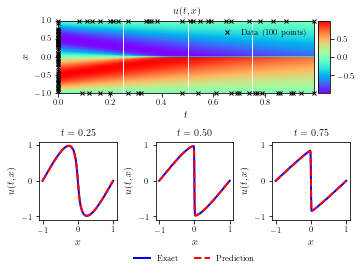

In [33]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf[:,0:1]
    t_star = X_star_tf[:,1:2]
    u_pred = net_u(x_star, t_star, w, b)
    return u_pred
    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     
U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)


fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

In [18]:
loss[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.25663102>

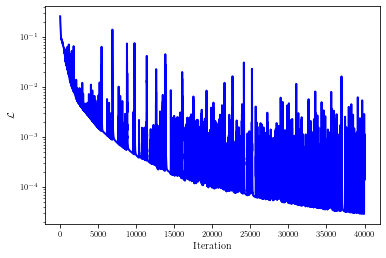

In [35]:
it = np.arange(0,40001, 1)
loss_list = [loss[i].numpy() for i in range(0,40001)]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact')       
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')    
plt.show()

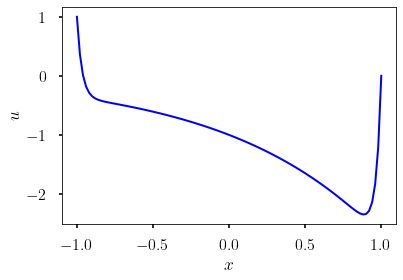

In [2]:
### Solution of Equation using Central Finite Difference Equation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline
matplotlib.rc('font', family='serif', serif='cm10')

matplotlib.rc('text', usetex=True)
### Number of Gridpoints
nu =1.0/10**-3
n = 100
h = (1+1) / n
x = np.linspace(-1,1,n+1)
# Difference Operator
A = np.zeros((n+1, n+1))

## Coefficient For Boundary Condition
A[0, 0] = 1
A[n, n] = 1

### Maric for Interior Point
for i in range(1, n):
    A[i, i-1] = 1
    A[i, i] = -(2 + (nu)*h**2)
    A[i, i+1] = 1

# Get b
b = np.zeros(n+1)
b = (np.exp(x))*h*h*(nu)

#### Imposition Boundary Condition 
b[0] = 1
b[-1] = 0
# solve the linear equations
y_act = np.linalg.solve(A, b)
### Plot of Equation
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.plot(x, y_act, "-", lw=2.0, color="b")
ax.set_xlabel('$x$')
ax.set_ylabel("$u$")
plt.show()

In [96]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss =  100.0*tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**3
noise = 0.0        
N_f = 300
Nmax=3000

layers = [1, 4,4,4,4,4,4, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 5e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0 and loss is: 36.536865234375
Iteration is: 1 and loss is: 32.31436538696289
Iteration is: 2 and loss is: 28.28046226501465
Iteration is: 3 and loss is: 24.432859420776367
Iteration is: 4 and loss is: 20.79062843322754
Iteration is: 5 and loss is: 17.39005470275879
Iteration is: 6 and loss is: 14.26872730255127
Iteration is: 7 and loss is: 11.459373474121094
Iteration is: 8 and loss is: 8.98551082611084
Iteration is: 9 and loss is: 6.85828161239624
Iteration is: 10 and loss is: 5.0749030113220215
Iteration is: 11 and loss is: 3.6195666790008545
Iteration is: 12 and loss is: 2.4678053855895996
Iteration is: 13 and loss is: 1.5934545993804932
Iteration is: 14 and loss is: 0.9745383262634277
Iteration is: 15 and loss is: 0.5949716567993164
Iteration is: 16 and loss is: 0.4408942461013794
Iteration is: 17 and loss is: 0.49178215861320496
Iteration is: 18 and loss is: 0.7089072465896606
Iteration is: 19 and loss is: 1.0280756950378418
Iteration is: 20 and loss is: 1.367208838

Iteration is: 189 and loss is: 0.07600313425064087
Iteration is: 190 and loss is: 0.07487782835960388
Iteration is: 191 and loss is: 0.07376721501350403
Iteration is: 192 and loss is: 0.07267120480537415
Iteration is: 193 and loss is: 0.0715896338224411
Iteration is: 194 and loss is: 0.07052222639322281
Iteration is: 195 and loss is: 0.06946875900030136
Iteration is: 196 and loss is: 0.06842923909425735
Iteration is: 197 and loss is: 0.0674034059047699
Iteration is: 198 and loss is: 0.06639134138822556
Iteration is: 199 and loss is: 0.06539285182952881
Iteration is: 200 and loss is: 0.06440774351358414
Iteration is: 201 and loss is: 0.06343603879213333
Iteration is: 202 and loss is: 0.06247763708233833
Iteration is: 203 and loss is: 0.06153232976794243
Iteration is: 204 and loss is: 0.06059994548559189
Iteration is: 205 and loss is: 0.05968046933412552
Iteration is: 206 and loss is: 0.05877351015806198
Iteration is: 207 and loss is: 0.05787919834256172
Iteration is: 208 and loss is: 0.

Iteration is: 387 and loss is: 0.009630278684198856
Iteration is: 388 and loss is: 0.00959133729338646
Iteration is: 389 and loss is: 0.009552774019539356
Iteration is: 390 and loss is: 0.00951451063156128
Iteration is: 391 and loss is: 0.009476574137806892
Iteration is: 392 and loss is: 0.00943894311785698
Iteration is: 393 and loss is: 0.009401625953614712
Iteration is: 394 and loss is: 0.009364627301692963
Iteration is: 395 and loss is: 0.00932791456580162
Iteration is: 396 and loss is: 0.009291480295360088
Iteration is: 397 and loss is: 0.009255343116819859
Iteration is: 398 and loss is: 0.009219483472406864
Iteration is: 399 and loss is: 0.009183919988572598
Iteration is: 400 and loss is: 0.009148613549768925
Iteration is: 401 and loss is: 0.009113563224673271
Iteration is: 402 and loss is: 0.009078794158995152
Iteration is: 403 and loss is: 0.009044284000992775
Iteration is: 404 and loss is: 0.00901002250611782
Iteration is: 405 and loss is: 0.008976016193628311
Iteration is: 406

Iteration is: 579 and loss is: 0.005261377431452274
Iteration is: 580 and loss is: 0.005247823428362608
Iteration is: 581 and loss is: 0.0052343374118208885
Iteration is: 582 and loss is: 0.005220897030085325
Iteration is: 583 and loss is: 0.005207512527704239
Iteration is: 584 and loss is: 0.005194184836000204
Iteration is: 585 and loss is: 0.005180913023650646
Iteration is: 586 and loss is: 0.005167696624994278
Iteration is: 587 and loss is: 0.005154538433998823
Iteration is: 588 and loss is: 0.005141428206115961
Iteration is: 589 and loss is: 0.005128375254571438
Iteration is: 590 and loss is: 0.005115382838994265
Iteration is: 591 and loss is: 0.005102428607642651
Iteration is: 592 and loss is: 0.00508953956887126
Iteration is: 593 and loss is: 0.005076690576970577
Iteration is: 594 and loss is: 0.005063896998763084
Iteration is: 595 and loss is: 0.00505116768181324
Iteration is: 596 and loss is: 0.005038474220782518
Iteration is: 597 and loss is: 0.005025842692703009
Iteration is:

Iteration is: 758 and loss is: 0.003495484823361039
Iteration is: 759 and loss is: 0.0034883394837379456
Iteration is: 760 and loss is: 0.0034812239464372396
Iteration is: 761 and loss is: 0.003474124474450946
Iteration is: 762 and loss is: 0.003467054106295109
Iteration is: 763 and loss is: 0.0034600007347762585
Iteration is: 764 and loss is: 0.0034529685508459806
Iteration is: 765 and loss is: 0.00344596104696393
Iteration is: 766 and loss is: 0.003438967978581786
Iteration is: 767 and loss is: 0.0034320016857236624
Iteration is: 768 and loss is: 0.0034250610042363405
Iteration is: 769 and loss is: 0.003418138949200511
Iteration is: 770 and loss is: 0.003411237383261323
Iteration is: 771 and loss is: 0.0034043516498059034
Iteration is: 772 and loss is: 0.0033974938560277224
Iteration is: 773 and loss is: 0.003390655620023608
Iteration is: 774 and loss is: 0.0033838392700999975
Iteration is: 775 and loss is: 0.003377031534910202
Iteration is: 776 and loss is: 0.0033702568616718054
Ite

Iteration is: 938 and loss is: 0.002492430154234171
Iteration is: 939 and loss is: 0.0024881146382540464
Iteration is: 940 and loss is: 0.0024838061071932316
Iteration is: 941 and loss is: 0.0024795085191726685
Iteration is: 942 and loss is: 0.0024752221070230007
Iteration is: 943 and loss is: 0.002470947103574872
Iteration is: 944 and loss is: 0.00246668653562665
Iteration is: 945 and loss is: 0.002462434582412243
Iteration is: 946 and loss is: 0.002458193339407444
Iteration is: 947 and loss is: 0.0024539607111364603
Iteration is: 948 and loss is: 0.002449741354212165
Iteration is: 949 and loss is: 0.002445533638820052
Iteration is: 950 and loss is: 0.002441328950226307
Iteration is: 951 and loss is: 0.0024371405597776175
Iteration is: 952 and loss is: 0.0024329619482159615
Iteration is: 953 and loss is: 0.0024287928827106953
Iteration is: 954 and loss is: 0.0024246361572295427
Iteration is: 955 and loss is: 0.0024204892106354237
Iteration is: 956 and loss is: 0.0024163550697267056
It

Iteration is: 1108 and loss is: 0.0020962378475815058
Iteration is: 1109 and loss is: 0.0018963818438351154
Iteration is: 1110 and loss is: 0.001987476833164692
Iteration is: 1111 and loss is: 0.0021998449228703976
Iteration is: 1112 and loss is: 0.0022808087524026632
Iteration is: 1113 and loss is: 0.0021560753230005503
Iteration is: 1114 and loss is: 0.001960586756467819
Iteration is: 1115 and loss is: 0.0018769977614283562
Iteration is: 1116 and loss is: 0.0019462167983874679
Iteration is: 1117 and loss is: 0.0020580552518367767
Iteration is: 1118 and loss is: 0.0020860934164375067
Iteration is: 1119 and loss is: 0.0020059708040207624
Iteration is: 1120 and loss is: 0.001901008770801127
Iteration is: 1121 and loss is: 0.0018610538681969047
Iteration is: 1122 and loss is: 0.001900105969980359
Iteration is: 1123 and loss is: 0.0019588114228099585
Iteration is: 1124 and loss is: 0.001972428523004055
Iteration is: 1125 and loss is: 0.0019300744170323014
Iteration is: 1126 and loss is: 0

Iteration is: 1276 and loss is: 0.0015509232180193067
Iteration is: 1277 and loss is: 0.0015226544346660376
Iteration is: 1278 and loss is: 0.0015069806249812245
Iteration is: 1279 and loss is: 0.0015140967443585396
Iteration is: 1280 and loss is: 0.0015280707739293575
Iteration is: 1281 and loss is: 0.0015291094314306974
Iteration is: 1282 and loss is: 0.0015149798709899187
Iteration is: 1283 and loss is: 0.001499784179031849
Iteration is: 1284 and loss is: 0.0014960019616410136
Iteration is: 1285 and loss is: 0.0015021878061816096
Iteration is: 1286 and loss is: 0.0015073223039507866
Iteration is: 1287 and loss is: 0.0015037136618047953
Iteration is: 1288 and loss is: 0.0014938721433281898
Iteration is: 1289 and loss is: 0.0014858981594443321
Iteration is: 1290 and loss is: 0.0014845605473965406
Iteration is: 1291 and loss is: 0.001487450092099607
Iteration is: 1292 and loss is: 0.0014887440484017134
Iteration is: 1293 and loss is: 0.0014853207394480705
Iteration is: 1294 and loss is

Iteration is: 1452 and loss is: 0.0012318051885813475
Iteration is: 1453 and loss is: 0.0012337942607700825
Iteration is: 1454 and loss is: 0.0012493145186454058
Iteration is: 1455 and loss is: 0.0012572782579809427
Iteration is: 1456 and loss is: 0.0012483212631195784
Iteration is: 1457 and loss is: 0.0012315487256273627
Iteration is: 1458 and loss is: 0.0012218279298394918
Iteration is: 1459 and loss is: 0.0012245047837495804
Iteration is: 1460 and loss is: 0.001232326845638454
Iteration is: 1461 and loss is: 0.0012348289601504803
Iteration is: 1462 and loss is: 0.0012286307755857706
Iteration is: 1463 and loss is: 0.0012189635308459401
Iteration is: 1464 and loss is: 0.0012132094707340002
Iteration is: 1465 and loss is: 0.0012138610472902656
Iteration is: 1466 and loss is: 0.0012173369759693742
Iteration is: 1467 and loss is: 0.0012183993821963668
Iteration is: 1468 and loss is: 0.0012149638496339321
Iteration is: 1469 and loss is: 0.0012092331890016794
Iteration is: 1470 and loss i

Iteration is: 1626 and loss is: 0.0010425201617181301
Iteration is: 1627 and loss is: 0.0010914470767602324
Iteration is: 1628 and loss is: 0.0011298994068056345
Iteration is: 1629 and loss is: 0.0011004026746377349
Iteration is: 1630 and loss is: 0.0010475795716047287
Iteration is: 1631 and loss is: 0.001039112452417612
Iteration is: 1632 and loss is: 0.0010714932577684522
Iteration is: 1633 and loss is: 0.0010888829128816724
Iteration is: 1634 and loss is: 0.0010663357097655535
Iteration is: 1635 and loss is: 0.001035577617585659
Iteration is: 1636 and loss is: 0.0010331074008718133
Iteration is: 1637 and loss is: 0.0010525251273065805
Iteration is: 1638 and loss is: 0.0010612523183226585
Iteration is: 1639 and loss is: 0.0010467593092471361
Iteration is: 1640 and loss is: 0.0010281240101903677
Iteration is: 1641 and loss is: 0.0010260897688567638
Iteration is: 1642 and loss is: 0.001037055510096252
Iteration is: 1643 and loss is: 0.001042420044541359
Iteration is: 1644 and loss is: 

Iteration is: 1800 and loss is: 0.0079507352784276
Iteration is: 1801 and loss is: 0.00797558669000864
Iteration is: 1802 and loss is: 0.004208423662930727
Iteration is: 1803 and loss is: 0.0011140159331262112
Iteration is: 1804 and loss is: 0.0016803736798465252
Iteration is: 1805 and loss is: 0.00420741643756628
Iteration is: 1806 and loss is: 0.0050538768991827965
Iteration is: 1807 and loss is: 0.0031497515738010406
Iteration is: 1808 and loss is: 0.0011165891773998737
Iteration is: 1809 and loss is: 0.0012699024518951774
Iteration is: 1810 and loss is: 0.0027904948219656944
Iteration is: 1811 and loss is: 0.0033128871582448483
Iteration is: 1812 and loss is: 0.0021559821907430887
Iteration is: 1813 and loss is: 0.0009841201826930046
Iteration is: 1814 and loss is: 0.001172538148239255
Iteration is: 1815 and loss is: 0.0020914357155561447
Iteration is: 1816 and loss is: 0.0022995765320956707
Iteration is: 1817 and loss is: 0.0015452010557055473
Iteration is: 1818 and loss is: 0.000

Iteration is: 1974 and loss is: 0.0007641458651050925
Iteration is: 1975 and loss is: 0.0007637751987203956
Iteration is: 1976 and loss is: 0.0007635874208062887
Iteration is: 1977 and loss is: 0.0007636912632733583
Iteration is: 1978 and loss is: 0.0007642620475962758
Iteration is: 1979 and loss is: 0.0007655887748114765
Iteration is: 1980 and loss is: 0.0007681517745368183
Iteration is: 1981 and loss is: 0.0007727494230493903
Iteration is: 1982 and loss is: 0.0007807861547917128
Iteration is: 1983 and loss is: 0.0007946340483613312
Iteration is: 1984 and loss is: 0.0008184691541828215
Iteration is: 1985 and loss is: 0.0008593230741098523
Iteration is: 1986 and loss is: 0.0009299636585637927
Iteration is: 1987 and loss is: 0.0010519210482016206
Iteration is: 1988 and loss is: 0.0012653119629248977
Iteration is: 1989 and loss is: 0.0016355435363948345
Iteration is: 1990 and loss is: 0.002285800874233246
Iteration is: 1991 and loss is: 0.003395896404981613
Iteration is: 1992 and loss is

Iteration is: 2153 and loss is: 0.0006834625382907689
Iteration is: 2154 and loss is: 0.0006828638142906129
Iteration is: 2155 and loss is: 0.0006822662544436753
Iteration is: 2156 and loss is: 0.0006816696259193122
Iteration is: 2157 and loss is: 0.0006810739869251847
Iteration is: 2158 and loss is: 0.0006804803851991892
Iteration is: 2159 and loss is: 0.0006798873073421419
Iteration is: 2160 and loss is: 0.0006792949861846864
Iteration is: 2161 and loss is: 0.0006787020829506218
Iteration is: 2162 and loss is: 0.0006781105767004192
Iteration is: 2163 and loss is: 0.0006775219808332622
Iteration is: 2164 and loss is: 0.0006769320461899042
Iteration is: 2165 and loss is: 0.0006763429846614599
Iteration is: 2166 and loss is: 0.0006757544470019639
Iteration is: 2167 and loss is: 0.0006751669570803642
Iteration is: 2168 and loss is: 0.0006745792925357819
Iteration is: 2169 and loss is: 0.0006739950622431934
Iteration is: 2170 and loss is: 0.0006734092603437603
Iteration is: 2171 and loss 

Iteration is: 2327 and loss is: 0.0006321118562482297
Iteration is: 2328 and loss is: 0.0006314675556495786
Iteration is: 2329 and loss is: 0.0006308745360001922
Iteration is: 2330 and loss is: 0.0006303591653704643
Iteration is: 2331 and loss is: 0.0006298850639723241
Iteration is: 2332 and loss is: 0.0006293922779150307
Iteration is: 2333 and loss is: 0.0006288500735536218
Iteration is: 2334 and loss is: 0.000628273410256952
Iteration is: 2335 and loss is: 0.0006277009379118681
Iteration is: 2336 and loss is: 0.000627166882622987
Iteration is: 2337 and loss is: 0.0006266627460718155
Iteration is: 2338 and loss is: 0.0006261614034883678
Iteration is: 2339 and loss is: 0.0006256443448364735
Iteration is: 2340 and loss is: 0.0006251056911423802
Iteration is: 2341 and loss is: 0.000624556269031018
Iteration is: 2342 and loss is: 0.000624016800429672
Iteration is: 2343 and loss is: 0.0006234926404431462
Iteration is: 2344 and loss is: 0.0006229833234101534
Iteration is: 2345 and loss is: 

Iteration is: 2496 and loss is: 0.0005985490861348808
Iteration is: 2497 and loss is: 0.0007025435916148126
Iteration is: 2498 and loss is: 0.0008378862403333187
Iteration is: 2499 and loss is: 0.0007928568520583212
Iteration is: 2500 and loss is: 0.00064616440795362
Iteration is: 2501 and loss is: 0.0006006400799378753
Iteration is: 2502 and loss is: 0.0006845479947514832
Iteration is: 2503 and loss is: 0.000747480196878314
Iteration is: 2504 and loss is: 0.000697161303833127
Iteration is: 2505 and loss is: 0.0006119465688243508
Iteration is: 2506 and loss is: 0.0006018973072059453
Iteration is: 2507 and loss is: 0.0006574355065822601
Iteration is: 2508 and loss is: 0.0006855642423033714
Iteration is: 2509 and loss is: 0.0006476172711700201
Iteration is: 2510 and loss is: 0.0005990792997181416
Iteration is: 2511 and loss is: 0.0005987138720229268
Iteration is: 2512 and loss is: 0.0006325930589810014
Iteration is: 2513 and loss is: 0.0006462773308157921
Iteration is: 2514 and loss is: 

Iteration is: 2671 and loss is: 0.0005197418504394591
Iteration is: 2672 and loss is: 0.0005193985416553915
Iteration is: 2673 and loss is: 0.0005190935917198658
Iteration is: 2674 and loss is: 0.0005188502836972475
Iteration is: 2675 and loss is: 0.0005187052302062511
Iteration is: 2676 and loss is: 0.0005187204224057496
Iteration is: 2677 and loss is: 0.0005190016236156225
Iteration is: 2678 and loss is: 0.0005197270656935871
Iteration is: 2679 and loss is: 0.0005211930838413537
Iteration is: 2680 and loss is: 0.0005239085876382887
Iteration is: 2681 and loss is: 0.0005287548410706222
Iteration is: 2682 and loss is: 0.0005372592713683844
Iteration is: 2683 and loss is: 0.0005521580460481346
Iteration is: 2684 and loss is: 0.0005781860090792179
Iteration is: 2685 and loss is: 0.0006239385693334043
Iteration is: 2686 and loss is: 0.00070444296579808
Iteration is: 2687 and loss is: 0.0008477212395519018
Iteration is: 2688 and loss is: 0.0011021662503480911
Iteration is: 2689 and loss is

Iteration is: 2849 and loss is: 0.000504239636939019
Iteration is: 2850 and loss is: 0.000503841380123049
Iteration is: 2851 and loss is: 0.0005034406785853207
Iteration is: 2852 and loss is: 0.0005030398606322706
Iteration is: 2853 and loss is: 0.0005026384606026113
Iteration is: 2854 and loss is: 0.0005022382247261703
Iteration is: 2855 and loss is: 0.0005018413648940623
Iteration is: 2856 and loss is: 0.0005014447961002588
Iteration is: 2857 and loss is: 0.0005010479944758117
Iteration is: 2858 and loss is: 0.0005006524734199047
Iteration is: 2859 and loss is: 0.0005002558464184403
Iteration is: 2860 and loss is: 0.0004998575313948095
Iteration is: 2861 and loss is: 0.0004994604387320578
Iteration is: 2862 and loss is: 0.0004990662564523518
Iteration is: 2863 and loss is: 0.0004986718413420022
Iteration is: 2864 and loss is: 0.0004982787650078535
Iteration is: 2865 and loss is: 0.0004978870274499059
Iteration is: 2866 and loss is: 0.0004974931362085044
Iteration is: 2867 and loss is

Error u: 1.933103e+01


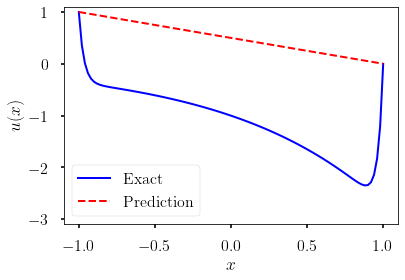

No handles with labels found to put in legend.


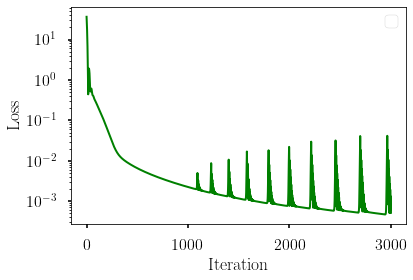

In [98]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list, 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()





In [108]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars_nn(W, b):
    return W + b

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def train_vars_sa(lambda_r, lambda_b):
    return lambda_r + lambda_b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b


#@tf.function(jit_compile=True)
@tf.function
def net_f(x, W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_fd(x, W, b, nu):
    h=0.1
    u_xx= (1/(h**2))*(net_u(x + h , W, b) - net_u(x, W, b) + net_u(x-h, W, b))
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_r, lambda_b):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,lambda_r,lambda_b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss_r = tf.square(lambda_r*f_nn)
        loss_b = tf.square(lambda_b*(u_nn-u_train_tf))
        loss =    tf.reduce_mean(loss_b) + tf.reduce_mean(loss_r)  
    grads = tape.gradient(loss, train_vars_nn(W, b))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    opt.apply_gradients(zip(grads, train_vars_nn(W,b)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
Nmax= 3000
N_f = 500
N_b = 2

layers = [1, 8, 8, 8,8,8,8, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

alpha_r, alpha_b = loss_weight(N_f, N_b)

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu, alpha_r, alpha_b)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


Iteration is: 0 and loss is: 2177501.0
Iteration is: 1 and loss is: 2144915.75
Iteration is: 2 and loss is: 2120281.5
Iteration is: 3 and loss is: 2095652.125
Iteration is: 4 and loss is: 2070088.375
Iteration is: 5 and loss is: 2043338.75
Iteration is: 6 and loss is: 2015364.0
Iteration is: 7 and loss is: 1986224.375
Iteration is: 8 and loss is: 1956035.5
Iteration is: 9 and loss is: 1924947.0
Iteration is: 10 and loss is: 1893129.125
Iteration is: 11 and loss is: 1860765.375
Iteration is: 12 and loss is: 1828046.75
Iteration is: 13 and loss is: 1795166.25
Iteration is: 14 and loss is: 1762318.875
Iteration is: 15 and loss is: 1729697.625
Iteration is: 16 and loss is: 1697492.625
Iteration is: 17 and loss is: 1665889.125
Iteration is: 18 and loss is: 1635065.25
Iteration is: 19 and loss is: 1605189.625
Iteration is: 20 and loss is: 1576418.625
Iteration is: 21 and loss is: 1548894.375
Iteration is: 22 and loss is: 1522740.625
Iteration is: 23 and loss is: 1498060.25
Iteration is: 24 a

Iteration is: 333 and loss is: 1286427.875
Iteration is: 334 and loss is: 1286988.125
Iteration is: 335 and loss is: 1287660.75
Iteration is: 336 and loss is: 1288377.0
Iteration is: 337 and loss is: 1289046.5
Iteration is: 338 and loss is: 1289658.125
Iteration is: 339 and loss is: 1290233.0
Iteration is: 340 and loss is: 1290816.5
Iteration is: 341 and loss is: 1291423.875
Iteration is: 342 and loss is: 1292057.0
Iteration is: 343 and loss is: 1292710.5
Iteration is: 344 and loss is: 1293384.0
Iteration is: 345 and loss is: 1294092.75
Iteration is: 346 and loss is: 1294877.25
Iteration is: 347 and loss is: 1295871.25
Iteration is: 348 and loss is: 1297324.25
Iteration is: 349 and loss is: 1299889.875
Iteration is: 350 and loss is: 1302745.875
Iteration is: 351 and loss is: 1304083.75
Iteration is: 352 and loss is: 1300213.75
Iteration is: 353 and loss is: 1299637.5
Iteration is: 354 and loss is: 1303376.25
Iteration is: 355 and loss is: 1303804.875
Iteration is: 356 and loss is: 1301

Iteration is: 674 and loss is: 649629.25
Iteration is: 675 and loss is: 642960.8125
Iteration is: 676 and loss is: 637192.8125
Iteration is: 677 and loss is: 632061.75
Iteration is: 678 and loss is: 627419.375
Iteration is: 679 and loss is: 622760.5
Iteration is: 680 and loss is: 617663.9375
Iteration is: 681 and loss is: 611050.9375
Iteration is: 682 and loss is: 603566.125
Iteration is: 683 and loss is: 596495.5625
Iteration is: 684 and loss is: 590894.6875
Iteration is: 685 and loss is: 586535.875
Iteration is: 686 and loss is: 582740.1875
Iteration is: 687 and loss is: 578963.5
Iteration is: 688 and loss is: 574225.1875
Iteration is: 689 and loss is: 568314.3125
Iteration is: 690 and loss is: 561490.0
Iteration is: 691 and loss is: 555216.9375
Iteration is: 692 and loss is: 550065.75
Iteration is: 693 and loss is: 545948.3125
Iteration is: 694 and loss is: 542529.875
Iteration is: 695 and loss is: 539394.0625
Iteration is: 696 and loss is: 536183.8125
Iteration is: 697 and loss is:

Iteration is: 1014 and loss is: 20111.5703125
Iteration is: 1015 and loss is: 20072.052734375
Iteration is: 1016 and loss is: 19882.009765625
Iteration is: 1017 and loss is: 19636.373046875
Iteration is: 1018 and loss is: 19383.392578125
Iteration is: 1019 and loss is: 19200.484375
Iteration is: 1020 and loss is: 19100.375
Iteration is: 1021 and loss is: 19056.48046875
Iteration is: 1022 and loss is: 19019.095703125
Iteration is: 1023 and loss is: 18939.41796875
Iteration is: 1024 and loss is: 18818.3671875
Iteration is: 1025 and loss is: 18654.9296875
Iteration is: 1026 and loss is: 18491.453125
Iteration is: 1027 and loss is: 18348.986328125
Iteration is: 1028 and loss is: 18238.892578125
Iteration is: 1029 and loss is: 18158.291015625
Iteration is: 1030 and loss is: 18088.552734375
Iteration is: 1031 and loss is: 18016.005859375
Iteration is: 1032 and loss is: 17925.03125
Iteration is: 1033 and loss is: 17818.955078125
Iteration is: 1034 and loss is: 17701.49609375
Iteration is: 103

Iteration is: 1353 and loss is: 5364.5595703125
Iteration is: 1354 and loss is: 5337.298828125
Iteration is: 1355 and loss is: 5313.09130859375
Iteration is: 1356 and loss is: 5293.5693359375
Iteration is: 1357 and loss is: 5278.341796875
Iteration is: 1358 and loss is: 5265.64208984375
Iteration is: 1359 and loss is: 5254.4296875
Iteration is: 1360 and loss is: 5243.00341796875
Iteration is: 1361 and loss is: 5230.04052734375
Iteration is: 1362 and loss is: 5215.0498046875
Iteration is: 1363 and loss is: 5198.216796875
Iteration is: 1364 and loss is: 5180.23046875
Iteration is: 1365 and loss is: 5161.57861328125
Iteration is: 1366 and loss is: 5142.7412109375
Iteration is: 1367 and loss is: 5125.08349609375
Iteration is: 1368 and loss is: 5108.193359375
Iteration is: 1369 and loss is: 5092.44287109375
Iteration is: 1370 and loss is: 5077.41064453125
Iteration is: 1371 and loss is: 5063.2294921875
Iteration is: 1372 and loss is: 5049.291015625
Iteration is: 1373 and loss is: 5035.38964

Iteration is: 1523 and loss is: 4058.015869140625
Iteration is: 1524 and loss is: 3771.23681640625
Iteration is: 1525 and loss is: 3573.8388671875
Iteration is: 1526 and loss is: 3425.248046875
Iteration is: 1527 and loss is: 3344.580810546875
Iteration is: 1528 and loss is: 3319.135986328125
Iteration is: 1529 and loss is: 3336.62060546875
Iteration is: 1530 and loss is: 3382.9052734375
Iteration is: 1531 and loss is: 3439.695068359375
Iteration is: 1532 and loss is: 3505.56201171875
Iteration is: 1533 and loss is: 3551.1171875
Iteration is: 1534 and loss is: 3601.30712890625
Iteration is: 1535 and loss is: 3610.9609375
Iteration is: 1536 and loss is: 3627.91357421875
Iteration is: 1537 and loss is: 3600.11474609375
Iteration is: 1538 and loss is: 3584.477294921875
Iteration is: 1539 and loss is: 3533.1962890625
Iteration is: 1540 and loss is: 3494.6328125
Iteration is: 1541 and loss is: 3435.446533203125
Iteration is: 1542 and loss is: 3389.019287109375
Iteration is: 1543 and loss is

Iteration is: 1693 and loss is: 2348.8603515625
Iteration is: 1694 and loss is: 2341.945068359375
Iteration is: 1695 and loss is: 2339.644287109375
Iteration is: 1696 and loss is: 2340.466552734375
Iteration is: 1697 and loss is: 2343.450439453125
Iteration is: 1698 and loss is: 2347.428955078125
Iteration is: 1699 and loss is: 2352.371337890625
Iteration is: 1700 and loss is: 2356.834716796875
Iteration is: 1701 and loss is: 2362.425537109375
Iteration is: 1702 and loss is: 2366.603271484375
Iteration is: 1703 and loss is: 2372.656494140625
Iteration is: 1704 and loss is: 2376.690673828125
Iteration is: 1705 and loss is: 2383.5029296875
Iteration is: 1706 and loss is: 2387.704833984375
Iteration is: 1707 and loss is: 2396.691162109375
Iteration is: 1708 and loss is: 2402.81298828125
Iteration is: 1709 and loss is: 2415.8271484375
Iteration is: 1710 and loss is: 2425.04541015625
Iteration is: 1711 and loss is: 2444.59912109375
Iteration is: 1712 and loss is: 2459.20068359375
Iteration 

Iteration is: 1865 and loss is: 2005.142333984375
Iteration is: 1866 and loss is: 2041.0673828125
Iteration is: 1867 and loss is: 2112.775634765625
Iteration is: 1868 and loss is: 2159.185546875
Iteration is: 1869 and loss is: 2260.65625
Iteration is: 1870 and loss is: 2300.386962890625
Iteration is: 1871 and loss is: 2411.58935546875
Iteration is: 1872 and loss is: 2409.63134765625
Iteration is: 1873 and loss is: 2478.770263671875
Iteration is: 1874 and loss is: 2412.226806640625
Iteration is: 1875 and loss is: 2407.62646484375
Iteration is: 1876 and loss is: 2323.35888671875
Iteration is: 1877 and loss is: 2312.319091796875
Iteration is: 1878 and loss is: 2302.42041015625
Iteration is: 1879 and loss is: 2404.710205078125
Iteration is: 1880 and loss is: 2517.82763671875
Iteration is: 1881 and loss is: 2789.180908203125
Iteration is: 1882 and loss is: 2998.061767578125
Iteration is: 1883 and loss is: 3419.91796875
Iteration is: 1884 and loss is: 3637.645263671875
Iteration is: 1885 and

Iteration is: 2037 and loss is: 1541.854736328125
Iteration is: 2038 and loss is: 1565.783203125
Iteration is: 2039 and loss is: 1591.596435546875
Iteration is: 2040 and loss is: 1600.906494140625
Iteration is: 2041 and loss is: 1613.16650390625
Iteration is: 2042 and loss is: 1607.18017578125
Iteration is: 2043 and loss is: 1607.1943359375
Iteration is: 2044 and loss is: 1595.09375
Iteration is: 2045 and loss is: 1592.2012939453125
Iteration is: 2046 and loss is: 1587.00439453125
Iteration is: 2047 and loss is: 1595.9964599609375
Iteration is: 2048 and loss is: 1610.94287109375
Iteration is: 2049 and loss is: 1649.892578125
Iteration is: 2050 and loss is: 1700.2001953125
Iteration is: 2051 and loss is: 1796.052734375
Iteration is: 2052 and loss is: 1903.90380859375
Iteration is: 2053 and loss is: 2103.396240234375
Iteration is: 2054 and loss is: 2301.736083984375
Iteration is: 2055 and loss is: 2690.572265625
Iteration is: 2056 and loss is: 3012.6474609375
Iteration is: 2057 and loss 

Iteration is: 2208 and loss is: 1301.487060546875
Iteration is: 2209 and loss is: 1298.4219970703125
Iteration is: 2210 and loss is: 1295.8326416015625
Iteration is: 2211 and loss is: 1290.5177001953125
Iteration is: 2212 and loss is: 1284.7548828125
Iteration is: 2213 and loss is: 1275.5506591796875
Iteration is: 2214 and loss is: 1265.2481689453125
Iteration is: 2215 and loss is: 1254.13916015625
Iteration is: 2216 and loss is: 1244.5408935546875
Iteration is: 2217 and loss is: 1237.725341796875
Iteration is: 2218 and loss is: 1234.33154296875
Iteration is: 2219 and loss is: 1234.22119140625
Iteration is: 2220 and loss is: 1236.241943359375
Iteration is: 2221 and loss is: 1239.08056640625
Iteration is: 2222 and loss is: 1241.499267578125
Iteration is: 2223 and loss is: 1242.8935546875
Iteration is: 2224 and loss is: 1242.940185546875
Iteration is: 2225 and loss is: 1242.302490234375
Iteration is: 2226 and loss is: 1241.0098876953125
Iteration is: 2227 and loss is: 1240.0345458984375


Iteration is: 2378 and loss is: 2160.992919921875
Iteration is: 2379 and loss is: 2502.18212890625
Iteration is: 2380 and loss is: 3202.915771484375
Iteration is: 2381 and loss is: 3730.673095703125
Iteration is: 2382 and loss is: 4971.10107421875
Iteration is: 2383 and loss is: 5477.87744140625
Iteration is: 2384 and loss is: 7103.29736328125
Iteration is: 2385 and loss is: 6834.91796875
Iteration is: 2386 and loss is: 7726.36181640625
Iteration is: 2387 and loss is: 6040.2333984375
Iteration is: 2388 and loss is: 5149.8310546875
Iteration is: 2389 and loss is: 3147.69775390625
Iteration is: 2390 and loss is: 1877.031005859375
Iteration is: 2391 and loss is: 1165.495849609375
Iteration is: 2392 and loss is: 1183.8414306640625
Iteration is: 2393 and loss is: 1732.615966796875
Iteration is: 2394 and loss is: 2394.10595703125
Iteration is: 2395 and loss is: 3112.642578125
Iteration is: 2396 and loss is: 3114.77685546875
Iteration is: 2397 and loss is: 3050.365234375
Iteration is: 2398 an

Iteration is: 2549 and loss is: 2298.02001953125
Iteration is: 2550 and loss is: 2616.4443359375
Iteration is: 2551 and loss is: 2668.9521484375
Iteration is: 2552 and loss is: 2998.75537109375
Iteration is: 2553 and loss is: 2923.1015625
Iteration is: 2554 and loss is: 3148.99365234375
Iteration is: 2555 and loss is: 2884.628173828125
Iteration is: 2556 and loss is: 2889.41357421875
Iteration is: 2557 and loss is: 2477.27978515625
Iteration is: 2558 and loss is: 2268.33935546875
Iteration is: 2559 and loss is: 1854.586669921875
Iteration is: 2560 and loss is: 1583.979248046875
Iteration is: 2561 and loss is: 1309.2979736328125
Iteration is: 2562 and loss is: 1142.785400390625
Iteration is: 2563 and loss is: 1049.58349609375
Iteration is: 2564 and loss is: 1037.4063720703125
Iteration is: 2565 and loss is: 1076.86083984375
Iteration is: 2566 and loss is: 1162.0103759765625
Iteration is: 2567 and loss is: 1254.7955322265625
Iteration is: 2568 and loss is: 1350.557373046875
Iteration is:

Iteration is: 2719 and loss is: 854.8587646484375
Iteration is: 2720 and loss is: 854.16064453125
Iteration is: 2721 and loss is: 853.4801025390625
Iteration is: 2722 and loss is: 852.8817749023438
Iteration is: 2723 and loss is: 852.3599853515625
Iteration is: 2724 and loss is: 851.94580078125
Iteration is: 2725 and loss is: 851.68017578125
Iteration is: 2726 and loss is: 851.5770874023438
Iteration is: 2727 and loss is: 851.6991577148438
Iteration is: 2728 and loss is: 852.0443725585938
Iteration is: 2729 and loss is: 852.7286376953125
Iteration is: 2730 and loss is: 853.7709350585938
Iteration is: 2731 and loss is: 855.4512939453125
Iteration is: 2732 and loss is: 857.8976440429688
Iteration is: 2733 and loss is: 861.7256469726562
Iteration is: 2734 and loss is: 867.1031494140625
Iteration is: 2735 and loss is: 875.45654296875
Iteration is: 2736 and loss is: 887.0443725585938
Iteration is: 2737 and loss is: 905.143310546875
Iteration is: 2738 and loss is: 929.8267822265625
Iteration

Iteration is: 2891 and loss is: 782.373779296875
Iteration is: 2892 and loss is: 842.8851318359375
Iteration is: 2893 and loss is: 925.3316650390625
Iteration is: 2894 and loss is: 1005.3287353515625
Iteration is: 2895 and loss is: 1033.8277587890625
Iteration is: 2896 and loss is: 1034.6300048828125
Iteration is: 2897 and loss is: 979.5593872070312
Iteration is: 2898 and loss is: 916.7985229492188
Iteration is: 2899 and loss is: 846.283935546875
Iteration is: 2900 and loss is: 795.181396484375
Iteration is: 2901 and loss is: 767.5363159179688
Iteration is: 2902 and loss is: 764.5186157226562
Iteration is: 2903 and loss is: 779.796142578125
Iteration is: 2904 and loss is: 803.76416015625
Iteration is: 2905 and loss is: 828.9024658203125
Iteration is: 2906 and loss is: 844.2557373046875
Iteration is: 2907 and loss is: 851.8831176757812
Iteration is: 2908 and loss is: 844.672119140625
Iteration is: 2909 and loss is: 831.9625854492188
Iteration is: 2910 and loss is: 811.6166381835938
Iter

Error u: 7.361192e+00


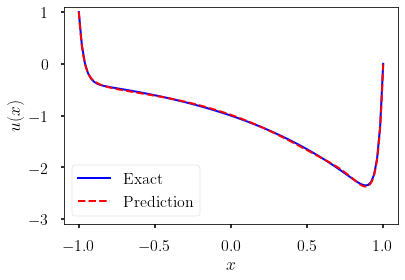

No handles with labels found to put in legend.


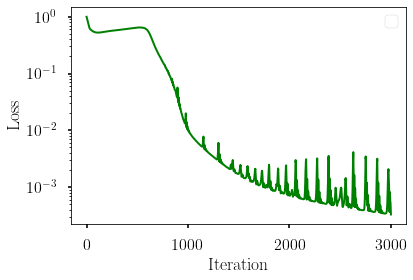

In [109]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list/(np.max(loss_list)), 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()



Iteration is: 0 and loss is: [871706.6]
Iteration is: 1 and loss is: [18.274786]
Iteration is: 2 and loss is: [9.62311]
Iteration is: 3 and loss is: [6.764636]
Iteration is: 4 and loss is: [5.348354]
Iteration is: 5 and loss is: [4.5067835]
Iteration is: 6 and loss is: [3.9515827]
Iteration is: 7 and loss is: [3.559522]
Iteration is: 8 and loss is: [3.2690904]
Iteration is: 9 and loss is: [3.0461984]
Iteration is: 10 and loss is: [2.870465]
Iteration is: 11 and loss is: [2.7289348]
Iteration is: 12 and loss is: [2.6129756]
Iteration is: 13 and loss is: [2.5166261]
Iteration is: 14 and loss is: [2.4356334]
Iteration is: 15 and loss is: [2.3668954]
Iteration is: 16 and loss is: [2.3080738]
Iteration is: 17 and loss is: [2.257378]
Iteration is: 18 and loss is: [2.2134166]
Iteration is: 19 and loss is: [2.1750846]
Iteration is: 20 and loss is: [2.141502]
Iteration is: 21 and loss is: [2.1119604]
Iteration is: 22 and loss is: [2.0858803]
Iteration is: 23 and loss is: [2.0627725]
Iteration i

Iteration is: 273 and loss is: [1.8565542]
Iteration is: 274 and loss is: [1.8565495]
Iteration is: 275 and loss is: [1.8565452]
Iteration is: 276 and loss is: [1.8565407]
Iteration is: 277 and loss is: [1.856536]
Iteration is: 278 and loss is: [1.8565317]
Iteration is: 279 and loss is: [1.8565271]
Iteration is: 280 and loss is: [1.8565227]
Iteration is: 281 and loss is: [1.8565181]
Iteration is: 282 and loss is: [1.8565136]
Iteration is: 283 and loss is: [1.8565091]
Iteration is: 284 and loss is: [1.8565047]
Iteration is: 285 and loss is: [1.8564999]
Iteration is: 286 and loss is: [1.8564956]
Iteration is: 287 and loss is: [1.856491]
Iteration is: 288 and loss is: [1.8564864]
Iteration is: 289 and loss is: [1.8564817]
Iteration is: 290 and loss is: [1.8564769]
Iteration is: 291 and loss is: [1.8564725]
Iteration is: 292 and loss is: [1.8564678]
Iteration is: 293 and loss is: [1.8564631]
Iteration is: 294 and loss is: [1.8564587]
Iteration is: 295 and loss is: [1.8564541]
Iteration is:

Iteration is: 551 and loss is: [1.8550314]
Iteration is: 552 and loss is: [1.8550249]
Iteration is: 553 and loss is: [1.8550184]
Iteration is: 554 and loss is: [1.8550116]
Iteration is: 555 and loss is: [1.855005]
Iteration is: 556 and loss is: [1.8549984]
Iteration is: 557 and loss is: [1.8549916]
Iteration is: 558 and loss is: [1.854985]
Iteration is: 559 and loss is: [1.8549782]
Iteration is: 560 and loss is: [1.8549716]
Iteration is: 561 and loss is: [1.854965]
Iteration is: 562 and loss is: [1.8549583]
Iteration is: 563 and loss is: [1.8549513]
Iteration is: 564 and loss is: [1.8549446]
Iteration is: 565 and loss is: [1.8549381]
Iteration is: 566 and loss is: [1.8549312]
Iteration is: 567 and loss is: [1.8549246]
Iteration is: 568 and loss is: [1.8549178]
Iteration is: 569 and loss is: [1.8549112]
Iteration is: 570 and loss is: [1.8549044]
Iteration is: 571 and loss is: [1.8548977]
Iteration is: 572 and loss is: [1.8548911]
Iteration is: 573 and loss is: [1.8548844]
Iteration is: 

Iteration is: 830 and loss is: [1.8529016]
Iteration is: 831 and loss is: [1.8528929]
Iteration is: 832 and loss is: [1.8528844]
Iteration is: 833 and loss is: [1.8528755]
Iteration is: 834 and loss is: [1.8528669]
Iteration is: 835 and loss is: [1.852858]
Iteration is: 836 and loss is: [1.8528494]
Iteration is: 837 and loss is: [1.8528405]
Iteration is: 838 and loss is: [1.8528317]
Iteration is: 839 and loss is: [1.852823]
Iteration is: 840 and loss is: [1.8528143]
Iteration is: 841 and loss is: [1.8528057]
Iteration is: 842 and loss is: [1.8527968]
Iteration is: 843 and loss is: [1.8527879]
Iteration is: 844 and loss is: [1.8527792]
Iteration is: 845 and loss is: [1.8527704]
Iteration is: 846 and loss is: [1.8527617]
Iteration is: 847 and loss is: [1.8527529]
Iteration is: 848 and loss is: [1.8527441]
Iteration is: 849 and loss is: [1.8527352]
Iteration is: 850 and loss is: [1.8527265]
Iteration is: 851 and loss is: [1.8527176]
Iteration is: 852 and loss is: [1.8527086]
Iteration is:

Iteration is: 1108 and loss is: [1.8501943]
Iteration is: 1109 and loss is: [1.8501836]
Iteration is: 1110 and loss is: [1.8501728]
Iteration is: 1111 and loss is: [1.8501618]
Iteration is: 1112 and loss is: [1.850151]
Iteration is: 1113 and loss is: [1.8501403]
Iteration is: 1114 and loss is: [1.8501295]
Iteration is: 1115 and loss is: [1.8501188]
Iteration is: 1116 and loss is: [1.8501078]
Iteration is: 1117 and loss is: [1.8500968]
Iteration is: 1118 and loss is: [1.850086]
Iteration is: 1119 and loss is: [1.8500748]
Iteration is: 1120 and loss is: [1.8500639]
Iteration is: 1121 and loss is: [1.8500528]
Iteration is: 1122 and loss is: [1.850042]
Iteration is: 1123 and loss is: [1.850031]
Iteration is: 1124 and loss is: [1.85002]
Iteration is: 1125 and loss is: [1.850009]
Iteration is: 1126 and loss is: [1.8499981]
Iteration is: 1127 and loss is: [1.849987]
Iteration is: 1128 and loss is: [1.8499761]
Iteration is: 1129 and loss is: [1.8499651]
Iteration is: 1130 and loss is: [1.84995

Iteration is: 1383 and loss is: [1.84689]
Iteration is: 1384 and loss is: [1.8468767]
Iteration is: 1385 and loss is: [1.8468633]
Iteration is: 1386 and loss is: [1.8468502]
Iteration is: 1387 and loss is: [1.8468368]
Iteration is: 1388 and loss is: [1.8468235]
Iteration is: 1389 and loss is: [1.8468103]
Iteration is: 1390 and loss is: [1.8467971]
Iteration is: 1391 and loss is: [1.8467836]
Iteration is: 1392 and loss is: [1.8467705]
Iteration is: 1393 and loss is: [1.8467572]
Iteration is: 1394 and loss is: [1.8467438]
Iteration is: 1395 and loss is: [1.8467307]
Iteration is: 1396 and loss is: [1.8467171]
Iteration is: 1397 and loss is: [1.8467036]
Iteration is: 1398 and loss is: [1.8466908]
Iteration is: 1399 and loss is: [1.8466772]
Iteration is: 1400 and loss is: [1.8466638]
Iteration is: 1401 and loss is: [1.8466505]
Iteration is: 1402 and loss is: [1.8466372]
Iteration is: 1403 and loss is: [1.8466239]
Iteration is: 1404 and loss is: [1.8466104]
Iteration is: 1405 and loss is: [1

Iteration is: 1661 and loss is: [1.8428639]
Iteration is: 1662 and loss is: [1.8428482]
Iteration is: 1663 and loss is: [1.8428323]
Iteration is: 1664 and loss is: [1.8428164]
Iteration is: 1665 and loss is: [1.8428006]
Iteration is: 1666 and loss is: [1.8427846]
Iteration is: 1667 and loss is: [1.8427689]
Iteration is: 1668 and loss is: [1.842753]
Iteration is: 1669 and loss is: [1.8427372]
Iteration is: 1670 and loss is: [1.8427213]
Iteration is: 1671 and loss is: [1.8427054]
Iteration is: 1672 and loss is: [1.8426896]
Iteration is: 1673 and loss is: [1.8426737]
Iteration is: 1674 and loss is: [1.8426578]
Iteration is: 1675 and loss is: [1.8426418]
Iteration is: 1676 and loss is: [1.8426259]
Iteration is: 1677 and loss is: [1.8426099]
Iteration is: 1678 and loss is: [1.842594]
Iteration is: 1679 and loss is: [1.8425782]
Iteration is: 1680 and loss is: [1.8425621]
Iteration is: 1681 and loss is: [1.8425463]
Iteration is: 1682 and loss is: [1.8425304]
Iteration is: 1683 and loss is: [1

Iteration is: 1935 and loss is: [1.8381613]
Iteration is: 1936 and loss is: [1.8381429]
Iteration is: 1937 and loss is: [1.838124]
Iteration is: 1938 and loss is: [1.8381051]
Iteration is: 1939 and loss is: [1.8380866]
Iteration is: 1940 and loss is: [1.8380679]
Iteration is: 1941 and loss is: [1.8380489]
Iteration is: 1942 and loss is: [1.8380303]
Iteration is: 1943 and loss is: [1.8380119]
Iteration is: 1944 and loss is: [1.8379931]
Iteration is: 1945 and loss is: [1.8379743]
Iteration is: 1946 and loss is: [1.8379557]
Iteration is: 1947 and loss is: [1.8379369]
Iteration is: 1948 and loss is: [1.8379179]
Iteration is: 1949 and loss is: [1.8378992]
Iteration is: 1950 and loss is: [1.8378805]
Iteration is: 1951 and loss is: [1.8378619]
Iteration is: 1952 and loss is: [1.8378427]
Iteration is: 1953 and loss is: [1.8378242]
Iteration is: 1954 and loss is: [1.8378053]
Iteration is: 1955 and loss is: [1.8377864]
Iteration is: 1956 and loss is: [1.8377675]
Iteration is: 1957 and loss is: [

Iteration is: 2216 and loss is: [1.832476]
Iteration is: 2217 and loss is: [1.8324542]
Iteration is: 2218 and loss is: [1.8324322]
Iteration is: 2219 and loss is: [1.8324105]
Iteration is: 2220 and loss is: [1.8323886]
Iteration is: 2221 and loss is: [1.8323666]
Iteration is: 2222 and loss is: [1.8323447]
Iteration is: 2223 and loss is: [1.8323226]
Iteration is: 2224 and loss is: [1.8323009]
Iteration is: 2225 and loss is: [1.8322786]
Iteration is: 2226 and loss is: [1.8322567]
Iteration is: 2227 and loss is: [1.8322346]
Iteration is: 2228 and loss is: [1.8322128]
Iteration is: 2229 and loss is: [1.8321909]
Iteration is: 2230 and loss is: [1.8321687]
Iteration is: 2231 and loss is: [1.8321464]
Iteration is: 2232 and loss is: [1.8321244]
Iteration is: 2233 and loss is: [1.8321021]
Iteration is: 2234 and loss is: [1.8320798]
Iteration is: 2235 and loss is: [1.8320575]
Iteration is: 2236 and loss is: [1.8320354]
Iteration is: 2237 and loss is: [1.8320132]
Iteration is: 2238 and loss is: [

Iteration is: 2504 and loss is: [1.8256385]
Iteration is: 2505 and loss is: [1.8256127]
Iteration is: 2506 and loss is: [1.8255872]
Iteration is: 2507 and loss is: [1.825561]
Iteration is: 2508 and loss is: [1.8255353]
Iteration is: 2509 and loss is: [1.8255095]
Iteration is: 2510 and loss is: [1.8254837]
Iteration is: 2511 and loss is: [1.8254579]
Iteration is: 2512 and loss is: [1.8254317]
Iteration is: 2513 and loss is: [1.8254061]
Iteration is: 2514 and loss is: [1.8253801]
Iteration is: 2515 and loss is: [1.825354]
Iteration is: 2516 and loss is: [1.8253284]
Iteration is: 2517 and loss is: [1.8253024]
Iteration is: 2518 and loss is: [1.8252766]
Iteration is: 2519 and loss is: [1.8252506]
Iteration is: 2520 and loss is: [1.8252246]
Iteration is: 2521 and loss is: [1.8251985]
Iteration is: 2522 and loss is: [1.8251728]
Iteration is: 2523 and loss is: [1.8251468]
Iteration is: 2524 and loss is: [1.8251208]
Iteration is: 2525 and loss is: [1.8250948]
Iteration is: 2526 and loss is: [1

Iteration is: 2779 and loss is: [1.8180143]
Iteration is: 2780 and loss is: [1.8179843]
Iteration is: 2781 and loss is: [1.8179543]
Iteration is: 2782 and loss is: [1.8179244]
Iteration is: 2783 and loss is: [1.8178946]
Iteration is: 2784 and loss is: [1.8178644]
Iteration is: 2785 and loss is: [1.8178346]
Iteration is: 2786 and loss is: [1.8178042]
Iteration is: 2787 and loss is: [1.8177745]
Iteration is: 2788 and loss is: [1.8177443]
Iteration is: 2789 and loss is: [1.8177143]
Iteration is: 2790 and loss is: [1.817684]
Iteration is: 2791 and loss is: [1.8176539]
Iteration is: 2792 and loss is: [1.817624]
Iteration is: 2793 and loss is: [1.8175937]
Iteration is: 2794 and loss is: [1.8175634]
Iteration is: 2795 and loss is: [1.8175335]
Iteration is: 2796 and loss is: [1.8175031]
Iteration is: 2797 and loss is: [1.8174728]
Iteration is: 2798 and loss is: [1.8174429]
Iteration is: 2799 and loss is: [1.8174127]
Iteration is: 2800 and loss is: [1.8173825]
Iteration is: 2801 and loss is: [1

Iteration is: 3054 and loss is: [1.8091569]
Iteration is: 3055 and loss is: [1.8091221]
Iteration is: 3056 and loss is: [1.8090876]
Iteration is: 3057 and loss is: [1.8090528]
Iteration is: 3058 and loss is: [1.8090179]
Iteration is: 3059 and loss is: [1.8089833]
Iteration is: 3060 and loss is: [1.8089484]
Iteration is: 3061 and loss is: [1.8089136]
Iteration is: 3062 and loss is: [1.8088788]
Iteration is: 3063 and loss is: [1.8088442]
Iteration is: 3064 and loss is: [1.8088093]
Iteration is: 3065 and loss is: [1.8087745]
Iteration is: 3066 and loss is: [1.8087393]
Iteration is: 3067 and loss is: [1.8087046]
Iteration is: 3068 and loss is: [1.8086696]
Iteration is: 3069 and loss is: [1.8086346]
Iteration is: 3070 and loss is: [1.8085997]
Iteration is: 3071 and loss is: [1.8085649]
Iteration is: 3072 and loss is: [1.8085299]
Iteration is: 3073 and loss is: [1.8084949]
Iteration is: 3074 and loss is: [1.8084596]
Iteration is: 3075 and loss is: [1.8084247]
Iteration is: 3076 and loss is: 

Iteration is: 3335 and loss is: [1.7986562]
Iteration is: 3336 and loss is: [1.798616]
Iteration is: 3337 and loss is: [1.7985756]
Iteration is: 3338 and loss is: [1.7985356]
Iteration is: 3339 and loss is: [1.7984953]
Iteration is: 3340 and loss is: [1.798455]
Iteration is: 3341 and loss is: [1.7984147]
Iteration is: 3342 and loss is: [1.7983747]
Iteration is: 3343 and loss is: [1.7983344]
Iteration is: 3344 and loss is: [1.798294]
Iteration is: 3345 and loss is: [1.7982538]
Iteration is: 3346 and loss is: [1.7982132]
Iteration is: 3347 and loss is: [1.7981728]
Iteration is: 3348 and loss is: [1.7981323]
Iteration is: 3349 and loss is: [1.7980919]
Iteration is: 3350 and loss is: [1.7980515]
Iteration is: 3351 and loss is: [1.7980111]
Iteration is: 3352 and loss is: [1.7979704]
Iteration is: 3353 and loss is: [1.79793]
Iteration is: 3354 and loss is: [1.7978894]
Iteration is: 3355 and loss is: [1.7978488]
Iteration is: 3356 and loss is: [1.7978082]
Iteration is: 3357 and loss is: [1.79

Iteration is: 3618 and loss is: [1.7863895]
Iteration is: 3619 and loss is: [1.7863429]
Iteration is: 3620 and loss is: [1.7862961]
Iteration is: 3621 and loss is: [1.7862494]
Iteration is: 3622 and loss is: [1.7862029]
Iteration is: 3623 and loss is: [1.7861564]
Iteration is: 3624 and loss is: [1.7861094]
Iteration is: 3625 and loss is: [1.7860628]
Iteration is: 3626 and loss is: [1.7860159]
Iteration is: 3627 and loss is: [1.7859691]
Iteration is: 3628 and loss is: [1.7859223]
Iteration is: 3629 and loss is: [1.7858754]
Iteration is: 3630 and loss is: [1.7858284]
Iteration is: 3631 and loss is: [1.7857816]
Iteration is: 3632 and loss is: [1.7857347]
Iteration is: 3633 and loss is: [1.7856877]
Iteration is: 3634 and loss is: [1.7856407]
Iteration is: 3635 and loss is: [1.7855939]
Iteration is: 3636 and loss is: [1.7855465]
Iteration is: 3637 and loss is: [1.7854996]
Iteration is: 3638 and loss is: [1.7854525]
Iteration is: 3639 and loss is: [1.7854054]
Iteration is: 3640 and loss is: 

Iteration is: 3898 and loss is: [1.7723244]
Iteration is: 3899 and loss is: [1.7722704]
Iteration is: 3900 and loss is: [1.7722166]
Iteration is: 3901 and loss is: [1.7721624]
Iteration is: 3902 and loss is: [1.7721082]
Iteration is: 3903 and loss is: [1.7720541]
Iteration is: 3904 and loss is: [1.7719997]
Iteration is: 3905 and loss is: [1.7719454]
Iteration is: 3906 and loss is: [1.7718914]
Iteration is: 3907 and loss is: [1.7718368]
Iteration is: 3908 and loss is: [1.7717824]
Iteration is: 3909 and loss is: [1.7717282]
Iteration is: 3910 and loss is: [1.7716738]
Iteration is: 3911 and loss is: [1.7716193]
Iteration is: 3912 and loss is: [1.7715647]
Iteration is: 3913 and loss is: [1.7715104]
Iteration is: 3914 and loss is: [1.7714558]
Iteration is: 3915 and loss is: [1.7714012]
Iteration is: 3916 and loss is: [1.7713467]
Iteration is: 3917 and loss is: [1.7712922]
Iteration is: 3918 and loss is: [1.7712375]
Iteration is: 3919 and loss is: [1.7711828]
Iteration is: 3920 and loss is: 

Iteration is: 4169 and loss is: [1.7566029]
Iteration is: 4170 and loss is: [1.7565404]
Iteration is: 4171 and loss is: [1.7564781]
Iteration is: 4172 and loss is: [1.7564157]
Iteration is: 4173 and loss is: [1.7563533]
Iteration is: 4174 and loss is: [1.7562908]
Iteration is: 4175 and loss is: [1.7562286]
Iteration is: 4176 and loss is: [1.756166]
Iteration is: 4177 and loss is: [1.7561035]
Iteration is: 4178 and loss is: [1.756041]
Iteration is: 4179 and loss is: [1.7559786]
Iteration is: 4180 and loss is: [1.7559161]
Iteration is: 4181 and loss is: [1.7558533]
Iteration is: 4182 and loss is: [1.7557908]
Iteration is: 4183 and loss is: [1.7557279]
Iteration is: 4184 and loss is: [1.7556652]
Iteration is: 4185 and loss is: [1.7556026]
Iteration is: 4186 and loss is: [1.7555398]
Iteration is: 4187 and loss is: [1.7554772]
Iteration is: 4188 and loss is: [1.7554146]
Iteration is: 4189 and loss is: [1.7553517]
Iteration is: 4190 and loss is: [1.755289]
Iteration is: 4191 and loss is: [1.

Iteration is: 4461 and loss is: [1.7369864]
Iteration is: 4462 and loss is: [1.7369152]
Iteration is: 4463 and loss is: [1.7368447]
Iteration is: 4464 and loss is: [1.736774]
Iteration is: 4465 and loss is: [1.7367032]
Iteration is: 4466 and loss is: [1.7366327]
Iteration is: 4467 and loss is: [1.7365619]
Iteration is: 4468 and loss is: [1.7364912]
Iteration is: 4469 and loss is: [1.7364208]
Iteration is: 4470 and loss is: [1.7363503]
Iteration is: 4471 and loss is: [1.7362798]
Iteration is: 4472 and loss is: [1.7362093]
Iteration is: 4473 and loss is: [1.7361388]
Iteration is: 4474 and loss is: [1.7360682]
Iteration is: 4475 and loss is: [1.7359974]
Iteration is: 4476 and loss is: [1.735927]
Iteration is: 4477 and loss is: [1.7358563]
Iteration is: 4478 and loss is: [1.7357856]
Iteration is: 4479 and loss is: [1.7357147]
Iteration is: 4480 and loss is: [1.7356441]
Iteration is: 4481 and loss is: [1.7355734]
Iteration is: 4482 and loss is: [1.7355024]
Iteration is: 4483 and loss is: [1

Iteration is: 4755 and loss is: [1.7147425]
Iteration is: 4756 and loss is: [1.7146608]
Iteration is: 4757 and loss is: [1.7145789]
Iteration is: 4758 and loss is: [1.714497]
Iteration is: 4759 and loss is: [1.714415]
Iteration is: 4760 and loss is: [1.714333]
Iteration is: 4761 and loss is: [1.7142512]
Iteration is: 4762 and loss is: [1.7141691]
Iteration is: 4763 and loss is: [1.7140869]
Iteration is: 4764 and loss is: [1.7140046]
Iteration is: 4765 and loss is: [1.7139225]
Iteration is: 4766 and loss is: [1.7138404]
Iteration is: 4767 and loss is: [1.7137583]
Iteration is: 4768 and loss is: [1.7136761]
Iteration is: 4769 and loss is: [1.7135936]
Iteration is: 4770 and loss is: [1.7135113]
Iteration is: 4771 and loss is: [1.7134289]
Iteration is: 4772 and loss is: [1.7133465]
Iteration is: 4773 and loss is: [1.713264]
Iteration is: 4774 and loss is: [1.7131816]
Iteration is: 4775 and loss is: [1.713099]
Iteration is: 4776 and loss is: [1.7130164]
Iteration is: 4777 and loss is: [1.71

Iteration is: 5043 and loss is: [1.6892985]
Iteration is: 5044 and loss is: [1.6892028]
Iteration is: 5045 and loss is: [1.6891075]
Iteration is: 5046 and loss is: [1.6890119]
Iteration is: 5047 and loss is: [1.6889167]
Iteration is: 5048 and loss is: [1.688821]
Iteration is: 5049 and loss is: [1.6887252]
Iteration is: 5050 and loss is: [1.6886296]
Iteration is: 5051 and loss is: [1.688534]
Iteration is: 5052 and loss is: [1.6884382]
Iteration is: 5053 and loss is: [1.6883423]
Iteration is: 5054 and loss is: [1.6882466]
Iteration is: 5055 and loss is: [1.6881506]
Iteration is: 5056 and loss is: [1.6880544]
Iteration is: 5057 and loss is: [1.6879586]
Iteration is: 5058 and loss is: [1.6878624]
Iteration is: 5059 and loss is: [1.6877662]
Iteration is: 5060 and loss is: [1.6876701]
Iteration is: 5061 and loss is: [1.6875738]
Iteration is: 5062 and loss is: [1.6874775]
Iteration is: 5063 and loss is: [1.6873813]
Iteration is: 5064 and loss is: [1.6872848]
Iteration is: 5065 and loss is: [1

Iteration is: 5320 and loss is: [1.6608018]
Iteration is: 5321 and loss is: [1.6606908]
Iteration is: 5322 and loss is: [1.6605799]
Iteration is: 5323 and loss is: [1.660469]
Iteration is: 5324 and loss is: [1.660358]
Iteration is: 5325 and loss is: [1.660247]
Iteration is: 5326 and loss is: [1.6601359]
Iteration is: 5327 and loss is: [1.6600248]
Iteration is: 5328 and loss is: [1.6599134]
Iteration is: 5329 and loss is: [1.659802]
Iteration is: 5330 and loss is: [1.6596909]
Iteration is: 5331 and loss is: [1.6595794]
Iteration is: 5332 and loss is: [1.6594678]
Iteration is: 5333 and loss is: [1.6593564]
Iteration is: 5334 and loss is: [1.6592447]
Iteration is: 5335 and loss is: [1.6591332]
Iteration is: 5336 and loss is: [1.6590214]
Iteration is: 5337 and loss is: [1.6589094]
Iteration is: 5338 and loss is: [1.6587977]
Iteration is: 5339 and loss is: [1.6586859]
Iteration is: 5340 and loss is: [1.6585739]
Iteration is: 5341 and loss is: [1.6584619]
Iteration is: 5342 and loss is: [1.6

Iteration is: 5594 and loss is: [1.6279322]
Iteration is: 5595 and loss is: [1.6278015]
Iteration is: 5596 and loss is: [1.6276709]
Iteration is: 5597 and loss is: [1.6275403]
Iteration is: 5598 and loss is: [1.6274095]
Iteration is: 5599 and loss is: [1.6272787]
Iteration is: 5600 and loss is: [1.6271477]
Iteration is: 5601 and loss is: [1.6270167]
Iteration is: 5602 and loss is: [1.6268855]
Iteration is: 5603 and loss is: [1.6267543]
Iteration is: 5604 and loss is: [1.6266229]
Iteration is: 5605 and loss is: [1.6264917]
Iteration is: 5606 and loss is: [1.6263599]
Iteration is: 5607 and loss is: [1.6262288]
Iteration is: 5608 and loss is: [1.6260973]
Iteration is: 5609 and loss is: [1.6259652]
Iteration is: 5610 and loss is: [1.6258337]
Iteration is: 5611 and loss is: [1.6257018]
Iteration is: 5612 and loss is: [1.6255702]
Iteration is: 5613 and loss is: [1.6254385]
Iteration is: 5614 and loss is: [1.6253062]
Iteration is: 5615 and loss is: [1.625174]
Iteration is: 5616 and loss is: [

Iteration is: 5866 and loss is: [1.5892873]
Iteration is: 5867 and loss is: [1.5891311]
Iteration is: 5868 and loss is: [1.5889747]
Iteration is: 5869 and loss is: [1.5888184]
Iteration is: 5870 and loss is: [1.5886618]
Iteration is: 5871 and loss is: [1.5885051]
Iteration is: 5872 and loss is: [1.5883485]
Iteration is: 5873 and loss is: [1.5881916]
Iteration is: 5874 and loss is: [1.5880347]
Iteration is: 5875 and loss is: [1.5878779]
Iteration is: 5876 and loss is: [1.587721]
Iteration is: 5877 and loss is: [1.5875638]
Iteration is: 5878 and loss is: [1.5874065]
Iteration is: 5879 and loss is: [1.5872492]
Iteration is: 5880 and loss is: [1.5870919]
Iteration is: 5881 and loss is: [1.5869343]
Iteration is: 5882 and loss is: [1.5867767]
Iteration is: 5883 and loss is: [1.5866191]
Iteration is: 5884 and loss is: [1.5864615]
Iteration is: 5885 and loss is: [1.586304]
Iteration is: 5886 and loss is: [1.586146]
Iteration is: 5887 and loss is: [1.585988]
Iteration is: 5888 and loss is: [1.5

Iteration is: 6135 and loss is: [1.5441133]
Iteration is: 6136 and loss is: [1.5439359]
Iteration is: 6137 and loss is: [1.5437585]
Iteration is: 6138 and loss is: [1.5435809]
Iteration is: 6139 and loss is: [1.5434033]
Iteration is: 6140 and loss is: [1.5432254]
Iteration is: 6141 and loss is: [1.5430475]
Iteration is: 6142 and loss is: [1.5428697]
Iteration is: 6143 and loss is: [1.5426917]
Iteration is: 6144 and loss is: [1.5425137]
Iteration is: 6145 and loss is: [1.5423354]
Iteration is: 6146 and loss is: [1.542157]
Iteration is: 6147 and loss is: [1.5419785]
Iteration is: 6148 and loss is: [1.5418]
Iteration is: 6149 and loss is: [1.5416212]
Iteration is: 6150 and loss is: [1.5414426]
Iteration is: 6151 and loss is: [1.5412637]
Iteration is: 6152 and loss is: [1.541085]
Iteration is: 6153 and loss is: [1.5409058]
Iteration is: 6154 and loss is: [1.5407267]
Iteration is: 6155 and loss is: [1.5405475]
Iteration is: 6156 and loss is: [1.540368]
Iteration is: 6157 and loss is: [1.540

Iteration is: 6408 and loss is: [1.4915774]
Iteration is: 6409 and loss is: [1.4913687]
Iteration is: 6410 and loss is: [1.4911597]
Iteration is: 6411 and loss is: [1.4909508]
Iteration is: 6412 and loss is: [1.4907415]
Iteration is: 6413 and loss is: [1.4905323]
Iteration is: 6414 and loss is: [1.4903228]
Iteration is: 6415 and loss is: [1.490113]
Iteration is: 6416 and loss is: [1.4899035]
Iteration is: 6417 and loss is: [1.4896935]
Iteration is: 6418 and loss is: [1.4894836]
Iteration is: 6419 and loss is: [1.4892734]
Iteration is: 6420 and loss is: [1.4890633]
Iteration is: 6421 and loss is: [1.488853]
Iteration is: 6422 and loss is: [1.4886423]
Iteration is: 6423 and loss is: [1.4884317]
Iteration is: 6424 and loss is: [1.488221]
Iteration is: 6425 and loss is: [1.4880103]
Iteration is: 6426 and loss is: [1.487799]
Iteration is: 6427 and loss is: [1.4875879]
Iteration is: 6428 and loss is: [1.4873766]
Iteration is: 6429 and loss is: [1.4871652]
Iteration is: 6430 and loss is: [1.4

Iteration is: 6673 and loss is: [1.4317272]
Iteration is: 6674 and loss is: [1.4314836]
Iteration is: 6675 and loss is: [1.43124]
Iteration is: 6676 and loss is: [1.430996]
Iteration is: 6677 and loss is: [1.4307518]
Iteration is: 6678 and loss is: [1.4305077]
Iteration is: 6679 and loss is: [1.430263]
Iteration is: 6680 and loss is: [1.4300188]
Iteration is: 6681 and loss is: [1.4297742]
Iteration is: 6682 and loss is: [1.4295293]
Iteration is: 6683 and loss is: [1.4292845]
Iteration is: 6684 and loss is: [1.4290395]
Iteration is: 6685 and loss is: [1.4287941]
Iteration is: 6686 and loss is: [1.4285487]
Iteration is: 6687 and loss is: [1.4283034]
Iteration is: 6688 and loss is: [1.4280578]
Iteration is: 6689 and loss is: [1.4278119]
Iteration is: 6690 and loss is: [1.4275659]
Iteration is: 6691 and loss is: [1.42732]
Iteration is: 6692 and loss is: [1.4270736]
Iteration is: 6693 and loss is: [1.4268275]
Iteration is: 6694 and loss is: [1.4265811]
Iteration is: 6695 and loss is: [1.426

Iteration is: 6939 and loss is: [1.3619094]
Iteration is: 6940 and loss is: [1.361631]
Iteration is: 6941 and loss is: [1.3613526]
Iteration is: 6942 and loss is: [1.3610737]
Iteration is: 6943 and loss is: [1.360795]
Iteration is: 6944 and loss is: [1.3605161]
Iteration is: 6945 and loss is: [1.3602368]
Iteration is: 6946 and loss is: [1.3599573]
Iteration is: 6947 and loss is: [1.3596781]
Iteration is: 6948 and loss is: [1.3593984]
Iteration is: 6949 and loss is: [1.3591187]
Iteration is: 6950 and loss is: [1.3588387]
Iteration is: 6951 and loss is: [1.3585588]
Iteration is: 6952 and loss is: [1.3582785]
Iteration is: 6953 and loss is: [1.3579981]
Iteration is: 6954 and loss is: [1.3577176]
Iteration is: 6955 and loss is: [1.3574376]
Iteration is: 6956 and loss is: [1.3571581]
Iteration is: 6957 and loss is: [1.356879]
Iteration is: 6958 and loss is: [1.3566006]
Iteration is: 6959 and loss is: [1.3563223]
Iteration is: 6960 and loss is: [1.3560445]
Iteration is: 6961 and loss is: [1.

Iteration is: 7206 and loss is: [1.2826711]
Iteration is: 7207 and loss is: [1.2823448]
Iteration is: 7208 and loss is: [1.2820182]
Iteration is: 7209 and loss is: [1.2816913]
Iteration is: 7210 and loss is: [1.2813646]
Iteration is: 7211 and loss is: [1.2810374]
Iteration is: 7212 and loss is: [1.2807101]
Iteration is: 7213 and loss is: [1.2803825]
Iteration is: 7214 and loss is: [1.2800547]
Iteration is: 7215 and loss is: [1.2797267]
Iteration is: 7216 and loss is: [1.2793986]
Iteration is: 7217 and loss is: [1.2790701]
Iteration is: 7218 and loss is: [1.2787415]
Iteration is: 7219 and loss is: [1.2784128]
Iteration is: 7220 and loss is: [1.2780839]
Iteration is: 7221 and loss is: [1.2777548]
Iteration is: 7222 and loss is: [1.2774255]
Iteration is: 7223 and loss is: [1.2770959]
Iteration is: 7224 and loss is: [1.2767661]
Iteration is: 7225 and loss is: [1.276436]
Iteration is: 7226 and loss is: [1.2761056]
Iteration is: 7227 and loss is: [1.2757748]
Iteration is: 7228 and loss is: [

Iteration is: 7476 and loss is: [1.1880442]
Iteration is: 7477 and loss is: [1.1876734]
Iteration is: 7478 and loss is: [1.1873022]
Iteration is: 7479 and loss is: [1.1869309]
Iteration is: 7480 and loss is: [1.1865591]
Iteration is: 7481 and loss is: [1.186187]
Iteration is: 7482 and loss is: [1.1858147]
Iteration is: 7483 and loss is: [1.1854423]
Iteration is: 7484 and loss is: [1.1850696]
Iteration is: 7485 and loss is: [1.1846966]
Iteration is: 7486 and loss is: [1.1843232]
Iteration is: 7487 and loss is: [1.1839498]
Iteration is: 7488 and loss is: [1.1835762]
Iteration is: 7489 and loss is: [1.183202]
Iteration is: 7490 and loss is: [1.182828]
Iteration is: 7491 and loss is: [1.1824534]
Iteration is: 7492 and loss is: [1.1820785]
Iteration is: 7493 and loss is: [1.1817039]
Iteration is: 7494 and loss is: [1.1813289]
Iteration is: 7495 and loss is: [1.1809536]
Iteration is: 7496 and loss is: [1.1805785]
Iteration is: 7497 and loss is: [1.1802027]
Iteration is: 7498 and loss is: [1.

Iteration is: 7742 and loss is: [1.0834062]
Iteration is: 7743 and loss is: [1.0829896]
Iteration is: 7744 and loss is: [1.082573]
Iteration is: 7745 and loss is: [1.0821564]
Iteration is: 7746 and loss is: [1.0817391]
Iteration is: 7747 and loss is: [1.0813218]
Iteration is: 7748 and loss is: [1.080904]
Iteration is: 7749 and loss is: [1.0804863]
Iteration is: 7750 and loss is: [1.0800683]
Iteration is: 7751 and loss is: [1.0796499]
Iteration is: 7752 and loss is: [1.0792315]
Iteration is: 7753 and loss is: [1.0788126]
Iteration is: 7754 and loss is: [1.0783935]
Iteration is: 7755 and loss is: [1.0779742]
Iteration is: 7756 and loss is: [1.0775547]
Iteration is: 7757 and loss is: [1.077135]
Iteration is: 7758 and loss is: [1.0767148]
Iteration is: 7759 and loss is: [1.0762945]
Iteration is: 7760 and loss is: [1.0758741]
Iteration is: 7761 and loss is: [1.0754534]
Iteration is: 7762 and loss is: [1.0750324]
Iteration is: 7763 and loss is: [1.074611]
Iteration is: 7764 and loss is: [1.0

Iteration is: 8004 and loss is: [0.9661454]
Iteration is: 8005 and loss is: [0.96568286]
Iteration is: 8006 and loss is: [0.9652205]
Iteration is: 8007 and loss is: [0.96475786]
Iteration is: 8008 and loss is: [0.9642951]
Iteration is: 8009 and loss is: [0.9638321]
Iteration is: 8010 and loss is: [0.9633691]
Iteration is: 8011 and loss is: [0.9629058]
Iteration is: 8012 and loss is: [0.9624423]
Iteration is: 8013 and loss is: [0.96197885]
Iteration is: 8014 and loss is: [0.96151507]
Iteration is: 8015 and loss is: [0.96105117]
Iteration is: 8016 and loss is: [0.9605872]
Iteration is: 8017 and loss is: [0.960123]
Iteration is: 8018 and loss is: [0.9596587]
Iteration is: 8019 and loss is: [0.9591941]
Iteration is: 8020 and loss is: [0.9587295]
Iteration is: 8021 and loss is: [0.95826465]
Iteration is: 8022 and loss is: [0.95779973]
Iteration is: 8023 and loss is: [0.9573347]
Iteration is: 8024 and loss is: [0.95686936]
Iteration is: 8025 and loss is: [0.9564039]
Iteration is: 8026 and lo

Iteration is: 8273 and loss is: [0.83791983]
Iteration is: 8274 and loss is: [0.8374234]
Iteration is: 8275 and loss is: [0.8369269]
Iteration is: 8276 and loss is: [0.83643025]
Iteration is: 8277 and loss is: [0.83593386]
Iteration is: 8278 and loss is: [0.83543754]
Iteration is: 8279 and loss is: [0.8349412]
Iteration is: 8280 and loss is: [0.83444494]
Iteration is: 8281 and loss is: [0.8339486]
Iteration is: 8282 and loss is: [0.8334524]
Iteration is: 8283 and loss is: [0.8329562]
Iteration is: 8284 and loss is: [0.83246005]
Iteration is: 8285 and loss is: [0.8319637]
Iteration is: 8286 and loss is: [0.83146745]
Iteration is: 8287 and loss is: [0.8309711]
Iteration is: 8288 and loss is: [0.83047485]
Iteration is: 8289 and loss is: [0.8299785]
Iteration is: 8290 and loss is: [0.8294822]
Iteration is: 8291 and loss is: [0.8289856]
Iteration is: 8292 and loss is: [0.8284892]
Iteration is: 8293 and loss is: [0.82799274]
Iteration is: 8294 and loss is: [0.8274961]
Iteration is: 8295 and 

Iteration is: 8533 and loss is: [0.7101441]
Iteration is: 8534 and loss is: [0.709667]
Iteration is: 8535 and loss is: [0.70919]
Iteration is: 8536 and loss is: [0.7087133]
Iteration is: 8537 and loss is: [0.7082365]
Iteration is: 8538 and loss is: [0.70776]
Iteration is: 8539 and loss is: [0.7072835]
Iteration is: 8540 and loss is: [0.70680714]
Iteration is: 8541 and loss is: [0.7063309]
Iteration is: 8542 and loss is: [0.70585483]
Iteration is: 8543 and loss is: [0.70537907]
Iteration is: 8544 and loss is: [0.70490366]
Iteration is: 8545 and loss is: [0.70442843]
Iteration is: 8546 and loss is: [0.70395344]
Iteration is: 8547 and loss is: [0.7034785]
Iteration is: 8548 and loss is: [0.70300394]
Iteration is: 8549 and loss is: [0.7025294]
Iteration is: 8550 and loss is: [0.7020551]
Iteration is: 8551 and loss is: [0.70158076]
Iteration is: 8552 and loss is: [0.7011067]
Iteration is: 8553 and loss is: [0.7006328]
Iteration is: 8554 and loss is: [0.70015895]
Iteration is: 8555 and loss 

Iteration is: 8798 and loss is: [0.59800094]
Iteration is: 8799 and loss is: [0.5976792]
Iteration is: 8800 and loss is: [0.59735894]
Iteration is: 8801 and loss is: [0.59704]
Iteration is: 8802 and loss is: [0.59672236]
Iteration is: 8803 and loss is: [0.59640604]
Iteration is: 8804 and loss is: [0.5960906]
Iteration is: 8805 and loss is: [0.59577614]
Iteration is: 8806 and loss is: [0.5954627]
Iteration is: 8807 and loss is: [0.5951499]
Iteration is: 8808 and loss is: [0.5948378]
Iteration is: 8809 and loss is: [0.5945265]
Iteration is: 8810 and loss is: [0.5942158]
Iteration is: 8811 and loss is: [0.5939055]
Iteration is: 8812 and loss is: [0.59359586]
Iteration is: 8813 and loss is: [0.59328663]
Iteration is: 8814 and loss is: [0.59297776]
Iteration is: 8815 and loss is: [0.5926695]
Iteration is: 8816 and loss is: [0.5923614]
Iteration is: 8817 and loss is: [0.5920536]
Iteration is: 8818 and loss is: [0.59174633]
Iteration is: 8819 and loss is: [0.5914392]
Iteration is: 8820 and lo

Iteration is: 9055 and loss is: [0.53282464]
Iteration is: 9056 and loss is: [0.5326609]
Iteration is: 9057 and loss is: [0.53249747]
Iteration is: 9058 and loss is: [0.53233427]
Iteration is: 9059 and loss is: [0.5321713]
Iteration is: 9060 and loss is: [0.53200847]
Iteration is: 9061 and loss is: [0.53184587]
Iteration is: 9062 and loss is: [0.5316833]
Iteration is: 9063 and loss is: [0.5315212]
Iteration is: 9064 and loss is: [0.531359]
Iteration is: 9065 and loss is: [0.53119844]
Iteration is: 9066 and loss is: [0.5310394]
Iteration is: 9067 and loss is: [0.53088194]
Iteration is: 9068 and loss is: [0.530726]
Iteration is: 9069 and loss is: [0.5305712]
Iteration is: 9070 and loss is: [0.53041756]
Iteration is: 9071 and loss is: [0.5302659]
Iteration is: 9072 and loss is: [0.5301168]
Iteration is: 9073 and loss is: [0.52996963]
Iteration is: 9074 and loss is: [0.5298243]
Iteration is: 9075 and loss is: [0.5296808]
Iteration is: 9076 and loss is: [0.5295387]
Iteration is: 9077 and lo

Iteration is: 9328 and loss is: [0.5123756]
Iteration is: 9329 and loss is: [0.51237756]
Iteration is: 9330 and loss is: [0.5123798]
Iteration is: 9331 and loss is: [0.51238245]
Iteration is: 9332 and loss is: [0.5123853]
Iteration is: 9333 and loss is: [0.5123884]
Iteration is: 9334 and loss is: [0.5123917]
Iteration is: 9335 and loss is: [0.5123953]
Iteration is: 9336 and loss is: [0.51239944]
Iteration is: 9337 and loss is: [0.5124041]
Iteration is: 9338 and loss is: [0.5124091]
Iteration is: 9339 and loss is: [0.5124145]
Iteration is: 9340 and loss is: [0.5124201]
Iteration is: 9341 and loss is: [0.51242596]
Iteration is: 9342 and loss is: [0.51243204]
Iteration is: 9343 and loss is: [0.5124383]
Iteration is: 9344 and loss is: [0.5124446]
Iteration is: 9345 and loss is: [0.51245105]
Iteration is: 9346 and loss is: [0.5124577]
Iteration is: 9347 and loss is: [0.5124643]
Iteration is: 9348 and loss is: [0.5124709]
Iteration is: 9349 and loss is: [0.51247776]
Iteration is: 9350 and lo

Iteration is: 9600 and loss is: [0.5156916]
Iteration is: 9601 and loss is: [0.51572174]
Iteration is: 9602 and loss is: [0.5157528]
Iteration is: 9603 and loss is: [0.5157844]
Iteration is: 9604 and loss is: [0.5158167]
Iteration is: 9605 and loss is: [0.51584965]
Iteration is: 9606 and loss is: [0.51588297]
Iteration is: 9607 and loss is: [0.5159169]
Iteration is: 9608 and loss is: [0.51595134]
Iteration is: 9609 and loss is: [0.5159861]
Iteration is: 9610 and loss is: [0.51602113]
Iteration is: 9611 and loss is: [0.5160565]
Iteration is: 9612 and loss is: [0.516092]
Iteration is: 9613 and loss is: [0.51612777]
Iteration is: 9614 and loss is: [0.51616377]
Iteration is: 9615 and loss is: [0.51619977]
Iteration is: 9616 and loss is: [0.51623595]
Iteration is: 9617 and loss is: [0.5162721]
Iteration is: 9618 and loss is: [0.51630825]
Iteration is: 9619 and loss is: [0.5163445]
Iteration is: 9620 and loss is: [0.5163807]
Iteration is: 9621 and loss is: [0.51641685]
Iteration is: 9622 and

Iteration is: 9873 and loss is: [0.52613884]
Iteration is: 9874 and loss is: [0.52616906]
Iteration is: 9875 and loss is: [0.52619904]
Iteration is: 9876 and loss is: [0.526229]
Iteration is: 9877 and loss is: [0.52625895]
Iteration is: 9878 and loss is: [0.52628857]
Iteration is: 9879 and loss is: [0.5263181]
Iteration is: 9880 and loss is: [0.52634746]
Iteration is: 9881 and loss is: [0.5263767]
Iteration is: 9882 and loss is: [0.5264057]
Iteration is: 9883 and loss is: [0.52643466]
Iteration is: 9884 and loss is: [0.52646345]
Iteration is: 9885 and loss is: [0.5264922]
Iteration is: 9886 and loss is: [0.5265207]
Iteration is: 9887 and loss is: [0.526549]
Iteration is: 9888 and loss is: [0.5265772]
Iteration is: 9889 and loss is: [0.5266052]
Iteration is: 9890 and loss is: [0.526633]
Iteration is: 9891 and loss is: [0.5266608]
Iteration is: 9892 and loss is: [0.5266886]
Iteration is: 9893 and loss is: [0.5267162]
Iteration is: 9894 and loss is: [0.5267436]
Iteration is: 9895 and loss

Iteration is: 10148 and loss is: [0.54274637]
Iteration is: 10149 and loss is: [0.5428233]
Iteration is: 10150 and loss is: [0.54290015]
Iteration is: 10151 and loss is: [0.54297704]
Iteration is: 10152 and loss is: [0.5430536]
Iteration is: 10153 and loss is: [0.5431303]
Iteration is: 10154 and loss is: [0.543207]
Iteration is: 10155 and loss is: [0.54328364]
Iteration is: 10156 and loss is: [0.5433603]
Iteration is: 10157 and loss is: [0.5434367]
Iteration is: 10158 and loss is: [0.5435133]
Iteration is: 10159 and loss is: [0.5435896]
Iteration is: 10160 and loss is: [0.5436659]
Iteration is: 10161 and loss is: [0.543742]
Iteration is: 10162 and loss is: [0.543818]
Iteration is: 10163 and loss is: [0.5438938]
Iteration is: 10164 and loss is: [0.5439696]
Iteration is: 10165 and loss is: [0.5440453]
Iteration is: 10166 and loss is: [0.5441208]
Iteration is: 10167 and loss is: [0.54419625]
Iteration is: 10168 and loss is: [0.5442714]
Iteration is: 10169 and loss is: [0.54434645]
Iterati

Iteration is: 10414 and loss is: [0.5583729]
Iteration is: 10415 and loss is: [0.55841094]
Iteration is: 10416 and loss is: [0.5584488]
Iteration is: 10417 and loss is: [0.5584865]
Iteration is: 10418 and loss is: [0.55852395]
Iteration is: 10419 and loss is: [0.5585614]
Iteration is: 10420 and loss is: [0.5585985]
Iteration is: 10421 and loss is: [0.5586355]
Iteration is: 10422 and loss is: [0.55867237]
Iteration is: 10423 and loss is: [0.55870914]
Iteration is: 10424 and loss is: [0.55874544]
Iteration is: 10425 and loss is: [0.55878174]
Iteration is: 10426 and loss is: [0.558818]
Iteration is: 10427 and loss is: [0.5588539]
Iteration is: 10428 and loss is: [0.5588899]
Iteration is: 10429 and loss is: [0.5589255]
Iteration is: 10430 and loss is: [0.5589609]
Iteration is: 10431 and loss is: [0.5589963]
Iteration is: 10432 and loss is: [0.5590314]
Iteration is: 10433 and loss is: [0.5590664]
Iteration is: 10434 and loss is: [0.5591012]
Iteration is: 10435 and loss is: [0.55913603]
Iter

Iteration is: 10676 and loss is: [0.5631963]
Iteration is: 10677 and loss is: [0.563196]
Iteration is: 10678 and loss is: [0.56319577]
Iteration is: 10679 and loss is: [0.56319535]
Iteration is: 10680 and loss is: [0.56319475]
Iteration is: 10681 and loss is: [0.56319404]
Iteration is: 10682 and loss is: [0.56319267]
Iteration is: 10683 and loss is: [0.56319076]
Iteration is: 10684 and loss is: [0.56318825]
Iteration is: 10685 and loss is: [0.56318516]
Iteration is: 10686 and loss is: [0.5631816]
Iteration is: 10687 and loss is: [0.5631775]
Iteration is: 10688 and loss is: [0.5631732]
Iteration is: 10689 and loss is: [0.5631683]
Iteration is: 10690 and loss is: [0.56316304]
Iteration is: 10691 and loss is: [0.5631575]
Iteration is: 10692 and loss is: [0.56315166]
Iteration is: 10693 and loss is: [0.56314546]
Iteration is: 10694 and loss is: [0.5631391]
Iteration is: 10695 and loss is: [0.56313235]
Iteration is: 10696 and loss is: [0.5631254]
Iteration is: 10697 and loss is: [0.5631181]

Iteration is: 10948 and loss is: [0.5564208]
Iteration is: 10949 and loss is: [0.5563768]
Iteration is: 10950 and loss is: [0.55633247]
Iteration is: 10951 and loss is: [0.55628824]
Iteration is: 10952 and loss is: [0.55624384]
Iteration is: 10953 and loss is: [0.55619913]
Iteration is: 10954 and loss is: [0.5561545]
Iteration is: 10955 and loss is: [0.55610967]
Iteration is: 10956 and loss is: [0.5560647]
Iteration is: 10957 and loss is: [0.55601966]
Iteration is: 10958 and loss is: [0.5559745]
Iteration is: 10959 and loss is: [0.5559293]
Iteration is: 10960 and loss is: [0.5558841]
Iteration is: 10961 and loss is: [0.55583894]
Iteration is: 10962 and loss is: [0.5557937]
Iteration is: 10963 and loss is: [0.5557484]
Iteration is: 10964 and loss is: [0.555703]
Iteration is: 10965 and loss is: [0.5556576]
Iteration is: 10966 and loss is: [0.5556121]
Iteration is: 10967 and loss is: [0.55556655]
Iteration is: 10968 and loss is: [0.55552083]
Iteration is: 10969 and loss is: [0.55547494]
I

Iteration is: 11221 and loss is: [0.5409346]
Iteration is: 11222 and loss is: [0.5408708]
Iteration is: 11223 and loss is: [0.54080683]
Iteration is: 11224 and loss is: [0.54074275]
Iteration is: 11225 and loss is: [0.5406786]
Iteration is: 11226 and loss is: [0.54061455]
Iteration is: 11227 and loss is: [0.5405501]
Iteration is: 11228 and loss is: [0.54048574]
Iteration is: 11229 and loss is: [0.5404213]
Iteration is: 11230 and loss is: [0.54035664]
Iteration is: 11231 and loss is: [0.540292]
Iteration is: 11232 and loss is: [0.54022723]
Iteration is: 11233 and loss is: [0.5401623]
Iteration is: 11234 and loss is: [0.5400973]
Iteration is: 11235 and loss is: [0.54003227]
Iteration is: 11236 and loss is: [0.53996706]
Iteration is: 11237 and loss is: [0.5399018]
Iteration is: 11238 and loss is: [0.53983635]
Iteration is: 11239 and loss is: [0.53977084]
Iteration is: 11240 and loss is: [0.53970534]
Iteration is: 11241 and loss is: [0.5396396]
Iteration is: 11242 and loss is: [0.5395738]


Iteration is: 11490 and loss is: [0.52020454]
Iteration is: 11491 and loss is: [0.5201147]
Iteration is: 11492 and loss is: [0.5200249]
Iteration is: 11493 and loss is: [0.519935]
Iteration is: 11494 and loss is: [0.5198451]
Iteration is: 11495 and loss is: [0.51975495]
Iteration is: 11496 and loss is: [0.5196648]
Iteration is: 11497 and loss is: [0.51957464]
Iteration is: 11498 and loss is: [0.51948434]
Iteration is: 11499 and loss is: [0.51939386]
Iteration is: 11500 and loss is: [0.51930344]
Iteration is: 11501 and loss is: [0.5192128]
Iteration is: 11502 and loss is: [0.5191222]
Iteration is: 11503 and loss is: [0.5190313]
Iteration is: 11504 and loss is: [0.5189405]
Iteration is: 11505 and loss is: [0.51884943]
Iteration is: 11506 and loss is: [0.51875824]
Iteration is: 11507 and loss is: [0.51866716]
Iteration is: 11508 and loss is: [0.51857585]
Iteration is: 11509 and loss is: [0.5184845]
Iteration is: 11510 and loss is: [0.518393]
Iteration is: 11511 and loss is: [0.5183013]
It

Iteration is: 11753 and loss is: [0.4963183]
Iteration is: 11754 and loss is: [0.49622834]
Iteration is: 11755 and loss is: [0.49613827]
Iteration is: 11756 and loss is: [0.49604824]
Iteration is: 11757 and loss is: [0.495958]
Iteration is: 11758 and loss is: [0.495868]
Iteration is: 11759 and loss is: [0.4957776]
Iteration is: 11760 and loss is: [0.4956874]
Iteration is: 11761 and loss is: [0.49559695]
Iteration is: 11762 and loss is: [0.49550653]
Iteration is: 11763 and loss is: [0.4954159]
Iteration is: 11764 and loss is: [0.4953254]
Iteration is: 11765 and loss is: [0.49523476]
Iteration is: 11766 and loss is: [0.49514422]
Iteration is: 11767 and loss is: [0.4950534]
Iteration is: 11768 and loss is: [0.49496257]
Iteration is: 11769 and loss is: [0.49487177]
Iteration is: 11770 and loss is: [0.49478084]
Iteration is: 11771 and loss is: [0.49469003]
Iteration is: 11772 and loss is: [0.49459895]
Iteration is: 11773 and loss is: [0.49450788]
Iteration is: 11774 and loss is: [0.49441677

Iteration is: 12027 and loss is: [0.47266582]
Iteration is: 12028 and loss is: [0.47258705]
Iteration is: 12029 and loss is: [0.47250843]
Iteration is: 12030 and loss is: [0.4724297]
Iteration is: 12031 and loss is: [0.47235122]
Iteration is: 12032 and loss is: [0.47227272]
Iteration is: 12033 and loss is: [0.47219434]
Iteration is: 12034 and loss is: [0.4721159]
Iteration is: 12035 and loss is: [0.47203705]
Iteration is: 12036 and loss is: [0.47195756]
Iteration is: 12037 and loss is: [0.47187766]
Iteration is: 12038 and loss is: [0.47179705]
Iteration is: 12039 and loss is: [0.471716]
Iteration is: 12040 and loss is: [0.47163484]
Iteration is: 12041 and loss is: [0.47155342]
Iteration is: 12042 and loss is: [0.47147194]
Iteration is: 12043 and loss is: [0.4713903]
Iteration is: 12044 and loss is: [0.4713086]
Iteration is: 12045 and loss is: [0.4712268]
Iteration is: 12046 and loss is: [0.4711449]
Iteration is: 12047 and loss is: [0.47106296]
Iteration is: 12048 and loss is: [0.470980

Iteration is: 12302 and loss is: [0.4475473]
Iteration is: 12303 and loss is: [0.44743046]
Iteration is: 12304 and loss is: [0.44731337]
Iteration is: 12305 and loss is: [0.44719616]
Iteration is: 12306 and loss is: [0.44707885]
Iteration is: 12307 and loss is: [0.4469613]
Iteration is: 12308 and loss is: [0.44684362]
Iteration is: 12309 and loss is: [0.4467258]
Iteration is: 12310 and loss is: [0.44660777]
Iteration is: 12311 and loss is: [0.44648942]
Iteration is: 12312 and loss is: [0.44637078]
Iteration is: 12313 and loss is: [0.44625175]
Iteration is: 12314 and loss is: [0.44613245]
Iteration is: 12315 and loss is: [0.44601282]
Iteration is: 12316 and loss is: [0.44589293]
Iteration is: 12317 and loss is: [0.44577268]
Iteration is: 12318 and loss is: [0.44565216]
Iteration is: 12319 and loss is: [0.44553125]
Iteration is: 12320 and loss is: [0.4454099]
Iteration is: 12321 and loss is: [0.44528833]
Iteration is: 12322 and loss is: [0.44516635]
Iteration is: 12323 and loss is: [0.44

Iteration is: 12577 and loss is: [0.3956795]
Iteration is: 12578 and loss is: [0.39537042]
Iteration is: 12579 and loss is: [0.39506018]
Iteration is: 12580 and loss is: [0.39474875]
Iteration is: 12581 and loss is: [0.39443612]
Iteration is: 12582 and loss is: [0.39412224]
Iteration is: 12583 and loss is: [0.3938072]
Iteration is: 12584 and loss is: [0.3934909]
Iteration is: 12585 and loss is: [0.39317343]
Iteration is: 12586 and loss is: [0.39285478]
Iteration is: 12587 and loss is: [0.392535]
Iteration is: 12588 and loss is: [0.39221397]
Iteration is: 12589 and loss is: [0.39189178]
Iteration is: 12590 and loss is: [0.39156833]
Iteration is: 12591 and loss is: [0.39124376]
Iteration is: 12592 and loss is: [0.39091805]
Iteration is: 12593 and loss is: [0.39059103]
Iteration is: 12594 and loss is: [0.39026296]
Iteration is: 12595 and loss is: [0.38993362]
Iteration is: 12596 and loss is: [0.38960314]
Iteration is: 12597 and loss is: [0.38927153]
Iteration is: 12598 and loss is: [0.388

Iteration is: 12858 and loss is: [0.28365117]
Iteration is: 12859 and loss is: [0.28326735]
Iteration is: 12860 and loss is: [0.28288436]
Iteration is: 12861 and loss is: [0.2825023]
Iteration is: 12862 and loss is: [0.28212103]
Iteration is: 12863 and loss is: [0.28174078]
Iteration is: 12864 and loss is: [0.2813613]
Iteration is: 12865 and loss is: [0.28098282]
Iteration is: 12866 and loss is: [0.28060532]
Iteration is: 12867 and loss is: [0.2802287]
Iteration is: 12868 and loss is: [0.279853]
Iteration is: 12869 and loss is: [0.2794782]
Iteration is: 12870 and loss is: [0.27910435]
Iteration is: 12871 and loss is: [0.27873147]
Iteration is: 12872 and loss is: [0.2783596]
Iteration is: 12873 and loss is: [0.27798858]
Iteration is: 12874 and loss is: [0.27761856]
Iteration is: 12875 and loss is: [0.27724954]
Iteration is: 12876 and loss is: [0.2768814]
Iteration is: 12877 and loss is: [0.27651417]
Iteration is: 12878 and loss is: [0.27614772]
Iteration is: 12879 and loss is: [0.275782

Iteration is: 13135 and loss is: [0.22043216]
Iteration is: 13136 and loss is: [0.22048742]
Iteration is: 13137 and loss is: [0.22054581]
Iteration is: 13138 and loss is: [0.22060736]
Iteration is: 13139 and loss is: [0.22067207]
Iteration is: 13140 and loss is: [0.22073995]
Iteration is: 13141 and loss is: [0.22081113]
Iteration is: 13142 and loss is: [0.22088541]
Iteration is: 13143 and loss is: [0.22096291]
Iteration is: 13144 and loss is: [0.22104363]
Iteration is: 13145 and loss is: [0.22112757]
Iteration is: 13146 and loss is: [0.22121462]
Iteration is: 13147 and loss is: [0.22130501]
Iteration is: 13148 and loss is: [0.2213987]
Iteration is: 13149 and loss is: [0.22149551]
Iteration is: 13150 and loss is: [0.22159567]
Iteration is: 13151 and loss is: [0.22169903]
Iteration is: 13152 and loss is: [0.22180586]
Iteration is: 13153 and loss is: [0.22191682]
Iteration is: 13154 and loss is: [0.2220321]
Iteration is: 13155 and loss is: [0.2221513]
Iteration is: 13156 and loss is: [0.2

Iteration is: 13409 and loss is: [0.2956121]
Iteration is: 13410 and loss is: [0.29526958]
Iteration is: 13411 and loss is: [0.29491684]
Iteration is: 13412 and loss is: [0.29455376]
Iteration is: 13413 and loss is: [0.2941805]
Iteration is: 13414 and loss is: [0.29379714]
Iteration is: 13415 and loss is: [0.2934034]
Iteration is: 13416 and loss is: [0.29299986]
Iteration is: 13417 and loss is: [0.2925863]
Iteration is: 13418 and loss is: [0.2921629]
Iteration is: 13419 and loss is: [0.29172957]
Iteration is: 13420 and loss is: [0.29128686]
Iteration is: 13421 and loss is: [0.29083434]
Iteration is: 13422 and loss is: [0.2903722]
Iteration is: 13423 and loss is: [0.2899006]
Iteration is: 13424 and loss is: [0.28941986]
Iteration is: 13425 and loss is: [0.2889298]
Iteration is: 13426 and loss is: [0.2884308]
Iteration is: 13427 and loss is: [0.2879224]
Iteration is: 13428 and loss is: [0.28740495]
Iteration is: 13429 and loss is: [0.28687853]
Iteration is: 13430 and loss is: [0.28634343

Iteration is: 13691 and loss is: [0.09727428]
Iteration is: 13692 and loss is: [0.0967483]
Iteration is: 13693 and loss is: [0.09622447]
Iteration is: 13694 and loss is: [0.09570283]
Iteration is: 13695 and loss is: [0.09518361]
Iteration is: 13696 and loss is: [0.09466697]
Iteration is: 13697 and loss is: [0.09415328]
Iteration is: 13698 and loss is: [0.09364197]
Iteration is: 13699 and loss is: [0.09313279]
Iteration is: 13700 and loss is: [0.0926258]
Iteration is: 13701 and loss is: [0.09212174]
Iteration is: 13702 and loss is: [0.09162033]
Iteration is: 13703 and loss is: [0.09112099]
Iteration is: 13704 and loss is: [0.09062379]
Iteration is: 13705 and loss is: [0.09012905]
Iteration is: 13706 and loss is: [0.08963688]
Iteration is: 13707 and loss is: [0.08914757]
Iteration is: 13708 and loss is: [0.08866051]
Iteration is: 13709 and loss is: [0.08817559]
Iteration is: 13710 and loss is: [0.08769266]
Iteration is: 13711 and loss is: [0.08721239]
Iteration is: 13712 and loss is: [0.

Iteration is: 13975 and loss is: [0.01899276]
Iteration is: 13976 and loss is: [0.01888037]
Iteration is: 13977 and loss is: [0.01876882]
Iteration is: 13978 and loss is: [0.01865769]
Iteration is: 13979 and loss is: [0.0185468]
Iteration is: 13980 and loss is: [0.01843659]
Iteration is: 13981 and loss is: [0.01832719]
Iteration is: 13982 and loss is: [0.01821867]
Iteration is: 13983 and loss is: [0.01811065]
Iteration is: 13984 and loss is: [0.01800295]
Iteration is: 13985 and loss is: [0.01789568]
Iteration is: 13986 and loss is: [0.01778991]
Iteration is: 13987 and loss is: [0.01768458]
Iteration is: 13988 and loss is: [0.01757956]
Iteration is: 13989 and loss is: [0.01747497]
Iteration is: 13990 and loss is: [0.01737111]
Iteration is: 13991 and loss is: [0.01726782]
Iteration is: 13992 and loss is: [0.01716542]
Iteration is: 13993 and loss is: [0.01706375]
Iteration is: 13994 and loss is: [0.01696234]
Iteration is: 13995 and loss is: [0.01686104]
Iteration is: 13996 and loss is: [0

Iteration is: 14249 and loss is: [0.00364262]
Iteration is: 14250 and loss is: [0.00362061]
Iteration is: 14251 and loss is: [0.00359833]
Iteration is: 14252 and loss is: [0.00357629]
Iteration is: 14253 and loss is: [0.00355492]
Iteration is: 14254 and loss is: [0.00353367]
Iteration is: 14255 and loss is: [0.0035117]
Iteration is: 14256 and loss is: [0.00349008]
Iteration is: 14257 and loss is: [0.00346939]
Iteration is: 14258 and loss is: [0.00344828]
Iteration is: 14259 and loss is: [0.0034275]
Iteration is: 14260 and loss is: [0.00340658]
Iteration is: 14261 and loss is: [0.00338576]
Iteration is: 14262 and loss is: [0.0033652]
Iteration is: 14263 and loss is: [0.00334483]
Iteration is: 14264 and loss is: [0.00332454]
Iteration is: 14265 and loss is: [0.00330465]
Iteration is: 14266 and loss is: [0.0032844]
Iteration is: 14267 and loss is: [0.00326411]
Iteration is: 14268 and loss is: [0.00324402]
Iteration is: 14269 and loss is: [0.00322474]
Iteration is: 14270 and loss is: [0.00

Iteration is: 14524 and loss is: [0.00067745]
Iteration is: 14525 and loss is: [0.00067328]
Iteration is: 14526 and loss is: [0.00066903]
Iteration is: 14527 and loss is: [0.00066454]
Iteration is: 14528 and loss is: [0.00066097]
Iteration is: 14529 and loss is: [0.00065719]
Iteration is: 14530 and loss is: [0.00065264]
Iteration is: 14531 and loss is: [0.00064892]
Iteration is: 14532 and loss is: [0.00064502]
Iteration is: 14533 and loss is: [0.00064083]
Iteration is: 14534 and loss is: [0.0006369]
Iteration is: 14535 and loss is: [0.00063302]
Iteration is: 14536 and loss is: [0.00062906]
Iteration is: 14537 and loss is: [0.00062536]
Iteration is: 14538 and loss is: [0.00062161]
Iteration is: 14539 and loss is: [0.0006176]
Iteration is: 14540 and loss is: [0.00061384]
Iteration is: 14541 and loss is: [0.00061042]
Iteration is: 14542 and loss is: [0.00060644]
Iteration is: 14543 and loss is: [0.00060264]
Iteration is: 14544 and loss is: [0.00059901]
Iteration is: 14545 and loss is: [0.

Iteration is: 14798 and loss is: [0.00012568]
Iteration is: 14799 and loss is: [0.00012472]
Iteration is: 14800 and loss is: [0.00012376]
Iteration is: 14801 and loss is: [0.00012316]
Iteration is: 14802 and loss is: [0.00012272]
Iteration is: 14803 and loss is: [0.00012166]
Iteration is: 14804 and loss is: [0.0001206]
Iteration is: 14805 and loss is: [0.00012001]
Iteration is: 14806 and loss is: [0.00011972]
Iteration is: 14807 and loss is: [0.00011873]
Iteration is: 14808 and loss is: [0.00011768]
Iteration is: 14809 and loss is: [0.0001174]
Iteration is: 14810 and loss is: [0.00011676]
Iteration is: 14811 and loss is: [0.00011578]
Iteration is: 14812 and loss is: [0.00011496]
Iteration is: 14813 and loss is: [0.00011436]
Iteration is: 14814 and loss is: [0.00011381]
Iteration is: 14815 and loss is: [0.0001127]
Iteration is: 14816 and loss is: [0.00011206]
Iteration is: 14817 and loss is: [0.00011185]
Iteration is: 14818 and loss is: [0.00011121]
Iteration is: 14819 and loss is: [0.0

Iteration is: 15072 and loss is: [2.0629252e-05]
Iteration is: 15073 and loss is: [2.046022e-05]
Iteration is: 15074 and loss is: [2.052322e-05]
Iteration is: 15075 and loss is: [2.0167161e-05]
Iteration is: 15076 and loss is: [2.0121048e-05]
Iteration is: 15077 and loss is: [2.0279938e-05]
Iteration is: 15078 and loss is: [1.9924304e-05]
Iteration is: 15079 and loss is: [1.9587525e-05]
Iteration is: 15080 and loss is: [1.9495152e-05]
Iteration is: 15081 and loss is: [1.9627008e-05]
Iteration is: 15082 and loss is: [1.9447434e-05]
Iteration is: 15083 and loss is: [1.8922665e-05]
Iteration is: 15084 and loss is: [1.9083533e-05]
Iteration is: 15085 and loss is: [1.9123254e-05]
Iteration is: 15086 and loss is: [1.8626431e-05]
Iteration is: 15087 and loss is: [1.8232677e-05]
Iteration is: 15088 and loss is: [1.8602514e-05]
Iteration is: 15089 and loss is: [1.8412666e-05]
Iteration is: 15090 and loss is: [1.7671253e-05]
Iteration is: 15091 and loss is: [1.7751234e-05]
Iteration is: 15092 an

Iteration is: 15349 and loss is: [1.8143733e-06]
Iteration is: 15350 and loss is: [1.8755993e-06]
Iteration is: 15351 and loss is: [1.7889406e-06]
Iteration is: 15352 and loss is: [1.7407029e-06]
Iteration is: 15353 and loss is: [1.7909099e-06]
Iteration is: 15354 and loss is: [1.8219437e-06]
Iteration is: 15355 and loss is: [1.8508085e-06]
Iteration is: 15356 and loss is: [1.5813863e-06]
Iteration is: 15357 and loss is: [1.603169e-06]
Iteration is: 15358 and loss is: [1.6389488e-06]
Iteration is: 15359 and loss is: [1.7075969e-06]
Iteration is: 15360 and loss is: [1.6445762e-06]
Iteration is: 15361 and loss is: [1.6131675e-06]
Iteration is: 15362 and loss is: [1.6003653e-06]
Iteration is: 15363 and loss is: [1.5989937e-06]
Iteration is: 15364 and loss is: [1.5236365e-06]
Iteration is: 15365 and loss is: [1.5971642e-06]
Iteration is: 15366 and loss is: [1.5693449e-06]
Iteration is: 15367 and loss is: [1.4435169e-06]
Iteration is: 15368 and loss is: [1.3348989e-06]
Iteration is: 15369 a

Iteration is: 15623 and loss is: [1.3265525e-06]
Iteration is: 15624 and loss is: [1.4059821e-06]
Iteration is: 15625 and loss is: [1.2939261e-06]
Iteration is: 15626 and loss is: [1.2921402e-06]
Iteration is: 15627 and loss is: [1.2930996e-06]
Iteration is: 15628 and loss is: [1.3674381e-06]
Iteration is: 15629 and loss is: [1.3828242e-06]
Iteration is: 15630 and loss is: [1.3996707e-06]
Iteration is: 15631 and loss is: [1.4359092e-06]
Iteration is: 15632 and loss is: [1.5207552e-06]
Iteration is: 15633 and loss is: [1.5833156e-06]
Iteration is: 15634 and loss is: [1.6064278e-06]
Iteration is: 15635 and loss is: [1.4663703e-06]
Iteration is: 15636 and loss is: [1.5453231e-06]
Iteration is: 15637 and loss is: [1.6367409e-06]
Iteration is: 15638 and loss is: [1.5523485e-06]
Iteration is: 15639 and loss is: [1.4835076e-06]
Iteration is: 15640 and loss is: [1.5764224e-06]
Iteration is: 15641 and loss is: [1.6239297e-06]
Iteration is: 15642 and loss is: [1.5720295e-06]
Iteration is: 15643 

Iteration is: 15881 and loss is: [1.8757365e-06]
Iteration is: 15882 and loss is: [2.017455e-06]
Iteration is: 15883 and loss is: [2.1677477e-06]
Iteration is: 15884 and loss is: [2.3326127e-06]
Iteration is: 15885 and loss is: [2.4167439e-06]
Iteration is: 15886 and loss is: [2.3505854e-06]
Iteration is: 15887 and loss is: [2.5379022e-06]
Iteration is: 15888 and loss is: [2.3908e-06]
Iteration is: 15889 and loss is: [2.3734256e-06]
Iteration is: 15890 and loss is: [2.5220297e-06]
Iteration is: 15891 and loss is: [2.5453842e-06]
Iteration is: 15892 and loss is: [2.637485e-06]
Iteration is: 15893 and loss is: [2.8153393e-06]
Iteration is: 15894 and loss is: [2.8727245e-06]
Iteration is: 15895 and loss is: [2.926071e-06]
Iteration is: 15896 and loss is: [3.097362e-06]
Iteration is: 15897 and loss is: [3.1939546e-06]
Iteration is: 15898 and loss is: [2.8375025e-06]
Iteration is: 15899 and loss is: [2.524946e-06]
Iteration is: 15900 and loss is: [2.714844e-06]
Iteration is: 15901 and loss 

Iteration is: 16152 and loss is: [3.1028226e-06]
Iteration is: 16153 and loss is: [3.2625946e-06]
Iteration is: 16154 and loss is: [2.8609918e-06]
Iteration is: 16155 and loss is: [2.6615369e-06]
Iteration is: 16156 and loss is: [2.8343916e-06]
Iteration is: 16157 and loss is: [2.8623745e-06]
Iteration is: 16158 and loss is: [2.900056e-06]
Iteration is: 16159 and loss is: [3.0296194e-06]
Iteration is: 16160 and loss is: [2.5943173e-06]
Iteration is: 16161 and loss is: [2.5070435e-06]
Iteration is: 16162 and loss is: [2.6409261e-06]
Iteration is: 16163 and loss is: [2.6704106e-06]
Iteration is: 16164 and loss is: [2.7571136e-06]
Iteration is: 16165 and loss is: [2.769192e-06]
Iteration is: 16166 and loss is: [2.685212e-06]
Iteration is: 16167 and loss is: [2.5917564e-06]
Iteration is: 16168 and loss is: [2.6646085e-06]
Iteration is: 16169 and loss is: [2.6215428e-06]
Iteration is: 16170 and loss is: [2.5304275e-06]
Iteration is: 16171 and loss is: [2.6559214e-06]
Iteration is: 16172 and

Iteration is: 16423 and loss is: [6.610351e-06]
Iteration is: 16424 and loss is: [6.405755e-06]
Iteration is: 16425 and loss is: [6.44397e-06]
Iteration is: 16426 and loss is: [6.824787e-06]
Iteration is: 16427 and loss is: [7.0981137e-06]
Iteration is: 16428 and loss is: [7.517805e-06]
Iteration is: 16429 and loss is: [7.632289e-06]
Iteration is: 16430 and loss is: [7.707503e-06]
Iteration is: 16431 and loss is: [8.225285e-06]
Iteration is: 16432 and loss is: [7.787961e-06]
Iteration is: 16433 and loss is: [7.409205e-06]
Iteration is: 16434 and loss is: [7.827644e-06]
Iteration is: 16435 and loss is: [7.5809066e-06]
Iteration is: 16436 and loss is: [7.854183e-06]
Iteration is: 16437 and loss is: [7.993451e-06]
Iteration is: 16438 and loss is: [7.885194e-06]
Iteration is: 16439 and loss is: [8.399895e-06]
Iteration is: 16440 and loss is: [7.777003e-06]
Iteration is: 16441 and loss is: [7.6055444e-06]
Iteration is: 16442 and loss is: [8.009325e-06]
Iteration is: 16443 and loss is: [7.40

Iteration is: 16696 and loss is: [0.00015301]
Iteration is: 16697 and loss is: [0.00016423]
Iteration is: 16698 and loss is: [0.00017843]
Iteration is: 16699 and loss is: [0.00019237]
Iteration is: 16700 and loss is: [0.00020948]
Iteration is: 16701 and loss is: [0.00022685]
Iteration is: 16702 and loss is: [0.0002476]
Iteration is: 16703 and loss is: [0.00026913]
Iteration is: 16704 and loss is: [0.00029429]
Iteration is: 16705 and loss is: [0.00032066]
Iteration is: 16706 and loss is: [0.00035103]
Iteration is: 16707 and loss is: [0.00038287]
Iteration is: 16708 and loss is: [0.00041911]
Iteration is: 16709 and loss is: [0.00045658]
Iteration is: 16710 and loss is: [0.00049888]
Iteration is: 16711 and loss is: [0.0005408]
Iteration is: 16712 and loss is: [0.00058803]
Iteration is: 16713 and loss is: [0.00062776]
Iteration is: 16714 and loss is: [0.00067399]
Iteration is: 16715 and loss is: [0.00066749]
Iteration is: 16716 and loss is: [0.00069016]
Iteration is: 16717 and loss is: [0.

Iteration is: 16963 and loss is: [0.00149155]
Iteration is: 16964 and loss is: [0.00156977]
Iteration is: 16965 and loss is: [0.00149437]
Iteration is: 16966 and loss is: [0.00157321]
Iteration is: 16967 and loss is: [0.00150302]
Iteration is: 16968 and loss is: [0.00158296]
Iteration is: 16969 and loss is: [0.00151628]
Iteration is: 16970 and loss is: [0.00159687]
Iteration is: 16971 and loss is: [0.00152566]
Iteration is: 16972 and loss is: [0.00160606]
Iteration is: 16973 and loss is: [0.00152896]
Iteration is: 16974 and loss is: [0.00160896]
Iteration is: 16975 and loss is: [0.00152941]
Iteration is: 16976 and loss is: [0.00160943]
Iteration is: 16977 and loss is: [0.00153129]
Iteration is: 16978 and loss is: [0.00161187]
Iteration is: 16979 and loss is: [0.00153803]
Iteration is: 16980 and loss is: [0.00161929]
Iteration is: 16981 and loss is: [0.00154663]
Iteration is: 16982 and loss is: [0.0016284]
Iteration is: 16983 and loss is: [0.00155485]
Iteration is: 16984 and loss is: [0

Iteration is: 17230 and loss is: [0.0027844]
Iteration is: 17231 and loss is: [0.00265366]
Iteration is: 17232 and loss is: [0.00279057]
Iteration is: 17233 and loss is: [0.00265783]
Iteration is: 17234 and loss is: [0.00279502]
Iteration is: 17235 and loss is: [0.00266406]
Iteration is: 17236 and loss is: [0.00280208]
Iteration is: 17237 and loss is: [0.00267609]
Iteration is: 17238 and loss is: [0.00281534]
Iteration is: 17239 and loss is: [0.00269187]
Iteration is: 17240 and loss is: [0.00283192]
Iteration is: 17241 and loss is: [0.00270484]
Iteration is: 17242 and loss is: [0.00284504]
Iteration is: 17243 and loss is: [0.002715]
Iteration is: 17244 and loss is: [0.00285551]
Iteration is: 17245 and loss is: [0.00272346]
Iteration is: 17246 and loss is: [0.00286434]
Iteration is: 17247 and loss is: [0.00273358]
Iteration is: 17248 and loss is: [0.00287559]
Iteration is: 17249 and loss is: [0.00274977]
Iteration is: 17250 and loss is: [0.00289304]
Iteration is: 17251 and loss is: [0.0

Iteration is: 17502 and loss is: [0.00437971]
Iteration is: 17503 and loss is: [0.00417088]
Iteration is: 17504 and loss is: [0.00438134]
Iteration is: 17505 and loss is: [0.00417162]
Iteration is: 17506 and loss is: [0.00438218]
Iteration is: 17507 and loss is: [0.00417495]
Iteration is: 17508 and loss is: [0.00438618]
Iteration is: 17509 and loss is: [0.00418272]
Iteration is: 17510 and loss is: [0.00439487]
Iteration is: 17511 and loss is: [0.00419471]
Iteration is: 17512 and loss is: [0.00440776]
Iteration is: 17513 and loss is: [0.00420871]
Iteration is: 17514 and loss is: [0.00442251]
Iteration is: 17515 and loss is: [0.00422183]
Iteration is: 17516 and loss is: [0.00443598]
Iteration is: 17517 and loss is: [0.00423267]
Iteration is: 17518 and loss is: [0.00444705]
Iteration is: 17519 and loss is: [0.00424055]
Iteration is: 17520 and loss is: [0.00445498]
Iteration is: 17521 and loss is: [0.00424746]
Iteration is: 17522 and loss is: [0.00446233]
Iteration is: 17523 and loss is: [

Iteration is: 17772 and loss is: [0.00600719]
Iteration is: 17773 and loss is: [0.00573794]
Iteration is: 17774 and loss is: [0.00602424]
Iteration is: 17775 and loss is: [0.0057537]
Iteration is: 17776 and loss is: [0.00604016]
Iteration is: 17777 and loss is: [0.00576373]
Iteration is: 17778 and loss is: [0.00605009]
Iteration is: 17779 and loss is: [0.00577146]
Iteration is: 17780 and loss is: [0.00605833]
Iteration is: 17781 and loss is: [0.0057815]
Iteration is: 17782 and loss is: [0.00606904]
Iteration is: 17783 and loss is: [0.005793]
Iteration is: 17784 and loss is: [0.00608124]
Iteration is: 17785 and loss is: [0.00580643]
Iteration is: 17786 and loss is: [0.00609577]
Iteration is: 17787 and loss is: [0.00582362]
Iteration is: 17788 and loss is: [0.00611382]
Iteration is: 17789 and loss is: [0.00583915]
Iteration is: 17790 and loss is: [0.00612984]
Iteration is: 17791 and loss is: [0.00585423]
Iteration is: 17792 and loss is: [0.00614579]
Iteration is: 17793 and loss is: [0.00

Iteration is: 18042 and loss is: [0.0083581]
Iteration is: 18043 and loss is: [0.00798748]
Iteration is: 18044 and loss is: [0.00837911]
Iteration is: 18045 and loss is: [0.00800389]
Iteration is: 18046 and loss is: [0.0083956]
Iteration is: 18047 and loss is: [0.00801516]
Iteration is: 18048 and loss is: [0.00840699]
Iteration is: 18049 and loss is: [0.00802574]
Iteration is: 18050 and loss is: [0.00841831]
Iteration is: 18051 and loss is: [0.00803978]
Iteration is: 18052 and loss is: [0.00843368]
Iteration is: 18053 and loss is: [0.00806067]
Iteration is: 18054 and loss is: [0.00845618]
Iteration is: 18055 and loss is: [0.00808408]
Iteration is: 18056 and loss is: [0.0084806]
Iteration is: 18057 and loss is: [0.00810615]
Iteration is: 18058 and loss is: [0.00850351]
Iteration is: 18059 and loss is: [0.00812715]
Iteration is: 18060 and loss is: [0.00852533]
Iteration is: 18061 and loss is: [0.00814723]
Iteration is: 18062 and loss is: [0.00854647]
Iteration is: 18063 and loss is: [0.0

Iteration is: 18312 and loss is: [0.01271373]
Iteration is: 18313 and loss is: [0.01216281]
Iteration is: 18314 and loss is: [0.01275576]
Iteration is: 18315 and loss is: [0.01220599]
Iteration is: 18316 and loss is: [0.01280138]
Iteration is: 18317 and loss is: [0.01225069]
Iteration is: 18318 and loss is: [0.01284847]
Iteration is: 18319 and loss is: [0.01229627]
Iteration is: 18320 and loss is: [0.01289606]
Iteration is: 18321 and loss is: [0.01233925]
Iteration is: 18322 and loss is: [0.01294084]
Iteration is: 18323 and loss is: [0.01237989]
Iteration is: 18324 and loss is: [0.01298301]
Iteration is: 18325 and loss is: [0.01241722]
Iteration is: 18326 and loss is: [0.01302194]
Iteration is: 18327 and loss is: [0.01245429]
Iteration is: 18328 and loss is: [0.01306151]
Iteration is: 18329 and loss is: [0.01250023]
Iteration is: 18330 and loss is: [0.01311139]
Iteration is: 18331 and loss is: [0.01255759]
Iteration is: 18332 and loss is: [0.01317247]
Iteration is: 18333 and loss is: [

Iteration is: 18581 and loss is: [0.02039928]
Iteration is: 18582 and loss is: [0.02142402]
Iteration is: 18583 and loss is: [0.02049478]
Iteration is: 18584 and loss is: [0.02152593]
Iteration is: 18585 and loss is: [0.02059885]
Iteration is: 18586 and loss is: [0.02163596]
Iteration is: 18587 and loss is: [0.02070287]
Iteration is: 18588 and loss is: [0.02174421]
Iteration is: 18589 and loss is: [0.02079643]
Iteration is: 18590 and loss is: [0.02184139]
Iteration is: 18591 and loss is: [0.02087891]
Iteration is: 18592 and loss is: [0.02192685]
Iteration is: 18593 and loss is: [0.02095029]
Iteration is: 18594 and loss is: [0.02200031]
Iteration is: 18595 and loss is: [0.02100829]
Iteration is: 18596 and loss is: [0.02206016]
Iteration is: 18597 and loss is: [0.0210552]
Iteration is: 18598 and loss is: [0.02210861]
Iteration is: 18599 and loss is: [0.02109744]
Iteration is: 18600 and loss is: [0.02215351]
Iteration is: 18601 and loss is: [0.02114283]
Iteration is: 18602 and loss is: [0

Iteration is: 18855 and loss is: [0.00950669]
Iteration is: 18856 and loss is: [0.00813427]
Iteration is: 18857 and loss is: [0.00847707]
Iteration is: 18858 and loss is: [0.00704853]
Iteration is: 18859 and loss is: [0.00722113]
Iteration is: 18860 and loss is: [0.00702559]
Iteration is: 18861 and loss is: [0.00666376]
Iteration is: 18862 and loss is: [0.0068733]
Iteration is: 18863 and loss is: [0.00580509]
Iteration is: 18864 and loss is: [0.00605722]
Iteration is: 18865 and loss is: [0.00518985]
Iteration is: 18866 and loss is: [0.00539908]
Iteration is: 18867 and loss is: [0.00466939]
Iteration is: 18868 and loss is: [0.00477805]
Iteration is: 18869 and loss is: [0.00459111]
Iteration is: 18870 and loss is: [0.00448409]
Iteration is: 18871 and loss is: [0.00457686]
Iteration is: 18872 and loss is: [0.00398218]
Iteration is: 18873 and loss is: [0.00414507]
Iteration is: 18874 and loss is: [0.00353365]
Iteration is: 18875 and loss is: [0.00369099]
Iteration is: 18876 and loss is: [0

Iteration is: 19126 and loss is: [0.01056862]
Iteration is: 19127 and loss is: [0.01085464]
Iteration is: 19128 and loss is: [0.01058625]
Iteration is: 19129 and loss is: [0.01013402]
Iteration is: 19130 and loss is: [0.0104188]
Iteration is: 19131 and loss is: [0.00931545]
Iteration is: 19132 and loss is: [0.00964732]
Iteration is: 19133 and loss is: [0.0084186]
Iteration is: 19134 and loss is: [0.00885094]
Iteration is: 19135 and loss is: [0.0081108]
Iteration is: 19136 and loss is: [0.00855503]
Iteration is: 19137 and loss is: [0.00790589]
Iteration is: 19138 and loss is: [0.00833316]
Iteration is: 19139 and loss is: [0.00792642]
Iteration is: 19140 and loss is: [0.00840073]
Iteration is: 19141 and loss is: [0.00812837]
Iteration is: 19142 and loss is: [0.00860857]
Iteration is: 19143 and loss is: [0.00837141]
Iteration is: 19144 and loss is: [0.00890011]
Iteration is: 19145 and loss is: [0.00894301]
Iteration is: 19146 and loss is: [0.00956113]
Iteration is: 19147 and loss is: [0.0

Iteration is: 19397 and loss is: [0.01279073]
Iteration is: 19398 and loss is: [0.01216377]
Iteration is: 19399 and loss is: [0.01226645]
Iteration is: 19400 and loss is: [0.01189341]
Iteration is: 19401 and loss is: [0.01215449]
Iteration is: 19402 and loss is: [0.01201792]
Iteration is: 19403 and loss is: [0.01136465]
Iteration is: 19404 and loss is: [0.01181815]
Iteration is: 19405 and loss is: [0.01020474]
Iteration is: 19406 and loss is: [0.01064243]
Iteration is: 19407 and loss is: [0.00945734]
Iteration is: 19408 and loss is: [0.01001367]
Iteration is: 19409 and loss is: [0.00957665]
Iteration is: 19410 and loss is: [0.01019305]
Iteration is: 19411 and loss is: [0.00993263]
Iteration is: 19412 and loss is: [0.01059595]
Iteration is: 19413 and loss is: [0.01072238]
Iteration is: 19414 and loss is: [0.01152063]
Iteration is: 19415 and loss is: [0.01189569]
Iteration is: 19416 and loss is: [0.01282879]
Iteration is: 19417 and loss is: [0.01343434]
Iteration is: 19418 and loss is: [

Iteration is: 19669 and loss is: [0.01828689]
Iteration is: 19670 and loss is: [0.01898244]
Iteration is: 19671 and loss is: [0.01646215]
Iteration is: 19672 and loss is: [0.01750421]
Iteration is: 19673 and loss is: [0.01683015]
Iteration is: 19674 and loss is: [0.01810342]
Iteration is: 19675 and loss is: [0.01851539]
Iteration is: 19676 and loss is: [0.02018165]
Iteration is: 19677 and loss is: [0.02149169]
Iteration is: 19678 and loss is: [0.02387568]
Iteration is: 19679 and loss is: [0.02613665]
Iteration is: 19680 and loss is: [0.02918138]
Iteration is: 19681 and loss is: [0.03151021]
Iteration is: 19682 and loss is: [0.03377249]
Iteration is: 19683 and loss is: [0.03438617]
Iteration is: 19684 and loss is: [0.03510709]
Iteration is: 19685 and loss is: [0.03427506]
Iteration is: 19686 and loss is: [0.03556266]
Iteration is: 19687 and loss is: [0.03490627]
Iteration is: 19688 and loss is: [0.03268872]
Iteration is: 19689 and loss is: [0.03568994]
Iteration is: 19690 and loss is: [

Iteration is: 19941 and loss is: [0.02193818]
Iteration is: 19942 and loss is: [0.02015962]
Iteration is: 19943 and loss is: [0.0210331]
Iteration is: 19944 and loss is: [0.02054955]
Iteration is: 19945 and loss is: [0.0205937]
Iteration is: 19946 and loss is: [0.02082976]
Iteration is: 19947 and loss is: [0.01931946]
Iteration is: 19948 and loss is: [0.02078379]
Iteration is: 19949 and loss is: [0.01733384]
Iteration is: 19950 and loss is: [0.01839786]
Iteration is: 19951 and loss is: [0.01859085]
Iteration is: 19952 and loss is: [0.02017134]
Iteration is: 19953 and loss is: [0.02054869]
Iteration is: 19954 and loss is: [0.02164138]
Iteration is: 19955 and loss is: [0.02150314]
Iteration is: 19956 and loss is: [0.02316775]
Iteration is: 19957 and loss is: [0.0225407]
Iteration is: 19958 and loss is: [0.02390406]
Iteration is: 19959 and loss is: [0.02305139]
Iteration is: 19960 and loss is: [0.02473535]
Iteration is: 19961 and loss is: [0.02484472]
Iteration is: 19962 and loss is: [0.0

Iteration is: 20212 and loss is: [0.0363668]
Iteration is: 20213 and loss is: [0.03809774]
Iteration is: 20214 and loss is: [0.03997314]
Iteration is: 20215 and loss is: [0.03817142]
Iteration is: 20216 and loss is: [0.03826269]
Iteration is: 20217 and loss is: [0.03285285]
Iteration is: 20218 and loss is: [0.0336434]
Iteration is: 20219 and loss is: [0.02947296]
Iteration is: 20220 and loss is: [0.02991886]
Iteration is: 20221 and loss is: [0.02834015]
Iteration is: 20222 and loss is: [0.02859047]
Iteration is: 20223 and loss is: [0.02767869]
Iteration is: 20224 and loss is: [0.02778055]
Iteration is: 20225 and loss is: [0.02699308]
Iteration is: 20226 and loss is: [0.02712015]
Iteration is: 20227 and loss is: [0.02607829]
Iteration is: 20228 and loss is: [0.0265118]
Iteration is: 20229 and loss is: [0.02486697]
Iteration is: 20230 and loss is: [0.02597177]
Iteration is: 20231 and loss is: [0.02029946]
Iteration is: 20232 and loss is: [0.02352223]
Iteration is: 20233 and loss is: [0.0

Iteration is: 20482 and loss is: [0.00166512]
Iteration is: 20483 and loss is: [0.00176683]
Iteration is: 20484 and loss is: [0.00171693]
Iteration is: 20485 and loss is: [0.00182199]
Iteration is: 20486 and loss is: [0.00173166]
Iteration is: 20487 and loss is: [0.00181714]
Iteration is: 20488 and loss is: [0.00154984]
Iteration is: 20489 and loss is: [0.00158529]
Iteration is: 20490 and loss is: [0.00157194]
Iteration is: 20491 and loss is: [0.00154285]
Iteration is: 20492 and loss is: [0.00157981]
Iteration is: 20493 and loss is: [0.00147115]
Iteration is: 20494 and loss is: [0.00152423]
Iteration is: 20495 and loss is: [0.0012979]
Iteration is: 20496 and loss is: [0.00136299]
Iteration is: 20497 and loss is: [0.00100767]
Iteration is: 20498 and loss is: [0.00107737]
Iteration is: 20499 and loss is: [0.00107966]
Iteration is: 20500 and loss is: [0.00114791]
Iteration is: 20501 and loss is: [0.00109989]
Iteration is: 20502 and loss is: [0.00115304]
Iteration is: 20503 and loss is: [0

Iteration is: 20782 and loss is: [0.00657746]
Iteration is: 20783 and loss is: [0.00623418]
Iteration is: 20784 and loss is: [0.0064521]
Iteration is: 20785 and loss is: [0.00452444]
Iteration is: 20786 and loss is: [0.00495937]
Iteration is: 20787 and loss is: [0.00502576]
Iteration is: 20788 and loss is: [0.00522961]
Iteration is: 20789 and loss is: [0.00512036]
Iteration is: 20790 and loss is: [0.00524782]
Iteration is: 20791 and loss is: [0.00394808]
Iteration is: 20792 and loss is: [0.00409751]
Iteration is: 20793 and loss is: [0.00339652]
Iteration is: 20794 and loss is: [0.00350601]
Iteration is: 20795 and loss is: [0.00318399]
Iteration is: 20796 and loss is: [0.00326886]
Iteration is: 20797 and loss is: [0.00293177]
Iteration is: 20798 and loss is: [0.00299695]
Iteration is: 20799 and loss is: [0.00269047]
Iteration is: 20800 and loss is: [0.00277414]
Iteration is: 20801 and loss is: [0.00233835]
Iteration is: 20802 and loss is: [0.0024485]
Iteration is: 20803 and loss is: [0.

Iteration is: 21088 and loss is: [0.0249996]
Iteration is: 21089 and loss is: [0.02358274]
Iteration is: 21090 and loss is: [0.0244545]
Iteration is: 21091 and loss is: [0.0239123]
Iteration is: 21092 and loss is: [0.02461703]
Iteration is: 21093 and loss is: [0.02405227]
Iteration is: 21094 and loss is: [0.02416841]
Iteration is: 21095 and loss is: [0.022408]
Iteration is: 21096 and loss is: [0.02004988]
Iteration is: 21097 and loss is: [0.01752751]
Iteration is: 21098 and loss is: [0.01542455]
Iteration is: 21099 and loss is: [0.01437834]
Iteration is: 21100 and loss is: [0.007738]
Iteration is: 21101 and loss is: [0.0073829]
Iteration is: 21102 and loss is: [0.00597451]
Iteration is: 21103 and loss is: [0.00501186]
Iteration is: 21104 and loss is: [0.00474109]
Iteration is: 21105 and loss is: [0.00299464]
Iteration is: 21106 and loss is: [0.00299362]
Iteration is: 21107 and loss is: [0.00240642]
Iteration is: 21108 and loss is: [0.00196081]
Iteration is: 21109 and loss is: [0.001936

Iteration is: 21388 and loss is: [2.4883473e-05]
Iteration is: 21389 and loss is: [2.6008129e-05]
Iteration is: 21390 and loss is: [1.6767352e-05]
Iteration is: 21391 and loss is: [1.7712666e-05]
Iteration is: 21392 and loss is: [1.5685713e-05]
Iteration is: 21393 and loss is: [1.4220179e-05]
Iteration is: 21394 and loss is: [1.5253377e-05]
Iteration is: 21395 and loss is: [1.6274582e-05]
Iteration is: 21396 and loss is: [1.7693172e-05]
Iteration is: 21397 and loss is: [1.8790117e-05]
Iteration is: 21398 and loss is: [2.004432e-05]
Iteration is: 21399 and loss is: [1.9366846e-05]
Iteration is: 21400 and loss is: [1.8450588e-05]
Iteration is: 21401 and loss is: [1.9748753e-05]
Iteration is: 21402 and loss is: [2.0352009e-05]
Iteration is: 21403 and loss is: [2.188095e-05]
Iteration is: 21404 and loss is: [2.0663803e-05]
Iteration is: 21405 and loss is: [2.140886e-05]
Iteration is: 21406 and loss is: [2.1924765e-05]
Iteration is: 21407 and loss is: [1.9611469e-05]
Iteration is: 21408 and

Iteration is: 21688 and loss is: [8.5322215e-05]
Iteration is: 21689 and loss is: [8.270448e-05]
Iteration is: 21690 and loss is: [8.5852764e-05]
Iteration is: 21691 and loss is: [7.131687e-05]
Iteration is: 21692 and loss is: [7.553783e-05]
Iteration is: 21693 and loss is: [7.017783e-05]
Iteration is: 21694 and loss is: [7.2306226e-05]
Iteration is: 21695 and loss is: [7.135349e-05]
Iteration is: 21696 and loss is: [6.476306e-05]
Iteration is: 21697 and loss is: [6.722554e-05]
Iteration is: 21698 and loss is: [3.7745474e-05]
Iteration is: 21699 and loss is: [4.0317063e-05]
Iteration is: 21700 and loss is: [3.9977098e-05]
Iteration is: 21701 and loss is: [4.173583e-05]
Iteration is: 21702 and loss is: [4.2867912e-05]
Iteration is: 21703 and loss is: [3.9164028e-05]
Iteration is: 21704 and loss is: [4.1614778e-05]
Iteration is: 21705 and loss is: [3.698763e-05]
Iteration is: 21706 and loss is: [3.798142e-05]
Iteration is: 21707 and loss is: [3.8825878e-05]
Iteration is: 21708 and loss i

Iteration is: 21982 and loss is: [0.00093658]
Iteration is: 21983 and loss is: [0.00156353]
Iteration is: 21984 and loss is: [0.00185517]
Iteration is: 21985 and loss is: [0.00153462]
Iteration is: 21986 and loss is: [0.00091356]
Iteration is: 21987 and loss is: [0.00087328]
Iteration is: 21988 and loss is: [0.00100678]
Iteration is: 21989 and loss is: [0.00117094]
Iteration is: 21990 and loss is: [0.00110346]
Iteration is: 21991 and loss is: [0.00087808]
Iteration is: 21992 and loss is: [0.00083652]
Iteration is: 21993 and loss is: [0.00081227]
Iteration is: 21994 and loss is: [0.00076687]
Iteration is: 21995 and loss is: [0.00084684]
Iteration is: 21996 and loss is: [0.00087526]
Iteration is: 21997 and loss is: [0.00083586]
Iteration is: 21998 and loss is: [0.00073852]
Iteration is: 21999 and loss is: [0.00060997]
Iteration is: 22000 and loss is: [0.00066336]
Iteration is: 22001 and loss is: [0.00078171]
Iteration is: 22002 and loss is: [0.00078518]
Iteration is: 22003 and loss is: [

Iteration is: 22285 and loss is: [0.00040634]
Iteration is: 22286 and loss is: [0.00042034]
Iteration is: 22287 and loss is: [0.00043531]
Iteration is: 22288 and loss is: [0.00046356]
Iteration is: 22289 and loss is: [0.00048336]
Iteration is: 22290 and loss is: [0.00051415]
Iteration is: 22291 and loss is: [0.00043541]
Iteration is: 22292 and loss is: [0.00035386]
Iteration is: 22293 and loss is: [0.00035746]
Iteration is: 22294 and loss is: [0.0003612]
Iteration is: 22295 and loss is: [0.00038599]
Iteration is: 22296 and loss is: [0.00039025]
Iteration is: 22297 and loss is: [0.000403]
Iteration is: 22298 and loss is: [0.0003834]
Iteration is: 22299 and loss is: [0.00028158]
Iteration is: 22300 and loss is: [0.00029755]
Iteration is: 22301 and loss is: [0.00030198]
Iteration is: 22302 and loss is: [0.00031586]
Iteration is: 22303 and loss is: [0.00029734]
Iteration is: 22304 and loss is: [0.00029694]
Iteration is: 22305 and loss is: [0.00029856]
Iteration is: 22306 and loss is: [0.00

Iteration is: 22584 and loss is: [0.0005792]
Iteration is: 22585 and loss is: [0.00052739]
Iteration is: 22586 and loss is: [0.00051599]
Iteration is: 22587 and loss is: [0.00054186]
Iteration is: 22588 and loss is: [0.00055478]
Iteration is: 22589 and loss is: [0.00057908]
Iteration is: 22590 and loss is: [0.00051812]
Iteration is: 22591 and loss is: [0.00050981]
Iteration is: 22592 and loss is: [0.00044284]
Iteration is: 22593 and loss is: [0.00032338]
Iteration is: 22594 and loss is: [0.00033494]
Iteration is: 22595 and loss is: [0.00033266]
Iteration is: 22596 and loss is: [0.00034281]
Iteration is: 22597 and loss is: [0.00031593]
Iteration is: 22598 and loss is: [0.00031733]
Iteration is: 22599 and loss is: [0.00026384]
Iteration is: 22600 and loss is: [0.00025617]
Iteration is: 22601 and loss is: [0.00023676]
Iteration is: 22602 and loss is: [0.00018761]
Iteration is: 22603 and loss is: [0.00019283]
Iteration is: 22604 and loss is: [0.00018435]
Iteration is: 22605 and loss is: [0

Iteration is: 22884 and loss is: [7.4975644e-05]
Iteration is: 22885 and loss is: [7.0037335e-05]
Iteration is: 22886 and loss is: [6.670079e-05]
Iteration is: 22887 and loss is: [6.943752e-05]
Iteration is: 22888 and loss is: [7.35994e-05]
Iteration is: 22889 and loss is: [7.871948e-05]
Iteration is: 22890 and loss is: [8.309505e-05]
Iteration is: 22891 and loss is: [8.349087e-05]
Iteration is: 22892 and loss is: [8.257439e-05]
Iteration is: 22893 and loss is: [8.653456e-05]
Iteration is: 22894 and loss is: [9.196446e-05]
Iteration is: 22895 and loss is: [9.72738e-05]
Iteration is: 22896 and loss is: [0.00010248]
Iteration is: 22897 and loss is: [0.00010521]
Iteration is: 22898 and loss is: [0.00010505]
Iteration is: 22899 and loss is: [8.203724e-05]
Iteration is: 22900 and loss is: [8.1834405e-05]
Iteration is: 22901 and loss is: [8.302049e-05]
Iteration is: 22902 and loss is: [8.4930485e-05]
Iteration is: 22903 and loss is: [8.937461e-05]
Iteration is: 22904 and loss is: [9.465591e-

Iteration is: 23189 and loss is: [2.7810066]
Iteration is: 23190 and loss is: [2.7819555]
Iteration is: 23191 and loss is: [2.7779586]
Iteration is: 23192 and loss is: [2.7798028]
Iteration is: 23193 and loss is: [2.774821]
Iteration is: 23194 and loss is: [2.7787213]
Iteration is: 23195 and loss is: [2.7717884]
Iteration is: 23196 and loss is: [2.7806349]
Iteration is: 23197 and loss is: [2.7707493]
Iteration is: 23198 and loss is: [2.791562]
Iteration is: 23199 and loss is: [2.7762067]
Iteration is: 23200 and loss is: [2.797566]
Iteration is: 23201 and loss is: [2.7509775]
Iteration is: 23202 and loss is: [2.7529647]
Iteration is: 23203 and loss is: [2.7457204]
Iteration is: 23204 and loss is: [2.7432055]
Iteration is: 23205 and loss is: [2.7568]
Iteration is: 23206 and loss is: [2.72629]
Iteration is: 23207 and loss is: [2.7325802]
Iteration is: 23208 and loss is: [2.743543]
Iteration is: 23209 and loss is: [2.7256768]
Iteration is: 23210 and loss is: [2.7324896]
Iteration is: 23211

Iteration is: 23491 and loss is: [4.2948155e-05]
Iteration is: 23492 and loss is: [4.3891087e-05]
Iteration is: 23493 and loss is: [3.6523783e-05]
Iteration is: 23494 and loss is: [3.7858103e-05]
Iteration is: 23495 and loss is: [3.8238588e-05]
Iteration is: 23496 and loss is: [3.5693458e-05]
Iteration is: 23497 and loss is: [3.7318576e-05]
Iteration is: 23498 and loss is: [3.641231e-05]
Iteration is: 23499 and loss is: [3.615362e-05]
Iteration is: 23500 and loss is: [3.497081e-05]
Iteration is: 23501 and loss is: [3.4455803e-05]
Iteration is: 23502 and loss is: [2.7670538e-05]
Iteration is: 23503 and loss is: [2.7983448e-05]
Iteration is: 23504 and loss is: [2.6420523e-05]
Iteration is: 23505 and loss is: [2.7897127e-05]
Iteration is: 23506 and loss is: [2.055219e-05]
Iteration is: 23507 and loss is: [2.2056089e-05]
Iteration is: 23508 and loss is: [1.8455241e-05]
Iteration is: 23509 and loss is: [1.9498904e-05]
Iteration is: 23510 and loss is: [1.9911826e-05]
Iteration is: 23511 and 

Iteration is: 23786 and loss is: [8.494361e-06]
Iteration is: 23787 and loss is: [8.749907e-06]
Iteration is: 23788 and loss is: [8.99001e-06]
Iteration is: 23789 and loss is: [9.443036e-06]
Iteration is: 23790 and loss is: [9.898309e-06]
Iteration is: 23791 and loss is: [9.959918e-06]
Iteration is: 23792 and loss is: [9.172376e-06]
Iteration is: 23793 and loss is: [9.5591295e-06]
Iteration is: 23794 and loss is: [1.0003813e-05]
Iteration is: 23795 and loss is: [9.173633e-06]
Iteration is: 23796 and loss is: [9.7177235e-06]
Iteration is: 23797 and loss is: [1.0112763e-05]
Iteration is: 23798 and loss is: [1.0067559e-05]
Iteration is: 23799 and loss is: [1.0616818e-05]
Iteration is: 23800 and loss is: [1.0779357e-05]
Iteration is: 23801 and loss is: [1.0712252e-05]
Iteration is: 23802 and loss is: [1.1176937e-05]
Iteration is: 23803 and loss is: [1.07265105e-05]
Iteration is: 23804 and loss is: [1.02245585e-05]
Iteration is: 23805 and loss is: [1.0399621e-05]
Iteration is: 23806 and los

Iteration is: 24084 and loss is: [1.2379283e-05]
Iteration is: 24085 and loss is: [1.2951725e-05]
Iteration is: 24086 and loss is: [1.3756636e-05]
Iteration is: 24087 and loss is: [1.3028988e-05]
Iteration is: 24088 and loss is: [1.3713941e-05]
Iteration is: 24089 and loss is: [1.45958265e-05]
Iteration is: 24090 and loss is: [1.393599e-05]
Iteration is: 24091 and loss is: [1.5011426e-05]
Iteration is: 24092 and loss is: [1.4112415e-05]
Iteration is: 24093 and loss is: [1.5208019e-05]
Iteration is: 24094 and loss is: [1.5069854e-05]
Iteration is: 24095 and loss is: [1.536295e-05]
Iteration is: 24096 and loss is: [1.583938e-05]
Iteration is: 24097 and loss is: [1.6840411e-05]
Iteration is: 24098 and loss is: [1.7149401e-05]
Iteration is: 24099 and loss is: [1.7543722e-05]
Iteration is: 24100 and loss is: [1.8596269e-05]
Iteration is: 24101 and loss is: [1.8269775e-05]
Iteration is: 24102 and loss is: [1.8020974e-05]
Iteration is: 24103 and loss is: [1.5706228e-05]
Iteration is: 24104 an

Iteration is: 24382 and loss is: [6.212403e-06]
Iteration is: 24383 and loss is: [6.7211677e-06]
Iteration is: 24384 and loss is: [6.9338903e-06]
Iteration is: 24385 and loss is: [7.230059e-06]
Iteration is: 24386 and loss is: [7.4265827e-06]
Iteration is: 24387 and loss is: [6.680525e-06]
Iteration is: 24388 and loss is: [4.4592234e-06]
Iteration is: 24389 and loss is: [4.747223e-06]
Iteration is: 24390 and loss is: [2.8489712e-06]
Iteration is: 24391 and loss is: [3.0686467e-06]
Iteration is: 24392 and loss is: [3.2182206e-06]
Iteration is: 24393 and loss is: [3.4570544e-06]
Iteration is: 24394 and loss is: [3.666211e-06]
Iteration is: 24395 and loss is: [3.9438223e-06]
Iteration is: 24396 and loss is: [4.1911767e-06]
Iteration is: 24397 and loss is: [4.471475e-06]
Iteration is: 24398 and loss is: [4.780282e-06]
Iteration is: 24399 and loss is: [5.0928675e-06]
Iteration is: 24400 and loss is: [5.404065e-06]
Iteration is: 24401 and loss is: [5.5698647e-06]
Iteration is: 24402 and loss

Iteration is: 24684 and loss is: [9.628127e-06]
Iteration is: 24685 and loss is: [1.0069038e-05]
Iteration is: 24686 and loss is: [1.069884e-05]
Iteration is: 24687 and loss is: [1.0761164e-05]
Iteration is: 24688 and loss is: [1.11505515e-05]
Iteration is: 24689 and loss is: [1.1583227e-05]
Iteration is: 24690 and loss is: [1.0370818e-05]
Iteration is: 24691 and loss is: [1.0655018e-05]
Iteration is: 24692 and loss is: [9.279165e-06]
Iteration is: 24693 and loss is: [9.0654585e-06]
Iteration is: 24694 and loss is: [9.294499e-06]
Iteration is: 24695 and loss is: [8.580718e-06]
Iteration is: 24696 and loss is: [7.367509e-06]
Iteration is: 24697 and loss is: [7.1702716e-06]
Iteration is: 24698 and loss is: [6.9148373e-06]
Iteration is: 24699 and loss is: [6.340763e-06]
Iteration is: 24700 and loss is: [6.4439605e-06]
Iteration is: 24701 and loss is: [6.657203e-06]
Iteration is: 24702 and loss is: [6.6166212e-06]
Iteration is: 24703 and loss is: [7.2097773e-06]
Iteration is: 24704 and los

Iteration is: 24986 and loss is: [2.5737232e-05]
Iteration is: 24987 and loss is: [2.3734392e-05]
Iteration is: 24988 and loss is: [2.4902913e-05]
Iteration is: 24989 and loss is: [2.595395e-05]
Iteration is: 24990 and loss is: [2.5745758e-05]
Iteration is: 24991 and loss is: [2.384964e-05]
Iteration is: 24992 and loss is: [2.1536307e-05]
Iteration is: 24993 and loss is: [2.1256235e-05]
Iteration is: 24994 and loss is: [1.8635397e-05]
Iteration is: 24995 and loss is: [1.7050403e-05]
Iteration is: 24996 and loss is: [1.7015866e-05]
Iteration is: 24997 and loss is: [1.705159e-05]
Iteration is: 24998 and loss is: [1.7437264e-05]
Iteration is: 24999 and loss is: [1.8221344e-05]
Iteration is: 25000 and loss is: [1.8423334e-05]
Iteration is: 25001 and loss is: [1.8265775e-05]
Iteration is: 25002 and loss is: [1.8464245e-05]
Iteration is: 25003 and loss is: [1.8471437e-05]
Iteration is: 25004 and loss is: [1.7606792e-05]
Iteration is: 25005 and loss is: [1.8174736e-05]
Iteration is: 25006 and

Iteration is: 25283 and loss is: [4.5236895e-05]
Iteration is: 25284 and loss is: [4.6835255e-05]
Iteration is: 25285 and loss is: [4.9675597e-05]
Iteration is: 25286 and loss is: [5.2652755e-05]
Iteration is: 25287 and loss is: [5.5744244e-05]
Iteration is: 25288 and loss is: [5.9416387e-05]
Iteration is: 25289 and loss is: [6.383457e-05]
Iteration is: 25290 and loss is: [6.8622576e-05]
Iteration is: 25291 and loss is: [7.3905925e-05]
Iteration is: 25292 and loss is: [7.989862e-05]
Iteration is: 25293 and loss is: [8.674911e-05]
Iteration is: 25294 and loss is: [9.422929e-05]
Iteration is: 25295 and loss is: [0.00010227]
Iteration is: 25296 and loss is: [0.00011081]
Iteration is: 25297 and loss is: [0.0001201]
Iteration is: 25298 and loss is: [0.0001303]
Iteration is: 25299 and loss is: [0.00014172]
Iteration is: 25300 and loss is: [0.00015439]
Iteration is: 25301 and loss is: [0.00016849]
Iteration is: 25302 and loss is: [0.00018405]
Iteration is: 25303 and loss is: [0.00020124]
Iter

Iteration is: 25588 and loss is: [0.00043937]
Iteration is: 25589 and loss is: [0.00049343]
Iteration is: 25590 and loss is: [0.00055721]
Iteration is: 25591 and loss is: [0.00063384]
Iteration is: 25592 and loss is: [0.00072958]
Iteration is: 25593 and loss is: [0.00084875]
Iteration is: 25594 and loss is: [0.00100998]
Iteration is: 25595 and loss is: [0.00121543]
Iteration is: 25596 and loss is: [0.00152147]
Iteration is: 25597 and loss is: [0.00191075]
Iteration is: 25598 and loss is: [0.00255965]
Iteration is: 25599 and loss is: [0.00334101]
Iteration is: 25600 and loss is: [0.00480246]
Iteration is: 25601 and loss is: [0.00629976]
Iteration is: 25602 and loss is: [0.00945745]
Iteration is: 25603 and loss is: [0.01154932]
Iteration is: 25604 and loss is: [0.01674774]
Iteration is: 25605 and loss is: [0.01684015]
Iteration is: 25606 and loss is: [0.02009569]
Iteration is: 25607 and loss is: [0.0147277]
Iteration is: 25608 and loss is: [0.01142068]
Iteration is: 25609 and loss is: [0

Iteration is: 25888 and loss is: [0.00059997]
Iteration is: 25889 and loss is: [0.00059984]
Iteration is: 25890 and loss is: [0.00056182]
Iteration is: 25891 and loss is: [0.00050348]
Iteration is: 25892 and loss is: [0.00052643]
Iteration is: 25893 and loss is: [0.00051499]
Iteration is: 25894 and loss is: [0.00053204]
Iteration is: 25895 and loss is: [0.00046862]
Iteration is: 25896 and loss is: [0.00046835]
Iteration is: 25897 and loss is: [0.00030142]
Iteration is: 25898 and loss is: [0.00028305]
Iteration is: 25899 and loss is: [0.00028041]
Iteration is: 25900 and loss is: [0.00022233]
Iteration is: 25901 and loss is: [0.00022822]
Iteration is: 25902 and loss is: [0.00021747]
Iteration is: 25903 and loss is: [0.00021515]
Iteration is: 25904 and loss is: [0.00014783]
Iteration is: 25905 and loss is: [0.00015427]
Iteration is: 25906 and loss is: [0.00013823]
Iteration is: 25907 and loss is: [0.00013931]
Iteration is: 25908 and loss is: [0.00013892]
Iteration is: 25909 and loss is: [

Iteration is: 26183 and loss is: [0.00013111]
Iteration is: 26184 and loss is: [9.243643e-05]
Iteration is: 26185 and loss is: [9.42357e-05]
Iteration is: 26186 and loss is: [9.280322e-05]
Iteration is: 26187 and loss is: [9.781443e-05]
Iteration is: 26188 and loss is: [0.00010056]
Iteration is: 26189 and loss is: [0.00010468]
Iteration is: 26190 and loss is: [0.00010014]
Iteration is: 26191 and loss is: [9.745987e-05]
Iteration is: 26192 and loss is: [0.0001035]
Iteration is: 26193 and loss is: [0.00010883]
Iteration is: 26194 and loss is: [0.00011682]
Iteration is: 26195 and loss is: [0.00012278]
Iteration is: 26196 and loss is: [0.00012969]
Iteration is: 26197 and loss is: [0.0001111]
Iteration is: 26198 and loss is: [0.00011072]
Iteration is: 26199 and loss is: [0.00011376]
Iteration is: 26200 and loss is: [0.0001113]
Iteration is: 26201 and loss is: [0.000113]
Iteration is: 26202 and loss is: [1.4630589e-05]
Iteration is: 26203 and loss is: [1.603915e-05]
Iteration is: 26204 and l

Iteration is: 26477 and loss is: [5.7750112e-05]
Iteration is: 26478 and loss is: [6.314983e-05]
Iteration is: 26479 and loss is: [6.886825e-05]
Iteration is: 26480 and loss is: [7.359814e-05]
Iteration is: 26481 and loss is: [7.725038e-05]
Iteration is: 26482 and loss is: [7.760912e-05]
Iteration is: 26483 and loss is: [7.995803e-05]
Iteration is: 26484 and loss is: [8.633524e-05]
Iteration is: 26485 and loss is: [9.256711e-05]
Iteration is: 26486 and loss is: [9.960706e-05]
Iteration is: 26487 and loss is: [0.00010422]
Iteration is: 26488 and loss is: [0.00011087]
Iteration is: 26489 and loss is: [0.00011472]
Iteration is: 26490 and loss is: [0.0001213]
Iteration is: 26491 and loss is: [0.00011341]
Iteration is: 26492 and loss is: [0.00011533]
Iteration is: 26493 and loss is: [0.00010515]
Iteration is: 26494 and loss is: [0.00011044]
Iteration is: 26495 and loss is: [0.00011341]
Iteration is: 26496 and loss is: [0.00012049]
Iteration is: 26497 and loss is: [0.00012334]
Iteration is: 

Iteration is: 26769 and loss is: [0.01763357]
Iteration is: 26770 and loss is: [0.03040355]
Iteration is: 26771 and loss is: [0.02977202]
Iteration is: 26772 and loss is: [0.037844]
Iteration is: 26773 and loss is: [0.02076635]
Iteration is: 26774 and loss is: [0.01035996]
Iteration is: 26775 and loss is: [0.00230296]
Iteration is: 26776 and loss is: [0.00291582]
Iteration is: 26777 and loss is: [0.00964298]
Iteration is: 26778 and loss is: [0.01475616]
Iteration is: 26779 and loss is: [0.02012236]
Iteration is: 26780 and loss is: [0.01267261]
Iteration is: 26781 and loss is: [0.00628679]
Iteration is: 26782 and loss is: [0.00173001]
Iteration is: 26783 and loss is: [0.00275618]
Iteration is: 26784 and loss is: [0.00717908]
Iteration is: 26785 and loss is: [0.00938783]
Iteration is: 26786 and loss is: [0.01023692]
Iteration is: 26787 and loss is: [0.00572243]
Iteration is: 26788 and loss is: [0.0023429]
Iteration is: 26789 and loss is: [0.00154825]
Iteration is: 26790 and loss is: [0.0

Iteration is: 27069 and loss is: [0.00067409]
Iteration is: 27070 and loss is: [0.00073891]
Iteration is: 27071 and loss is: [0.00077532]
Iteration is: 27072 and loss is: [0.00073929]
Iteration is: 27073 and loss is: [0.0006065]
Iteration is: 27074 and loss is: [0.00055862]
Iteration is: 27075 and loss is: [0.00059992]
Iteration is: 27076 and loss is: [0.00061949]
Iteration is: 27077 and loss is: [0.00065793]
Iteration is: 27078 and loss is: [0.00066897]
Iteration is: 27079 and loss is: [0.00071094]
Iteration is: 27080 and loss is: [0.000745]
Iteration is: 27081 and loss is: [0.00063947]
Iteration is: 27082 and loss is: [0.00067823]
Iteration is: 27083 and loss is: [0.00063169]
Iteration is: 27084 and loss is: [0.00068544]
Iteration is: 27085 and loss is: [0.00071271]
Iteration is: 27086 and loss is: [0.00073524]
Iteration is: 27087 and loss is: [0.00073443]
Iteration is: 27088 and loss is: [0.00075732]
Iteration is: 27089 and loss is: [0.00064529]
Iteration is: 27090 and loss is: [0.0

Iteration is: 27367 and loss is: [0.00313099]
Iteration is: 27368 and loss is: [0.00431494]
Iteration is: 27369 and loss is: [0.00692484]
Iteration is: 27370 and loss is: [0.00967099]
Iteration is: 27371 and loss is: [0.01652183]
Iteration is: 27372 and loss is: [0.019755]
Iteration is: 27373 and loss is: [0.03057113]
Iteration is: 27374 and loss is: [0.02516498]
Iteration is: 27375 and loss is: [0.02539602]
Iteration is: 27376 and loss is: [0.01196193]
Iteration is: 27377 and loss is: [0.00431506]
Iteration is: 27378 and loss is: [0.00123293]
Iteration is: 27379 and loss is: [0.00305993]
Iteration is: 27380 and loss is: [0.00839237]
Iteration is: 27381 and loss is: [0.0101043]
Iteration is: 27382 and loss is: [0.01101309]
Iteration is: 27383 and loss is: [0.00622724]
Iteration is: 27384 and loss is: [0.00252787]
Iteration is: 27385 and loss is: [0.00108937]
Iteration is: 27386 and loss is: [0.00227145]
Iteration is: 27387 and loss is: [0.00506564]
Iteration is: 27388 and loss is: [0.0

Iteration is: 27662 and loss is: [0.00045558]
Iteration is: 27663 and loss is: [0.00045725]
Iteration is: 27664 and loss is: [0.00041204]
Iteration is: 27665 and loss is: [0.0004168]
Iteration is: 27666 and loss is: [0.00044312]
Iteration is: 27667 and loss is: [0.00045892]
Iteration is: 27668 and loss is: [0.00047731]
Iteration is: 27669 and loss is: [0.00047401]
Iteration is: 27670 and loss is: [0.00043478]
Iteration is: 27671 and loss is: [0.00045337]
Iteration is: 27672 and loss is: [0.00037984]
Iteration is: 27673 and loss is: [0.00038554]
Iteration is: 27674 and loss is: [0.00040022]
Iteration is: 27675 and loss is: [0.00042094]
Iteration is: 27676 and loss is: [0.00044733]
Iteration is: 27677 and loss is: [0.00044117]
Iteration is: 27678 and loss is: [0.0004209]
Iteration is: 27679 and loss is: [0.00043037]
Iteration is: 27680 and loss is: [0.00036116]
Iteration is: 27681 and loss is: [0.00034917]
Iteration is: 27682 and loss is: [0.00034054]
Iteration is: 27683 and loss is: [0.

Iteration is: 27960 and loss is: [0.00210237]
Iteration is: 27961 and loss is: [0.00294037]
Iteration is: 27962 and loss is: [0.0040145]
Iteration is: 27963 and loss is: [0.00634734]
Iteration is: 27964 and loss is: [0.00863771]
Iteration is: 27965 and loss is: [0.01430968]
Iteration is: 27966 and loss is: [0.01694991]
Iteration is: 27967 and loss is: [0.02573554]
Iteration is: 27968 and loss is: [0.0221126]
Iteration is: 27969 and loss is: [0.02352917]
Iteration is: 27970 and loss is: [0.01235092]
Iteration is: 27971 and loss is: [0.0056733]
Iteration is: 27972 and loss is: [0.00140766]
Iteration is: 27973 and loss is: [0.00189676]
Iteration is: 27974 and loss is: [0.00574673]
Iteration is: 27975 and loss is: [0.00948623]
Iteration is: 27976 and loss is: [0.01387572]
Iteration is: 27977 and loss is: [0.01120751]
Iteration is: 27978 and loss is: [0.00849514]
Iteration is: 27979 and loss is: [0.0033908]
Iteration is: 27980 and loss is: [0.00110917]
Iteration is: 27981 and loss is: [0.00

Iteration is: 28251 and loss is: [0.00052705]
Iteration is: 28252 and loss is: [0.00052633]
Iteration is: 28253 and loss is: [0.00055397]
Iteration is: 28254 and loss is: [0.00054204]
Iteration is: 28255 and loss is: [0.00055833]
Iteration is: 28256 and loss is: [0.00025833]
Iteration is: 28257 and loss is: [0.00026862]
Iteration is: 28258 and loss is: [0.00025959]
Iteration is: 28259 and loss is: [0.00027085]
Iteration is: 28260 and loss is: [0.00029542]
Iteration is: 28261 and loss is: [0.00031169]
Iteration is: 28262 and loss is: [0.00033551]
Iteration is: 28263 and loss is: [0.00036726]
Iteration is: 28264 and loss is: [0.0003819]
Iteration is: 28265 and loss is: [0.00041401]
Iteration is: 28266 and loss is: [0.00044793]
Iteration is: 28267 and loss is: [0.00046585]
Iteration is: 28268 and loss is: [0.00049575]
Iteration is: 28269 and loss is: [0.0005264]
Iteration is: 28270 and loss is: [0.00056465]
Iteration is: 28271 and loss is: [0.00057534]
Iteration is: 28272 and loss is: [0.

Iteration is: 28553 and loss is: [0.01190419]
Iteration is: 28554 and loss is: [0.01240401]
Iteration is: 28555 and loss is: [0.00666777]
Iteration is: 28556 and loss is: [0.0026002]
Iteration is: 28557 and loss is: [0.00089034]
Iteration is: 28558 and loss is: [0.00196313]
Iteration is: 28559 and loss is: [0.00463566]
Iteration is: 28560 and loss is: [0.00586029]
Iteration is: 28561 and loss is: [0.0063598]
Iteration is: 28562 and loss is: [0.00392437]
Iteration is: 28563 and loss is: [0.00189994]
Iteration is: 28564 and loss is: [0.00081945]
Iteration is: 28565 and loss is: [0.00125114]
Iteration is: 28566 and loss is: [0.00243367]
Iteration is: 28567 and loss is: [0.003114]
Iteration is: 28568 and loss is: [0.00330291]
Iteration is: 28569 and loss is: [0.00226108]
Iteration is: 28570 and loss is: [0.00139142]
Iteration is: 28571 and loss is: [0.00089472]
Iteration is: 28572 and loss is: [0.0006676]
Iteration is: 28573 and loss is: [0.00114852]
Iteration is: 28574 and loss is: [0.001

Iteration is: 28859 and loss is: [0.00061095]
Iteration is: 28860 and loss is: [0.00064631]
Iteration is: 28861 and loss is: [0.00068286]
Iteration is: 28862 and loss is: [0.00072484]
Iteration is: 28863 and loss is: [0.00076154]
Iteration is: 28864 and loss is: [0.00078997]
Iteration is: 28865 and loss is: [0.0008069]
Iteration is: 28866 and loss is: [0.00082439]
Iteration is: 28867 and loss is: [0.00084962]
Iteration is: 28868 and loss is: [0.00090034]
Iteration is: 28869 and loss is: [0.00098528]
Iteration is: 28870 and loss is: [0.00114147]
Iteration is: 28871 and loss is: [0.00137891]
Iteration is: 28872 and loss is: [0.00183154]
Iteration is: 28873 and loss is: [0.00247894]
Iteration is: 28874 and loss is: [0.0038275]
Iteration is: 28875 and loss is: [0.00548035]
Iteration is: 28876 and loss is: [0.00929571]
Iteration is: 28877 and loss is: [0.01239302]
Iteration is: 28878 and loss is: [0.02081816]
Iteration is: 28879 and loss is: [0.02166317]
Iteration is: 28880 and loss is: [0.

Iteration is: 29158 and loss is: [0.00076121]
Iteration is: 29159 and loss is: [0.00073406]
Iteration is: 29160 and loss is: [0.00072296]
Iteration is: 29161 and loss is: [0.00073977]
Iteration is: 29162 and loss is: [0.00077905]
Iteration is: 29163 and loss is: [0.00083401]
Iteration is: 29164 and loss is: [0.00089065]
Iteration is: 29165 and loss is: [0.00095599]
Iteration is: 29166 and loss is: [0.00103612]
Iteration is: 29167 and loss is: [0.00117505]
Iteration is: 29168 and loss is: [0.00137228]
Iteration is: 29169 and loss is: [0.00175472]
Iteration is: 29170 and loss is: [0.00224078]
Iteration is: 29171 and loss is: [0.0032023]
Iteration is: 29172 and loss is: [0.00420779]
Iteration is: 29173 and loss is: [0.00644836]
Iteration is: 29174 and loss is: [0.00845214]
Iteration is: 29175 and loss is: [0.01339456]
Iteration is: 29176 and loss is: [0.01495729]
Iteration is: 29177 and loss is: [0.02095974]
Iteration is: 29178 and loss is: [0.01666431]
Iteration is: 29179 and loss is: [0

Iteration is: 29455 and loss is: [0.00070819]
Iteration is: 29456 and loss is: [0.00068515]
Iteration is: 29457 and loss is: [0.00066525]
Iteration is: 29458 and loss is: [0.00068097]
Iteration is: 29459 and loss is: [0.00070095]
Iteration is: 29460 and loss is: [0.00072218]
Iteration is: 29461 and loss is: [0.00072061]
Iteration is: 29462 and loss is: [0.00072096]
Iteration is: 29463 and loss is: [0.00071459]
Iteration is: 29464 and loss is: [0.00071458]
Iteration is: 29465 and loss is: [0.00070856]
Iteration is: 29466 and loss is: [0.00070724]
Iteration is: 29467 and loss is: [0.00071014]
Iteration is: 29468 and loss is: [0.00072688]
Iteration is: 29469 and loss is: [0.00075029]
Iteration is: 29470 and loss is: [0.00077814]
Iteration is: 29471 and loss is: [0.00080406]
Iteration is: 29472 and loss is: [0.00083923]
Iteration is: 29473 and loss is: [0.00089112]
Iteration is: 29474 and loss is: [0.00098996]
Iteration is: 29475 and loss is: [0.00113522]
Iteration is: 29476 and loss is: [

Iteration is: 29753 and loss is: [0.00057562]
Iteration is: 29754 and loss is: [0.00017377]
Iteration is: 29755 and loss is: [0.00018296]
Iteration is: 29756 and loss is: [0.00017685]
Iteration is: 29757 and loss is: [0.00014635]
Iteration is: 29758 and loss is: [0.00014908]
Iteration is: 29759 and loss is: [0.00015002]
Iteration is: 29760 and loss is: [0.00014495]
Iteration is: 29761 and loss is: [0.00014414]
Iteration is: 29762 and loss is: [0.00014753]
Iteration is: 29763 and loss is: [0.00015787]
Iteration is: 29764 and loss is: [0.00016821]
Iteration is: 29765 and loss is: [0.00018147]
Iteration is: 29766 and loss is: [0.00019752]
Iteration is: 29767 and loss is: [0.00021279]
Iteration is: 29768 and loss is: [0.00023203]
Iteration is: 29769 and loss is: [0.00025217]
Iteration is: 29770 and loss is: [0.00027458]
Iteration is: 29771 and loss is: [0.00030119]
Iteration is: 29772 and loss is: [0.00032851]
Iteration is: 29773 and loss is: [0.00035329]
Iteration is: 29774 and loss is: [

Iteration is: 30051 and loss is: [0.00016142]
Iteration is: 30052 and loss is: [0.00017785]
Iteration is: 30053 and loss is: [0.00017827]
Iteration is: 30054 and loss is: [0.00018581]
Iteration is: 30055 and loss is: [0.00020208]
Iteration is: 30056 and loss is: [0.00021456]
Iteration is: 30057 and loss is: [0.00022706]
Iteration is: 30058 and loss is: [0.00024345]
Iteration is: 30059 and loss is: [0.0002534]
Iteration is: 30060 and loss is: [0.00026033]
Iteration is: 30061 and loss is: [0.00027931]
Iteration is: 30062 and loss is: [0.00027432]
Iteration is: 30063 and loss is: [0.00026266]
Iteration is: 30064 and loss is: [0.0002132]
Iteration is: 30065 and loss is: [0.0002036]
Iteration is: 30066 and loss is: [0.00020458]
Iteration is: 30067 and loss is: [0.00022138]
Iteration is: 30068 and loss is: [0.00022924]
Iteration is: 30069 and loss is: [0.00024134]
Iteration is: 30070 and loss is: [0.00026062]
Iteration is: 30071 and loss is: [0.00027811]
Iteration is: 30072 and loss is: [0.0

Iteration is: 30335 and loss is: [0.00070755]
Iteration is: 30336 and loss is: [0.00089793]
Iteration is: 30337 and loss is: [0.00194889]
Iteration is: 30338 and loss is: [0.00301529]
Iteration is: 30339 and loss is: [0.00291619]
Iteration is: 30340 and loss is: [0.00244781]
Iteration is: 30341 and loss is: [0.00137978]
Iteration is: 30342 and loss is: [0.0007632]
Iteration is: 30343 and loss is: [0.0006725]
Iteration is: 30344 and loss is: [0.0007846]
Iteration is: 30345 and loss is: [0.00136874]
Iteration is: 30346 and loss is: [0.00147745]
Iteration is: 30347 and loss is: [0.001421]
Iteration is: 30348 and loss is: [0.00099118]
Iteration is: 30349 and loss is: [0.0006591]
Iteration is: 30350 and loss is: [0.00052693]
Iteration is: 30351 and loss is: [0.00056086]
Iteration is: 30352 and loss is: [0.00079825]
Iteration is: 30353 and loss is: [0.00095269]
Iteration is: 30354 and loss is: [0.00094916]
Iteration is: 30355 and loss is: [0.00075245]
Iteration is: 30356 and loss is: [0.0006

Iteration is: 30621 and loss is: [0.00162217]
Iteration is: 30622 and loss is: [0.00221545]
Iteration is: 30623 and loss is: [0.00343533]
Iteration is: 30624 and loss is: [0.00493487]
Iteration is: 30625 and loss is: [0.00839035]
Iteration is: 30626 and loss is: [0.01130615]
Iteration is: 30627 and loss is: [0.01905154]
Iteration is: 30628 and loss is: [0.01996177]
Iteration is: 30629 and loss is: [0.02792879]
Iteration is: 30630 and loss is: [0.01937012]
Iteration is: 30631 and loss is: [0.01546066]
Iteration is: 30632 and loss is: [0.00615018]
Iteration is: 30633 and loss is: [0.00150081]
Iteration is: 30634 and loss is: [0.00087873]
Iteration is: 30635 and loss is: [0.00364711]
Iteration is: 30636 and loss is: [0.00819967]
Iteration is: 30637 and loss is: [0.00913508]
Iteration is: 30638 and loss is: [0.0101681]
Iteration is: 30639 and loss is: [0.0061992]
Iteration is: 30640 and loss is: [0.00291559]
Iteration is: 30641 and loss is: [0.00084928]
Iteration is: 30642 and loss is: [0.

Iteration is: 30905 and loss is: [7.804219e-05]
Iteration is: 30906 and loss is: [8.254243e-05]
Iteration is: 30907 and loss is: [8.793637e-05]
Iteration is: 30908 and loss is: [9.423491e-05]
Iteration is: 30909 and loss is: [0.00010395]
Iteration is: 30910 and loss is: [0.00011388]
Iteration is: 30911 and loss is: [0.00012213]
Iteration is: 30912 and loss is: [0.00013258]
Iteration is: 30913 and loss is: [0.00014543]
Iteration is: 30914 and loss is: [0.00015678]
Iteration is: 30915 and loss is: [0.00016934]
Iteration is: 30916 and loss is: [0.00018355]
Iteration is: 30917 and loss is: [0.00019835]
Iteration is: 30918 and loss is: [0.00021506]
Iteration is: 30919 and loss is: [0.00023426]
Iteration is: 30920 and loss is: [0.00024794]
Iteration is: 30921 and loss is: [0.00026901]
Iteration is: 30922 and loss is: [0.00029543]
Iteration is: 30923 and loss is: [0.00031025]
Iteration is: 30924 and loss is: [0.00033587]
Iteration is: 30925 and loss is: [0.00036618]
Iteration is: 30926 and lo

Iteration is: 31187 and loss is: [0.00014658]
Iteration is: 31188 and loss is: [0.00015864]
Iteration is: 31189 and loss is: [0.00013148]
Iteration is: 31190 and loss is: [0.00010992]
Iteration is: 31191 and loss is: [0.00012065]
Iteration is: 31192 and loss is: [0.00012945]
Iteration is: 31193 and loss is: [0.00013458]
Iteration is: 31194 and loss is: [0.0001443]
Iteration is: 31195 and loss is: [0.00015807]
Iteration is: 31196 and loss is: [0.00016139]
Iteration is: 31197 and loss is: [0.00016738]
Iteration is: 31198 and loss is: [0.000184]
Iteration is: 31199 and loss is: [0.00017591]
Iteration is: 31200 and loss is: [0.00016324]
Iteration is: 31201 and loss is: [0.00014787]
Iteration is: 31202 and loss is: [0.00014756]
Iteration is: 31203 and loss is: [0.0001513]
Iteration is: 31204 and loss is: [0.00016736]
Iteration is: 31205 and loss is: [0.00017715]
Iteration is: 31206 and loss is: [0.00018462]
Iteration is: 31207 and loss is: [0.00020261]
Iteration is: 31208 and loss is: [0.00

Iteration is: 31465 and loss is: [0.03655449]
Iteration is: 31466 and loss is: [0.01616991]
Iteration is: 31467 and loss is: [0.0051374]
Iteration is: 31468 and loss is: [0.00089096]
Iteration is: 31469 and loss is: [0.00465191]
Iteration is: 31470 and loss is: [0.01368005]
Iteration is: 31471 and loss is: [0.01411774]
Iteration is: 31472 and loss is: [0.01327525]
Iteration is: 31473 and loss is: [0.00532228]
Iteration is: 31474 and loss is: [0.0009253]
Iteration is: 31475 and loss is: [0.00155945]
Iteration is: 31476 and loss is: [0.00511782]
Iteration is: 31477 and loss is: [0.00950178]
Iteration is: 31478 and loss is: [0.00695737]
Iteration is: 31479 and loss is: [0.00434983]
Iteration is: 31480 and loss is: [0.00124799]
Iteration is: 31481 and loss is: [0.00054314]
Iteration is: 31482 and loss is: [0.0021661]
Iteration is: 31483 and loss is: [0.0034109]
Iteration is: 31484 and loss is: [0.00403735]
Iteration is: 31485 and loss is: [0.00211878]
Iteration is: 31486 and loss is: [0.00

Iteration is: 31741 and loss is: [0.0002419]
Iteration is: 31742 and loss is: [0.00019033]
Iteration is: 31743 and loss is: [0.0002054]
Iteration is: 31744 and loss is: [0.00020982]
Iteration is: 31745 and loss is: [0.00023059]
Iteration is: 31746 and loss is: [0.00024397]
Iteration is: 31747 and loss is: [0.00024802]
Iteration is: 31748 and loss is: [0.00025867]
Iteration is: 31749 and loss is: [0.0002595]
Iteration is: 31750 and loss is: [0.00028377]
Iteration is: 31751 and loss is: [0.00025059]
Iteration is: 31752 and loss is: [0.00026913]
Iteration is: 31753 and loss is: [0.00026924]
Iteration is: 31754 and loss is: [0.00029197]
Iteration is: 31755 and loss is: [0.00030966]
Iteration is: 31756 and loss is: [0.0003183]
Iteration is: 31757 and loss is: [0.00031702]
Iteration is: 31758 and loss is: [0.00034004]
Iteration is: 31759 and loss is: [0.00030447]
Iteration is: 31760 and loss is: [0.00031336]
Iteration is: 31761 and loss is: [0.00032329]
Iteration is: 31762 and loss is: [0.00

Iteration is: 32015 and loss is: [0.00046082]
Iteration is: 32016 and loss is: [0.00045254]
Iteration is: 32017 and loss is: [0.00045693]
Iteration is: 32018 and loss is: [0.00047011]
Iteration is: 32019 and loss is: [0.00049206]
Iteration is: 32020 and loss is: [0.00051483]
Iteration is: 32021 and loss is: [0.0005384]
Iteration is: 32022 and loss is: [0.00056234]
Iteration is: 32023 and loss is: [0.00059912]
Iteration is: 32024 and loss is: [0.00065461]
Iteration is: 32025 and loss is: [0.00075827]
Iteration is: 32026 and loss is: [0.00090973]
Iteration is: 32027 and loss is: [0.0011887]
Iteration is: 32028 and loss is: [0.00154728]
Iteration is: 32029 and loss is: [0.00223083]
Iteration is: 32030 and loss is: [0.00305293]
Iteration is: 32031 and loss is: [0.00482643]
Iteration is: 32032 and loss is: [0.00658217]
Iteration is: 32033 and loss is: [0.01070024]
Iteration is: 32034 and loss is: [0.01254942]
Iteration is: 32035 and loss is: [0.01884641]
Iteration is: 32036 and loss is: [0.

Iteration is: 32288 and loss is: [0.00013106]
Iteration is: 32289 and loss is: [0.00014233]
Iteration is: 32290 and loss is: [0.00015141]
Iteration is: 32291 and loss is: [0.00016682]
Iteration is: 32292 and loss is: [0.00018167]
Iteration is: 32293 and loss is: [0.00019563]
Iteration is: 32294 and loss is: [0.00021208]
Iteration is: 32295 and loss is: [0.00023296]
Iteration is: 32296 and loss is: [0.00025295]
Iteration is: 32297 and loss is: [0.00027011]
Iteration is: 32298 and loss is: [0.00029448]
Iteration is: 32299 and loss is: [0.0003248]
Iteration is: 32300 and loss is: [0.00034789]
Iteration is: 32301 and loss is: [0.00036545]
Iteration is: 32302 and loss is: [0.00038363]
Iteration is: 32303 and loss is: [0.00040839]
Iteration is: 32304 and loss is: [0.00043056]
Iteration is: 32305 and loss is: [0.00044691]
Iteration is: 32306 and loss is: [0.00045177]
Iteration is: 32307 and loss is: [0.00045478]
Iteration is: 32308 and loss is: [0.00045724]
Iteration is: 32309 and loss is: [0

Iteration is: 32557 and loss is: [0.00032614]
Iteration is: 32558 and loss is: [0.00034688]
Iteration is: 32559 and loss is: [0.00024742]
Iteration is: 32560 and loss is: [0.00018993]
Iteration is: 32561 and loss is: [0.00019985]
Iteration is: 32562 and loss is: [0.00019734]
Iteration is: 32563 and loss is: [0.00022577]
Iteration is: 32564 and loss is: [0.00026196]
Iteration is: 32565 and loss is: [0.00021947]
Iteration is: 32566 and loss is: [0.00019535]
Iteration is: 32567 and loss is: [0.00019583]
Iteration is: 32568 and loss is: [0.00017264]
Iteration is: 32569 and loss is: [0.00019636]
Iteration is: 32570 and loss is: [0.00021113]
Iteration is: 32571 and loss is: [0.00022014]
Iteration is: 32572 and loss is: [0.00022737]
Iteration is: 32573 and loss is: [0.00020793]
Iteration is: 32574 and loss is: [0.00020355]
Iteration is: 32575 and loss is: [0.00017547]
Iteration is: 32576 and loss is: [0.00012704]
Iteration is: 32577 and loss is: [0.00014136]
Iteration is: 32578 and loss is: [

Iteration is: 32830 and loss is: [0.00017859]
Iteration is: 32831 and loss is: [0.00017322]
Iteration is: 32832 and loss is: [0.00014524]
Iteration is: 32833 and loss is: [0.00014721]
Iteration is: 32834 and loss is: [0.00015345]
Iteration is: 32835 and loss is: [0.00015581]
Iteration is: 32836 and loss is: [0.00016542]
Iteration is: 32837 and loss is: [0.00017923]
Iteration is: 32838 and loss is: [0.00018379]
Iteration is: 32839 and loss is: [0.00019992]
Iteration is: 32840 and loss is: [0.00020889]
Iteration is: 32841 and loss is: [0.00022232]
Iteration is: 32842 and loss is: [0.00023303]
Iteration is: 32843 and loss is: [0.00025358]
Iteration is: 32844 and loss is: [0.00027254]
Iteration is: 32845 and loss is: [0.00028748]
Iteration is: 32846 and loss is: [0.00030541]
Iteration is: 32847 and loss is: [0.00033348]
Iteration is: 32848 and loss is: [0.0003584]
Iteration is: 32849 and loss is: [0.00037616]
Iteration is: 32850 and loss is: [0.00038451]
Iteration is: 32851 and loss is: [0

Iteration is: 33102 and loss is: [0.00023139]
Iteration is: 33103 and loss is: [0.00019491]
Iteration is: 33104 and loss is: [0.00024378]
Iteration is: 33105 and loss is: [0.00027155]
Iteration is: 33106 and loss is: [0.00026277]
Iteration is: 33107 and loss is: [0.00025648]
Iteration is: 33108 and loss is: [0.00022679]
Iteration is: 33109 and loss is: [0.00021693]
Iteration is: 33110 and loss is: [0.00018537]
Iteration is: 33111 and loss is: [0.00017354]
Iteration is: 33112 and loss is: [0.0002006]
Iteration is: 33113 and loss is: [0.00021615]
Iteration is: 33114 and loss is: [0.00022507]
Iteration is: 33115 and loss is: [0.00022445]
Iteration is: 33116 and loss is: [0.00021761]
Iteration is: 33117 and loss is: [0.00022743]
Iteration is: 33118 and loss is: [0.00019713]
Iteration is: 33119 and loss is: [0.00021638]
Iteration is: 33120 and loss is: [0.0001893]
Iteration is: 33121 and loss is: [0.00020777]
Iteration is: 33122 and loss is: [0.00022628]
Iteration is: 33123 and loss is: [0.

Iteration is: 33369 and loss is: [0.00017579]
Iteration is: 33370 and loss is: [0.0001763]
Iteration is: 33371 and loss is: [0.00018465]
Iteration is: 33372 and loss is: [0.00017059]
Iteration is: 33373 and loss is: [0.00017581]
Iteration is: 33374 and loss is: [0.00014342]
Iteration is: 33375 and loss is: [0.00014427]
Iteration is: 33376 and loss is: [0.00014094]
Iteration is: 33377 and loss is: [0.00013105]
Iteration is: 33378 and loss is: [0.00012755]
Iteration is: 33379 and loss is: [0.00010349]
Iteration is: 33380 and loss is: [0.00010523]
Iteration is: 33381 and loss is: [0.00010243]
Iteration is: 33382 and loss is: [0.00010729]
Iteration is: 33383 and loss is: [0.0001072]
Iteration is: 33384 and loss is: [0.00011367]
Iteration is: 33385 and loss is: [0.00011459]
Iteration is: 33386 and loss is: [0.00012006]
Iteration is: 33387 and loss is: [0.00011732]
Iteration is: 33388 and loss is: [0.00012415]
Iteration is: 33389 and loss is: [0.00012601]
Iteration is: 33390 and loss is: [0.

Iteration is: 33623 and loss is: [0.00012479]
Iteration is: 33624 and loss is: [0.00013257]
Iteration is: 33625 and loss is: [0.00014085]
Iteration is: 33626 and loss is: [0.00015275]
Iteration is: 33627 and loss is: [0.00016406]
Iteration is: 33628 and loss is: [0.00017686]
Iteration is: 33629 and loss is: [0.00018805]
Iteration is: 33630 and loss is: [0.00020322]
Iteration is: 33631 and loss is: [0.0002155]
Iteration is: 33632 and loss is: [0.00023179]
Iteration is: 33633 and loss is: [0.00024468]
Iteration is: 33634 and loss is: [0.00026227]
Iteration is: 33635 and loss is: [0.00027318]
Iteration is: 33636 and loss is: [0.00028944]
Iteration is: 33637 and loss is: [0.00030199]
Iteration is: 33638 and loss is: [0.00032303]
Iteration is: 33639 and loss is: [0.00033656]
Iteration is: 33640 and loss is: [0.0003553]
Iteration is: 33641 and loss is: [0.00036435]
Iteration is: 33642 and loss is: [0.000377]
Iteration is: 33643 and loss is: [0.00037874]
Iteration is: 33644 and loss is: [0.00

Iteration is: 33878 and loss is: [0.00057028]
Iteration is: 33879 and loss is: [0.00085906]
Iteration is: 33880 and loss is: [0.00081477]
Iteration is: 33881 and loss is: [0.00068383]
Iteration is: 33882 and loss is: [0.00041636]
Iteration is: 33883 and loss is: [0.00029546]
Iteration is: 33884 and loss is: [0.00023853]
Iteration is: 33885 and loss is: [0.00035789]
Iteration is: 33886 and loss is: [0.00045752]
Iteration is: 33887 and loss is: [0.0004908]
Iteration is: 33888 and loss is: [0.00039197]
Iteration is: 33889 and loss is: [0.00030989]
Iteration is: 33890 and loss is: [0.00023157]
Iteration is: 33891 and loss is: [0.00021155]
Iteration is: 33892 and loss is: [0.00025291]
Iteration is: 33893 and loss is: [0.00030397]
Iteration is: 33894 and loss is: [0.00032712]
Iteration is: 33895 and loss is: [0.00029722]
Iteration is: 33896 and loss is: [0.00027045]
Iteration is: 33897 and loss is: [0.0002156]
Iteration is: 33898 and loss is: [0.00022797]
Iteration is: 33899 and loss is: [0.

Iteration is: 34131 and loss is: [0.00020486]
Iteration is: 34132 and loss is: [0.00014759]
Iteration is: 34133 and loss is: [0.00012951]
Iteration is: 34134 and loss is: [0.00014314]
Iteration is: 34135 and loss is: [0.00015031]
Iteration is: 34136 and loss is: [0.0001556]
Iteration is: 34137 and loss is: [0.00016335]
Iteration is: 34138 and loss is: [0.00015955]
Iteration is: 34139 and loss is: [0.00016329]
Iteration is: 34140 and loss is: [8.622444e-05]
Iteration is: 34141 and loss is: [8.7846085e-05]
Iteration is: 34142 and loss is: [9.6921314e-05]
Iteration is: 34143 and loss is: [0.00010481]
Iteration is: 34144 and loss is: [0.0001106]
Iteration is: 34145 and loss is: [0.00012157]
Iteration is: 34146 and loss is: [0.00012764]
Iteration is: 34147 and loss is: [0.00012164]
Iteration is: 34148 and loss is: [0.00012378]
Iteration is: 34149 and loss is: [0.00011851]
Iteration is: 34150 and loss is: [0.00012202]
Iteration is: 34151 and loss is: [0.00013341]
Iteration is: 34152 and loss

Iteration is: 34380 and loss is: [0.01311883]
Iteration is: 34381 and loss is: [0.02135458]
Iteration is: 34382 and loss is: [0.02017134]
Iteration is: 34383 and loss is: [0.02539432]
Iteration is: 34384 and loss is: [0.01547972]
Iteration is: 34385 and loss is: [0.0100504]
Iteration is: 34386 and loss is: [0.00290669]
Iteration is: 34387 and loss is: [0.0004124]
Iteration is: 34388 and loss is: [0.00176184]
Iteration is: 34389 and loss is: [0.0050493]
Iteration is: 34390 and loss is: [0.00942142]
Iteration is: 34391 and loss is: [0.00886923]
Iteration is: 34392 and loss is: [0.0082851]
Iteration is: 34393 and loss is: [0.00427666]
Iteration is: 34394 and loss is: [0.00159906]
Iteration is: 34395 and loss is: [0.00043594]
Iteration is: 34396 and loss is: [0.00104464]
Iteration is: 34397 and loss is: [0.00270016]
Iteration is: 34398 and loss is: [0.00360081]
Iteration is: 34399 and loss is: [0.00399675]
Iteration is: 34400 and loss is: [0.00257795]
Iteration is: 34401 and loss is: [0.00

Iteration is: 34628 and loss is: [0.00011826]
Iteration is: 34629 and loss is: [0.00011904]
Iteration is: 34630 and loss is: [0.00012464]
Iteration is: 34631 and loss is: [0.00013132]
Iteration is: 34632 and loss is: [0.00014089]
Iteration is: 34633 and loss is: [0.00014537]
Iteration is: 34634 and loss is: [0.00014909]
Iteration is: 34635 and loss is: [0.00016268]
Iteration is: 34636 and loss is: [0.00016177]
Iteration is: 34637 and loss is: [0.00017801]
Iteration is: 34638 and loss is: [0.00018223]
Iteration is: 34639 and loss is: [0.00017224]
Iteration is: 34640 and loss is: [0.0001526]
Iteration is: 34641 and loss is: [0.00013504]
Iteration is: 34642 and loss is: [0.00014389]
Iteration is: 34643 and loss is: [0.00014198]
Iteration is: 34644 and loss is: [0.00015084]
Iteration is: 34645 and loss is: [0.00015797]
Iteration is: 34646 and loss is: [0.00016984]
Iteration is: 34647 and loss is: [0.00018708]
Iteration is: 34648 and loss is: [0.00019312]
Iteration is: 34649 and loss is: [0

Iteration is: 34875 and loss is: [0.00866986]
Iteration is: 34876 and loss is: [0.00405157]
Iteration is: 34877 and loss is: [0.00105568]
Iteration is: 34878 and loss is: [0.00062091]
Iteration is: 34879 and loss is: [0.0021847]
Iteration is: 34880 and loss is: [0.0040205]
Iteration is: 34881 and loss is: [0.00380218]
Iteration is: 34882 and loss is: [0.0026382]
Iteration is: 34883 and loss is: [0.0007717]
Iteration is: 34884 and loss is: [0.00049706]
Iteration is: 34885 and loss is: [0.00130332]
Iteration is: 34886 and loss is: [0.00199595]
Iteration is: 34887 and loss is: [0.00224462]
Iteration is: 34888 and loss is: [0.00131204]
Iteration is: 34889 and loss is: [0.0005684]
Iteration is: 34890 and loss is: [0.00030086]
Iteration is: 34891 and loss is: [0.00077258]
Iteration is: 34892 and loss is: [0.00127913]
Iteration is: 34893 and loss is: [0.00137338]
Iteration is: 34894 and loss is: [0.00101566]
Iteration is: 34895 and loss is: [0.00048194]
Iteration is: 34896 and loss is: [0.000

Iteration is: 35119 and loss is: [4.5102704e-05]
Iteration is: 35120 and loss is: [3.8648206e-05]
Iteration is: 35121 and loss is: [3.6271696e-05]
Iteration is: 35122 and loss is: [3.2662552e-05]
Iteration is: 35123 and loss is: [3.943229e-05]
Iteration is: 35124 and loss is: [4.8455247e-05]
Iteration is: 35125 and loss is: [5.6262576e-05]
Iteration is: 35126 and loss is: [5.904853e-05]
Iteration is: 35127 and loss is: [5.843173e-05]
Iteration is: 35128 and loss is: [5.4794917e-05]
Iteration is: 35129 and loss is: [5.1542393e-05]
Iteration is: 35130 and loss is: [5.2079926e-05]
Iteration is: 35131 and loss is: [5.25338e-05]
Iteration is: 35132 and loss is: [4.9778184e-05]
Iteration is: 35133 and loss is: [4.4938784e-05]
Iteration is: 35134 and loss is: [5.1219216e-05]
Iteration is: 35135 and loss is: [5.7545603e-05]
Iteration is: 35136 and loss is: [6.2605184e-05]
Iteration is: 35137 and loss is: [6.5946086e-05]
Iteration is: 35138 and loss is: [7.021282e-05]
Iteration is: 35139 and lo

Iteration is: 35367 and loss is: [0.00014528]
Iteration is: 35368 and loss is: [0.00015913]
Iteration is: 35369 and loss is: [0.0001724]
Iteration is: 35370 and loss is: [0.0001869]
Iteration is: 35371 and loss is: [0.00020324]
Iteration is: 35372 and loss is: [0.00022048]
Iteration is: 35373 and loss is: [0.00023613]
Iteration is: 35374 and loss is: [0.00025238]
Iteration is: 35375 and loss is: [0.000269]
Iteration is: 35376 and loss is: [0.00028629]
Iteration is: 35377 and loss is: [0.00030189]
Iteration is: 35378 and loss is: [0.0003167]
Iteration is: 35379 and loss is: [0.00032929]
Iteration is: 35380 and loss is: [0.00034097]
Iteration is: 35381 and loss is: [0.00035245]
Iteration is: 35382 and loss is: [0.00036963]
Iteration is: 35383 and loss is: [0.00039961]
Iteration is: 35384 and loss is: [0.00046045]
Iteration is: 35385 and loss is: [0.00056698]
Iteration is: 35386 and loss is: [0.00077508]
Iteration is: 35387 and loss is: [0.00110656]
Iteration is: 35388 and loss is: [0.001

Iteration is: 35612 and loss is: [0.01151099]
Iteration is: 35613 and loss is: [0.01669719]
Iteration is: 35614 and loss is: [0.03222403]
Iteration is: 35615 and loss is: [0.03173562]
Iteration is: 35616 and loss is: [0.04431069]
Iteration is: 35617 and loss is: [0.02192039]
Iteration is: 35618 and loss is: [0.00919227]
Iteration is: 35619 and loss is: [0.00083586]
Iteration is: 35620 and loss is: [0.00327067]
Iteration is: 35621 and loss is: [0.01289019]
Iteration is: 35622 and loss is: [0.01660944]
Iteration is: 35623 and loss is: [0.02091095]
Iteration is: 35624 and loss is: [0.00945899]
Iteration is: 35625 and loss is: [0.00225722]
Iteration is: 35626 and loss is: [0.00064427]
Iteration is: 35627 and loss is: [0.0046897]
Iteration is: 35628 and loss is: [0.01019099]
Iteration is: 35629 and loss is: [0.00896102]
Iteration is: 35630 and loss is: [0.00652141]
Iteration is: 35631 and loss is: [0.00157738]
Iteration is: 35632 and loss is: [0.00058929]
Iteration is: 35633 and loss is: [0

Iteration is: 35852 and loss is: [0.00275678]
Iteration is: 35853 and loss is: [0.00237497]
Iteration is: 35854 and loss is: [0.00171463]
Iteration is: 35855 and loss is: [0.00102332]
Iteration is: 35856 and loss is: [0.00032936]
Iteration is: 35857 and loss is: [0.00035826]
Iteration is: 35858 and loss is: [0.00056542]
Iteration is: 35859 and loss is: [0.00098779]
Iteration is: 35860 and loss is: [0.00123919]
Iteration is: 35861 and loss is: [0.00106483]
Iteration is: 35862 and loss is: [0.00086846]
Iteration is: 35863 and loss is: [0.00043542]
Iteration is: 35864 and loss is: [0.00029242]
Iteration is: 35865 and loss is: [0.00016899]
Iteration is: 35866 and loss is: [0.0003148]
Iteration is: 35867 and loss is: [0.00048143]
Iteration is: 35868 and loss is: [0.00061767]
Iteration is: 35869 and loss is: [0.00061905]
Iteration is: 35870 and loss is: [0.00048998]
Iteration is: 35871 and loss is: [0.00038816]
Iteration is: 35872 and loss is: [0.00023288]
Iteration is: 35873 and loss is: [0

Iteration is: 36087 and loss is: [9.6663556e-05]
Iteration is: 36088 and loss is: [9.934854e-05]
Iteration is: 36089 and loss is: [9.219237e-05]
Iteration is: 36090 and loss is: [9.958983e-05]
Iteration is: 36091 and loss is: [9.9702775e-05]
Iteration is: 36092 and loss is: [0.00010047]
Iteration is: 36093 and loss is: [0.00010998]
Iteration is: 36094 and loss is: [0.00011432]
Iteration is: 36095 and loss is: [0.00010333]
Iteration is: 36096 and loss is: [0.00011096]
Iteration is: 36097 and loss is: [9.780058e-05]
Iteration is: 36098 and loss is: [9.135905e-05]
Iteration is: 36099 and loss is: [9.419848e-05]
Iteration is: 36100 and loss is: [9.179402e-05]
Iteration is: 36101 and loss is: [9.64408e-05]
Iteration is: 36102 and loss is: [0.00010524]
Iteration is: 36103 and loss is: [0.0001089]
Iteration is: 36104 and loss is: [0.00011786]
Iteration is: 36105 and loss is: [0.00012429]
Iteration is: 36106 and loss is: [0.00012231]
Iteration is: 36107 and loss is: [0.0001327]
Iteration is: 3

Iteration is: 36327 and loss is: [0.01754536]
Iteration is: 36328 and loss is: [0.02982902]
Iteration is: 36329 and loss is: [0.02542244]
Iteration is: 36330 and loss is: [0.02943774]
Iteration is: 36331 and loss is: [0.01398816]
Iteration is: 36332 and loss is: [0.0054361]
Iteration is: 36333 and loss is: [0.00058325]
Iteration is: 36334 and loss is: [0.00217859]
Iteration is: 36335 and loss is: [0.00814041]
Iteration is: 36336 and loss is: [0.01141246]
Iteration is: 36337 and loss is: [0.01516706]
Iteration is: 36338 and loss is: [0.00900466]
Iteration is: 36339 and loss is: [0.00427164]
Iteration is: 36340 and loss is: [0.00076545]
Iteration is: 36341 and loss is: [0.00092955]
Iteration is: 36342 and loss is: [0.00372154]
Iteration is: 36343 and loss is: [0.00561638]
Iteration is: 36344 and loss is: [0.00667947]
Iteration is: 36345 and loss is: [0.00373875]
Iteration is: 36346 and loss is: [0.00144576]
Iteration is: 36347 and loss is: [0.00038649]
Iteration is: 36348 and loss is: [0

Iteration is: 36561 and loss is: [0.00016178]
Iteration is: 36562 and loss is: [0.00017451]
Iteration is: 36563 and loss is: [0.00020047]
Iteration is: 36564 and loss is: [0.00020764]
Iteration is: 36565 and loss is: [0.00022436]
Iteration is: 36566 and loss is: [0.00020728]
Iteration is: 36567 and loss is: [0.00020819]
Iteration is: 36568 and loss is: [0.00019411]
Iteration is: 36569 and loss is: [0.00018334]
Iteration is: 36570 and loss is: [0.00015539]
Iteration is: 36571 and loss is: [0.0001386]
Iteration is: 36572 and loss is: [0.00015018]
Iteration is: 36573 and loss is: [0.00015584]
Iteration is: 36574 and loss is: [0.00017341]
Iteration is: 36575 and loss is: [0.00017477]
Iteration is: 36576 and loss is: [0.00018587]
Iteration is: 36577 and loss is: [0.00019041]
Iteration is: 36578 and loss is: [0.00018688]
Iteration is: 36579 and loss is: [0.00018683]
Iteration is: 36580 and loss is: [0.00018991]
Iteration is: 36581 and loss is: [0.00020149]
Iteration is: 36582 and loss is: [8

Iteration is: 36800 and loss is: [0.00147613]
Iteration is: 36801 and loss is: [0.00234491]
Iteration is: 36802 and loss is: [0.00338996]
Iteration is: 36803 and loss is: [0.00576331]
Iteration is: 36804 and loss is: [0.00796405]
Iteration is: 36805 and loss is: [0.01385367]
Iteration is: 36806 and loss is: [0.0164241]
Iteration is: 36807 and loss is: [0.02603284]
Iteration is: 36808 and loss is: [0.02152206]
Iteration is: 36809 and loss is: [0.02342511]
Iteration is: 36810 and loss is: [0.01133589]
Iteration is: 36811 and loss is: [0.00456295]
Iteration is: 36812 and loss is: [0.0005848]
Iteration is: 36813 and loss is: [0.0014876]
Iteration is: 36814 and loss is: [0.00584731]
Iteration is: 36815 and loss is: [0.00956702]
Iteration is: 36816 and loss is: [0.01500841]
Iteration is: 36817 and loss is: [0.01364432]
Iteration is: 36818 and loss is: [0.01064935]
Iteration is: 36819 and loss is: [0.00325917]
Iteration is: 36820 and loss is: [0.00175985]
Iteration is: 36821 and loss is: [0.0

Iteration is: 37035 and loss is: [0.00042489]
Iteration is: 37036 and loss is: [0.00034994]
Iteration is: 37037 and loss is: [0.00032314]
Iteration is: 37038 and loss is: [0.00045172]
Iteration is: 37039 and loss is: [0.00058893]
Iteration is: 37040 and loss is: [0.00059457]
Iteration is: 37041 and loss is: [0.00058725]
Iteration is: 37042 and loss is: [0.00048889]
Iteration is: 37043 and loss is: [0.00040667]
Iteration is: 37044 and loss is: [0.00033029]
Iteration is: 37045 and loss is: [0.00018514]
Iteration is: 37046 and loss is: [0.00019557]
Iteration is: 37047 and loss is: [0.00020223]
Iteration is: 37048 and loss is: [0.00024925]
Iteration is: 37049 and loss is: [0.00024036]
Iteration is: 37050 and loss is: [0.00021878]
Iteration is: 37051 and loss is: [0.00018656]
Iteration is: 37052 and loss is: [0.00015389]
Iteration is: 37053 and loss is: [0.00015207]
Iteration is: 37054 and loss is: [0.0001145]
Iteration is: 37055 and loss is: [0.00013934]
Iteration is: 37056 and loss is: [0

Iteration is: 37264 and loss is: [0.00018964]
Iteration is: 37265 and loss is: [0.00019626]
Iteration is: 37266 and loss is: [0.00019477]
Iteration is: 37267 and loss is: [0.00017195]
Iteration is: 37268 and loss is: [0.00016909]
Iteration is: 37269 and loss is: [0.00013144]
Iteration is: 37270 and loss is: [0.00012241]
Iteration is: 37271 and loss is: [9.9652985e-05]
Iteration is: 37272 and loss is: [9.85108e-05]
Iteration is: 37273 and loss is: [0.00010636]
Iteration is: 37274 and loss is: [0.00011288]
Iteration is: 37275 and loss is: [0.00011946]
Iteration is: 37276 and loss is: [0.00012861]
Iteration is: 37277 and loss is: [0.00013947]
Iteration is: 37278 and loss is: [0.00015211]
Iteration is: 37279 and loss is: [0.00016017]
Iteration is: 37280 and loss is: [0.00017555]
Iteration is: 37281 and loss is: [0.00019233]
Iteration is: 37282 and loss is: [0.00020447]
Iteration is: 37283 and loss is: [0.00021441]
Iteration is: 37284 and loss is: [0.00022957]
Iteration is: 37285 and loss i

Iteration is: 37498 and loss is: [0.00017144]
Iteration is: 37499 and loss is: [0.00031616]
Iteration is: 37500 and loss is: [0.00039634]
Iteration is: 37501 and loss is: [0.00041794]
Iteration is: 37502 and loss is: [0.00041775]
Iteration is: 37503 and loss is: [0.00031812]
Iteration is: 37504 and loss is: [0.00025073]
Iteration is: 37505 and loss is: [0.00017151]
Iteration is: 37506 and loss is: [0.0001674]
Iteration is: 37507 and loss is: [0.00012996]
Iteration is: 37508 and loss is: [0.0001598]
Iteration is: 37509 and loss is: [0.00020569]
Iteration is: 37510 and loss is: [0.00021584]
Iteration is: 37511 and loss is: [0.00022263]
Iteration is: 37512 and loss is: [0.00020442]
Iteration is: 37513 and loss is: [0.00016485]
Iteration is: 37514 and loss is: [0.00016062]
Iteration is: 37515 and loss is: [0.00013116]
Iteration is: 37516 and loss is: [0.00013732]
Iteration is: 37517 and loss is: [9.1515234e-05]
Iteration is: 37518 and loss is: [0.00010722]
Iteration is: 37519 and loss is: 

Iteration is: 37737 and loss is: [0.00032214]
Iteration is: 37738 and loss is: [0.00035729]
Iteration is: 37739 and loss is: [0.00040437]
Iteration is: 37740 and loss is: [0.00046613]
Iteration is: 37741 and loss is: [0.00057121]
Iteration is: 37742 and loss is: [0.00072537]
Iteration is: 37743 and loss is: [0.00100448]
Iteration is: 37744 and loss is: [0.0013721]
Iteration is: 37745 and loss is: [0.00211039]
Iteration is: 37746 and loss is: [0.00294166]
Iteration is: 37747 and loss is: [0.00478326]
Iteration is: 37748 and loss is: [0.0065422]
Iteration is: 37749 and loss is: [0.01118295]
Iteration is: 37750 and loss is: [0.01384711]
Iteration is: 37751 and loss is: [0.02192768]
Iteration is: 37752 and loss is: [0.01921354]
Iteration is: 37753 and loss is: [0.02290546]
Iteration is: 37754 and loss is: [0.0126298]
Iteration is: 37755 and loss is: [0.00650377]
Iteration is: 37756 and loss is: [0.0014394]
Iteration is: 37757 and loss is: [0.00079559]
Iteration is: 37758 and loss is: [0.00

Iteration is: 37961 and loss is: [0.00020539]
Iteration is: 37962 and loss is: [0.00013327]
Iteration is: 37963 and loss is: [9.2865055e-05]
Iteration is: 37964 and loss is: [0.00015887]
Iteration is: 37965 and loss is: [0.00026293]
Iteration is: 37966 and loss is: [0.00025657]
Iteration is: 37967 and loss is: [0.00019939]
Iteration is: 37968 and loss is: [0.00016147]
Iteration is: 37969 and loss is: [0.00010263]
Iteration is: 37970 and loss is: [7.615415e-05]
Iteration is: 37971 and loss is: [0.00012093]
Iteration is: 37972 and loss is: [0.00015628]
Iteration is: 37973 and loss is: [0.00016795]
Iteration is: 37974 and loss is: [0.0001521]
Iteration is: 37975 and loss is: [0.00012739]
Iteration is: 37976 and loss is: [9.845066e-05]
Iteration is: 37977 and loss is: [8.1808335e-05]
Iteration is: 37978 and loss is: [9.909621e-05]
Iteration is: 37979 and loss is: [0.00011536]
Iteration is: 37980 and loss is: [0.00012413]
Iteration is: 37981 and loss is: [0.00013197]
Iteration is: 37982 and

Iteration is: 38187 and loss is: [0.0001454]
Iteration is: 38188 and loss is: [0.00014518]
Iteration is: 38189 and loss is: [0.0001572]
Iteration is: 38190 and loss is: [0.00010994]
Iteration is: 38191 and loss is: [0.00012164]
Iteration is: 38192 and loss is: [0.00012065]
Iteration is: 38193 and loss is: [0.00013085]
Iteration is: 38194 and loss is: [0.00014031]
Iteration is: 38195 and loss is: [0.0001406]
Iteration is: 38196 and loss is: [0.00014929]
Iteration is: 38197 and loss is: [0.00014297]
Iteration is: 38198 and loss is: [0.00014898]
Iteration is: 38199 and loss is: [9.240627e-05]
Iteration is: 38200 and loss is: [9.6765114e-05]
Iteration is: 38201 and loss is: [0.00010082]
Iteration is: 38202 and loss is: [0.00010643]
Iteration is: 38203 and loss is: [0.00011561]
Iteration is: 38204 and loss is: [0.00011755]
Iteration is: 38205 and loss is: [0.00012169]
Iteration is: 38206 and loss is: [0.00012971]
Iteration is: 38207 and loss is: [0.00011908]
Iteration is: 38208 and loss is:

Iteration is: 38415 and loss is: [0.00016717]
Iteration is: 38416 and loss is: [0.00013887]
Iteration is: 38417 and loss is: [0.00014655]
Iteration is: 38418 and loss is: [0.00013775]
Iteration is: 38419 and loss is: [0.0001456]
Iteration is: 38420 and loss is: [9.8419696e-05]
Iteration is: 38421 and loss is: [0.00010327]
Iteration is: 38422 and loss is: [9.924188e-05]
Iteration is: 38423 and loss is: [0.00010347]
Iteration is: 38424 and loss is: [0.00011049]
Iteration is: 38425 and loss is: [0.00010835]
Iteration is: 38426 and loss is: [0.0001052]
Iteration is: 38427 and loss is: [0.00010899]
Iteration is: 38428 and loss is: [0.00010682]
Iteration is: 38429 and loss is: [0.00011541]
Iteration is: 38430 and loss is: [0.00012339]
Iteration is: 38431 and loss is: [0.00012967]
Iteration is: 38432 and loss is: [0.00013627]
Iteration is: 38433 and loss is: [0.00014564]
Iteration is: 38434 and loss is: [0.00015615]
Iteration is: 38435 and loss is: [0.00016383]
Iteration is: 38436 and loss is

Iteration is: 38643 and loss is: [0.00014068]
Iteration is: 38644 and loss is: [0.00017536]
Iteration is: 38645 and loss is: [0.00017789]
Iteration is: 38646 and loss is: [0.00015139]
Iteration is: 38647 and loss is: [0.0001467]
Iteration is: 38648 and loss is: [0.0001178]
Iteration is: 38649 and loss is: [8.5901724e-05]
Iteration is: 38650 and loss is: [9.353514e-05]
Iteration is: 38651 and loss is: [8.442839e-05]
Iteration is: 38652 and loss is: [7.857532e-05]
Iteration is: 38653 and loss is: [0.0001051]
Iteration is: 38654 and loss is: [0.0001105]
Iteration is: 38655 and loss is: [0.00010789]
Iteration is: 38656 and loss is: [0.00012304]
Iteration is: 38657 and loss is: [0.00012059]
Iteration is: 38658 and loss is: [0.00010886]
Iteration is: 38659 and loss is: [0.00011503]
Iteration is: 38660 and loss is: [0.00010043]
Iteration is: 38661 and loss is: [9.1165704e-05]
Iteration is: 38662 and loss is: [9.264048e-05]
Iteration is: 38663 and loss is: [8.5771e-05]
Iteration is: 38664 and 

Iteration is: 38871 and loss is: [0.0002741]
Iteration is: 38872 and loss is: [0.00026775]
Iteration is: 38873 and loss is: [0.00026983]
Iteration is: 38874 and loss is: [0.00028978]
Iteration is: 38875 and loss is: [0.00033224]
Iteration is: 38876 and loss is: [0.00040452]
Iteration is: 38877 and loss is: [0.00050746]
Iteration is: 38878 and loss is: [0.00068901]
Iteration is: 38879 and loss is: [0.0009787]
Iteration is: 38880 and loss is: [0.00156694]
Iteration is: 38881 and loss is: [0.0023853]
Iteration is: 38882 and loss is: [0.00410365]
Iteration is: 38883 and loss is: [0.0059366]
Iteration is: 38884 and loss is: [0.01064469]
Iteration is: 38885 and loss is: [0.01341138]
Iteration is: 38886 and loss is: [0.02284092]
Iteration is: 38887 and loss is: [0.02287042]
Iteration is: 38888 and loss is: [0.03171677]
Iteration is: 38889 and loss is: [0.01995386]
Iteration is: 38890 and loss is: [0.01343971]
Iteration is: 38891 and loss is: [0.00394335]
Iteration is: 38892 and loss is: [0.00

Iteration is: 39100 and loss is: [0.0008352]
Iteration is: 39101 and loss is: [0.00110918]
Iteration is: 39102 and loss is: [0.00183343]
Iteration is: 39103 and loss is: [0.00209936]
Iteration is: 39104 and loss is: [0.00101472]
Iteration is: 39105 and loss is: [0.00051265]
Iteration is: 39106 and loss is: [0.00027382]
Iteration is: 39107 and loss is: [0.00032083]
Iteration is: 39108 and loss is: [0.0008852]
Iteration is: 39109 and loss is: [0.00104747]
Iteration is: 39110 and loss is: [0.00083027]
Iteration is: 39111 and loss is: [0.00052876]
Iteration is: 39112 and loss is: [0.00023715]
Iteration is: 39113 and loss is: [0.00010309]
Iteration is: 39114 and loss is: [0.0002927]
Iteration is: 39115 and loss is: [0.00045974]
Iteration is: 39116 and loss is: [0.00048563]
Iteration is: 39117 and loss is: [0.00043913]
Iteration is: 39118 and loss is: [0.00027417]
Iteration is: 39119 and loss is: [0.00013497]
Iteration is: 39120 and loss is: [0.00012953]
Iteration is: 39121 and loss is: [0.0

Iteration is: 39324 and loss is: [8.702683e-05]
Iteration is: 39325 and loss is: [8.355861e-05]
Iteration is: 39326 and loss is: [8.8352775e-05]
Iteration is: 39327 and loss is: [7.9022e-05]
Iteration is: 39328 and loss is: [7.1939154e-05]
Iteration is: 39329 and loss is: [7.712298e-05]
Iteration is: 39330 and loss is: [7.598313e-05]
Iteration is: 39331 and loss is: [7.40477e-05]
Iteration is: 39332 and loss is: [8.0469224e-05]
Iteration is: 39333 and loss is: [8.355227e-05]
Iteration is: 39334 and loss is: [8.710244e-05]
Iteration is: 39335 and loss is: [9.4203555e-05]
Iteration is: 39336 and loss is: [9.48875e-05]
Iteration is: 39337 and loss is: [9.495363e-05]
Iteration is: 39338 and loss is: [0.00010457]
Iteration is: 39339 and loss is: [0.00010085]
Iteration is: 39340 and loss is: [0.00010447]
Iteration is: 39341 and loss is: [9.4545554e-05]
Iteration is: 39342 and loss is: [8.606544e-05]
Iteration is: 39343 and loss is: [8.3705454e-05]
Iteration is: 39344 and loss is: [6.602381e-

Iteration is: 39553 and loss is: [0.00028343]
Iteration is: 39554 and loss is: [0.0002912]
Iteration is: 39555 and loss is: [0.00031424]
Iteration is: 39556 and loss is: [0.00035717]
Iteration is: 39557 and loss is: [0.00043118]
Iteration is: 39558 and loss is: [0.00053466]
Iteration is: 39559 and loss is: [0.00071383]
Iteration is: 39560 and loss is: [0.00097626]
Iteration is: 39561 and loss is: [0.00148922]
Iteration is: 39562 and loss is: [0.00216038]
Iteration is: 39563 and loss is: [0.00353931]
Iteration is: 39564 and loss is: [0.0049364]
Iteration is: 39565 and loss is: [0.00837089]
Iteration is: 39566 and loss is: [0.01046416]
Iteration is: 39567 and loss is: [0.01718719]
Iteration is: 39568 and loss is: [0.01789209]
Iteration is: 39569 and loss is: [0.02546249]
Iteration is: 39570 and loss is: [0.01863416]
Iteration is: 39571 and loss is: [0.01611721]
Iteration is: 39572 and loss is: [0.00644637]
Iteration is: 39573 and loss is: [0.00193249]
Iteration is: 39574 and loss is: [0.

Iteration is: 39785 and loss is: [0.0005119]
Iteration is: 39786 and loss is: [0.00037582]
Iteration is: 39787 and loss is: [0.00022908]
Iteration is: 39788 and loss is: [0.00017237]
Iteration is: 39789 and loss is: [0.00018552]
Iteration is: 39790 and loss is: [0.00027919]
Iteration is: 39791 and loss is: [0.00031842]
Iteration is: 39792 and loss is: [0.00028906]
Iteration is: 39793 and loss is: [0.00023345]
Iteration is: 39794 and loss is: [0.00016057]
Iteration is: 39795 and loss is: [0.00015803]
Iteration is: 39796 and loss is: [0.00015623]
Iteration is: 39797 and loss is: [0.00020686]
Iteration is: 39798 and loss is: [0.00021562]
Iteration is: 39799 and loss is: [0.0002059]
Iteration is: 39800 and loss is: [0.00016267]
Iteration is: 39801 and loss is: [0.00014517]
Iteration is: 39802 and loss is: [0.00013896]
Iteration is: 39803 and loss is: [0.00013393]
Iteration is: 39804 and loss is: [0.00016185]
Iteration is: 39805 and loss is: [0.0001641]
Iteration is: 39806 and loss is: [0.0

Iteration is: 40017 and loss is: [7.1607e-05]
Iteration is: 40018 and loss is: [7.76018e-05]
Iteration is: 40019 and loss is: [8.39115e-05]
Iteration is: 40020 and loss is: [8.4263476e-05]
Iteration is: 40021 and loss is: [8.7541084e-05]
Iteration is: 40022 and loss is: [8.976176e-05]
Iteration is: 40023 and loss is: [8.160528e-05]
Iteration is: 40024 and loss is: [8.649885e-05]
Iteration is: 40025 and loss is: [8.779299e-05]
Iteration is: 40026 and loss is: [6.422594e-05]
Iteration is: 40027 and loss is: [6.8888774e-05]
Iteration is: 40028 and loss is: [7.232771e-05]
Iteration is: 40029 and loss is: [7.409965e-05]
Iteration is: 40030 and loss is: [7.773573e-05]
Iteration is: 40031 and loss is: [8.201545e-05]
Iteration is: 40032 and loss is: [8.2804996e-05]
Iteration is: 40033 and loss is: [8.5738844e-05]
Iteration is: 40034 and loss is: [8.770341e-05]
Iteration is: 40035 and loss is: [5.471288e-05]
Iteration is: 40036 and loss is: [5.896757e-05]
Iteration is: 40037 and loss is: [6.360

Iteration is: 40248 and loss is: [6.5554996e-05]
Iteration is: 40249 and loss is: [7.1866896e-05]
Iteration is: 40250 and loss is: [7.874137e-05]
Iteration is: 40251 and loss is: [8.476444e-05]
Iteration is: 40252 and loss is: [9.337171e-05]
Iteration is: 40253 and loss is: [0.00010256]
Iteration is: 40254 and loss is: [0.00011094]
Iteration is: 40255 and loss is: [0.00012104]
Iteration is: 40256 and loss is: [0.00013337]
Iteration is: 40257 and loss is: [0.00014505]
Iteration is: 40258 and loss is: [0.00015579]
Iteration is: 40259 and loss is: [0.00016983]
Iteration is: 40260 and loss is: [0.00018496]
Iteration is: 40261 and loss is: [0.00019843]
Iteration is: 40262 and loss is: [0.00020852]
Iteration is: 40263 and loss is: [0.00021939]
Iteration is: 40264 and loss is: [0.00023154]
Iteration is: 40265 and loss is: [0.00024432]
Iteration is: 40266 and loss is: [0.00025324]
Iteration is: 40267 and loss is: [0.00025787]
Iteration is: 40268 and loss is: [0.00025771]
Iteration is: 40269 an

Iteration is: 40479 and loss is: [0.00078273]
Iteration is: 40480 and loss is: [0.00185799]
Iteration is: 40481 and loss is: [0.00208777]
Iteration is: 40482 and loss is: [0.00203355]
Iteration is: 40483 and loss is: [0.00207789]
Iteration is: 40484 and loss is: [0.00141262]
Iteration is: 40485 and loss is: [0.00059996]
Iteration is: 40486 and loss is: [0.00079495]
Iteration is: 40487 and loss is: [0.00037582]
Iteration is: 40488 and loss is: [0.0007626]
Iteration is: 40489 and loss is: [0.00126104]
Iteration is: 40490 and loss is: [0.00094706]
Iteration is: 40491 and loss is: [0.00109904]
Iteration is: 40492 and loss is: [0.00069076]
Iteration is: 40493 and loss is: [0.00030187]
Iteration is: 40494 and loss is: [0.00035479]
Iteration is: 40495 and loss is: [0.00018423]
Iteration is: 40496 and loss is: [0.00033053]
Iteration is: 40497 and loss is: [0.00050163]
Iteration is: 40498 and loss is: [0.00047675]
Iteration is: 40499 and loss is: [0.00051202]
Iteration is: 40500 and loss is: [0

Iteration is: 40710 and loss is: [5.7762663e-05]
Iteration is: 40711 and loss is: [6.163212e-05]
Iteration is: 40712 and loss is: [6.7600646e-05]
Iteration is: 40713 and loss is: [7.257087e-05]
Iteration is: 40714 and loss is: [7.8293175e-05]
Iteration is: 40715 and loss is: [8.541592e-05]
Iteration is: 40716 and loss is: [9.03096e-05]
Iteration is: 40717 and loss is: [9.6050826e-05]
Iteration is: 40718 and loss is: [0.00010463]
Iteration is: 40719 and loss is: [0.0001008]
Iteration is: 40720 and loss is: [8.991155e-05]
Iteration is: 40721 and loss is: [8.606281e-05]
Iteration is: 40722 and loss is: [8.73205e-05]
Iteration is: 40723 and loss is: [9.4218056e-05]
Iteration is: 40724 and loss is: [9.965854e-05]
Iteration is: 40725 and loss is: [0.00010811]
Iteration is: 40726 and loss is: [0.00011861]
Iteration is: 40727 and loss is: [0.00012393]
Iteration is: 40728 and loss is: [0.0001356]
Iteration is: 40729 and loss is: [0.00014651]
Iteration is: 40730 and loss is: [0.00015661]
Iterati

Iteration is: 40942 and loss is: [0.00045984]
Iteration is: 40943 and loss is: [0.00040445]
Iteration is: 40944 and loss is: [0.00031088]
Iteration is: 40945 and loss is: [0.00020341]
Iteration is: 40946 and loss is: [0.00020135]
Iteration is: 40947 and loss is: [0.00014195]
Iteration is: 40948 and loss is: [0.00020664]
Iteration is: 40949 and loss is: [0.00023304]
Iteration is: 40950 and loss is: [0.00022328]
Iteration is: 40951 and loss is: [0.00017256]
Iteration is: 40952 and loss is: [0.00013416]
Iteration is: 40953 and loss is: [0.00012407]
Iteration is: 40954 and loss is: [0.00010681]
Iteration is: 40955 and loss is: [0.00014556]
Iteration is: 40956 and loss is: [0.00015859]
Iteration is: 40957 and loss is: [0.00015715]
Iteration is: 40958 and loss is: [0.00014313]
Iteration is: 40959 and loss is: [0.00011932]
Iteration is: 40960 and loss is: [0.00011986]
Iteration is: 40961 and loss is: [5.607371e-05]
Iteration is: 40962 and loss is: [7.328255e-05]
Iteration is: 40963 and loss i

Iteration is: 41174 and loss is: [0.00012835]
Iteration is: 41175 and loss is: [0.00012941]
Iteration is: 41176 and loss is: [0.00013137]
Iteration is: 41177 and loss is: [0.00012835]
Iteration is: 41178 and loss is: [0.00011835]
Iteration is: 41179 and loss is: [0.00011598]
Iteration is: 41180 and loss is: [0.00012672]
Iteration is: 41181 and loss is: [0.0001246]
Iteration is: 41182 and loss is: [0.00013746]
Iteration is: 41183 and loss is: [0.00014342]
Iteration is: 41184 and loss is: [0.00015197]
Iteration is: 41185 and loss is: [0.00015072]
Iteration is: 41186 and loss is: [0.0001612]
Iteration is: 41187 and loss is: [0.00015962]
Iteration is: 41188 and loss is: [0.00015733]
Iteration is: 41189 and loss is: [0.00013593]
Iteration is: 41190 and loss is: [0.00012407]
Iteration is: 41191 and loss is: [0.00011755]
Iteration is: 41192 and loss is: [0.00012648]
Iteration is: 41193 and loss is: [0.00013307]
Iteration is: 41194 and loss is: [0.00014293]
Iteration is: 41195 and loss is: [0.

Iteration is: 41407 and loss is: [0.00010087]
Iteration is: 41408 and loss is: [6.14256e-05]
Iteration is: 41409 and loss is: [8.320764e-05]
Iteration is: 41410 and loss is: [0.00014404]
Iteration is: 41411 and loss is: [0.00020465]
Iteration is: 41412 and loss is: [0.00019574]
Iteration is: 41413 and loss is: [0.00017367]
Iteration is: 41414 and loss is: [0.00014146]
Iteration is: 41415 and loss is: [8.204109e-05]
Iteration is: 41416 and loss is: [6.0460698e-05]
Iteration is: 41417 and loss is: [8.0691076e-05]
Iteration is: 41418 and loss is: [9.054839e-05]
Iteration is: 41419 and loss is: [0.0001109]
Iteration is: 41420 and loss is: [0.00013247]
Iteration is: 41421 and loss is: [0.00012639]
Iteration is: 41422 and loss is: [0.00010719]
Iteration is: 41423 and loss is: [9.226776e-05]
Iteration is: 41424 and loss is: [7.744208e-05]
Iteration is: 41425 and loss is: [6.1772465e-05]
Iteration is: 41426 and loss is: [6.8685e-05]
Iteration is: 41427 and loss is: [7.836691e-05]
Iteration is:

Iteration is: 41640 and loss is: [3.6692138e-05]
Iteration is: 41641 and loss is: [3.8433944e-05]
Iteration is: 41642 and loss is: [4.0883708e-05]
Iteration is: 41643 and loss is: [4.4875014e-05]
Iteration is: 41644 and loss is: [4.7829577e-05]
Iteration is: 41645 and loss is: [4.924847e-05]
Iteration is: 41646 and loss is: [5.1870175e-05]
Iteration is: 41647 and loss is: [3.4260094e-05]
Iteration is: 41648 and loss is: [3.529049e-05]
Iteration is: 41649 and loss is: [3.678963e-05]
Iteration is: 41650 and loss is: [3.9643503e-05]
Iteration is: 41651 and loss is: [4.3395812e-05]
Iteration is: 41652 and loss is: [4.52657e-05]
Iteration is: 41653 and loss is: [4.7138055e-05]
Iteration is: 41654 and loss is: [4.9625807e-05]
Iteration is: 41655 and loss is: [5.0755923e-05]
Iteration is: 41656 and loss is: [3.35965e-05]
Iteration is: 41657 and loss is: [3.1518925e-05]
Iteration is: 41658 and loss is: [3.2350956e-05]
Iteration is: 41659 and loss is: [3.2506916e-05]
Iteration is: 41660 and los

Iteration is: 41873 and loss is: [0.00078035]
Iteration is: 41874 and loss is: [0.00111935]
Iteration is: 41875 and loss is: [0.00180428]
Iteration is: 41876 and loss is: [0.00271136]
Iteration is: 41877 and loss is: [0.00473848]
Iteration is: 41878 and loss is: [0.00683502]
Iteration is: 41879 and loss is: [0.01222706]
Iteration is: 41880 and loss is: [0.01494649]
Iteration is: 41881 and loss is: [0.02487034]
Iteration is: 41882 and loss is: [0.02178961]
Iteration is: 41883 and loss is: [0.02628098]
Iteration is: 41884 and loss is: [0.01424109]
Iteration is: 41885 and loss is: [0.00747557]
Iteration is: 41886 and loss is: [0.00136201]
Iteration is: 41887 and loss is: [0.00055523]
Iteration is: 41888 and loss is: [0.00371371]
Iteration is: 41889 and loss is: [0.00719223]
Iteration is: 41890 and loss is: [0.01150099]
Iteration is: 41891 and loss is: [0.00855316]
Iteration is: 41892 and loss is: [0.00577678]
Iteration is: 41893 and loss is: [0.0019334]
Iteration is: 41894 and loss is: [0

Iteration is: 42107 and loss is: [0.00015654]
Iteration is: 42108 and loss is: [0.00015466]
Iteration is: 42109 and loss is: [0.00030195]
Iteration is: 42110 and loss is: [0.00035608]
Iteration is: 42111 and loss is: [0.00031423]
Iteration is: 42112 and loss is: [0.00019411]
Iteration is: 42113 and loss is: [0.00012065]
Iteration is: 42114 and loss is: [0.00013589]
Iteration is: 42115 and loss is: [0.00017451]
Iteration is: 42116 and loss is: [0.00024523]
Iteration is: 42117 and loss is: [0.00023013]
Iteration is: 42118 and loss is: [0.00019468]
Iteration is: 42119 and loss is: [0.00014213]
Iteration is: 42120 and loss is: [0.0001236]
Iteration is: 42121 and loss is: [0.00012373]
Iteration is: 42122 and loss is: [0.00015467]
Iteration is: 42123 and loss is: [0.00017441]
Iteration is: 42124 and loss is: [0.00015984]
Iteration is: 42125 and loss is: [0.00014459]
Iteration is: 42126 and loss is: [0.00011895]
Iteration is: 42127 and loss is: [0.00012977]
Iteration is: 42128 and loss is: [0

Iteration is: 42341 and loss is: [9.539562e-05]
Iteration is: 42342 and loss is: [0.00011019]
Iteration is: 42343 and loss is: [0.00011641]
Iteration is: 42344 and loss is: [0.00012693]
Iteration is: 42345 and loss is: [0.00013039]
Iteration is: 42346 and loss is: [0.00013237]
Iteration is: 42347 and loss is: [0.00012766]
Iteration is: 42348 and loss is: [0.00013435]
Iteration is: 42349 and loss is: [7.633941e-05]
Iteration is: 42350 and loss is: [8.368593e-05]
Iteration is: 42351 and loss is: [9.2219285e-05]
Iteration is: 42352 and loss is: [9.807159e-05]
Iteration is: 42353 and loss is: [0.00010589]
Iteration is: 42354 and loss is: [0.00011146]
Iteration is: 42355 and loss is: [0.00011849]
Iteration is: 42356 and loss is: [0.00011792]
Iteration is: 42357 and loss is: [0.00012736]
Iteration is: 42358 and loss is: [9.99094e-05]
Iteration is: 42359 and loss is: [0.00010572]
Iteration is: 42360 and loss is: [0.00011326]
Iteration is: 42361 and loss is: [0.00011959]
Iteration is: 42362 an

Iteration is: 42579 and loss is: [0.00013435]
Iteration is: 42580 and loss is: [0.00014746]
Iteration is: 42581 and loss is: [0.00015551]
Iteration is: 42582 and loss is: [0.00015964]
Iteration is: 42583 and loss is: [0.00017091]
Iteration is: 42584 and loss is: [0.00018782]
Iteration is: 42585 and loss is: [0.00020507]
Iteration is: 42586 and loss is: [0.00021235]
Iteration is: 42587 and loss is: [0.00021071]
Iteration is: 42588 and loss is: [0.00020007]
Iteration is: 42589 and loss is: [0.00019107]
Iteration is: 42590 and loss is: [0.00018784]
Iteration is: 42591 and loss is: [0.0001959]
Iteration is: 42592 and loss is: [0.0002118]
Iteration is: 42593 and loss is: [0.00023009]
Iteration is: 42594 and loss is: [0.00024467]
Iteration is: 42595 and loss is: [0.00025691]
Iteration is: 42596 and loss is: [0.00027308]
Iteration is: 42597 and loss is: [0.00030099]
Iteration is: 42598 and loss is: [0.00035345]
Iteration is: 42599 and loss is: [0.00044036]
Iteration is: 42600 and loss is: [0.

Iteration is: 42810 and loss is: [0.00010739]
Iteration is: 42811 and loss is: [7.257872e-05]
Iteration is: 42812 and loss is: [9.292879e-05]
Iteration is: 42813 and loss is: [0.00016359]
Iteration is: 42814 and loss is: [0.00018105]
Iteration is: 42815 and loss is: [0.0001588]
Iteration is: 42816 and loss is: [0.00011947]
Iteration is: 42817 and loss is: [7.672018e-05]
Iteration is: 42818 and loss is: [6.460887e-05]
Iteration is: 42819 and loss is: [9.666376e-05]
Iteration is: 42820 and loss is: [0.00012202]
Iteration is: 42821 and loss is: [0.0001329]
Iteration is: 42822 and loss is: [0.00012982]
Iteration is: 42823 and loss is: [0.00010534]
Iteration is: 42824 and loss is: [8.480514e-05]
Iteration is: 42825 and loss is: [8.202099e-05]
Iteration is: 42826 and loss is: [6.0052294e-05]
Iteration is: 42827 and loss is: [7.815757e-05]
Iteration is: 42828 and loss is: [9.0529655e-05]
Iteration is: 42829 and loss is: [8.893173e-05]
Iteration is: 42830 and loss is: [8.194324e-05]
Iteration 

Iteration is: 43030 and loss is: [0.00015553]
Iteration is: 43031 and loss is: [0.00016791]
Iteration is: 43032 and loss is: [0.00016636]
Iteration is: 43033 and loss is: [0.00015507]
Iteration is: 43034 and loss is: [0.0001405]
Iteration is: 43035 and loss is: [0.00014819]
Iteration is: 43036 and loss is: [0.00013776]
Iteration is: 43037 and loss is: [0.00015335]
Iteration is: 43038 and loss is: [0.00016351]
Iteration is: 43039 and loss is: [0.00017373]
Iteration is: 43040 and loss is: [0.0001663]
Iteration is: 43041 and loss is: [0.00015638]
Iteration is: 43042 and loss is: [0.00016871]
Iteration is: 43043 and loss is: [0.00013722]
Iteration is: 43044 and loss is: [0.00014758]
Iteration is: 43045 and loss is: [0.00016325]
Iteration is: 43046 and loss is: [0.00017648]
Iteration is: 43047 and loss is: [0.00017536]
Iteration is: 43048 and loss is: [0.00016812]
Iteration is: 43049 and loss is: [0.00018092]
Iteration is: 43050 and loss is: [0.00017491]
Iteration is: 43051 and loss is: [0.

Iteration is: 43249 and loss is: [6.784217e-05]
Iteration is: 43250 and loss is: [7.636683e-05]
Iteration is: 43251 and loss is: [9.071159e-05]
Iteration is: 43252 and loss is: [9.394931e-05]
Iteration is: 43253 and loss is: [9.5652824e-05]
Iteration is: 43254 and loss is: [9.193277e-05]
Iteration is: 43255 and loss is: [8.4304265e-05]
Iteration is: 43256 and loss is: [8.922806e-05]
Iteration is: 43257 and loss is: [6.788877e-05]
Iteration is: 43258 and loss is: [7.654382e-05]
Iteration is: 43259 and loss is: [8.521509e-05]
Iteration is: 43260 and loss is: [8.668302e-05]
Iteration is: 43261 and loss is: [9.179722e-05]
Iteration is: 43262 and loss is: [9.108552e-05]
Iteration is: 43263 and loss is: [8.782688e-05]
Iteration is: 43264 and loss is: [8.4171465e-05]
Iteration is: 43265 and loss is: [7.252599e-05]
Iteration is: 43266 and loss is: [8.076642e-05]
Iteration is: 43267 and loss is: [8.6454645e-05]
Iteration is: 43268 and loss is: [8.9040004e-05]
Iteration is: 43269 and loss is: [9

Iteration is: 43475 and loss is: [5.324668e-05]
Iteration is: 43476 and loss is: [5.3957305e-05]
Iteration is: 43477 and loss is: [5.7681398e-05]
Iteration is: 43478 and loss is: [6.1588085e-05]
Iteration is: 43479 and loss is: [6.233877e-05]
Iteration is: 43480 and loss is: [6.711439e-05]
Iteration is: 43481 and loss is: [7.2799594e-05]
Iteration is: 43482 and loss is: [7.4184565e-05]
Iteration is: 43483 and loss is: [8.0639875e-05]
Iteration is: 43484 and loss is: [8.2526894e-05]
Iteration is: 43485 and loss is: [8.2538405e-05]
Iteration is: 43486 and loss is: [8.632787e-05]
Iteration is: 43487 and loss is: [8.5453605e-05]
Iteration is: 43488 and loss is: [8.6932494e-05]
Iteration is: 43489 and loss is: [5.7580004e-05]
Iteration is: 43490 and loss is: [5.2395444e-05]
Iteration is: 43491 and loss is: [5.5292283e-05]
Iteration is: 43492 and loss is: [5.347784e-05]
Iteration is: 43493 and loss is: [5.1803177e-05]
Iteration is: 43494 and loss is: [5.5984503e-05]
Iteration is: 43495 and l

Iteration is: 43698 and loss is: [0.00017817]
Iteration is: 43699 and loss is: [0.00018826]
Iteration is: 43700 and loss is: [0.00019381]
Iteration is: 43701 and loss is: [0.00019746]
Iteration is: 43702 and loss is: [0.00019848]
Iteration is: 43703 and loss is: [0.00020032]
Iteration is: 43704 and loss is: [0.00020238]
Iteration is: 43705 and loss is: [0.00020687]
Iteration is: 43706 and loss is: [0.00021318]
Iteration is: 43707 and loss is: [0.00022338]
Iteration is: 43708 and loss is: [0.000239]
Iteration is: 43709 and loss is: [0.00026316]
Iteration is: 43710 and loss is: [0.00030303]
Iteration is: 43711 and loss is: [0.00036411]
Iteration is: 43712 and loss is: [0.00047291]
Iteration is: 43713 and loss is: [0.00063561]
Iteration is: 43714 and loss is: [0.00094212]
Iteration is: 43715 and loss is: [0.00136602]
Iteration is: 43716 and loss is: [0.00223294]
Iteration is: 43717 and loss is: [0.00329133]
Iteration is: 43718 and loss is: [0.00572874]
Iteration is: 43719 and loss is: [0.

Iteration is: 43911 and loss is: [0.0008008]
Iteration is: 43912 and loss is: [0.00076153]
Iteration is: 43913 and loss is: [0.00061461]
Iteration is: 43914 and loss is: [0.00044299]
Iteration is: 43915 and loss is: [0.00021781]
Iteration is: 43916 and loss is: [0.00013575]
Iteration is: 43917 and loss is: [0.00017136]
Iteration is: 43918 and loss is: [0.00017303]
Iteration is: 43919 and loss is: [0.00031455]
Iteration is: 43920 and loss is: [0.00036109]
Iteration is: 43921 and loss is: [0.00032995]
Iteration is: 43922 and loss is: [0.00032447]
Iteration is: 43923 and loss is: [0.00021663]
Iteration is: 43924 and loss is: [0.00016444]
Iteration is: 43925 and loss is: [0.00011938]
Iteration is: 43926 and loss is: [9.671968e-05]
Iteration is: 43927 and loss is: [0.00010125]
Iteration is: 43928 and loss is: [0.00012526]
Iteration is: 43929 and loss is: [0.00016038]
Iteration is: 43930 and loss is: [0.00017357]
Iteration is: 43931 and loss is: [0.00016694]
Iteration is: 43932 and loss is: 

Iteration is: 44121 and loss is: [3.4342134e-05]
Iteration is: 44122 and loss is: [3.4999455e-05]
Iteration is: 44123 and loss is: [2.0694133e-05]
Iteration is: 44124 and loss is: [2.0879377e-05]
Iteration is: 44125 and loss is: [2.2763828e-05]
Iteration is: 44126 and loss is: [2.5232455e-05]
Iteration is: 44127 and loss is: [2.7171498e-05]
Iteration is: 44128 and loss is: [2.896544e-05]
Iteration is: 44129 and loss is: [3.059015e-05]
Iteration is: 44130 and loss is: [3.3230157e-05]
Iteration is: 44131 and loss is: [3.5525973e-05]
Iteration is: 44132 and loss is: [3.4723304e-05]
Iteration is: 44133 and loss is: [2.9715266e-05]
Iteration is: 44134 and loss is: [3.182604e-05]
Iteration is: 44135 and loss is: [3.414558e-05]
Iteration is: 44136 and loss is: [3.5748446e-05]
Iteration is: 44137 and loss is: [3.820493e-05]
Iteration is: 44138 and loss is: [4.1815056e-05]
Iteration is: 44139 and loss is: [4.4737266e-05]
Iteration is: 44140 and loss is: [4.7167723e-05]
Iteration is: 44141 and l

Iteration is: 44333 and loss is: [0.00011332]
Iteration is: 44334 and loss is: [0.00011638]
Iteration is: 44335 and loss is: [0.00012588]
Iteration is: 44336 and loss is: [0.00011682]
Iteration is: 44337 and loss is: [0.00011922]
Iteration is: 44338 and loss is: [0.00011492]
Iteration is: 44339 and loss is: [0.00010342]
Iteration is: 44340 and loss is: [8.82204e-05]
Iteration is: 44341 and loss is: [9.123053e-05]
Iteration is: 44342 and loss is: [8.07093e-05]
Iteration is: 44343 and loss is: [8.59165e-05]
Iteration is: 44344 and loss is: [7.7828765e-05]
Iteration is: 44345 and loss is: [7.883912e-05]
Iteration is: 44346 and loss is: [8.259021e-05]
Iteration is: 44347 and loss is: [8.7519285e-05]
Iteration is: 44348 and loss is: [9.397032e-05]
Iteration is: 44349 and loss is: [9.19039e-05]
Iteration is: 44350 and loss is: [8.472948e-05]
Iteration is: 44351 and loss is: [8.025102e-05]
Iteration is: 44352 and loss is: [8.020004e-05]
Iteration is: 44353 and loss is: [8.112002e-05]
Iteratio

Iteration is: 44545 and loss is: [0.00019034]
Iteration is: 44546 and loss is: [0.00019042]
Iteration is: 44547 and loss is: [0.00018968]
Iteration is: 44548 and loss is: [0.00019272]
Iteration is: 44549 and loss is: [0.00019885]
Iteration is: 44550 and loss is: [0.00020926]
Iteration is: 44551 and loss is: [0.00022275]
Iteration is: 44552 and loss is: [0.00024044]
Iteration is: 44553 and loss is: [0.00026634]
Iteration is: 44554 and loss is: [0.00030449]
Iteration is: 44555 and loss is: [0.00036952]
Iteration is: 44556 and loss is: [0.00046299]
Iteration is: 44557 and loss is: [0.00062832]
Iteration is: 44558 and loss is: [0.00084977]
Iteration is: 44559 and loss is: [0.00126781]
Iteration is: 44560 and loss is: [0.00178873]
Iteration is: 44561 and loss is: [0.00288202]
Iteration is: 44562 and loss is: [0.00406908]
Iteration is: 44563 and loss is: [0.00682753]
Iteration is: 44564 and loss is: [0.00877256]
Iteration is: 44565 and loss is: [0.01432699]
Iteration is: 44566 and loss is: [

Iteration is: 44763 and loss is: [0.00012188]
Iteration is: 44764 and loss is: [9.369706e-05]
Iteration is: 44765 and loss is: [0.0001277]
Iteration is: 44766 and loss is: [0.00015963]
Iteration is: 44767 and loss is: [0.00017334]
Iteration is: 44768 and loss is: [0.00016129]
Iteration is: 44769 and loss is: [0.00014311]
Iteration is: 44770 and loss is: [0.00012976]
Iteration is: 44771 and loss is: [0.00010834]
Iteration is: 44772 and loss is: [0.00010084]
Iteration is: 44773 and loss is: [0.00010776]
Iteration is: 44774 and loss is: [0.00012661]
Iteration is: 44775 and loss is: [0.00012726]
Iteration is: 44776 and loss is: [0.00012504]
Iteration is: 44777 and loss is: [0.00011196]
Iteration is: 44778 and loss is: [0.00011197]
Iteration is: 44779 and loss is: [0.0001089]
Iteration is: 44780 and loss is: [9.0382426e-05]
Iteration is: 44781 and loss is: [0.00010172]
Iteration is: 44782 and loss is: [0.00010511]
Iteration is: 44783 and loss is: [0.00011213]
Iteration is: 44784 and loss is

Iteration is: 44983 and loss is: [9.939202e-05]
Iteration is: 44984 and loss is: [0.00010006]
Iteration is: 44985 and loss is: [0.00010678]
Iteration is: 44986 and loss is: [0.00011547]
Iteration is: 44987 and loss is: [0.00011421]
Iteration is: 44988 and loss is: [0.00010861]
Iteration is: 44989 and loss is: [0.00010364]
Iteration is: 44990 and loss is: [9.320875e-05]
Iteration is: 44991 and loss is: [7.847919e-05]
Iteration is: 44992 and loss is: [6.560959e-05]
Iteration is: 44993 and loss is: [6.0334198e-05]
Iteration is: 44994 and loss is: [6.5097265e-05]
Iteration is: 44995 and loss is: [6.87115e-05]
Iteration is: 44996 and loss is: [7.115463e-05]
Iteration is: 44997 and loss is: [7.65761e-05]
Iteration is: 44998 and loss is: [7.900105e-05]
Iteration is: 44999 and loss is: [8.425014e-05]
Iteration is: 45000 and loss is: [8.735287e-05]
Iteration is: 45001 and loss is: [9.399659e-05]
Iteration is: 45002 and loss is: [0.00010245]
Iteration is: 45003 and loss is: [0.00010296]
Iteratio

Iteration is: 45200 and loss is: [5.9082366e-05]
Iteration is: 45201 and loss is: [6.0902945e-05]
Iteration is: 45202 and loss is: [5.0750758e-05]
Iteration is: 45203 and loss is: [4.8518887e-05]
Iteration is: 45204 and loss is: [5.0549566e-05]
Iteration is: 45205 and loss is: [5.294096e-05]
Iteration is: 45206 and loss is: [5.7408757e-05]
Iteration is: 45207 and loss is: [6.2656414e-05]
Iteration is: 45208 and loss is: [6.704356e-05]
Iteration is: 45209 and loss is: [7.302983e-05]
Iteration is: 45210 and loss is: [7.970069e-05]
Iteration is: 45211 and loss is: [8.5969965e-05]
Iteration is: 45212 and loss is: [9.335195e-05]
Iteration is: 45213 and loss is: [0.00010171]
Iteration is: 45214 and loss is: [0.00010818]
Iteration is: 45215 and loss is: [0.00011711]
Iteration is: 45216 and loss is: [0.00012735]
Iteration is: 45217 and loss is: [0.00013789]
Iteration is: 45218 and loss is: [0.00014458]
Iteration is: 45219 and loss is: [0.00015447]
Iteration is: 45220 and loss is: [0.00016576]


Iteration is: 45416 and loss is: [0.00022224]
Iteration is: 45417 and loss is: [0.00025855]
Iteration is: 45418 and loss is: [0.00031788]
Iteration is: 45419 and loss is: [0.0003942]
Iteration is: 45420 and loss is: [0.00051821]
Iteration is: 45421 and loss is: [0.00071697]
Iteration is: 45422 and loss is: [0.00110696]
Iteration is: 45423 and loss is: [0.00160908]
Iteration is: 45424 and loss is: [0.00258]
Iteration is: 45425 and loss is: [0.00367577]
Iteration is: 45426 and loss is: [0.00628782]
Iteration is: 45427 and loss is: [0.00810806]
Iteration is: 45428 and loss is: [0.0138184]
Iteration is: 45429 and loss is: [0.01662244]
Iteration is: 45430 and loss is: [0.02771103]
Iteration is: 45431 and loss is: [0.02367534]
Iteration is: 45432 and loss is: [0.02483969]
Iteration is: 45433 and loss is: [0.01189191]
Iteration is: 45434 and loss is: [0.00471556]
Iteration is: 45435 and loss is: [0.00037932]
Iteration is: 45436 and loss is: [0.0031833]
Iteration is: 45437 and loss is: [0.0091

Iteration is: 45631 and loss is: [0.00694521]
Iteration is: 45632 and loss is: [0.00443116]
Iteration is: 45633 and loss is: [0.0016877]
Iteration is: 45634 and loss is: [0.00055514]
Iteration is: 45635 and loss is: [0.00134405]
Iteration is: 45636 and loss is: [0.00182782]
Iteration is: 45637 and loss is: [0.00324317]
Iteration is: 45638 and loss is: [0.0030967]
Iteration is: 45639 and loss is: [0.00226329]
Iteration is: 45640 and loss is: [0.00132493]
Iteration is: 45641 and loss is: [0.0004044]
Iteration is: 45642 and loss is: [0.00034748]
Iteration is: 45643 and loss is: [0.00090205]
Iteration is: 45644 and loss is: [0.00132659]
Iteration is: 45645 and loss is: [0.00157748]
Iteration is: 45646 and loss is: [0.0014137]
Iteration is: 45647 and loss is: [0.00075191]
Iteration is: 45648 and loss is: [0.00052357]
Iteration is: 45649 and loss is: [0.00015152]
Iteration is: 45650 and loss is: [0.00030714]
Iteration is: 45651 and loss is: [0.00057584]
Iteration is: 45652 and loss is: [0.00

Iteration is: 45851 and loss is: [8.158641e-05]
Iteration is: 45852 and loss is: [0.00010002]
Iteration is: 45853 and loss is: [0.0001047]
Iteration is: 45854 and loss is: [9.796234e-05]
Iteration is: 45855 and loss is: [9.464113e-05]
Iteration is: 45856 and loss is: [8.197211e-05]
Iteration is: 45857 and loss is: [8.156899e-05]
Iteration is: 45858 and loss is: [8.437151e-05]
Iteration is: 45859 and loss is: [9.0421156e-05]
Iteration is: 45860 and loss is: [9.832216e-05]
Iteration is: 45861 and loss is: [9.4231924e-05]
Iteration is: 45862 and loss is: [9.535645e-05]
Iteration is: 45863 and loss is: [9.553027e-05]
Iteration is: 45864 and loss is: [6.9140835e-05]
Iteration is: 45865 and loss is: [7.8044926e-05]
Iteration is: 45866 and loss is: [8.06959e-05]
Iteration is: 45867 and loss is: [8.701751e-05]
Iteration is: 45868 and loss is: [8.903655e-05]
Iteration is: 45869 and loss is: [8.6571694e-05]
Iteration is: 45870 and loss is: [9.1493086e-05]
Iteration is: 45871 and loss is: [8.3879

Iteration is: 46069 and loss is: [6.119399e-05]
Iteration is: 46070 and loss is: [4.1945175e-05]
Iteration is: 46071 and loss is: [3.708585e-05]
Iteration is: 46072 and loss is: [4.2386713e-05]
Iteration is: 46073 and loss is: [5.9478007e-05]
Iteration is: 46074 and loss is: [6.633343e-05]
Iteration is: 46075 and loss is: [5.71495e-05]
Iteration is: 46076 and loss is: [4.1064483e-05]
Iteration is: 46077 and loss is: [3.2804044e-05]
Iteration is: 46078 and loss is: [3.995436e-05]
Iteration is: 46079 and loss is: [4.8419577e-05]
Iteration is: 46080 and loss is: [5.3666263e-05]
Iteration is: 46081 and loss is: [5.427351e-05]
Iteration is: 46082 and loss is: [5.1847197e-05]
Iteration is: 46083 and loss is: [4.6164885e-05]
Iteration is: 46084 and loss is: [4.0498646e-05]
Iteration is: 46085 and loss is: [3.962004e-05]
Iteration is: 46086 and loss is: [4.663666e-05]
Iteration is: 46087 and loss is: [4.9484086e-05]
Iteration is: 46088 and loss is: [4.975165e-05]
Iteration is: 46089 and loss i

Iteration is: 46282 and loss is: [8.291964e-05]
Iteration is: 46283 and loss is: [8.484002e-05]
Iteration is: 46284 and loss is: [9.180957e-05]
Iteration is: 46285 and loss is: [9.468599e-05]
Iteration is: 46286 and loss is: [0.0001004]
Iteration is: 46287 and loss is: [9.932614e-05]
Iteration is: 46288 and loss is: [0.00010587]
Iteration is: 46289 and loss is: [0.00010313]
Iteration is: 46290 and loss is: [0.0001021]
Iteration is: 46291 and loss is: [9.3530085e-05]
Iteration is: 46292 and loss is: [9.4447234e-05]
Iteration is: 46293 and loss is: [9.4557654e-05]
Iteration is: 46294 and loss is: [8.95892e-05]
Iteration is: 46295 and loss is: [9.8965655e-05]
Iteration is: 46296 and loss is: [9.7563076e-05]
Iteration is: 46297 and loss is: [0.00010598]
Iteration is: 46298 and loss is: [0.00010605]
Iteration is: 46299 and loss is: [0.00011642]
Iteration is: 46300 and loss is: [0.00011631]
Iteration is: 46301 and loss is: [0.00012331]
Iteration is: 46302 and loss is: [0.00013274]
Iteration 

Iteration is: 46502 and loss is: [0.00016982]
Iteration is: 46503 and loss is: [0.0001673]
Iteration is: 46504 and loss is: [0.00016945]
Iteration is: 46505 and loss is: [0.00017872]
Iteration is: 46506 and loss is: [0.00019009]
Iteration is: 46507 and loss is: [0.00020201]
Iteration is: 46508 and loss is: [0.00021234]
Iteration is: 46509 and loss is: [0.00022523]
Iteration is: 46510 and loss is: [0.00024642]
Iteration is: 46511 and loss is: [0.00028278]
Iteration is: 46512 and loss is: [0.00035186]
Iteration is: 46513 and loss is: [0.00045784]
Iteration is: 46514 and loss is: [0.00064794]
Iteration is: 46515 and loss is: [0.00090666]
Iteration is: 46516 and loss is: [0.00141958]
Iteration is: 46517 and loss is: [0.00213205]
Iteration is: 46518 and loss is: [0.00368306]
Iteration is: 46519 and loss is: [0.00534375]
Iteration is: 46520 and loss is: [0.00919096]
Iteration is: 46521 and loss is: [0.01127444]
Iteration is: 46522 and loss is: [0.01867121]
Iteration is: 46523 and loss is: [0

Iteration is: 46722 and loss is: [0.00026803]
Iteration is: 46723 and loss is: [0.00018912]
Iteration is: 46724 and loss is: [0.00013778]
Iteration is: 46725 and loss is: [9.369301e-05]
Iteration is: 46726 and loss is: [0.00011883]
Iteration is: 46727 and loss is: [0.00014327]
Iteration is: 46728 and loss is: [0.00018104]
Iteration is: 46729 and loss is: [0.0001824]
Iteration is: 46730 and loss is: [0.0001591]
Iteration is: 46731 and loss is: [0.00012892]
Iteration is: 46732 and loss is: [0.00010428]
Iteration is: 46733 and loss is: [9.281241e-05]
Iteration is: 46734 and loss is: [8.798316e-05]
Iteration is: 46735 and loss is: [0.00011214]
Iteration is: 46736 and loss is: [0.00011949]
Iteration is: 46737 and loss is: [0.00012669]
Iteration is: 46738 and loss is: [0.00011751]
Iteration is: 46739 and loss is: [0.00010637]
Iteration is: 46740 and loss is: [9.484659e-05]
Iteration is: 46741 and loss is: [7.984166e-05]
Iteration is: 46742 and loss is: [7.573314e-05]
Iteration is: 46743 and 

Iteration is: 46936 and loss is: [9.741842e-05]
Iteration is: 46937 and loss is: [8.296271e-05]
Iteration is: 46938 and loss is: [4.3249212e-05]
Iteration is: 46939 and loss is: [4.649401e-05]
Iteration is: 46940 and loss is: [4.7081725e-05]
Iteration is: 46941 and loss is: [4.8034515e-05]
Iteration is: 46942 and loss is: [5.2995445e-05]
Iteration is: 46943 and loss is: [5.543275e-05]
Iteration is: 46944 and loss is: [5.7039502e-05]
Iteration is: 46945 and loss is: [6.189534e-05]
Iteration is: 46946 and loss is: [6.2208004e-05]
Iteration is: 46947 and loss is: [6.112305e-05]
Iteration is: 46948 and loss is: [5.4445278e-05]
Iteration is: 46949 and loss is: [3.306433e-05]
Iteration is: 46950 and loss is: [3.348023e-05]
Iteration is: 46951 and loss is: [3.6027242e-05]
Iteration is: 46952 and loss is: [3.726671e-05]
Iteration is: 46953 and loss is: [3.952831e-05]
Iteration is: 46954 and loss is: [4.3272375e-05]
Iteration is: 46955 and loss is: [4.558245e-05]
Iteration is: 46956 and loss is

Iteration is: 47146 and loss is: [5.678845e-05]
Iteration is: 47147 and loss is: [6.013413e-05]
Iteration is: 47148 and loss is: [6.300053e-05]
Iteration is: 47149 and loss is: [6.5304965e-05]
Iteration is: 47150 and loss is: [7.1105766e-05]
Iteration is: 47151 and loss is: [7.060448e-05]
Iteration is: 47152 and loss is: [7.424565e-05]
Iteration is: 47153 and loss is: [7.936309e-05]
Iteration is: 47154 and loss is: [7.553366e-05]
Iteration is: 47155 and loss is: [7.786083e-05]
Iteration is: 47156 and loss is: [5.7089874e-05]
Iteration is: 47157 and loss is: [5.920234e-05]
Iteration is: 47158 and loss is: [5.6683322e-05]
Iteration is: 47159 and loss is: [5.4671847e-05]
Iteration is: 47160 and loss is: [5.9024413e-05]
Iteration is: 47161 and loss is: [5.9993734e-05]
Iteration is: 47162 and loss is: [6.0830203e-05]
Iteration is: 47163 and loss is: [6.398029e-05]
Iteration is: 47164 and loss is: [5.8606034e-05]
Iteration is: 47165 and loss is: [5.444211e-05]
Iteration is: 47166 and loss is

Iteration is: 47368 and loss is: [0.00013871]
Iteration is: 47369 and loss is: [0.00014968]
Iteration is: 47370 and loss is: [0.00015768]
Iteration is: 47371 and loss is: [0.00016381]
Iteration is: 47372 and loss is: [0.00016533]
Iteration is: 47373 and loss is: [0.00016656]
Iteration is: 47374 and loss is: [0.00016714]
Iteration is: 47375 and loss is: [0.00017133]
Iteration is: 47376 and loss is: [0.0001795]
Iteration is: 47377 and loss is: [0.00019411]
Iteration is: 47378 and loss is: [0.00021765]
Iteration is: 47379 and loss is: [0.00025353]
Iteration is: 47380 and loss is: [0.00031366]
Iteration is: 47381 and loss is: [0.00040493]
Iteration is: 47382 and loss is: [0.00057087]
Iteration is: 47383 and loss is: [0.0008145]
Iteration is: 47384 and loss is: [0.00128384]
Iteration is: 47385 and loss is: [0.00189885]
Iteration is: 47386 and loss is: [0.00320487]
Iteration is: 47387 and loss is: [0.00461892]
Iteration is: 47388 and loss is: [0.00810178]
Iteration is: 47389 and loss is: [0.

Iteration is: 47586 and loss is: [0.00022284]
Iteration is: 47587 and loss is: [0.00164621]
Iteration is: 47588 and loss is: [0.00253188]
Iteration is: 47589 and loss is: [0.00342092]
Iteration is: 47590 and loss is: [0.00282351]
Iteration is: 47591 and loss is: [0.00134127]
Iteration is: 47592 and loss is: [0.00053438]
Iteration is: 47593 and loss is: [0.00023995]
Iteration is: 47594 and loss is: [0.0007666]
Iteration is: 47595 and loss is: [0.00131394]
Iteration is: 47596 and loss is: [0.00157556]
Iteration is: 47597 and loss is: [0.00122309]
Iteration is: 47598 and loss is: [0.00068653]
Iteration is: 47599 and loss is: [0.00028171]
Iteration is: 47600 and loss is: [0.00016618]
Iteration is: 47601 and loss is: [0.00024539]
Iteration is: 47602 and loss is: [0.00056131]
Iteration is: 47603 and loss is: [0.00075264]
Iteration is: 47604 and loss is: [0.00067727]
Iteration is: 47605 and loss is: [0.00047874]
Iteration is: 47606 and loss is: [0.00024184]
Iteration is: 47607 and loss is: [9

Iteration is: 47809 and loss is: [9.938293e-05]
Iteration is: 47810 and loss is: [0.00010562]
Iteration is: 47811 and loss is: [0.00010571]
Iteration is: 47812 and loss is: [0.00011285]
Iteration is: 47813 and loss is: [0.00011942]
Iteration is: 47814 and loss is: [0.00012426]
Iteration is: 47815 and loss is: [0.00011806]
Iteration is: 47816 and loss is: [0.00012339]
Iteration is: 47817 and loss is: [0.00012168]
Iteration is: 47818 and loss is: [0.00012462]
Iteration is: 47819 and loss is: [0.00012518]
Iteration is: 47820 and loss is: [0.00011997]
Iteration is: 47821 and loss is: [0.00012684]
Iteration is: 47822 and loss is: [0.00013162]
Iteration is: 47823 and loss is: [0.00014004]
Iteration is: 47824 and loss is: [0.0001445]
Iteration is: 47825 and loss is: [0.00014383]
Iteration is: 47826 and loss is: [0.00014909]
Iteration is: 47827 and loss is: [0.00015902]
Iteration is: 47828 and loss is: [0.00017143]
Iteration is: 47829 and loss is: [0.00018088]
Iteration is: 47830 and loss is: 

Iteration is: 48031 and loss is: [0.00478117]
Iteration is: 48032 and loss is: [0.00024943]
Iteration is: 48033 and loss is: [0.00278793]
Iteration is: 48034 and loss is: [0.0083652]
Iteration is: 48035 and loss is: [0.01584952]
Iteration is: 48036 and loss is: [0.01192945]
Iteration is: 48037 and loss is: [0.00857988]
Iteration is: 48038 and loss is: [0.00227323]
Iteration is: 48039 and loss is: [0.00018397]
Iteration is: 48040 and loss is: [0.00215165]
Iteration is: 48041 and loss is: [0.00514355]
Iteration is: 48042 and loss is: [0.00767969]
Iteration is: 48043 and loss is: [0.00491145]
Iteration is: 48044 and loss is: [0.00227929]
Iteration is: 48045 and loss is: [0.00036738]
Iteration is: 48046 and loss is: [0.00064789]
Iteration is: 48047 and loss is: [0.00246753]
Iteration is: 48048 and loss is: [0.00333621]
Iteration is: 48049 and loss is: [0.00325856]
Iteration is: 48050 and loss is: [0.00151928]
Iteration is: 48051 and loss is: [0.00036833]
Iteration is: 48052 and loss is: [0

Iteration is: 48249 and loss is: [0.00147356]
Iteration is: 48250 and loss is: [0.00068808]
Iteration is: 48251 and loss is: [0.00031605]
Iteration is: 48252 and loss is: [0.00018745]
Iteration is: 48253 and loss is: [0.00052465]
Iteration is: 48254 and loss is: [0.00083186]
Iteration is: 48255 and loss is: [0.00086892]
Iteration is: 48256 and loss is: [0.00070435]
Iteration is: 48257 and loss is: [0.0003481]
Iteration is: 48258 and loss is: [0.00016572]
Iteration is: 48259 and loss is: [0.00014553]
Iteration is: 48260 and loss is: [0.00020967]
Iteration is: 48261 and loss is: [0.00039978]
Iteration is: 48262 and loss is: [0.00044978]
Iteration is: 48263 and loss is: [0.00036846]
Iteration is: 48264 and loss is: [0.00026819]
Iteration is: 48265 and loss is: [0.00011076]
Iteration is: 48266 and loss is: [7.846497e-05]
Iteration is: 48267 and loss is: [0.00012967]
Iteration is: 48268 and loss is: [0.00018175]
Iteration is: 48269 and loss is: [0.00024996]
Iteration is: 48270 and loss is: 

Iteration is: 48453 and loss is: [8.7663495e-05]
Iteration is: 48454 and loss is: [8.426056e-05]
Iteration is: 48455 and loss is: [7.9415615e-05]
Iteration is: 48456 and loss is: [0.00010111]
Iteration is: 48457 and loss is: [0.00010488]
Iteration is: 48458 and loss is: [0.00011079]
Iteration is: 48459 and loss is: [0.00010771]
Iteration is: 48460 and loss is: [9.815947e-05]
Iteration is: 48461 and loss is: [8.971662e-05]
Iteration is: 48462 and loss is: [7.2964634e-05]
Iteration is: 48463 and loss is: [7.248381e-05]
Iteration is: 48464 and loss is: [7.613237e-05]
Iteration is: 48465 and loss is: [8.65772e-05]
Iteration is: 48466 and loss is: [8.569816e-05]
Iteration is: 48467 and loss is: [8.9071385e-05]
Iteration is: 48468 and loss is: [8.9453606e-05]
Iteration is: 48469 and loss is: [8.428691e-05]
Iteration is: 48470 and loss is: [7.655663e-05]
Iteration is: 48471 and loss is: [6.0161765e-05]
Iteration is: 48472 and loss is: [6.663434e-05]
Iteration is: 48473 and loss is: [6.829301e

Iteration is: 48657 and loss is: [7.2993236e-05]
Iteration is: 48658 and loss is: [5.086847e-05]
Iteration is: 48659 and loss is: [5.8810103e-05]
Iteration is: 48660 and loss is: [6.322979e-05]
Iteration is: 48661 and loss is: [6.600264e-05]
Iteration is: 48662 and loss is: [6.688912e-05]
Iteration is: 48663 and loss is: [6.369784e-05]
Iteration is: 48664 and loss is: [6.6834706e-05]
Iteration is: 48665 and loss is: [5.9912876e-05]
Iteration is: 48666 and loss is: [5.7099303e-05]
Iteration is: 48667 and loss is: [6.27577e-05]
Iteration is: 48668 and loss is: [6.680949e-05]
Iteration is: 48669 and loss is: [7.0893024e-05]
Iteration is: 48670 and loss is: [7.215403e-05]
Iteration is: 48671 and loss is: [7.2370116e-05]
Iteration is: 48672 and loss is: [7.4529315e-05]
Iteration is: 48673 and loss is: [6.324477e-05]
Iteration is: 48674 and loss is: [6.8884314e-05]
Iteration is: 48675 and loss is: [6.4718835e-05]
Iteration is: 48676 and loss is: [6.9917725e-05]
Iteration is: 48677 and loss i

Iteration is: 48860 and loss is: [7.307191e-05]
Iteration is: 48861 and loss is: [7.875105e-05]
Iteration is: 48862 and loss is: [7.658171e-05]
Iteration is: 48863 and loss is: [8.131147e-05]
Iteration is: 48864 and loss is: [7.7436045e-05]
Iteration is: 48865 and loss is: [8.2410355e-05]
Iteration is: 48866 and loss is: [6.4419415e-05]
Iteration is: 48867 and loss is: [6.740128e-05]
Iteration is: 48868 and loss is: [7.360435e-05]
Iteration is: 48869 and loss is: [7.500883e-05]
Iteration is: 48870 and loss is: [8.1212835e-05]
Iteration is: 48871 and loss is: [8.2436665e-05]
Iteration is: 48872 and loss is: [8.878708e-05]
Iteration is: 48873 and loss is: [8.806751e-05]
Iteration is: 48874 and loss is: [9.520359e-05]
Iteration is: 48875 and loss is: [9.16599e-05]
Iteration is: 48876 and loss is: [9.841779e-05]
Iteration is: 48877 and loss is: [8.752175e-05]
Iteration is: 48878 and loss is: [9.3013565e-05]
Iteration is: 48879 and loss is: [9.044814e-05]
Iteration is: 48880 and loss is: [9

Iteration is: 49068 and loss is: [0.00010667]
Iteration is: 49069 and loss is: [0.00011546]
Iteration is: 49070 and loss is: [0.00012221]
Iteration is: 49071 and loss is: [0.00013373]
Iteration is: 49072 and loss is: [0.00013164]
Iteration is: 49073 and loss is: [0.00013356]
Iteration is: 49074 and loss is: [0.00014022]
Iteration is: 49075 and loss is: [0.00015071]
Iteration is: 49076 and loss is: [0.00015547]
Iteration is: 49077 and loss is: [0.00015484]
Iteration is: 49078 and loss is: [0.00014901]
Iteration is: 49079 and loss is: [0.00014775]
Iteration is: 49080 and loss is: [0.0001501]
Iteration is: 49081 and loss is: [0.00015728]
Iteration is: 49082 and loss is: [0.00016673]
Iteration is: 49083 and loss is: [0.00017881]
Iteration is: 49084 and loss is: [0.00019418]
Iteration is: 49085 and loss is: [0.00021676]
Iteration is: 49086 and loss is: [0.00025474]
Iteration is: 49087 and loss is: [0.00031427]
Iteration is: 49088 and loss is: [0.0004214]
Iteration is: 49089 and loss is: [0.

Iteration is: 49267 and loss is: [0.00179618]
Iteration is: 49268 and loss is: [0.00218741]
Iteration is: 49269 and loss is: [0.00655991]
Iteration is: 49270 and loss is: [0.00822939]
Iteration is: 49271 and loss is: [0.00858579]
Iteration is: 49272 and loss is: [0.00469159]
Iteration is: 49273 and loss is: [0.00251482]
Iteration is: 49274 and loss is: [0.00035821]
Iteration is: 49275 and loss is: [0.0009148]
Iteration is: 49276 and loss is: [0.00287332]
Iteration is: 49277 and loss is: [0.00378589]
Iteration is: 49278 and loss is: [0.00434417]
Iteration is: 49279 and loss is: [0.00240845]
Iteration is: 49280 and loss is: [0.00092867]
Iteration is: 49281 and loss is: [0.00021089]
Iteration is: 49282 and loss is: [0.00080883]
Iteration is: 49283 and loss is: [0.00150142]
Iteration is: 49284 and loss is: [0.00202255]
Iteration is: 49285 and loss is: [0.00181747]
Iteration is: 49286 and loss is: [0.00106828]
Iteration is: 49287 and loss is: [0.00040114]
Iteration is: 49288 and loss is: [0

Iteration is: 49466 and loss is: [4.9912345e-05]
Iteration is: 49467 and loss is: [9.761387e-05]
Iteration is: 49468 and loss is: [0.00018297]
Iteration is: 49469 and loss is: [0.00020099]
Iteration is: 49470 and loss is: [0.00022793]
Iteration is: 49471 and loss is: [0.00018789]
Iteration is: 49472 and loss is: [0.0001343]
Iteration is: 49473 and loss is: [9.973519e-05]
Iteration is: 49474 and loss is: [5.4325763e-05]
Iteration is: 49475 and loss is: [6.3388004e-05]
Iteration is: 49476 and loss is: [7.826159e-05]
Iteration is: 49477 and loss is: [8.570696e-05]
Iteration is: 49478 and loss is: [0.00012324]
Iteration is: 49479 and loss is: [0.00012214]
Iteration is: 49480 and loss is: [0.0001046]
Iteration is: 49481 and loss is: [0.00010523]
Iteration is: 49482 and loss is: [7.6669654e-05]
Iteration is: 49483 and loss is: [6.342858e-05]
Iteration is: 49484 and loss is: [6.427228e-05]
Iteration is: 49485 and loss is: [5.50662e-05]
Iteration is: 49486 and loss is: [6.734521e-05]
Iteration

Iteration is: 49672 and loss is: [5.1009774e-05]
Iteration is: 49673 and loss is: [5.5283544e-05]
Iteration is: 49674 and loss is: [5.71282e-05]
Iteration is: 49675 and loss is: [5.221227e-05]
Iteration is: 49676 and loss is: [5.529764e-05]
Iteration is: 49677 and loss is: [4.6364865e-05]
Iteration is: 49678 and loss is: [4.7857993e-05]
Iteration is: 49679 and loss is: [5.2009804e-05]
Iteration is: 49680 and loss is: [5.409414e-05]
Iteration is: 49681 and loss is: [5.9268594e-05]
Iteration is: 49682 and loss is: [6.427412e-05]
Iteration is: 49683 and loss is: [6.7452085e-05]
Iteration is: 49684 and loss is: [7.320262e-05]
Iteration is: 49685 and loss is: [7.780321e-05]
Iteration is: 49686 and loss is: [8.457459e-05]
Iteration is: 49687 and loss is: [8.690324e-05]
Iteration is: 49688 and loss is: [9.512108e-05]
Iteration is: 49689 and loss is: [0.0001024]
Iteration is: 49690 and loss is: [0.00011043]
Iteration is: 49691 and loss is: [0.00010753]
Iteration is: 49692 and loss is: [0.00011

Iteration is: 49874 and loss is: [0.00109566]
Iteration is: 49875 and loss is: [0.00181204]
Iteration is: 49876 and loss is: [0.00344199]
Iteration is: 49877 and loss is: [0.0055959]
Iteration is: 49878 and loss is: [0.01124922]
Iteration is: 49879 and loss is: [0.01606118]
Iteration is: 49880 and loss is: [0.03152992]
Iteration is: 49881 and loss is: [0.03090764]
Iteration is: 49882 and loss is: [0.04400784]
Iteration is: 49883 and loss is: [0.02080675]
Iteration is: 49884 and loss is: [0.00860726]
Iteration is: 49885 and loss is: [0.00076012]
Iteration is: 49886 and loss is: [0.00340945]
Iteration is: 49887 and loss is: [0.01300874]
Iteration is: 49888 and loss is: [0.01519743]
Iteration is: 49889 and loss is: [0.0170857]
Iteration is: 49890 and loss is: [0.00674437]
Iteration is: 49891 and loss is: [0.00135502]
Iteration is: 49892 and loss is: [0.0014976]
Iteration is: 49893 and loss is: [0.00548886]
Iteration is: 49894 and loss is: [0.0094943]
Iteration is: 49895 and loss is: [0.00

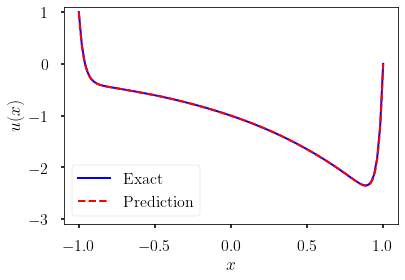

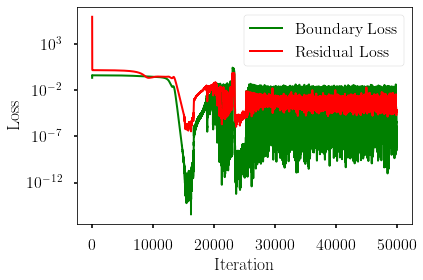

In [49]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f






#@tf.function(jit_compile=True)
@tf.function
def train_step(layers, W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_b, beta):
    x_u = X_u_train_tf[:,0:1]
    x_f = X_f_train_tf[:,0:1]
    adpative_constant_bcs_list = []
    lambda_b_list = []
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u,W, b) 
        f_nn = net_f(x_f,W, b, nu)
        bc_loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf))
        phys_loss = tf.reduce_mean(tf.square(f_nn)) 
        loss = lambda_b[-1]*bc_loss  + phys_loss
        loss = loss / (1 + lambda_b[-1])
        p_loss = phys_loss/(1 + lambda_b[-1])
        b_loss = lambda_b[-1]*bc_loss/(1 + lambda_b[-1])
    grad_loss = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grad_loss, train_vars(W,b)))
    grads_bc = tape.gradient(bc_loss, train_vars(W,b))
    grads_phys = tape.gradient(phys_loss, train_vars(W,b))
    for i in range(len(layers) - 1):
        adpative_constant_bcs_list.append(
                tf.reduce_mean(tf.abs(grads_phys[i])) / tf.reduce_mean(tf.abs(grads_bc[i])))
        
    lambda_b_new = tf.reduce_mean(tf.stack(adpative_constant_bcs_list))
    lambda_b_new = (1-beta)*lambda_b[-1] + beta*lambda_b_new
    lambda_b_list.append(lambda_b_new)
                                      
    return loss, lambda_b_list, p_loss, b_loss


def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
noise = 0.0        
N_f = 500
Nmax=50000

layers = [1, 8,8,8,8,8,8, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])
X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))
X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)
lam_b = np.array([1.0])
lam_b_tf= tf.convert_to_tensor(lam_b, dtype=tf.float32)                                
lambda_b_list = [lam_b_tf]                               
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)
start_time = time.time()
n=0
loss = []
bc_loss = []
phys_loss = []
beta = 0.1

while n <= Nmax:
    loss_, lambda_b_out, phys_loss_, bc_loss_ = train_step(layers, W, b, X_u_train_tf,\
                                                u_train_tf, X_f_train_tf, optimizer, nu,lambda_b_list, beta)
    lambda_b_list = lambda_b_out
    loss.append(loss_) 
    bc_loss.append(bc_loss_)
    phys_loss.append(phys_loss_)
    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))               
print('Training time: %.4f' % (elapsed))


def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()


Error u: 7.362674e+00


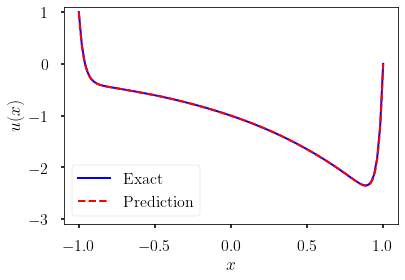

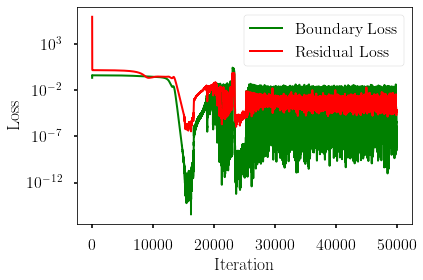

In [51]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep, bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()

plt.show()


Training Constrained NN
Constrained NN: epoch:  0 training loss  [2.63500285] validation loss [2.41413355]
Constrained NN: epoch:  1 training loss  [2.51711035] validation loss [2.39730549]
Constrained NN: epoch:  2 training loss  [2.52513361] validation loss [2.39209414]
Constrained NN: epoch:  3 training loss  [2.51492214] validation loss [2.3860929]
Constrained NN: epoch:  4 training loss  [2.49249172] validation loss [2.37401009]
Constrained NN: epoch:  5 training loss  [2.46768618] validation loss [2.36257935]
Constrained NN: epoch:  6 training loss  [2.42770743] validation loss [2.34126163]
Constrained NN: epoch:  7 training loss  [2.38864899] validation loss [2.30307889]
Constrained NN: epoch:  8 training loss  [2.3431561] validation loss [2.25877333]
Constrained NN: epoch:  9 training loss  [2.29978752] validation loss [2.22249103]
Constrained NN: epoch:  10 training loss  [2.24441242] validation loss [2.17564964]
Constrained NN: epoch:  11 training loss  [2.18394804] validatio

Constrained NN: epoch:  112 training loss  [0.21772861] validation loss [0.31085807]
Constrained NN: epoch:  113 training loss  [0.21785212] validation loss [0.30999747]
Constrained NN: epoch:  114 training loss  [0.2172648] validation loss [0.31032413]
Constrained NN: epoch:  115 training loss  [0.21792556] validation loss [0.31088579]
Constrained NN: epoch:  116 training loss  [0.21716459] validation loss [0.31202769]
Constrained NN: epoch:  117 training loss  [0.21802007] validation loss [0.3094241]
Constrained NN: epoch:  118 training loss  [0.22123168] validation loss [0.30810195]
Constrained NN: epoch:  119 training loss  [0.21828301] validation loss [0.313059]
Constrained NN: epoch:  120 training loss  [0.21714588] validation loss [0.31475753]
Constrained NN: epoch:  121 training loss  [0.22057575] validation loss [0.30992526]
Constrained NN: epoch:  122 training loss  [0.21647885] validation loss [0.30990261]
Constrained NN: epoch:  123 training loss  [0.21737522] validation lo

Constrained NN: epoch:  225 training loss  [0.05941197] validation loss [0.06429429]
Constrained NN: epoch:  226 training loss  [0.06104057] validation loss [0.06697403]
Constrained NN: epoch:  227 training loss  [0.05888212] validation loss [0.06987689]
Constrained NN: epoch:  228 training loss  [0.05833783] validation loss [0.06408726]
Constrained NN: epoch:  229 training loss  [0.05961219] validation loss [0.06722119]
Constrained NN: epoch:  230 training loss  [0.06086004] validation loss [0.06305061]
Constrained NN: epoch:  231 training loss  [0.06013195] validation loss [0.06349923]
Constrained NN: epoch:  232 training loss  [0.06003641] validation loss [0.06715629]
Constrained NN: epoch:  233 training loss  [0.05773474] validation loss [0.06332976]
Constrained NN: epoch:  234 training loss  [0.05829723] validation loss [0.07143404]
Constrained NN: epoch:  235 training loss  [0.05905772] validation loss [0.06271783]
Constrained NN: epoch:  236 training loss  [0.05727261] validatio

Constrained NN: epoch:  337 training loss  [0.04875066] validation loss [0.05365091]
Constrained NN: epoch:  338 training loss  [0.04915711] validation loss [0.05332135]
Constrained NN: epoch:  339 training loss  [0.04871105] validation loss [0.05524453]
Constrained NN: epoch:  340 training loss  [0.04841172] validation loss [0.05217713]
Constrained NN: epoch:  341 training loss  [0.0484131] validation loss [0.05293742]
Constrained NN: epoch:  342 training loss  [0.04794864] validation loss [0.05476406]
Constrained NN: epoch:  343 training loss  [0.04818957] validation loss [0.05242311]
Constrained NN: epoch:  344 training loss  [0.04830015] validation loss [0.05163742]
Constrained NN: epoch:  345 training loss  [0.0475154] validation loss [0.05415096]
Constrained NN: epoch:  346 training loss  [0.04816901] validation loss [0.05164706]
Constrained NN: epoch:  347 training loss  [0.04821244] validation loss [0.05043378]
Constrained NN: epoch:  348 training loss  [0.04707753] validation 

Standard NN: epoch:  70 training loss  [1.46354723] validation loss [1.5528791]
Standard NN: epoch:  71 training loss  [1.44175589] validation loss [1.51975071]
Standard NN: epoch:  72 training loss  [1.41395736] validation loss [1.4542675]
Standard NN: epoch:  73 training loss  [1.36978602] validation loss [1.44762444]
Standard NN: epoch:  74 training loss  [1.32086515] validation loss [1.41757655]
Standard NN: epoch:  75 training loss  [1.31475616] validation loss [1.37236869]
Standard NN: epoch:  76 training loss  [1.29658639] validation loss [1.38555074]
Standard NN: epoch:  77 training loss  [1.25713825] validation loss [1.31880856]
Standard NN: epoch:  78 training loss  [1.20248294] validation loss [1.31669569]
Standard NN: epoch:  79 training loss  [1.15086579] validation loss [1.26187885]
Standard NN: epoch:  80 training loss  [1.1187849] validation loss [1.23342907]
Standard NN: epoch:  81 training loss  [1.07459283] validation loss [1.20894802]
Standard NN: epoch:  82 trainin

Standard NN: epoch:  185 training loss  [0.2117191] validation loss [0.30873019]
Standard NN: epoch:  186 training loss  [0.21024106] validation loss [0.2931141]
Standard NN: epoch:  187 training loss  [0.20727944] validation loss [0.26634961]
Standard NN: epoch:  188 training loss  [0.19336766] validation loss [0.27037406]
Standard NN: epoch:  189 training loss  [0.16787648] validation loss [0.27770054]
Standard NN: epoch:  190 training loss  [0.17208199] validation loss [0.29977167]
Standard NN: epoch:  191 training loss  [0.17790775] validation loss [0.253824]
Standard NN: epoch:  192 training loss  [0.18453756] validation loss [0.29444137]
Standard NN: epoch:  193 training loss  [0.20412451] validation loss [0.28756598]
Standard NN: epoch:  194 training loss  [0.21004599] validation loss [0.255775]
Standard NN: epoch:  195 training loss  [0.18991436] validation loss [0.31297925]
Standard NN: epoch:  196 training loss  [0.2022377] validation loss [0.32849267]
Standard NN: epoch:  19

Standard NN: epoch:  301 training loss  [0.1161289] validation loss [0.21582949]
Standard NN: epoch:  302 training loss  [0.11573786] validation loss [0.21557546]
Standard NN: epoch:  303 training loss  [0.11576845] validation loss [0.21557011]
Standard NN: epoch:  304 training loss  [0.11595426] validation loss [0.21583062]
Standard NN: epoch:  305 training loss  [0.11583906] validation loss [0.2155591]
Standard NN: epoch:  306 training loss  [0.1156654] validation loss [0.21496241]
Standard NN: epoch:  307 training loss  [0.11572459] validation loss [0.21445955]
Standard NN: epoch:  308 training loss  [0.11555552] validation loss [0.21457419]
Standard NN: epoch:  309 training loss  [0.11589238] validation loss [0.21523091]
Standard NN: epoch:  310 training loss  [0.11575668] validation loss [0.21469368]
Standard NN: epoch:  311 training loss  [0.11556227] validation loss [0.21416083]
Standard NN: epoch:  312 training loss  [0.11583819] validation loss [0.21457753]
Standard NN: epoch:

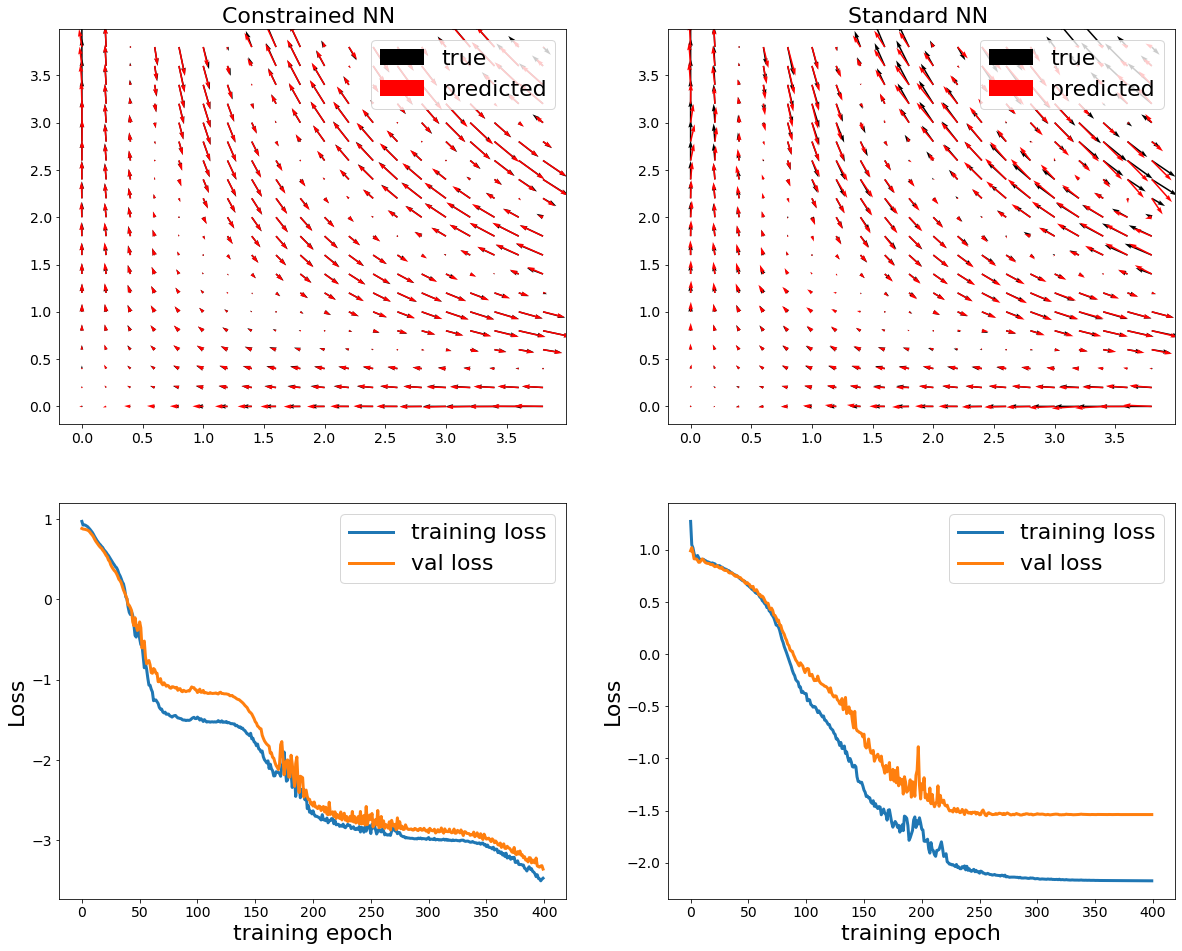

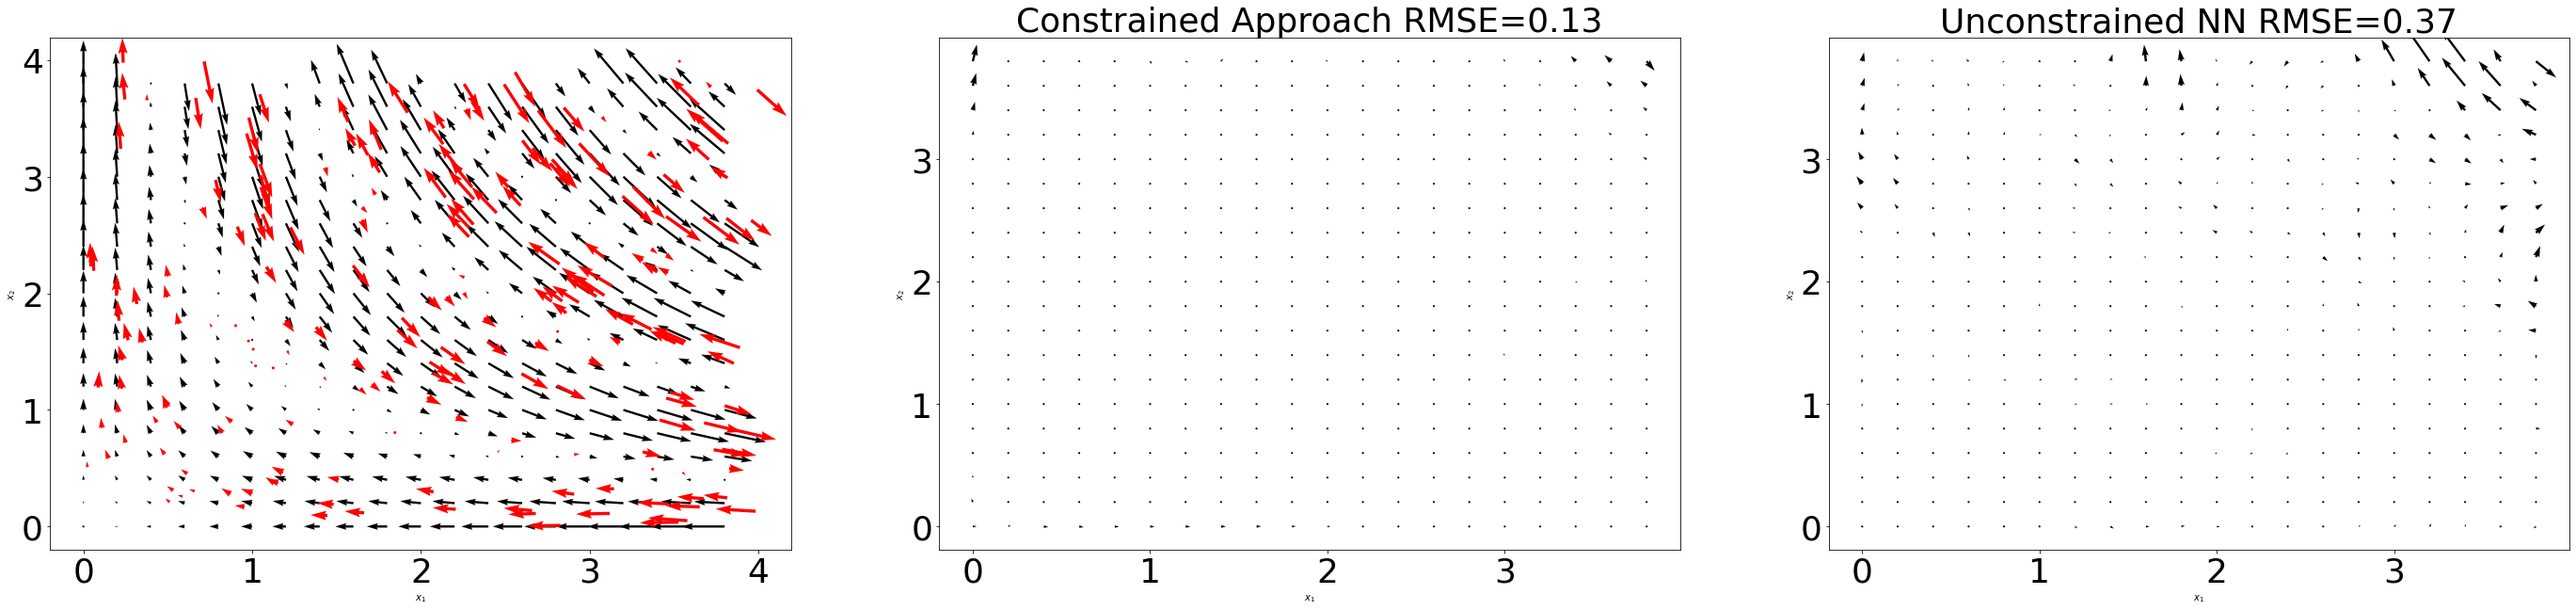

In [28]:
#https://github.com/jnh277/Linearly-Constrained-NN/blob/release/simulted_divergence_free.py

import torch
from matplotlib import pyplot as plt
from torch.utils import data
import numpy as np
import torch.autograd as ag
import torch.nn as nn
torch.manual_seed(1234)
epochs = 400
n_data = 200
### Input Data
def vector_field(x, y, a=0.01):
    v1 = torch.exp(-a*x*y)*(a*x*torch.sin(x*y) - x*torch.cos(x*y))
    v2 = torch.exp(-a*x*y)*(y*torch.cos(x*y) - a*y*torch.sin(x*y))
    return (v1, v2)


## ------------------ set up models-------------------------- ##
# set network size
n_in = 2
n_h1 = 100
n_h2 = 50
n_o = 1

# two outputs for the unconstrained network
n_o_uc = 2

# define model class
class DivFree2D(torch.nn.Module):
    def __init__(self, base_net):
        super(DivFree2D, self).__init__()
        self.base_net = base_net

    def forward(self, x):
        x.requires_grad = True
        y = self.base_net(x)
        dydx = ag.grad(outputs=y, inputs=x, create_graph=True, grad_outputs=torch.ones(y.size()),
                       retain_graph=True, only_inputs=True)[0]
        return y, dydx[:,1].unsqueeze(1), -dydx[:,0].unsqueeze(1)

model = DivFree2D(nn.Sequential(nn.Linear(n_in,n_h1),nn.Tanh(),nn.Linear(n_h1,n_h2),
                                         nn.Tanh(),nn.Linear(n_h2,n_o)))


model_uc = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o_uc),
)


# pregenerate validation data
x_val = 4.0 * torch.rand(2000, 2)
x1_val = x_val[:, 0].unsqueeze(1)
x2_val = x_val[:, 1].unsqueeze(1)

(v1, v2) = vector_field(x1_val, x2_val)
y1_val = v1 + 0.1 * torch.randn(x1_val.size())
y2_val = v2 + 0.1 * torch.randn(x1_val.size())
y_val = torch.cat((y1_val, y2_val), 1)


# Get the true function values on a grid
xv, yv = torch.meshgrid([torch.arange(0.0, 20.0) * 4.0 / 20.0, torch.arange(0.0, 20.0) * 4.0 / 20.0])
(v1, v2) = vector_field(xv, yv)

# generate training data
x_train = 4.0 * torch.rand(n_data, 2)
x1_train = x_train[:, 0].unsqueeze(1)
x2_train = x_train[:, 1].unsqueeze(1)

(v1_t, v2_t) = vector_field(x1_train, x2_train)
y1_train = v1_t + 0.1 * torch.randn(x1_train.size())
y2_train = v2_t + 0.1 * torch.randn(x1_train.size())


# define Dataset class
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, x1, x2, y1, y2):
        'Initialization'
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x1)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x1 = self.x1[index]
        x2 = self.x2[index]
        y1 = self.y1[index]
        y2 = self.y2[index]

        return x1, x2, y1, y2

training_set = Dataset(x1_train, x2_train, y1_train, y2_train)

# data loader Parameters
DL_params = {'batch_size': 100,
             'shuffle': True,
             'num_workers': 0,
             'pin_memory': False}
training_generator = data.DataLoader(training_set, **DL_params)


# ---------------  Set up and train the constrained model -------------------------------
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau\
                                    (optimizer, patience=10,
                                     min_lr=1e-10,
                                     factor=0.5, cooldown=15)

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        (yhat, v1hat, v2hat) = model(x_train)
        loss = (criterion(y1_train, v1hat) + criterion(y2_train, v2hat)) / 2  # divide by 2 as it is a mean
        loss.backward()
        optimizer.step()
        total_loss += loss
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    # with torch.no_grad():
    (yhat, v1hat, v2hat) = model(x_val)
    loss = (criterion(y1_val, v1hat) + criterion(y2_val, v2hat)) / 2
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training Constrained NN')

for epoch in range(epochs):
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    print('Constrained NN: epoch: ', epoch, 'training loss ', train_loss[epoch], \
          'validation loss', val_loss[epoch])


# work out the rms error for this one
x_pred = torch.cat((xv.reshape(20 * 20, 1), yv.reshape(20 * 20, 1)), 1)
(f_pred, v1_pred, v2_pred) = model(x_pred)
error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
rms_error = torch.sqrt(sum(error_new * error_new) / 800)

# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer_uc = torch.optim.Adam(model_uc.parameters(), lr=0.01)
scheduler_uc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_uc, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

def train_uc(epoch):
    model_uc.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer_uc.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        vhat = model_uc(x_train)
        y_train = torch.cat((y1_train, y2_train), 1)
        loss = criterion(y_train, vhat)
        loss.backward()
        optimizer_uc.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval_uc(epoch):
    model_uc.eval()
    with torch.no_grad():
        (vhat) = model_uc(x_val)
        loss = criterion(y_val, vhat)
    return loss.cpu()


train_loss_uc = np.empty([epochs, 1])
val_loss_uc = np.empty([epochs, 1])


print('Training standard NN')

for epoch in range(epochs):
    train_loss_uc[epoch] = train_uc(epoch).detach().numpy()
    v_loss = eval_uc(epoch)
    scheduler_uc.step(v_loss)
    val_loss_uc[epoch] = v_loss.detach().numpy()
    print('Standard NN: epoch: ', epoch, 'training loss ', \
          train_loss_uc[epoch], 'validation loss', val_loss_uc[epoch])


# work out final rms error for unconstrainted net
(v_pred_uc) = model_uc(x_pred)
v1_pred_uc = v_pred_uc[:, 0]
v2_pred_uc = v_pred_uc[:, 1]

error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)



print('Finished')
print("Final RMSE for constrained neural network: ",rms_error.item())
print("Final RMSE for standard neural network: ",rms_uc.item())

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 2, figsize=(20, 16))
    # ax.pcolor(xv,yv,f_scalar)
    ax[0, 0].quiver(xv, yv, v1, v2)
    ax[0, 0].quiver(xv, yv, v1_pred.reshape(20, 20).detach(), v2_pred.reshape(20, 20).detach(), color='r')
    ax[0, 0].legend(['true', 'predicted'], fontsize=22)
    ax[0, 0].set_title('Constrained NN ', fontsize=22)
    ax[0, 0].tick_params(axis='x', labelsize=14 )
    ax[0, 0].tick_params(axis='y', labelsize=14 )


    ax[1, 0].plot(np.log(train_loss),lw=3.0)
    ax[1, 0].plot(np.log(val_loss), lw=3.0)
    # ax[1].plot(loss_save[1:epoch].log().detach().numpy())
    ax[1, 0].set_xlabel('training epoch',  fontsize=22)
    ax[1, 0].set_ylabel('Loss',  fontsize=22)
    ax[1, 0].legend(['training loss', 'val loss'], fontsize=22)
    ax[1, 0].tick_params(axis='x', labelsize=14 )
    ax[1, 0].tick_params(axis='y', labelsize=14 )

    ax[0, 1].quiver(xv, yv, v1, v2)
    ax[0, 1].quiver(xv, yv, v1_pred_uc.reshape(20, 20).detach(), v2_pred_uc.reshape(20, 20).detach(), color='r')
    ax[0, 1].legend(['true', 'predicted'], fontsize=22)
    ax[0, 1].set_title('Standard NN ',fontsize=22)
    ax[0, 1].tick_params(axis='x', labelsize=14 )
    ax[0,1].tick_params(axis='y', labelsize=14 )

    ax[1, 1].plot(np.log(train_loss_uc),lw=3.0)
    ax[1, 1].plot(np.log(val_loss_uc),lw=3.0)
    ax[1, 1].set_ylabel('Loss', fontsize=22)
    ax[1, 1].set_xlabel('training epoch', fontsize=22)
    ax[1, 1].legend(['training loss','val loss'], fontsize=22)
    ax[1, 1].tick_params(axis='x', labelsize=14)
    ax[1,1].tick_params(axis='y', labelsize=14 )
    plt.savefig("Figure_1.png", dpi=300)
    plt.show()
   
    

    # Initialize second plot
    f2, ax2 = plt.subplots(1, 3, figsize=(48, 10))
    Q = ax2[0].quiver(xv, yv, v1, v2, scale=None, scale_units='inches')
    Q._init()
    assert isinstance(Q.scale, float)
    ax2[0].quiver(x1_train, x2_train, y1_train, y2_train, scale=Q.scale, scale_units='inches', color='r')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$')
    ax2[0].tick_params(axis='x', labelsize=36)
    ax2[0].tick_params(axis='y', labelsize=36)
    


    error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
    rms_new = torch.sqrt(sum(error_new * error_new) / 800)

    ax2[1].quiver(xv, yv, v1 - v1_pred.reshape(20, 20).detach(), v2 - v2_pred.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$')
    ax2[1].set_title('Constrained Approach RMSE={0:.2f}'.format(rms_new.item()), fontsize=36)
    ax2[1].tick_params(axis='x', labelsize=36 )
    ax2[1].tick_params(axis='y', labelsize=36 )
    


    error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
    rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)

    ax2[2].quiver(xv, yv, v1 - v1_pred_uc.reshape(20, 20).detach(), v2 - v2_pred_uc.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[2].set_xlabel('$x_1$')
    ax2[2].set_ylabel('$x_2$')
    ax2[2].set_title('Unconstrained NN RMSE={0:.2f}'.format(rms_uc.item()), fontsize=36)
    ax2[2].tick_params(axis='x', labelsize=36 )
    ax2[2].tick_params(axis='y', labelsize=36 )
    plt.savefig("Figure_2.png", dpi=300)
    plt.show()


## Multi-fidelity Deep Neural Network

n: 1000, loss: 3.656e+00, loss_lf: 2.703e+00, loss_hf: 7.138e-01
n: 2000, loss: 5.050e-01, loss_lf: 2.545e-01, loss_hf: 1.417e-02
n: 3000, loss: 2.946e-01, loss_lf: 7.560e-02, loss_hf: 8.657e-04
n: 4000, loss: 2.298e-01, loss_lf: 3.119e-02, loss_hf: 7.511e-04
n: 5000, loss: 2.084e-01, loss_lf: 2.633e-02, loss_hf: 6.609e-04
n: 6000, loss: 1.937e-01, loss_lf: 2.351e-02, loss_hf: 5.517e-04
n: 7000, loss: 1.831e-01, loss_lf: 2.110e-02, loss_hf: 4.560e-04
n: 8000, loss: 1.747e-01, loss_lf: 2.026e-02, loss_hf: 3.481e-04
n: 9000, loss: 1.652e-01, loss_lf: 1.980e-02, loss_hf: 2.279e-04
n: 10000, loss: 1.563e-01, loss_lf: 1.923e-02, loss_hf: 1.767e-04
n: 11000, loss: 1.477e-01, loss_lf: 1.882e-02, loss_hf: 1.583e-04
n: 12000, loss: 1.406e-01, loss_lf: 1.861e-02, loss_hf: 1.575e-04
n: 13000, loss: 1.179e-01, loss_lf: 9.327e-04, loss_hf: 1.766e-04
n: 14000, loss: 1.126e-01, loss_lf: 2.849e-05, loss_hf: 2.044e-04
n: 15000, loss: 1.078e-01, loss_lf: 1.923e-05, loss_hf: 2.220e-04
n: 16000, loss: 1.0

NameError: name 'x_test' is not defined

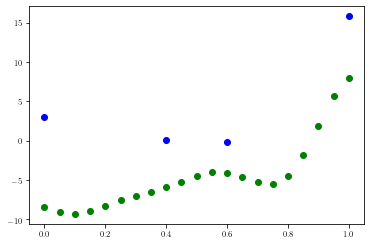

In [3]:
## Code for Multi-fidelity DNN
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1234)
tf.random.set_seed(1234)

class DNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2/(in_dim + out_dim))
            weight = tf.Variable(tf.random.truncated_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y
    
    def train_vars(self, W, b):
        return W + b

    

    
# Exact Low Fidelity Fucntion    
def fun_lf(x):
    y = 0.5*(6*x - 2)**2*np.sin(12*x - 4) + 10*(x - 0.5) - 5
    return y

#Exact high-fidelity function
def fun_hf(x):
    y = (6*x - 2)**2*np.sin(12*x - 4)
    return y





@tf.function
def train_step(W, b, model, x_train_lf, y_train_lf , x_train_hf, y_train_hf,opt, train=1):
    W_lf = W[0]
    W_hf_nl = W[1]
    W_hf_l = W[2] 
    b_lf =   b[0]
    b_hf_nl = b[1]
    b_hf_l = b[2]
    if train==1:
        with tf.GradientTape() as tape:
            tape.watch([W_lf, W_hf_nl,W_hf_l, b_lf, b_hf_nl, b_hf_l])
            y_pred_lf = model.fnn(W_lf, b_lf, x_train_lf, Xmin, Xmax)
            y_pred_hf_nl = model.fnn(W_hf_nl, b_hf_nl, x_train_hf, Xhmin, Xhmax)
            y_pred_hf_l = model.fnn(W_hf_l, b_hf_l, x_train_hf, Xhmin, Xhmax)
            y_pred_hf = y_pred_hf_l + y_pred_hf_nl
            loss_l2 = 0.01*tf.add_n([tf.nn.l2_loss(w_) for w_ in W_hf_nl])
            loss_lf = tf.reduce_mean(tf.square(y_pred_lf - y_train_lf))
            loss_hf =  tf.reduce_mean(tf.square(y_pred_hf - y_train_hf))
            loss = loss_lf + loss_hf + loss_l2
        grads = tape.gradient(loss, W_lf + b_lf + W_hf_nl + b_hf_nl +  W_hf_l + b_hf_l)
        opt.apply_gradients(zip(grads, W_lf + b_lf + W_hf_nl + b_hf_nl +  W_hf_l + b_hf_l))
        return loss, loss_lf, loss_hf
        
    if train == 0:
        y_pred_lf = model.fnn(W_lf, b_lf, x_train_lf, Xmin, Xmax)
        y_pred_hf_nl = model.fnn(W_hf_nl, b_hf_nl, x_train_hf, Xhmin, Xhmax)
        y_pred_hf_l = model.fnn(W_hf_l, b_hf_l, x_train_hf, Xhmin, Xhmax)
        y_pred_hf = y_pred_hf_l + y_pred_hf_nl
        return  y_pred_hf, y_pred_lf




## Dimension of Function
D = 1
#low-fidelity NN
layers_lf = [D] + 2*[20] + [1]

#nonlinear correlation
layers_hf_nl = [D+1] + 2*[10] + [1]

#linear correlation
layers_hf_l = [D+1] + [1]

#low-fidelity training data
x_lf = np.linspace(0, 1, 21).reshape((-1, 1))
y_lf = fun_lf(x_lf)

#high-fidelity training data
x_hf = np.array([0., 0.4, 0.6, 1.0]).reshape((-1, 1))

#low-fidelity training data at x_H
y_lf_hf = fun_lf(x_hf)
y_hf = fun_hf(x_hf)
X_hf = np.hstack((x_hf, y_lf_hf))

Xmin = x_lf.min(0)
Xmax = x_lf.max(0)
Ymin = y_lf.min(0)
Ymax = y_lf.max(0)

Xhmin = np.hstack((Xmin, Ymin))
Xhmax = np.hstack((Xmax, Ymax))

x_train_lf = tf.convert_to_tensor(x_lf, dtype=tf.float32)
y_train_lf = tf.convert_to_tensor(y_lf, dtype=tf.float32)
x_train_hf = tf.convert_to_tensor(X_hf, dtype=tf.float32)
y_train_hf = tf.convert_to_tensor(y_hf, dtype=tf.float32)

model = DNN()
W_lf, b_lf = model.hyper_initial(layers_lf)
W_hf_nl, b_hf_nl = model.hyper_initial(layers_hf_nl)
W_hf_l, b_hf_l = model.hyper_initial(layers_hf_l)

W=[W_lf, W_hf_nl, W_hf_l]
b=[b_lf, b_hf_nl, b_hf_l]

lr =0.001
optimizer = tf.optimizers.Adam(learning_rate=lr)



nmax = 30000
loss_c = 1.0e-3
loss_ = 1.0
n = 0

while n < nmax:
    n += 1
    loss_, loss_lf_, loss_hf_ = train_step(W, b, model, x_train_lf, y_train_lf , \
                                           x_train_hf, y_train_hf,optimizer, train=1)
    if n%1000 == 0:
        print('n: %d, loss: %.3e, loss_lf: %.3e, loss_hf: %.3e'%(n, loss_, loss_lf_, loss_hf_))
        
        
plt.figure(facecolor='w')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=10)
plt.plot(x_lf, y_lf, 'go', label="Low-fidelity Training Data")
plt.plot(x_hf, y_hf, 'bo', label="High-fidelity Training Data")
plt.plot(x_test, y_lf_test, 'r--', label="Low-fidelity function")
plt.plot(x_test, y_hf_test, 'c--', label="High-fidelity function")
plt.legend()
plt.show()